##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image captioning with visual attention

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/text/image_captioning.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Given an image like the example below, our goal is to generate a caption such as "a surfer riding on a wave".

![Man Surfing](https://tensorflow.org/images/surf.jpg)

*[Image Source](https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg); License: Public Domain*

To accomplish this, you'll use an attention-based model, which enables us to see what parts of the image the model focuses on as it generates a caption.

![Prediction](https://tensorflow.org/images/imcap_prediction.png)

The model architecture is similar to [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044).

This notebook is an end-to-end example. When you run the notebook, it downloads the [MS-COCO](http://cocodataset.org/#home) dataset, preprocesses and caches a subset of images using Inception V3, trains an encoder-decoder model, and generates captions on new images using the trained model.

In this example, you will train a model on a relatively small amount of data—the first 30,000 captions  for about 20,000 images (because there are multiple captions per image in the dataset).

In [2]:
import tensorflow as tf

# You'll generate plots of attention in order to see which parts of an image
# our model focuses on during captioning
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

## Download and prepare the MS-COCO dataset

You will use the [MS-COCO dataset](http://cocodataset.org/#home) to train our model. The dataset contains over 82,000 images, each of which has at least 5 different caption annotations. The code below downloads and extracts the dataset automatically.

**Caution: large download ahead**. You'll use the training set, which is a 13GB file.

In [3]:
# Download caption annotation files
annotation_folder = '/annotations/'
if not os.path.exists(os.path.abspath('.') + annotation_folder):
  annotation_zip = tf.keras.utils.get_file('captions.zip',
                                           cache_subdir=os.path.abspath('.'),
                                           origin='http://images.cocodataset.org/annotations/annotations_trainval2014.zip',
                                           extract=True)
  annotation_file = os.path.dirname(annotation_zip)+'/annotations/captions_train2014.json'
  os.remove(annotation_zip)

# Download image files
image_folder = '/train2014/'
if not os.path.exists(os.path.abspath('.') + image_folder):
  image_zip = tf.keras.utils.get_file('train2014.zip',
                                      cache_subdir=os.path.abspath('.'),
                                      origin='http://images.cocodataset.org/zips/train2014.zip',
                                      extract=True)
  PATH = os.path.dirname(image_zip) + image_folder
  os.remove(image_zip)
else:
  PATH = os.path.abspath('.') + image_folder

     8192/252872794 [..............................] - ETA: 2s

    16384/252872794 [..............................] - ETA: 45:46

    49152/252872794 [..............................] - ETA: 30:32

   106496/252872794 [..............................] - ETA: 21:08

   204800/252872794 [..............................] - ETA: 14:39

   417792/252872794 [..............................] - ETA: 8:58 

   860160/252872794 [..............................] - ETA: 5:13

  1728512/252872794 [..............................] - ETA: 3:01

  3465216/252872794 [..............................] - ETA: 1:42

  6602752/252872794 [..............................] - ETA: 59s 

  9740288/252872794 [>.............................] - ETA: 44s

 12877824/252872794 [>.............................] - ETA: 34s

 12886016/252872794 [>.............................] - ETA: 36s

 16015360/252872794 [>.............................] - ETA: 30s

 16023552/252872794 [>.............................] - ETA: 31s

 19136512/252872794 [=>............................] - ETA: 27s

 19161088/252872794 [=>............................] - ETA: 28s

 22274048/252872794 [=>............................] - ETA: 24s

 22290432/252872794 [=>............................] - ETA: 25s

 25370624/252872794 [==>...........................] - ETA: 23s

 25419776/252872794 [==>...........................] - ETA: 23s

 28475392/252872794 [==>...........................] - ETA: 21s

 28532736/252872794 [==>...........................] - ETA: 22s

 31612928/252872794 [==>...........................] - ETA: 20s

 31629312/252872794 [==>...........................] - ETA: 21s

 34750464/252872794 [===>..........................] - ETA: 19s

 34766848/252872794 [===>..........................] - ETA: 20s

 37879808/252872794 [===>..........................] - ETA: 18s

 37904384/252872794 [===>..........................] - ETA: 19s

 41017344/252872794 [===>..........................] - ETA: 17s

 41025536/252872794 [===>..........................] - ETA: 18s

 44154880/252872794 [====>.........................] - ETA: 17s

 44163072/252872794 [====>.........................] - ETA: 17s

 47276032/252872794 [====>.........................] - ETA: 16s

 47300608/252872794 [====>.........................] - ETA: 17s

 50413568/252872794 [====>.........................] - ETA: 16s

 50429952/252872794 [====>.........................] - ETA: 16s

 53551104/252872794 [=====>........................] - ETA: 15s

 53567488/252872794 [=====>........................] - ETA: 15s

 56647680/252872794 [=====>........................] - ETA: 15s

 56705024/252872794 [=====>........................] - ETA: 15s

 59777024/252872794 [======>.......................] - ETA: 14s

 59850752/252872794 [======>.......................] - ETA: 14s

 62906368/252872794 [======>.......................] - ETA: 14s

 62971904/252872794 [======>.......................] - ETA: 14s

 66043904/252872794 [======>.......................] - ETA: 13s

 66084864/252872794 [======>.......................] - ETA: 14s

 69181440/252872794 [=======>......................] - ETA: 13s

 69222400/252872794 [=======>......................] - ETA: 13s

 72327168/252872794 [=======>......................] - ETA: 13s

 72351744/252872794 [=======>......................] - ETA: 13s

 75440128/252872794 [=======>......................] - ETA: 12s

 75489280/252872794 [=======>......................] - ETA: 13s

 78577664/252872794 [========>.....................] - ETA: 12s

 78626816/252872794 [========>.....................] - ETA: 12s

 81707008/252872794 [========>.....................] - ETA: 12s

 81756160/252872794 [========>.....................] - ETA: 12s

 84852736/252872794 [=========>....................] - ETA: 11s

 84893696/252872794 [=========>....................] - ETA: 12s

 87990272/252872794 [=========>....................] - ETA: 11s

 88014848/252872794 [=========>....................] - ETA: 11s

 91127808/252872794 [=========>....................] - ETA: 11s

 91152384/252872794 [=========>....................] - ETA: 11s

 94265344/252872794 [==========>...................] - ETA: 10s

 94289920/252872794 [==========>...................] - ETA: 11s

 97402880/252872794 [==========>...................] - ETA: 10s

 97419264/252872794 [==========>...................] - ETA: 10s

100540416/252872794 [==========>...................] - ETA: 10s

100556800/252872794 [==========>...................] - ETA: 10s

103677952/252872794 [===========>..................] - ETA: 10s

103702528/252872794 [===========>..................] - ETA: 10s

106823680/252872794 [===========>..................] - ETA: 9s 

106831872/252872794 [===========>..................] - ETA: 10s

109961216/252872794 [============>.................] - ETA: 9s 

109969408/252872794 [============>.................] - ETA: 9s

113098752/252872794 [============>.................] - ETA: 9s

113115136/252872794 [============>.................] - ETA: 9s

116219904/252872794 [============>.................] - ETA: 9s

116252672/252872794 [============>.................] - ETA: 9s

119365632/252872794 [=============>................] - ETA: 8s

119390208/252872794 [=============>................] - ETA: 8s

122503168/252872794 [=============>................] - ETA: 8s

122519552/252872794 [=============>................] - ETA: 8s

125648896/252872794 [=============>................] - ETA: 8s

125665280/252872794 [=============>................] - ETA: 8s

128786432/252872794 [==============>...............] - ETA: 8s

128802816/252872794 [==============>...............] - ETA: 8s

131915776/252872794 [==============>...............] - ETA: 7s

131940352/252872794 [==============>...............] - ETA: 8s

135045120/252872794 [===============>..............] - ETA: 7s

135077888/252872794 [===============>..............] - ETA: 7s

138182656/252872794 [===============>..............] - ETA: 7s

138215424/252872794 [===============>..............] - ETA: 7s

141328384/252872794 [===============>..............] - ETA: 7s

141344768/252872794 [===============>..............] - ETA: 7s

144465920/252872794 [================>.............] - ETA: 7s

144482304/252872794 [================>.............] - ETA: 7s

147603456/252872794 [================>.............] - ETA: 6s

147619840/252872794 [================>.............] - ETA: 6s

150740992/252872794 [================>.............] - ETA: 6s

150757376/252872794 [================>.............] - ETA: 6s

153878528/252872794 [=================>............] - ETA: 6s

153894912/252872794 [=================>............] - ETA: 6s

157024256/252872794 [=================>............] - ETA: 6s

157032448/252872794 [=================>............] - ETA: 6s

160145408/252872794 [=================>............] - ETA: 5s

160178176/252872794 [==================>...........] - ETA: 5s

163274752/252872794 [==================>...........] - ETA: 5s

163315712/252872794 [==================>...........] - ETA: 5s

166395904/252872794 [==================>...........] - ETA: 5s

166445056/252872794 [==================>...........] - ETA: 5s

169000960/252872794 [===================>..........] - ETA: 5s

169041920/252872794 [===================>..........] - ETA: 5s

171597824/252872794 [===================>..........] - ETA: 5s

172163072/252872794 [===================>..........] - ETA: 5s

172179456/252872794 [===================>..........] - ETA: 5s

174653440/252872794 [===================>..........] - ETA: 4s

175300608/252872794 [===================>..........] - ETA: 4s

175308800/252872794 [===================>..........] - ETA: 4s

177799168/252872794 [====================>.........] - ETA: 4s

178446336/252872794 [====================>.........] - ETA: 4s

180936704/252872794 [====================>.........] - ETA: 4s

181592064/252872794 [====================>.........] - ETA: 4s

184082432/252872794 [====================>.........] - ETA: 4s

184713216/252872794 [====================>.........] - ETA: 4s

184737792/252872794 [====================>.........] - ETA: 4s

187228160/252872794 [=====================>........] - ETA: 4s

187867136/252872794 [=====================>........] - ETA: 4s

190357504/252872794 [=====================>........] - ETA: 3s

190988288/252872794 [=====================>........] - ETA: 3s

190996480/252872794 [=====================>........] - ETA: 3s

193191936/252872794 [=====================>........] - ETA: 3s

194117632/252872794 [======================>.......] - ETA: 3s

194134016/252872794 [======================>.......] - ETA: 3s

196337664/252872794 [======================>.......] - ETA: 3s

197263360/252872794 [======================>.......] - ETA: 3s

197271552/252872794 [======================>.......] - ETA: 3s

199475200/252872794 [======================>.......] - ETA: 3s

200400896/252872794 [======================>.......] - ETA: 3s

200409088/252872794 [======================>.......] - ETA: 3s

202604544/252872794 [=======================>......] - ETA: 3s

203522048/252872794 [=======================>......] - ETA: 3s

203546624/252872794 [=======================>......] - ETA: 3s

205742080/252872794 [=======================>......] - ETA: 2s

206667776/252872794 [=======================>......] - ETA: 2s

206675968/252872794 [=======================>......] - ETA: 2s

208879616/252872794 [=======================>......] - ETA: 2s

209805312/252872794 [=======================>......] - ETA: 2s

209813504/252872794 [=======================>......] - ETA: 2s

212017152/252872794 [========================>.....] - ETA: 2s

212942848/252872794 [========================>.....] - ETA: 2s

212951040/252872794 [========================>.....] - ETA: 2s

215171072/252872794 [========================>.....] - ETA: 2s

216072192/252872794 [========================>.....] - ETA: 2s

216088576/252872794 [========================>.....] - ETA: 2s

218308608/252872794 [========================>.....] - ETA: 2s

219209728/252872794 [=========================>....] - ETA: 2s

219226112/252872794 [=========================>....] - ETA: 2s

221446144/252872794 [=========================>....] - ETA: 1s

222347264/252872794 [=========================>....] - ETA: 1s

222355456/252872794 [=========================>....] - ETA: 1s

224141312/252872794 [=========================>....] - ETA: 1s

225484800/252872794 [=========================>....] - ETA: 1s

225492992/252872794 [=========================>....] - ETA: 1s

227270656/252872794 [=========================>....] - ETA: 1s

228614144/252872794 [==========================>...] - ETA: 1s

228630528/252872794 [==========================>...] - ETA: 1s

230424576/252872794 [==========================>...] - ETA: 1s

231759872/252872794 [==========================>...] - ETA: 1s

233521152/252872794 [==========================>...] - ETA: 1s

234881024/252872794 [==========================>...] - ETA: 1s

234905600/252872794 [==========================>...] - ETA: 1s

236658688/252872794 [===========================>..] - ETA: 1s

238026752/252872794 [===========================>..] - ETA: 0s

238034944/252872794 [===========================>..] - ETA: 0s

239542272/252872794 [===========================>..] - ETA: 0s

241147904/252872794 [===========================>..] - ETA: 0s

241180672/252872794 [===========================>..] - ETA: 0s

242712576/252872794 [===========================>..] - ETA: 0s

244277248/252872794 [===========================>..] - ETA: 0s

244318208/252872794 [===========================>..] - ETA: 0s

245817344/252872794 [============================>.] - ETA: 0s

247422976/252872794 [============================>.] - ETA: 0s

247447552/252872794 [============================>.] - ETA: 0s

248954880/252872794 [============================>.] - ETA: 0s

250568704/252872794 [============================>.] - ETA: 0s

252059648/252872794 [============================>.] - ETA: 0s

252878848/252872794 [==============================] - 16s 0us/step


       8192/13510573713 [..............................] - ETA: 6:41

      16384/13510573713 [..............................] - ETA: 40:53:16

      49152/13510573713 [..............................] - ETA: 27:17:57

     106496/13510573713 [..............................] - ETA: 18:54:13

     204800/13510573713 [..............................] - ETA: 13:06:34

     417792/13510573713 [..............................] - ETA: 8:02:00 

     860160/13510573713 [..............................] - ETA: 4:40:58

    1728512/13510573713 [..............................] - ETA: 2:43:08

    3465216/13510573713 [..............................] - ETA: 1:32:59

    6602752/13510573713 [..............................] - ETA: 54:55  

    9740288/13510573713 [..............................] - ETA: 41:20

   12877824/13510573713 [..............................] - ETA: 34:23

   16015360/13510573713 [..............................] - ETA: 30:09

   19161088/13510573713 [..............................] - ETA: 27:19

   22298624/13510573713 [..............................] - ETA: 25:15

   25214976/13510573713 [..............................] - ETA: 22:46

   25436160/13510573713 [..............................] - ETA: 23:43

   28352512/13510573713 [..............................] - ETA: 21:40

   28581888/13510573713 [..............................] - ETA: 22:34

   31711232/13510573713 [..............................] - ETA: 21:36

   34848768/13510573713 [..............................] - ETA: 20:48

   37986304/13510573713 [..............................] - ETA: 20:08

   41123840/13510573713 [..............................] - ETA: 19:34

   44244992/13510573713 [..............................] - ETA: 19:06

   47390720/13510573713 [..............................] - ETA: 18:40

   50520064/13510573713 [..............................] - ETA: 18:18

   53657600/13510573713 [..............................] - ETA: 17:59

   56795136/13510573713 [..............................] - ETA: 17:41

   59940864/13510573713 [..............................] - ETA: 17:25

   63045632/13510573713 [..............................] - ETA: 17:12

   66174976/13510573713 [..............................] - ETA: 16:59

   69312512/13510573713 [..............................] - ETA: 16:48

   72441856/13510573713 [..............................] - ETA: 16:37

   75579392/13510573713 [..............................] - ETA: 16:27

   78716928/13510573713 [..............................] - ETA: 16:18

   81846272/13510573713 [..............................] - ETA: 16:10

   84992000/13510573713 [..............................] - ETA: 16:02

   88137728/13510573713 [..............................] - ETA: 15:55

   91275264/13510573713 [..............................] - ETA: 15:48

   94420992/13510573713 [..............................] - ETA: 15:42

   97558528/13510573713 [..............................] - ETA: 15:36

  100687872/13510573713 [..............................] - ETA: 15:30

  103825408/13510573713 [..............................] - ETA: 15:14

  103833600/13510573713 [..............................] - ETA: 15:25

  106962944/13510573713 [..............................] - ETA: 15:09

  106971136/13510573713 [..............................] - ETA: 15:20

  110092288/13510573713 [..............................] - ETA: 15:05

  110108672/13510573713 [..............................] - ETA: 15:15

  113229824/13510573713 [..............................] - ETA: 15:01

  113246208/13510573713 [..............................] - ETA: 15:11

  116367360/13510573713 [..............................] - ETA: 14:57

  116383744/13510573713 [..............................] - ETA: 15:07

  119504896/13510573713 [..............................] - ETA: 14:53

  119521280/13510573713 [..............................] - ETA: 15:03

  122650624/13510573713 [..............................] - ETA: 14:50

  122658816/13510573713 [..............................] - ETA: 14:59

  125788160/13510573713 [..............................] - ETA: 14:46

  125796352/13510573713 [..............................] - ETA: 14:55

  128925696/13510573713 [..............................] - ETA: 14:43

  128933888/13510573713 [..............................] - ETA: 14:52

  132063232/13510573713 [..............................] - ETA: 14:40

  132071424/13510573713 [..............................] - ETA: 14:49

  135208960/13510573713 [..............................] - ETA: 14:46

  138346496/13510573713 [..............................] - ETA: 14:34

  138354688/13510573713 [..............................] - ETA: 14:43

  141484032/13510573713 [..............................] - ETA: 14:31

  141492224/13510573713 [..............................] - ETA: 14:40

  144621568/13510573713 [..............................] - ETA: 14:29

  144637952/13510573713 [..............................] - ETA: 14:37

  147767296/13510573713 [..............................] - ETA: 14:26

  147775488/13510573713 [..............................] - ETA: 14:34

  150904832/13510573713 [..............................] - ETA: 14:24

  150913024/13510573713 [..............................] - ETA: 14:32

  154042368/13510573713 [..............................] - ETA: 14:22

  154050560/13510573713 [..............................] - ETA: 14:29

  157188096/13510573713 [..............................] - ETA: 14:27

  160317440/13510573713 [..............................] - ETA: 14:17

  160333824/13510573713 [..............................] - ETA: 14:25

  163463168/13510573713 [..............................] - ETA: 14:15

  163471360/13510573713 [..............................] - ETA: 14:22

  166600704/13510573713 [..............................] - ETA: 14:13

  166608896/13510573713 [..............................] - ETA: 14:20

  169746432/13510573713 [..............................] - ETA: 14:18

  172883968/13510573713 [..............................] - ETA: 14:09

  172892160/13510573713 [..............................] - ETA: 14:16

  176029696/13510573713 [..............................] - ETA: 14:14

  179142656/13510573713 [..............................] - ETA: 14:06

  179175424/13510573713 [..............................] - ETA: 14:12

  182280192/13510573713 [..............................] - ETA: 14:04

  182296576/13510573713 [..............................] - ETA: 14:11

  185417728/13510573713 [..............................] - ETA: 14:02

  185434112/13510573713 [..............................] - ETA: 14:09

  188555264/13510573713 [..............................] - ETA: 14:01

  188579840/13510573713 [..............................] - ETA: 14:07

  191700992/13510573713 [..............................] - ETA: 14:00

  191725568/13510573713 [..............................] - ETA: 14:06

  194838528/13510573713 [..............................] - ETA: 13:58

  194854912/13510573713 [..............................] - ETA: 14:04

  197976064/13510573713 [..............................] - ETA: 13:56

  197992448/13510573713 [..............................] - ETA: 14:02

  201121792/13510573713 [..............................] - ETA: 13:55

  201138176/13510573713 [..............................] - ETA: 14:01

  204259328/13510573713 [..............................] - ETA: 13:53

  204275712/13510573713 [..............................] - ETA: 13:59

  207405056/13510573713 [..............................] - ETA: 13:52

  207413248/13510573713 [..............................] - ETA: 13:58

  210542592/13510573713 [..............................] - ETA: 13:51

  210558976/13510573713 [..............................] - ETA: 13:57

  213688320/13510573713 [..............................] - ETA: 13:49

  213704704/13510573713 [..............................] - ETA: 13:56

  216825856/13510573713 [..............................] - ETA: 13:48

  216842240/13510573713 [..............................] - ETA: 13:54

  219971584/13510573713 [..............................] - ETA: 13:47

  219987968/13510573713 [..............................] - ETA: 13:53

  223109120/13510573713 [..............................] - ETA: 13:46

  223125504/13510573713 [..............................] - ETA: 13:51

  226246656/13510573713 [..............................] - ETA: 13:45

  226263040/13510573713 [..............................] - ETA: 13:50

  229343232/13510573713 [..............................] - ETA: 13:41

  229400576/13510573713 [..............................] - ETA: 13:46

  229416960/13510573713 [..............................] - ETA: 13:49

  232505344/13510573713 [..............................] - ETA: 13:43

  232546304/13510573713 [..............................] - ETA: 13:47

  235634688/13510573713 [..............................] - ETA: 13:39

  235683840/13510573713 [..............................] - ETA: 13:44

  235692032/13510573713 [..............................] - ETA: 13:47

  238788608/13510573713 [..............................] - ETA: 13:40

  238829568/13510573713 [..............................] - ETA: 13:45

  241909760/13510573713 [..............................] - ETA: 13:37

  241958912/13510573713 [..............................] - ETA: 13:42

  241983488/13510573713 [..............................] - ETA: 13:45

  245063680/13510573713 [..............................] - ETA: 13:38

  245112832/13510573713 [..............................] - ETA: 13:43

  248193024/13510573713 [..............................] - ETA: 13:35

  248242176/13510573713 [..............................] - ETA: 13:40

  248258560/13510573713 [..............................] - ETA: 13:42

  251346944/13510573713 [..............................] - ETA: 13:36

  251387904/13510573713 [..............................] - ETA: 13:41

  254484480/13510573713 [..............................] - ETA: 13:33

  254500864/13510573713 [..............................] - ETA: 13:38

  254533632/13510573713 [..............................] - ETA: 13:40

  257630208/13510573713 [..............................] - ETA: 13:35

  257646592/13510573713 [..............................] - ETA: 13:39

  260767744/13510573713 [..............................] - ETA: 13:32

  260784128/13510573713 [..............................] - ETA: 13:38

  263905280/13510573713 [..............................] - ETA: 13:31

  263921664/13510573713 [..............................] - ETA: 13:35

  263938048/13510573713 [..............................] - ETA: 13:38

  267051008/13510573713 [..............................] - ETA: 13:32

  267067392/13510573713 [..............................] - ETA: 13:36

  270196736/13510573713 [..............................] - ETA: 13:33

  270213120/13510573713 [..............................] - ETA: 13:36

  273334272/13510573713 [..............................] - ETA: 13:30

  273350656/13510573713 [..............................] - ETA: 13:34

  276471808/13510573713 [..............................] - ETA: 13:30

  276488192/13510573713 [..............................] - ETA: 13:33

  279609344/13510573713 [..............................] - ETA: 13:29

  279633920/13510573713 [..............................] - ETA: 13:33

  282746880/13510573713 [..............................] - ETA: 13:28

  282771456/13510573713 [..............................] - ETA: 13:32

  285892608/13510573713 [..............................] - ETA: 13:29

  285917184/13510573713 [..............................] - ETA: 13:31

  289030144/13510573713 [..............................] - ETA: 13:26

  289046528/13510573713 [..............................] - ETA: 13:30

  292167680/13510573713 [..............................] - ETA: 13:26

  292184064/13510573713 [..............................] - ETA: 13:29

  295305216/13510573713 [..............................] - ETA: 13:25

  295321600/13510573713 [..............................] - ETA: 13:29

  298450944/13510573713 [..............................] - ETA: 13:26

  298467328/13510573713 [..............................] - ETA: 13:28

  301588480/13510573713 [..............................] - ETA: 13:23

  301596672/13510573713 [..............................] - ETA: 13:27

  304726016/13510573713 [..............................] - ETA: 13:23

  304742400/13510573713 [..............................] - ETA: 13:27

  307863552/13510573713 [..............................] - ETA: 13:22

  307879936/13510573713 [..............................] - ETA: 13:25

  311009280/13510573713 [..............................] - ETA: 13:21

  311025664/13510573713 [..............................] - ETA: 13:25

  314155008/13510573713 [..............................] - ETA: 13:22

  314171392/13510573713 [..............................] - ETA: 13:24

  317292544/13510573713 [..............................] - ETA: 13:20

  317300736/13510573713 [..............................] - ETA: 13:23

  320438272/13510573713 [..............................] - ETA: 13:21

  320446464/13510573713 [..............................] - ETA: 13:23

  323575808/13510573713 [..............................] - ETA: 13:19

  323584000/13510573713 [..............................] - ETA: 13:22

  326721536/13510573713 [..............................] - ETA: 13:20

  326737920/13510573713 [..............................] - ETA: 13:22

  329859072/13510573713 [..............................] - ETA: 13:17

  329867264/13510573713 [..............................] - ETA: 13:21

  332996608/13510573713 [..............................] - ETA: 13:17

  333012992/13510573713 [..............................] - ETA: 13:20

  336142336/13510573713 [..............................] - ETA: 13:16

  336150528/13510573713 [..............................] - ETA: 13:19

  339279872/13510573713 [..............................] - ETA: 13:15

  339296256/13510573713 [..............................] - ETA: 13:19

  342425600/13510573713 [..............................] - ETA: 13:16

  342441984/13510573713 [..............................] - ETA: 13:18

  345563136/13510573713 [..............................] - ETA: 13:14

  345579520/13510573713 [..............................] - ETA: 13:18

  348708864/13510573713 [..............................] - ETA: 13:15

  348725248/13510573713 [..............................] - ETA: 13:17

  351846400/13510573713 [..............................] - ETA: 13:13

  351854592/13510573713 [..............................] - ETA: 13:16

  354992128/13510573713 [..............................] - ETA: 13:14

  355000320/13510573713 [..............................] - ETA: 13:16

  358129664/13510573713 [..............................] - ETA: 13:12

  358137856/13510573713 [..............................] - ETA: 13:15

  361267200/13510573713 [..............................] - ETA: 13:11

  361283584/13510573713 [..............................] - ETA: 13:14

  364404736/13510573713 [..............................] - ETA: 13:10

  364421120/13510573713 [..............................] - ETA: 13:14

  367542272/13510573713 [..............................] - ETA: 13:10

  367566848/13510573713 [..............................] - ETA: 13:13

  370688000/13510573713 [..............................] - ETA: 13:09

  370712576/13510573713 [..............................] - ETA: 13:13

  373833728/13510573713 [..............................] - ETA: 13:09

  373850112/13510573713 [..............................] - ETA: 13:12

  376971264/13510573713 [..............................] - ETA: 13:08

  376979456/13510573713 [..............................] - ETA: 13:10

  377004032/13510573713 [..............................] - ETA: 13:12

  380108800/13510573713 [..............................] - ETA: 13:08

  380125184/13510573713 [..............................] - ETA: 13:11

  383254528/13510573713 [..............................] - ETA: 13:07

  383270912/13510573713 [..............................] - ETA: 13:10

  386392064/13510573713 [..............................] - ETA: 13:07

  386408448/13510573713 [..............................] - ETA: 13:10

  389529600/13510573713 [..............................] - ETA: 13:06

  389545984/13510573713 [..............................] - ETA: 13:08

  389562368/13510573713 [..............................] - ETA: 13:10

  392675328/13510573713 [..............................] - ETA: 13:06

  392691712/13510573713 [..............................] - ETA: 13:09

  395812864/13510573713 [..............................] - ETA: 13:05

  395821056/13510573713 [..............................] - ETA: 13:07

  395845632/13510573713 [..............................] - ETA: 13:09

  398950400/13510573713 [..............................] - ETA: 13:05

  398966784/13510573713 [..............................] - ETA: 13:08

  402087936/13510573713 [..............................] - ETA: 13:04

  402104320/13510573713 [..............................] - ETA: 13:06

  402120704/13510573713 [..............................] - ETA: 13:08

  405225472/13510573713 [..............................] - ETA: 13:04

  405241856/13510573713 [..............................] - ETA: 13:05

  405266432/13510573713 [..............................] - ETA: 13:07

  408371200/13510573713 [..............................] - ETA: 13:03

  408387584/13510573713 [..............................] - ETA: 13:06

  411508736/13510573713 [..............................] - ETA: 13:03

  411525120/13510573713 [..............................] - ETA: 13:04

  411541504/13510573713 [..............................] - ETA: 13:06

  414646272/13510573713 [..............................] - ETA: 13:02

  414670848/13510573713 [..............................] - ETA: 13:05

  417783808/13510573713 [..............................] - ETA: 13:02

  417808384/13510573713 [..............................] - ETA: 13:04

  417824768/13510573713 [..............................] - ETA: 13:05

  420929536/13510573713 [..............................] - ETA: 13:01

  420954112/13510573713 [..............................] - ETA: 13:04

  424067072/13510573713 [..............................] - ETA: 13:01

  424091648/13510573713 [..............................] - ETA: 13:03

  424108032/13510573713 [..............................] - ETA: 13:04

  427188224/13510573713 [..............................] - ETA: 13:01

  427229184/13510573713 [..............................] - ETA: 13:02

  427245568/13510573713 [..............................] - ETA: 13:04

  430317568/13510573713 [..............................] - ETA: 13:00

  430366720/13510573713 [..............................] - ETA: 13:02

  430391296/13510573713 [..............................] - ETA: 13:03

  433446912/13510573713 [..............................] - ETA: 13:00

  433512448/13510573713 [..............................] - ETA: 13:02

  436568064/13510573713 [..............................] - ETA: 12:59

  436641792/13510573713 [..............................] - ETA: 13:01

  436674560/13510573713 [..............................] - ETA: 13:02

  439705600/13510573713 [..............................] - ETA: 12:59

  439771136/13510573713 [..............................] - ETA: 13:00

  439812096/13510573713 [..............................] - ETA: 13:02

  442843136/13510573713 [..............................] - ETA: 12:59

  442900480/13510573713 [..............................] - ETA: 13:00

  442949632/13510573713 [..............................] - ETA: 13:01

  445980672/13510573713 [..............................] - ETA: 12:58

  446029824/13510573713 [..............................] - ETA: 12:59

  446087168/13510573713 [..............................] - ETA: 13:01

  449110016/13510573713 [..............................] - ETA: 12:58

  449159168/13510573713 [..............................] - ETA: 12:59

  449224704/13510573713 [..............................] - ETA: 13:00

  452247552/13510573713 [>.............................] - ETA: 12:57

  452288512/13510573713 [>.............................] - ETA: 12:59

  452354048/13510573713 [>.............................] - ETA: 13:00

  455385088/13510573713 [>.............................] - ETA: 12:57

  455426048/13510573713 [>.............................] - ETA: 12:58

  455483392/13510573713 [>.............................] - ETA: 13:00

  458506240/13510573713 [>.............................] - ETA: 12:56

  458555392/13510573713 [>.............................] - ETA: 12:58

  458612736/13510573713 [>.............................] - ETA: 12:59

  461643776/13510573713 [>.............................] - ETA: 12:56

  461692928/13510573713 [>.............................] - ETA: 12:57

  461750272/13510573713 [>.............................] - ETA: 12:59

  464781312/13510573713 [>.............................] - ETA: 12:56

  464830464/13510573713 [>.............................] - ETA: 12:57

  464887808/13510573713 [>.............................] - ETA: 12:58

  467918848/13510573713 [>.............................] - ETA: 12:55

  467959808/13510573713 [>.............................] - ETA: 12:57

  468025344/13510573713 [>.............................] - ETA: 12:58

  471048192/13510573713 [>.............................] - ETA: 12:55

  471089152/13510573713 [>.............................] - ETA: 12:56

  471146496/13510573713 [>.............................] - ETA: 12:58

  474177536/13510573713 [>.............................] - ETA: 12:55

  474226688/13510573713 [>.............................] - ETA: 12:56

  474300416/13510573713 [>.............................] - ETA: 12:57

  477306880/13510573713 [>.............................] - ETA: 12:54

  477356032/13510573713 [>.............................] - ETA: 12:55

  477429760/13510573713 [>.............................] - ETA: 12:57

  480436224/13510573713 [>.............................] - ETA: 12:54

  480493568/13510573713 [>.............................] - ETA: 12:55

  480559104/13510573713 [>.............................] - ETA: 12:56

  483573760/13510573713 [>.............................] - ETA: 12:53

  483631104/13510573713 [>.............................] - ETA: 12:55

  483696640/13510573713 [>.............................] - ETA: 12:56

  486719488/13510573713 [>.............................] - ETA: 12:54

  486793216/13510573713 [>.............................] - ETA: 12:56

  489840640/13510573713 [>.............................] - ETA: 12:53

  489881600/13510573713 [>.............................] - ETA: 12:54

  489963520/13510573713 [>.............................] - ETA: 12:55

  492969984/13510573713 [>.............................] - ETA: 12:52

  493019136/13510573713 [>.............................] - ETA: 12:54

  493092864/13510573713 [>.............................] - ETA: 12:55

  496107520/13510573713 [>.............................] - ETA: 12:52

  496164864/13510573713 [>.............................] - ETA: 12:53

  496222208/13510573713 [>.............................] - ETA: 12:54

  499236864/13510573713 [>.............................] - ETA: 12:52

  499302400/13510573713 [>.............................] - ETA: 12:53

  499367936/13510573713 [>.............................] - ETA: 12:54

  502366208/13510573713 [>.............................] - ETA: 12:51

  502423552/13510573713 [>.............................] - ETA: 12:52

  502497280/13510573713 [>.............................] - ETA: 12:54

  505503744/13510573713 [>.............................] - ETA: 12:51

  505569280/13510573713 [>.............................] - ETA: 12:52

  505585664/13510573713 [>.............................] - ETA: 12:54

  508657664/13510573713 [>.............................] - ETA: 12:52

  508731392/13510573713 [>.............................] - ETA: 12:54

  510656512/13510573713 [>.............................] - ETA: 12:52

  511819776/13510573713 [>.............................] - ETA: 12:51

  511860736/13510573713 [>.............................] - ETA: 12:53

  513695744/13510573713 [>.............................] - ETA: 12:52

  514957312/13510573713 [>.............................] - ETA: 12:51

  514998272/13510573713 [>.............................] - ETA: 12:53

  516833280/13510573713 [>.............................] - ETA: 12:51

  518094848/13510573713 [>.............................] - ETA: 12:51

  518127616/13510573713 [>.............................] - ETA: 12:52

  519913472/13510573713 [>.............................] - ETA: 12:51

  521240576/13510573713 [>.............................] - ETA: 12:50

  521256960/13510573713 [>.............................] - ETA: 12:52

  523059200/13510573713 [>.............................] - ETA: 12:51

  524361728/13510573713 [>.............................] - ETA: 12:50

  524394496/13510573713 [>.............................] - ETA: 12:52

  526188544/13510573713 [>.............................] - ETA: 12:50

  527491072/13510573713 [>.............................] - ETA: 12:49

  527540224/13510573713 [>.............................] - ETA: 12:51

  529309696/13510573713 [>.............................] - ETA: 12:50

  530620416/13510573713 [>.............................] - ETA: 12:49

  530677760/13510573713 [>.............................] - ETA: 12:51

  532430848/13510573713 [>.............................] - ETA: 12:50

  533749760/13510573713 [>.............................] - ETA: 12:49

  533807104/13510573713 [>.............................] - ETA: 12:51

  535535616/13510573713 [>.............................] - ETA: 12:49

  536854528/13510573713 [>.............................] - ETA: 12:48

  536944640/13510573713 [>.............................] - ETA: 12:50

  538640384/13510573713 [>.............................] - ETA: 12:49

  539893760/13510573713 [>.............................] - ETA: 12:48

  540082176/13510573713 [>.............................] - ETA: 12:50

  541777920/13510573713 [>.............................] - ETA: 12:49

  542982144/13510573713 [>.............................] - ETA: 12:48

  543211520/13510573713 [>.............................] - ETA: 12:50

  544907264/13510573713 [>.............................] - ETA: 12:48

  546103296/13510573713 [>.............................] - ETA: 12:48

  546299904/13510573713 [>.............................] - ETA: 12:49

  548052992/13510573713 [>.............................] - ETA: 12:48

  549257216/13510573713 [>.............................] - ETA: 12:47

  549404672/13510573713 [>.............................] - ETA: 12:49

  551190528/13510573713 [>.............................] - ETA: 12:48

  552427520/13510573713 [>.............................] - ETA: 12:48

  552878080/13510573713 [>.............................] - ETA: 12:48

  555089920/13510573713 [>.............................] - ETA: 12:47

  555589632/13510573713 [>.............................] - ETA: 12:48

  557416448/13510573713 [>.............................] - ETA: 12:47

  558350336/13510573713 [>.............................] - ETA: 12:47

  558727168/13510573713 [>.............................] - ETA: 12:48

  560562176/13510573713 [>.............................] - ETA: 12:47

  561496064/13510573713 [>.............................] - ETA: 12:46

  561864704/13510573713 [>.............................] - ETA: 12:48

  563699712/13510573713 [>.............................] - ETA: 12:46

  564609024/13510573713 [>.............................] - ETA: 12:46

  564977664/13510573713 [>.............................] - ETA: 12:47

  566829056/13510573713 [>.............................] - ETA: 12:46

  567730176/13510573713 [>.............................] - ETA: 12:46

  568025088/13510573713 [>.............................] - ETA: 12:47

  569958400/13510573713 [>.............................] - ETA: 12:46

  570859520/13510573713 [>.............................] - ETA: 12:45

  571162624/13510573713 [>.............................] - ETA: 12:47

  573095936/13510573713 [>.............................] - ETA: 12:45

  573997056/13510573713 [>.............................] - ETA: 12:45

  574300160/13510573713 [>.............................] - ETA: 12:46

  576225280/13510573713 [>.............................] - ETA: 12:45

  577118208/13510573713 [>.............................] - ETA: 12:45

  577437696/13510573713 [>.............................] - ETA: 12:46

  579362816/13510573713 [>.............................] - ETA: 12:45

  580272128/13510573713 [>.............................] - ETA: 12:45

  581115904/13510573713 [>.............................] - ETA: 12:45

  583213056/13510573713 [>.............................] - ETA: 12:44

  583491584/13510573713 [>.............................] - ETA: 12:46

  585629696/13510573713 [>.............................] - ETA: 12:44

  586416128/13510573713 [>.............................] - ETA: 12:44

  586612736/13510573713 [>.............................] - ETA: 12:45

  588767232/13510573713 [>.............................] - ETA: 12:44

  589553664/13510573713 [>.............................] - ETA: 12:44

  589742080/13510573713 [>.............................] - ETA: 12:45

  591912960/13510573713 [>.............................] - ETA: 12:43

  592699392/13510573713 [>.............................] - ETA: 12:43

  592879616/13510573713 [>.............................] - ETA: 12:45

  594944000/13510573713 [>.............................] - ETA: 12:43

  595828736/13510573713 [>.............................] - ETA: 12:43

  595927040/13510573713 [>.............................] - ETA: 12:45

  598097920/13510573713 [>.............................] - ETA: 12:43

  598974464/13510573713 [>.............................] - ETA: 12:43

  599056384/13510573713 [>.............................] - ETA: 12:44

  601235456/13510573713 [>.............................] - ETA: 12:42

  602112000/13510573713 [>.............................] - ETA: 12:42

  602193920/13510573713 [>.............................] - ETA: 12:44

  604364800/13510573713 [>.............................] - ETA: 12:42

  605249536/13510573713 [>.............................] - ETA: 12:42

  605331456/13510573713 [>.............................] - ETA: 12:44

  607502336/13510573713 [>.............................] - ETA: 12:42

  608403456/13510573713 [>.............................] - ETA: 12:43

  608731136/13510573713 [>.............................] - ETA: 12:43

  611467264/13510573713 [>.............................] - ETA: 12:41

  611573760/13510573713 [>.............................] - ETA: 12:43

  613777408/13510573713 [>.............................] - ETA: 12:41

  614678528/13510573713 [>.............................] - ETA: 12:42

  614948864/13510573713 [>.............................] - ETA: 12:43

  617750528/13510573713 [>.............................] - ETA: 12:41

  617840640/13510573713 [>.............................] - ETA: 12:42

  620027904/13510573713 [>.............................] - ETA: 12:41

  620961792/13510573713 [>.............................] - ETA: 12:41

  621240320/13510573713 [>.............................] - ETA: 12:42

  624033792/13510573713 [>.............................] - ETA: 12:40

  624115712/13510573713 [>.............................] - ETA: 12:42

  626294784/13510573713 [>.............................] - ETA: 12:40

  627228672/13510573713 [>.............................] - ETA: 12:41

  627515392/13510573713 [>.............................] - ETA: 12:41

  630284288/13510573713 [>.............................] - ETA: 12:39

  630390784/13510573713 [>.............................] - ETA: 12:41

  632578048/13510573713 [>.............................] - ETA: 12:39

  633503744/13510573713 [>.............................] - ETA: 12:40

  633790464/13510573713 [>.............................] - ETA: 12:41

  636567552/13510573713 [>.............................] - ETA: 12:39

  636657664/13510573713 [>.............................] - ETA: 12:40

  638803968/13510573713 [>.............................] - ETA: 12:39

  639778816/13510573713 [>.............................] - ETA: 12:39

  640065536/13510573713 [>.............................] - ETA: 12:40

  642850816/13510573713 [>.............................] - ETA: 12:38

  642932736/13510573713 [>.............................] - ETA: 12:40

  645029888/13510573713 [>.............................] - ETA: 12:38

  646037504/13510573713 [>.............................] - ETA: 12:39

  646340608/13510573713 [>.............................] - ETA: 12:39

  649125888/13510573713 [>.............................] - ETA: 12:38

  649191424/13510573713 [>.............................] - ETA: 12:39

  651313152/13510573713 [>.............................] - ETA: 12:38

  652312576/13510573713 [>.............................] - ETA: 12:38

  652623872/13510573713 [>.............................] - ETA: 12:39

  655409152/13510573713 [>.............................] - ETA: 12:37

  655474688/13510573713 [>.............................] - ETA: 12:39

  657588224/13510573713 [>.............................] - ETA: 12:37

  658587648/13510573713 [>.............................] - ETA: 12:38

  658882560/13510573713 [>.............................] - ETA: 12:38

  661676032/13510573713 [>.............................] - ETA: 12:36

  661741568/13510573713 [>.............................] - ETA: 12:38

  663863296/13510573713 [>.............................] - ETA: 12:36

  664862720/13510573713 [>.............................] - ETA: 12:37

  665157632/13510573713 [>.............................] - ETA: 12:38

  667951104/13510573713 [>.............................] - ETA: 12:36

  668024832/13510573713 [>.............................] - ETA: 12:37

  670146560/13510573713 [>.............................] - ETA: 12:36

  671145984/13510573713 [>.............................] - ETA: 12:36

  671432704/13510573713 [>.............................] - ETA: 12:37

  674201600/13510573713 [>.............................] - ETA: 12:35

  674299904/13510573713 [>.............................] - ETA: 12:37

  676429824/13510573713 [>.............................] - ETA: 12:35

  677421056/13510573713 [>.............................] - ETA: 12:36

  677715968/13510573713 [>.............................] - ETA: 12:36

  680476672/13510573713 [>.............................] - ETA: 12:35

  680574976/13510573713 [>.............................] - ETA: 12:36

  682639360/13510573713 [>.............................] - ETA: 12:35

  683696128/13510573713 [>.............................] - ETA: 12:35

  683991040/13510573713 [>.............................] - ETA: 12:36

  686759936/13510573713 [>.............................] - ETA: 12:34

  686850048/13510573713 [>.............................] - ETA: 12:36

  688857088/13510573713 [>.............................] - ETA: 12:34

  689963008/13510573713 [>.............................] - ETA: 12:35

  690274304/13510573713 [>.............................] - ETA: 12:35

  693043200/13510573713 [>.............................] - ETA: 12:33

  693125120/13510573713 [>.............................] - ETA: 12:35

  695140352/13510573713 [>.............................] - ETA: 12:34

  696238080/13510573713 [>.............................] - ETA: 12:34

  696557568/13510573713 [>.............................] - ETA: 12:35

  699318272/13510573713 [>.............................] - ETA: 12:33

  699400192/13510573713 [>.............................] - ETA: 12:34

  701407232/13510573713 [>.............................] - ETA: 12:33

  702521344/13510573713 [>.............................] - ETA: 12:33

  702840832/13510573713 [>.............................] - ETA: 12:34

  705298432/13510573713 [>.............................] - ETA: 12:32

  705667072/13510573713 [>.............................] - ETA: 12:33

  705978368/13510573713 [>.............................] - ETA: 12:34

  708444160/13510573713 [>.............................] - ETA: 12:32

  708804608/13510573713 [>.............................] - ETA: 12:33

  709115904/13510573713 [>.............................] - ETA: 12:33

  711475200/13510573713 [>.............................] - ETA: 12:32

  711925760/13510573713 [>.............................] - ETA: 12:33

  712253440/13510573713 [>.............................] - ETA: 12:33

  714620928/13510573713 [>.............................] - ETA: 12:31

  715063296/13510573713 [>.............................] - ETA: 12:32

  715390976/13510573713 [>.............................] - ETA: 12:33

  717684736/13510573713 [>.............................] - ETA: 12:31

  718200832/13510573713 [>.............................] - ETA: 12:32

  718528512/13510573713 [>.............................] - ETA: 12:32

  720822272/13510573713 [>.............................] - ETA: 12:31

  721346560/13510573713 [>.............................] - ETA: 12:32

  721674240/13510573713 [>.............................] - ETA: 12:32

  723959808/13510573713 [>.............................] - ETA: 12:31

  724467712/13510573713 [>.............................] - ETA: 12:31

  724819968/13510573713 [>.............................] - ETA: 12:32

  727097344/13510573713 [>.............................] - ETA: 12:30

  727597056/13510573713 [>.............................] - ETA: 12:31

  727957504/13510573713 [>.............................] - ETA: 12:32

  730226688/13510573713 [>.............................] - ETA: 12:30

  730734592/13510573713 [>.............................] - ETA: 12:31

  731095040/13510573713 [>.............................] - ETA: 12:31

  733372416/13510573713 [>.............................] - ETA: 12:30

  733872128/13510573713 [>.............................] - ETA: 12:31

  734240768/13510573713 [>.............................] - ETA: 12:31

  736518144/13510573713 [>.............................] - ETA: 12:29

  736993280/13510573713 [>.............................] - ETA: 12:30

  737386496/13510573713 [>.............................] - ETA: 12:31

  739672064/13510573713 [>.............................] - ETA: 12:30

  740147200/13510573713 [>.............................] - ETA: 12:31

  742604800/13510573713 [>.............................] - ETA: 12:29

  743071744/13510573713 [>.............................] - ETA: 12:30

  743620608/13510573713 [>.............................] - ETA: 12:30

  745922560/13510573713 [>.............................] - ETA: 12:29

  746201088/13510573713 [>.............................] - ETA: 12:30

  746766336/13510573713 [>.............................] - ETA: 12:30

  749060096/13510573713 [>.............................] - ETA: 12:28

  749346816/13510573713 [>.............................] - ETA: 12:29

  749903872/13510573713 [>.............................] - ETA: 12:30

  752205824/13510573713 [>.............................] - ETA: 12:28

  752476160/13510573713 [>.............................] - ETA: 12:29

  753049600/13510573713 [>.............................] - ETA: 12:29

  755351552/13510573713 [>.............................] - ETA: 12:28

  755605504/13510573713 [>.............................] - ETA: 12:29

  756195328/13510573713 [>.............................] - ETA: 12:29

  758505472/13510573713 [>.............................] - ETA: 12:28

  758882304/13510573713 [>.............................] - ETA: 12:29

  761446400/13510573713 [>.............................] - ETA: 12:27

  761864192/13510573713 [>.............................] - ETA: 12:28

  762478592/13510573713 [>.............................] - ETA: 12:29

  764772352/13510573713 [>.............................] - ETA: 12:27

  765009920/13510573713 [>.............................] - ETA: 12:28

  765616128/13510573713 [>.............................] - ETA: 12:28

  767918080/13510573713 [>.............................] - ETA: 12:27

  768147456/13510573713 [>.............................] - ETA: 12:28

  768753664/13510573713 [>.............................] - ETA: 12:28

  771039232/13510573713 [>.............................] - ETA: 12:26

  771284992/13510573713 [>.............................] - ETA: 12:28

  771891200/13510573713 [>.............................] - ETA: 12:28

  774184960/13510573713 [>.............................] - ETA: 12:26

  774389760/13510573713 [>.............................] - ETA: 12:27

  775036928/13510573713 [>.............................] - ETA: 12:27

  777330688/13510573713 [>.............................] - ETA: 12:26

  777527296/13510573713 [>.............................] - ETA: 12:27

  778174464/13510573713 [>.............................] - ETA: 12:27

  780468224/13510573713 [>.............................] - ETA: 12:26

  780648448/13510573713 [>.............................] - ETA: 12:27

  781090816/13510573713 [>.............................] - ETA: 12:27

  783597568/13510573713 [>.............................] - ETA: 12:25

  783794176/13510573713 [>.............................] - ETA: 12:26

  784236544/13510573713 [>.............................] - ETA: 12:27

  786743296/13510573713 [>.............................] - ETA: 12:25

  786923520/13510573713 [>.............................] - ETA: 12:26

  787365888/13510573713 [>.............................] - ETA: 12:27

  789839872/13510573713 [>.............................] - ETA: 12:25

  790069248/13510573713 [>.............................] - ETA: 12:26

  790511616/13510573713 [>.............................] - ETA: 12:26

  792985600/13510573713 [>.............................] - ETA: 12:25

  793206784/13510573713 [>.............................] - ETA: 12:26

  793657344/13510573713 [>.............................] - ETA: 12:26

  796139520/13510573713 [>.............................] - ETA: 12:24

  796352512/13510573713 [>.............................] - ETA: 12:25

  796811264/13510573713 [>.............................] - ETA: 12:26

  799293440/13510573713 [>.............................] - ETA: 12:24

  799490048/13510573713 [>.............................] - ETA: 12:25

  799932416/13510573713 [>.............................] - ETA: 12:25

  802406400/13510573713 [>.............................] - ETA: 12:24

  802627584/13510573713 [>.............................] - ETA: 12:25

  803078144/13510573713 [>.............................] - ETA: 12:25

  805552128/13510573713 [>.............................] - ETA: 12:24

  805765120/13510573713 [>.............................] - ETA: 12:25

  806223872/13510573713 [>.............................] - ETA: 12:25

  808706048/13510573713 [>.............................] - ETA: 12:23

  808902656/13510573713 [>.............................] - ETA: 12:24

  809361408/13510573713 [>.............................] - ETA: 12:25

  811835392/13510573713 [>.............................] - ETA: 12:23

  812048384/13510573713 [>.............................] - ETA: 12:24

  812498944/13510573713 [>.............................] - ETA: 12:24

  814981120/13510573713 [>.............................] - ETA: 12:23

  815185920/13510573713 [>.............................] - ETA: 12:24

  815644672/13510573713 [>.............................] - ETA: 12:24

  818118656/13510573713 [>.............................] - ETA: 12:23

  818315264/13510573713 [>.............................] - ETA: 12:24

  818782208/13510573713 [>.............................] - ETA: 12:24

  821264384/13510573713 [>.............................] - ETA: 12:22

  821452800/13510573713 [>.............................] - ETA: 12:23

  821927936/13510573713 [>.............................] - ETA: 12:24

  824401920/13510573713 [>.............................] - ETA: 12:22

  824573952/13510573713 [>.............................] - ETA: 12:23

  825073664/13510573713 [>.............................] - ETA: 12:23

  827547648/13510573713 [>.............................] - ETA: 12:22

  827711488/13510573713 [>.............................] - ETA: 12:23

  828211200/13510573713 [>.............................] - ETA: 12:23

  830685184/13510573713 [>.............................] - ETA: 12:22

  830849024/13510573713 [>.............................] - ETA: 12:23

  831356928/13510573713 [>.............................] - ETA: 12:23

  833830912/13510573713 [>.............................] - ETA: 12:21

  833986560/13510573713 [>.............................] - ETA: 12:22

  834502656/13510573713 [>.............................] - ETA: 12:23

  836976640/13510573713 [>.............................] - ETA: 12:21

  837279744/13510573713 [>.............................] - ETA: 12:23

  840015872/13510573713 [>.............................] - ETA: 12:21

  840163328/13510573713 [>.............................] - ETA: 12:22

  840491008/13510573713 [>.............................] - ETA: 12:22

  843202560/13510573713 [>.............................] - ETA: 12:20

  843292672/13510573713 [>.............................] - ETA: 12:22

  843636736/13510573713 [>.............................] - ETA: 12:22

  846348288/13510573713 [>.............................] - ETA: 12:20

  846430208/13510573713 [>.............................] - ETA: 12:21

  846774272/13510573713 [>.............................] - ETA: 12:22

  849485824/13510573713 [>.............................] - ETA: 12:20

  849575936/13510573713 [>.............................] - ETA: 12:21

  849920000/13510573713 [>.............................] - ETA: 12:21

  852623360/13510573713 [>.............................] - ETA: 12:20

  852705280/13510573713 [>.............................] - ETA: 12:21

  853057536/13510573713 [>.............................] - ETA: 12:21

  855760896/13510573713 [>.............................] - ETA: 12:19

  855842816/13510573713 [>.............................] - ETA: 12:21

  856211456/13510573713 [>.............................] - ETA: 12:21

  858931200/13510573713 [>.............................] - ETA: 12:20

  859226112/13510573713 [>.............................] - ETA: 12:21

  861995008/13510573713 [>.............................] - ETA: 12:19

  862085120/13510573713 [>.............................] - ETA: 12:20

  862486528/13510573713 [>.............................] - ETA: 12:20

  865157120/13510573713 [>.............................] - ETA: 12:19

  865222656/13510573713 [>.............................] - ETA: 12:20

  865632256/13510573713 [>.............................] - ETA: 12:20

  868311040/13510573713 [>.............................] - ETA: 12:19

  868368384/13510573713 [>.............................] - ETA: 12:20

  868769792/13510573713 [>.............................] - ETA: 12:20

  871448576/13510573713 [>.............................] - ETA: 12:18

  871505920/13510573713 [>.............................] - ETA: 12:19

  871899136/13510573713 [>.............................] - ETA: 12:20

  874586112/13510573713 [>.............................] - ETA: 12:18

  874651648/13510573713 [>.............................] - ETA: 12:19

  875053056/13510573713 [>.............................] - ETA: 12:19

  877731840/13510573713 [>.............................] - ETA: 12:18

  877780992/13510573713 [>.............................] - ETA: 12:19

  878190592/13510573713 [>.............................] - ETA: 12:19

  880869376/13510573713 [>.............................] - ETA: 12:18

  880902144/13510573713 [>.............................] - ETA: 12:19

  881328128/13510573713 [>.............................] - ETA: 12:19

  884015104/13510573713 [>.............................] - ETA: 12:17

  884039680/13510573713 [>.............................] - ETA: 12:18

  884457472/13510573713 [>.............................] - ETA: 12:19

  887160832/13510573713 [>.............................] - ETA: 12:17

  887185408/13510573713 [>.............................] - ETA: 12:18

  887611392/13510573713 [>.............................] - ETA: 12:18

  890306560/13510573713 [>.............................] - ETA: 12:17

  890322944/13510573713 [>.............................] - ETA: 12:18

  890732544/13510573713 [>.............................] - ETA: 12:18

  893444096/13510573713 [>.............................] - ETA: 12:17

  893460480/13510573713 [>.............................] - ETA: 12:18

  893878272/13510573713 [>.............................] - ETA: 12:18

  896589824/13510573713 [>.............................] - ETA: 12:16

  896606208/13510573713 [>.............................] - ETA: 12:17

  897024000/13510573713 [>.............................] - ETA: 12:18

  899727360/13510573713 [>.............................] - ETA: 12:16

  899743744/13510573713 [>.............................] - ETA: 12:17

  900161536/13510573713 [>.............................] - ETA: 12:17

  902864896/13510573713 [=>............................] - ETA: 12:16

  902889472/13510573713 [=>............................] - ETA: 12:17

  903307264/13510573713 [=>............................] - ETA: 12:17

  906010624/13510573713 [=>............................] - ETA: 12:16

  906027008/13510573713 [=>............................] - ETA: 12:17

  906444800/13510573713 [=>............................] - ETA: 12:17

  909148160/13510573713 [=>............................] - ETA: 12:15

  909172736/13510573713 [=>............................] - ETA: 12:16

  909590528/13510573713 [=>............................] - ETA: 12:17

  912293888/13510573713 [=>............................] - ETA: 12:15

  912310272/13510573713 [=>............................] - ETA: 12:16

  912728064/13510573713 [=>............................] - ETA: 12:16

  915423232/13510573713 [=>............................] - ETA: 12:15

  915447808/13510573713 [=>............................] - ETA: 12:16

  915865600/13510573713 [=>............................] - ETA: 12:16

  918560768/13510573713 [=>............................] - ETA: 12:15

  918585344/13510573713 [=>............................] - ETA: 12:16

  919011328/13510573713 [=>............................] - ETA: 12:16

  921706496/13510573713 [=>............................] - ETA: 12:14

  921722880/13510573713 [=>............................] - ETA: 12:15

  922157056/13510573713 [=>............................] - ETA: 12:16

  924844032/13510573713 [=>............................] - ETA: 12:14

  924868608/13510573713 [=>............................] - ETA: 12:15

  925294592/13510573713 [=>............................] - ETA: 12:15

  927981568/13510573713 [=>............................] - ETA: 12:14

  928006144/13510573713 [=>............................] - ETA: 12:15

  928432128/13510573713 [=>............................] - ETA: 12:15

  931119104/13510573713 [=>............................] - ETA: 12:14

  931143680/13510573713 [=>............................] - ETA: 12:15

  931561472/13510573713 [=>............................] - ETA: 12:15

  934256640/13510573713 [=>............................] - ETA: 12:13

  934281216/13510573713 [=>............................] - ETA: 12:14

  934707200/13510573713 [=>............................] - ETA: 12:15

  937394176/13510573713 [=>............................] - ETA: 12:13

  937418752/13510573713 [=>............................] - ETA: 12:14

  937852928/13510573713 [=>............................] - ETA: 12:14

  940548096/13510573713 [=>............................] - ETA: 12:13

  940679168/13510573713 [=>............................] - ETA: 12:14

  943628288/13510573713 [=>............................] - ETA: 12:13

  943702016/13510573713 [=>............................] - ETA: 12:14

  944144384/13510573713 [=>............................] - ETA: 12:14

  946823168/13510573713 [=>............................] - ETA: 12:12

  946839552/13510573713 [=>............................] - ETA: 12:13

  947273728/13510573713 [=>............................] - ETA: 12:14

  949960704/13510573713 [=>............................] - ETA: 12:12

  949985280/13510573713 [=>............................] - ETA: 12:13

  950419456/13510573713 [=>............................] - ETA: 12:14

  953106432/13510573713 [=>............................] - ETA: 12:12

  953163776/13510573713 [=>............................] - ETA: 12:13

  956194816/13510573713 [=>............................] - ETA: 12:12

  956260352/13510573713 [=>............................] - ETA: 12:13

  956653568/13510573713 [=>............................] - ETA: 12:13

  959365120/13510573713 [=>............................] - ETA: 12:11

  959397888/13510573713 [=>............................] - ETA: 12:12

  959791104/13510573713 [=>............................] - ETA: 12:13

  962494464/13510573713 [=>............................] - ETA: 12:11

  962535424/13510573713 [=>............................] - ETA: 12:12

  962928640/13510573713 [=>............................] - ETA: 12:13

  965632000/13510573713 [=>............................] - ETA: 12:11

  965664768/13510573713 [=>............................] - ETA: 12:12

  966066176/13510573713 [=>............................] - ETA: 12:12

  968777728/13510573713 [=>............................] - ETA: 12:11

  968794112/13510573713 [=>............................] - ETA: 12:12

  969203712/13510573713 [=>............................] - ETA: 12:12

  971915264/13510573713 [=>............................] - ETA: 12:11

  971931648/13510573713 [=>............................] - ETA: 12:12

  972341248/13510573713 [=>............................] - ETA: 12:12

  975060992/13510573713 [=>............................] - ETA: 12:11

  975118336/13510573713 [=>............................] - ETA: 12:12

  978173952/13510573713 [=>............................] - ETA: 12:10

  978206720/13510573713 [=>............................] - ETA: 12:11

  978616320/13510573713 [=>............................] - ETA: 12:11

  981336064/13510573713 [=>............................] - ETA: 12:10

  981352448/13510573713 [=>............................] - ETA: 12:11

  981745664/13510573713 [=>............................] - ETA: 12:11

  984473600/13510573713 [=>............................] - ETA: 12:10

  984489984/13510573713 [=>............................] - ETA: 12:11

  984883200/13510573713 [=>............................] - ETA: 12:11

  987611136/13510573713 [=>............................] - ETA: 12:09

  987627520/13510573713 [=>............................] - ETA: 12:10

  988020736/13510573713 [=>............................] - ETA: 12:11

  990748672/13510573713 [=>............................] - ETA: 12:09

  990765056/13510573713 [=>............................] - ETA: 12:10

  991158272/13510573713 [=>............................] - ETA: 12:10

  993886208/13510573713 [=>............................] - ETA: 12:09

  993902592/13510573713 [=>............................] - ETA: 12:10

  994287616/13510573713 [=>............................] - ETA: 12:10

  997023744/13510573713 [=>............................] - ETA: 12:09

  997048320/13510573713 [=>............................] - ETA: 12:10

  997433344/13510573713 [=>............................] - ETA: 12:10

 1000177664/13510573713 [=>............................] - ETA: 12:09

 1000218624/13510573713 [=>............................] - ETA: 12:10

 1003257856/13510573713 [=>............................] - ETA: 12:08

 1003331584/13510573713 [=>............................] - ETA: 12:09

 1003716608/13510573713 [=>............................] - ETA: 12:09

 1006444544/13510573713 [=>............................] - ETA: 12:08

 1006469120/13510573713 [=>............................] - ETA: 12:09

 1006854144/13510573713 [=>............................] - ETA: 12:09

 1009573888/13510573713 [=>............................] - ETA: 12:08

 1009606656/13510573713 [=>............................] - ETA: 12:09

 1009991680/13510573713 [=>............................] - ETA: 12:09

 1012670464/13510573713 [=>............................] - ETA: 12:08

 1012752384/13510573713 [=>............................] - ETA: 12:08

 1013121024/13510573713 [=>............................] - ETA: 12:09

 1015799808/13510573713 [=>............................] - ETA: 12:07

 1015873536/13510573713 [=>............................] - ETA: 12:08

 1016266752/13510573713 [=>............................] - ETA: 12:09

 1018929152/13510573713 [=>............................] - ETA: 12:07

 1018994688/13510573713 [=>............................] - ETA: 12:08

 1019404288/13510573713 [=>............................] - ETA: 12:08

 1022066688/13510573713 [=>............................] - ETA: 12:07

 1022107648/13510573713 [=>............................] - ETA: 12:08

 1022550016/13510573713 [=>............................] - ETA: 12:08

 1025204224/13510573713 [=>............................] - ETA: 12:07

 1025236992/13510573713 [=>............................] - ETA: 12:08

 1025687552/13510573713 [=>............................] - ETA: 12:08

 1028341760/13510573713 [=>............................] - ETA: 12:06

 1028366336/13510573713 [=>............................] - ETA: 12:07

 1028816896/13510573713 [=>............................] - ETA: 12:08

 1031479296/13510573713 [=>............................] - ETA: 12:06

 1031495680/13510573713 [=>............................] - ETA: 12:07

 1031954432/13510573713 [=>............................] - ETA: 12:07

 1034608640/13510573713 [=>............................] - ETA: 12:06

 1034641408/13510573713 [=>............................] - ETA: 12:07

 1035100160/13510573713 [=>............................] - ETA: 12:07

 1037754368/13510573713 [=>............................] - ETA: 12:06

 1037778944/13510573713 [=>............................] - ETA: 12:07

 1038245888/13510573713 [=>............................] - ETA: 12:07

 1040891904/13510573713 [=>............................] - ETA: 12:06

 1040908288/13510573713 [=>............................] - ETA: 12:06

 1041383424/13510573713 [=>............................] - ETA: 12:07

 1044037632/13510573713 [=>............................] - ETA: 12:06

 1044062208/13510573713 [=>............................] - ETA: 12:07

 1047052288/13510573713 [=>............................] - ETA: 12:05

 1047191552/13510573713 [=>............................] - ETA: 12:06

 1047658496/13510573713 [=>............................] - ETA: 12:06

 1050279936/13510573713 [=>............................] - ETA: 12:05

 1050329088/13510573713 [=>............................] - ETA: 12:06

 1050796032/13510573713 [=>............................] - ETA: 12:06

 1053417472/13510573713 [=>............................] - ETA: 12:05

 1053466624/13510573713 [=>............................] - ETA: 12:06

 1053941760/13510573713 [=>............................] - ETA: 12:06

 1056538624/13510573713 [=>............................] - ETA: 12:04

 1056587776/13510573713 [=>............................] - ETA: 12:05

 1057087488/13510573713 [=>............................] - ETA: 12:06

 1059692544/13510573713 [=>............................] - ETA: 12:05

 1059741696/13510573713 [=>............................] - ETA: 12:06

 1062756352/13510573713 [=>............................] - ETA: 12:04

 1062846464/13510573713 [=>............................] - ETA: 12:05

 1063370752/13510573713 [=>............................] - ETA: 12:05

 1065967616/13510573713 [=>............................] - ETA: 12:04

 1065992192/13510573713 [=>............................] - ETA: 12:05

 1069023232/13510573713 [=>............................] - ETA: 12:03

 1069121536/13510573713 [=>............................] - ETA: 12:04

 1069645824/13510573713 [=>............................] - ETA: 12:05

 1072242688/13510573713 [=>............................] - ETA: 12:04

 1072267264/13510573713 [=>............................] - ETA: 12:05

 1075314688/13510573713 [=>............................] - ETA: 12:03

 1075388416/13510573713 [=>............................] - ETA: 12:04

 1075904512/13510573713 [=>............................] - ETA: 12:04

 1078525952/13510573713 [=>............................] - ETA: 12:04

 1079042048/13510573713 [=>............................] - ETA: 12:04

 1081663488/13510573713 [=>............................] - ETA: 12:03

 1081679872/13510573713 [=>............................] - ETA: 12:04

 1084751872/13510573713 [=>............................] - ETA: 12:02

 1084809216/13510573713 [=>............................] - ETA: 12:03

 1085325312/13510573713 [=>............................] - ETA: 12:03

 1087922176/13510573713 [=>............................] - ETA: 12:03

 1087954944/13510573713 [=>............................] - ETA: 12:04

 1091035136/13510573713 [=>............................] - ETA: 12:02

 1091076096/13510573713 [=>............................] - ETA: 12:03

 1091600384/13510573713 [=>............................] - ETA: 12:03

 1094205440/13510573713 [=>............................] - ETA: 12:02

 1094230016/13510573713 [=>............................] - ETA: 12:03

 1097302016/13510573713 [=>............................] - ETA: 12:01

 1097359360/13510573713 [=>............................] - ETA: 12:03

 1100439552/13510573713 [=>............................] - ETA: 12:01

 1100496896/13510573713 [=>............................] - ETA: 12:02

 1101029376/13510573713 [=>............................] - ETA: 12:02

 1103618048/13510573713 [=>............................] - ETA: 12:01

 1103642624/13510573713 [=>............................] - ETA: 12:02

 1106714624/13510573713 [=>............................] - ETA: 12:01

 1106763776/13510573713 [=>............................] - ETA: 12:02

 1107312640/13510573713 [=>............................] - ETA: 12:02

 1109901312/13510573713 [=>............................] - ETA: 12:01

 1110450176/13510573713 [=>............................] - ETA: 12:02

 1113030656/13510573713 [=>............................] - ETA: 12:01

 1113055232/13510573713 [=>............................] - ETA: 12:02

 1116143616/13510573713 [=>............................] - ETA: 12:00

 1116184576/13510573713 [=>............................] - ETA: 12:01

 1116741632/13510573713 [=>............................] - ETA: 12:01

 1119313920/13510573713 [=>............................] - ETA: 12:00

 1119322112/13510573713 [=>............................] - ETA: 12:01

 1122451456/13510573713 [=>............................] - ETA: 12:00

 1122467840/13510573713 [=>............................] - ETA: 12:01

 1125597184/13510573713 [=>............................] - ETA: 12:00

 1125605376/13510573713 [=>............................] - ETA: 12:01

 1128734720/13510573713 [=>............................] - ETA: 12:00

 1128751104/13510573713 [=>............................] - ETA: 12:01

 1131872256/13510573713 [=>............................] - ETA: 11:59

 1131888640/13510573713 [=>............................] - ETA: 12:00

 1135009792/13510573713 [=>............................] - ETA: 11:59

 1135034368/13510573713 [=>............................] - ETA: 12:00

 1138155520/13510573713 [=>............................] - ETA: 11:59

 1138171904/13510573713 [=>............................] - ETA: 12:00

 1141293056/13510573713 [=>............................] - ETA: 11:59

 1141309440/13510573713 [=>............................] - ETA: 12:00

 1144438784/13510573713 [=>............................] - ETA: 11:59

 1144446976/13510573713 [=>............................] - ETA: 12:00

 1147576320/13510573713 [=>............................] - ETA: 11:58

 1147592704/13510573713 [=>............................] - ETA: 11:59

 1150713856/13510573713 [=>............................] - ETA: 11:58

 1150730240/13510573713 [=>............................] - ETA: 11:59

 1153851392/13510573713 [=>............................] - ETA: 11:58

 1153867776/13510573713 [=>............................] - ETA: 11:59

 1156964352/13510573713 [=>............................] - ETA: 11:58

 1157005312/13510573713 [=>............................] - ETA: 11:59

 1160101888/13510573713 [=>............................] - ETA: 11:57

 1160142848/13510573713 [=>............................] - ETA: 11:58

 1163239424/13510573713 [=>............................] - ETA: 11:57

 1163272192/13510573713 [=>............................] - ETA: 11:58

 1166360576/13510573713 [=>............................] - ETA: 11:57

 1166401536/13510573713 [=>............................] - ETA: 11:58

 1169457152/13510573713 [=>............................] - ETA: 11:57

 1169530880/13510573713 [=>............................] - ETA: 11:58

 1172578304/13510573713 [=>............................] - ETA: 11:57

 1172668416/13510573713 [=>............................] - ETA: 11:58

 1175715840/13510573713 [=>............................] - ETA: 11:56

 1175773184/13510573713 [=>............................] - ETA: 11:57

 1178853376/13510573713 [=>............................] - ETA: 11:56

 1178886144/13510573713 [=>............................] - ETA: 11:57

 1181982720/13510573713 [=>............................] - ETA: 11:56

 1182023680/13510573713 [=>............................] - ETA: 11:57

 1185112064/13510573713 [=>............................] - ETA: 11:56

 1185161216/13510573713 [=>............................] - ETA: 11:57

 1188249600/13510573713 [=>............................] - ETA: 11:56

 1188290560/13510573713 [=>............................] - ETA: 11:57

 1191387136/13510573713 [=>............................] - ETA: 11:55

 1191428096/13510573713 [=>............................] - ETA: 11:56

 1194516480/13510573713 [=>............................] - ETA: 11:55

 1194565632/13510573713 [=>............................] - ETA: 11:56

 1197367296/13510573713 [=>............................] - ETA: 11:55

 1197670400/13510573713 [=>............................] - ETA: 11:55

 1197711360/13510573713 [=>............................] - ETA: 11:56

 1200594944/13510573713 [=>............................] - ETA: 11:55

 1200832512/13510573713 [=>............................] - ETA: 11:56

 1203650560/13510573713 [=>............................] - ETA: 11:54

 1203798016/13510573713 [=>............................] - ETA: 11:55

 1203978240/13510573713 [=>............................] - ETA: 11:55

 1206820864/13510573713 [=>............................] - ETA: 11:54

 1207107584/13510573713 [=>............................] - ETA: 11:55

 1209933824/13510573713 [=>............................] - ETA: 11:54

 1209999360/13510573713 [=>............................] - ETA: 11:55

 1210253312/13510573713 [=>............................] - ETA: 11:55

 1213095936/13510573713 [=>............................] - ETA: 11:54

 1213284352/13510573713 [=>............................] - ETA: 11:55

 1216200704/13510573713 [=>............................] - ETA: 11:53

 1216258048/13510573713 [=>............................] - ETA: 11:54

 1216446464/13510573713 [=>............................] - ETA: 11:55

 1219362816/13510573713 [=>............................] - ETA: 11:54

 1219452928/13510573713 [=>............................] - ETA: 11:54

 1222483968/13510573713 [=>............................] - ETA: 11:53

 1222516736/13510573713 [=>............................] - ETA: 11:54

 1222631424/13510573713 [=>............................] - ETA: 11:54

 1225637888/13510573713 [=>............................] - ETA: 11:53

 1225711616/13510573713 [=>............................] - ETA: 11:54

 1228750848/13510573713 [=>............................] - ETA: 11:53

 1228800000/13510573713 [=>............................] - ETA: 11:53

 1228873728/13510573713 [=>............................] - ETA: 11:54

 1231904768/13510573713 [=>............................] - ETA: 11:53

 1231970304/13510573713 [=>............................] - ETA: 11:54

 1235001344/13510573713 [=>............................] - ETA: 11:52

 1235058688/13510573713 [=>............................] - ETA: 11:53

 1235124224/13510573713 [=>............................] - ETA: 11:53

 1238163456/13510573713 [=>............................] - ETA: 11:52

 1238237184/13510573713 [=>............................] - ETA: 11:53

 1241268224/13510573713 [=>............................] - ETA: 11:52

 1241325568/13510573713 [=>............................] - ETA: 11:52

 1241399296/13510573713 [=>............................] - ETA: 11:53

 1244422144/13510573713 [=>............................] - ETA: 11:52

 1244495872/13510573713 [=>............................] - ETA: 11:53

 1247551488/13510573713 [=>............................] - ETA: 11:51

 1247576064/13510573713 [=>............................] - ETA: 11:52

 1247649792/13510573713 [=>............................] - ETA: 11:53

 1250697216/13510573713 [=>............................] - ETA: 11:51

 1250746368/13510573713 [=>............................] - ETA: 11:52

 1253818368/13510573713 [=>............................] - ETA: 11:51

 1253859328/13510573713 [=>............................] - ETA: 11:52

 1253908480/13510573713 [=>............................] - ETA: 11:52

 1256964096/13510573713 [=>............................] - ETA: 11:51

 1257029632/13510573713 [=>............................] - ETA: 11:52

 1260085248/13510573713 [=>............................] - ETA: 11:50

 1260134400/13510573713 [=>............................] - ETA: 11:51

 1260183552/13510573713 [=>............................] - ETA: 11:52

 1263239168/13510573713 [=>............................] - ETA: 11:51

 1263304704/13510573713 [=>............................] - ETA: 11:51

 1266343936/13510573713 [=>............................] - ETA: 11:50

 1266401280/13510573713 [=>............................] - ETA: 11:51

 1266450432/13510573713 [=>............................] - ETA: 11:51

 1269497856/13510573713 [=>............................] - ETA: 11:50

 1269563392/13510573713 [=>............................] - ETA: 11:51

 1272602624/13510573713 [=>............................] - ETA: 11:50

 1272651776/13510573713 [=>............................] - ETA: 11:50

 1272717312/13510573713 [=>............................] - ETA: 11:51

 1275764736/13510573713 [=>............................] - ETA: 11:50

 1275830272/13510573713 [=>............................] - ETA: 11:51

 1278861312/13510573713 [=>............................] - ETA: 11:49

 1278918656/13510573713 [=>............................] - ETA: 11:50

 1278984192/13510573713 [=>............................] - ETA: 11:50

 1282015232/13510573713 [=>............................] - ETA: 11:49

 1282072576/13510573713 [=>............................] - ETA: 11:50

 1285144576/13510573713 [=>............................] - ETA: 11:49

 1285177344/13510573713 [=>............................] - ETA: 11:50

 1285234688/13510573713 [=>............................] - ETA: 11:50

 1288298496/13510573713 [=>............................] - ETA: 11:49

 1288331264/13510573713 [=>............................] - ETA: 11:50

 1291419648/13510573713 [=>............................] - ETA: 11:48

 1291444224/13510573713 [=>............................] - ETA: 11:49

 1291485184/13510573713 [=>............................] - ETA: 11:50

 1294573568/13510573713 [=>............................] - ETA: 11:49

 1294598144/13510573713 [=>............................] - ETA: 11:49

 1297670144/13510573713 [=>............................] - ETA: 11:48

 1297719296/13510573713 [=>............................] - ETA: 11:49

 1297768448/13510573713 [=>............................] - ETA: 11:49

 1300824064/13510573713 [=>............................] - ETA: 11:48

 1300873216/13510573713 [=>............................] - ETA: 11:49

 1303945216/13510573713 [=>............................] - ETA: 11:48

 1303977984/13510573713 [=>............................] - ETA: 11:48

 1304018944/13510573713 [=>............................] - ETA: 11:49

 1307107328/13510573713 [=>............................] - ETA: 11:48

 1307131904/13510573713 [=>............................] - ETA: 11:48

 1310195712/13510573713 [=>............................] - ETA: 11:47

 1310253056/13510573713 [=>............................] - ETA: 11:48

 1310302208/13510573713 [=>............................] - ETA: 11:48

 1313366016/13510573713 [=>............................] - ETA: 11:47

 1313398784/13510573713 [=>............................] - ETA: 11:48

 1316462592/13510573713 [=>............................] - ETA: 11:47

 1316511744/13510573713 [=>............................] - ETA: 11:47

 1316569088/13510573713 [=>............................] - ETA: 11:48

 1319641088/13510573713 [=>............................] - ETA: 11:47

 1319665664/13510573713 [=>............................] - ETA: 11:48

 1322745856/13510573713 [=>............................] - ETA: 11:46

 1322786816/13510573713 [=>............................] - ETA: 11:47

 1322835968/13510573713 [=>............................] - ETA: 11:47

 1325899776/13510573713 [=>............................] - ETA: 11:46

 1325932544/13510573713 [=>............................] - ETA: 11:47

 1329029120/13510573713 [=>............................] - ETA: 11:46

 1329045504/13510573713 [=>............................] - ETA: 11:47

 1329111040/13510573713 [=>............................] - ETA: 11:47

 1332174848/13510573713 [=>............................] - ETA: 11:46

 1332199424/13510573713 [=>............................] - ETA: 11:47

 1335099392/13510573713 [=>............................] - ETA: 11:46

 1335320576/13510573713 [=>............................] - ETA: 11:46

 1335394304/13510573713 [=>............................] - ETA: 11:47

 1338458112/13510573713 [=>............................] - ETA: 11:46

 1338474496/13510573713 [=>............................] - ETA: 11:46

 1341390848/13510573713 [=>............................] - ETA: 11:45

 1341603840/13510573713 [=>............................] - ETA: 11:46

 1341669376/13510573713 [=>............................] - ETA: 11:46

 1344708608/13510573713 [=>............................] - ETA: 11:45

 1344749568/13510573713 [=>............................] - ETA: 11:46

 1347657728/13510573713 [=>............................] - ETA: 11:45

 1347862528/13510573713 [=>............................] - ETA: 11:45

 1347944448/13510573713 [=>............................] - ETA: 11:46

 1350918144/13510573713 [=>............................] - ETA: 11:45

 1351016448/13510573713 [=>............................] - ETA: 11:45

 1353932800/13510573713 [==>...........................] - ETA: 11:44

 1354080256/13510573713 [==>...........................] - ETA: 11:45

 1354211328/13510573713 [==>...........................] - ETA: 11:45

 1357185024/13510573713 [==>...........................] - ETA: 11:44

 1357234176/13510573713 [==>...........................] - ETA: 11:45

 1359486976/13510573713 [==>...........................] - ETA: 11:44

 1360355328/13510573713 [==>...........................] - ETA: 11:45

 1360461824/13510573713 [==>...........................] - ETA: 11:45

 1363386368/13510573713 [==>...........................] - ETA: 11:44

 1363509248/13510573713 [==>...........................] - ETA: 11:45

 1365778432/13510573713 [==>...........................] - ETA: 11:44

 1366564864/13510573713 [==>...........................] - ETA: 11:44

 1366712320/13510573713 [==>...........................] - ETA: 11:45

 1369563136/13510573713 [==>...........................] - ETA: 11:44

 1369726976/13510573713 [==>...........................] - ETA: 11:44

 1372061696/13510573713 [==>...........................] - ETA: 11:43

 1372758016/13510573713 [==>...........................] - ETA: 11:44

 1372971008/13510573713 [==>...........................] - ETA: 11:44

 1375830016/13510573713 [==>...........................] - ETA: 11:43

 1375928320/13510573713 [==>...........................] - ETA: 11:44

 1378336768/13510573713 [==>...........................] - ETA: 11:43

 1379000320/13510573713 [==>...........................] - ETA: 11:43

 1379254272/13510573713 [==>...........................] - ETA: 11:44

 1382064128/13510573713 [==>...........................] - ETA: 11:43

 1382162432/13510573713 [==>...........................] - ETA: 11:44

 1384628224/13510573713 [==>...........................] - ETA: 11:43

 1385234432/13510573713 [==>...........................] - ETA: 11:43

 1385521152/13510573713 [==>...........................] - ETA: 11:43

 1388314624/13510573713 [==>...........................] - ETA: 11:42

 1388412928/13510573713 [==>...........................] - ETA: 11:43

 1390903296/13510573713 [==>...........................] - ETA: 11:42

 1391476736/13510573713 [==>...........................] - ETA: 11:43

 1391755264/13510573713 [==>...........................] - ETA: 11:43

 1394581504/13510573713 [==>...........................] - ETA: 11:42

 1394679808/13510573713 [==>...........................] - ETA: 11:43

 1397186560/13510573713 [==>...........................] - ETA: 11:42

 1397743616/13510573713 [==>...........................] - ETA: 11:42

 1397981184/13510573713 [==>...........................] - ETA: 11:43

 1400856576/13510573713 [==>...........................] - ETA: 11:42

 1400963072/13510573713 [==>...........................] - ETA: 11:42

 1403453440/13510573713 [==>...........................] - ETA: 11:41

 1404018688/13510573713 [==>...........................] - ETA: 11:42

 1404248064/13510573713 [==>...........................] - ETA: 11:42

 1407139840/13510573713 [==>...........................] - ETA: 11:41

 1407238144/13510573713 [==>...........................] - ETA: 11:42

 1409720320/13510573713 [==>...........................] - ETA: 11:41

 1410293760/13510573713 [==>...........................] - ETA: 11:41

 1410514944/13510573713 [==>...........................] - ETA: 11:42

 1413406720/13510573713 [==>...........................] - ETA: 11:41

 1413513216/13510573713 [==>...........................] - ETA: 11:41

 1416003584/13510573713 [==>...........................] - ETA: 11:40

 1416568832/13510573713 [==>...........................] - ETA: 11:41

 1416790016/13510573713 [==>...........................] - ETA: 11:41

 1419689984/13510573713 [==>...........................] - ETA: 11:40

 1419780096/13510573713 [==>...........................] - ETA: 11:41

 1422278656/13510573713 [==>...........................] - ETA: 11:40

 1422852096/13510573713 [==>...........................] - ETA: 11:41

 1423065088/13510573713 [==>...........................] - ETA: 11:41

 1425965056/13510573713 [==>...........................] - ETA: 11:40

 1426030592/13510573713 [==>...........................] - ETA: 11:41

 1428561920/13510573713 [==>...........................] - ETA: 11:40

 1429118976/13510573713 [==>...........................] - ETA: 11:40

 1429282816/13510573713 [==>...........................] - ETA: 11:40

 1432240128/13510573713 [==>...........................] - ETA: 11:40

 1432313856/13510573713 [==>...........................] - ETA: 11:40

 1434845184/13510573713 [==>...........................] - ETA: 11:39

 1435394048/13510573713 [==>...........................] - ETA: 11:40

 1435484160/13510573713 [==>...........................] - ETA: 11:40

 1438515200/13510573713 [==>...........................] - ETA: 11:39

 1438564352/13510573713 [==>...........................] - ETA: 11:40

 1441120256/13510573713 [==>...........................] - ETA: 11:39

 1441677312/13510573713 [==>...........................] - ETA: 11:39

 1441751040/13510573713 [==>...........................] - ETA: 11:40

 1444782080/13510573713 [==>...........................] - ETA: 11:39

 1444839424/13510573713 [==>...........................] - ETA: 11:39

 1447387136/13510573713 [==>...........................] - ETA: 11:38

 1447952384/13510573713 [==>...........................] - ETA: 11:39

 1448001536/13510573713 [==>...........................] - ETA: 11:39

 1451048960/13510573713 [==>...........................] - ETA: 11:38

 1451114496/13510573713 [==>...........................] - ETA: 11:39

 1453662208/13510573713 [==>...........................] - ETA: 11:38

 1454202880/13510573713 [==>...........................] - ETA: 11:38

 1454276608/13510573713 [==>...........................] - ETA: 11:39

 1457315840/13510573713 [==>...........................] - ETA: 11:38

 1457364992/13510573713 [==>...........................] - ETA: 11:39

 1459937280/13510573713 [==>...........................] - ETA: 11:38

 1460477952/13510573713 [==>...........................] - ETA: 11:38

 1460535296/13510573713 [==>...........................] - ETA: 11:38

 1463525376/13510573713 [==>...........................] - ETA: 11:38

 1463631872/13510573713 [==>...........................] - ETA: 11:38

 1466220544/13510573713 [==>...........................] - ETA: 11:37

 1466712064/13510573713 [==>...........................] - ETA: 11:38

 1466785792/13510573713 [==>...........................] - ETA: 11:38

 1469792256/13510573713 [==>...........................] - ETA: 11:37

 1469882368/13510573713 [==>...........................] - ETA: 11:38

 1472512000/13510573713 [==>...........................] - ETA: 11:37

 1472962560/13510573713 [==>...........................] - ETA: 11:37

 1473036288/13510573713 [==>...........................] - ETA: 11:38

 1476067328/13510573713 [==>...........................] - ETA: 11:37

 1476132864/13510573713 [==>...........................] - ETA: 11:37

 1478770688/13510573713 [==>...........................] - ETA: 11:36

 1479229440/13510573713 [==>...........................] - ETA: 11:37

 1479286784/13510573713 [==>...........................] - ETA: 11:37

 1482326016/13510573713 [==>...........................] - ETA: 11:36

 1482399744/13510573713 [==>...........................] - ETA: 11:37

 1485045760/13510573713 [==>...........................] - ETA: 11:36

 1485496320/13510573713 [==>...........................] - ETA: 11:36

 1485561856/13510573713 [==>...........................] - ETA: 11:37

 1488584704/13510573713 [==>...........................] - ETA: 11:36

 1488666624/13510573713 [==>...........................] - ETA: 11:37

 1491329024/13510573713 [==>...........................] - ETA: 11:36

 1491738624/13510573713 [==>...........................] - ETA: 11:36

 1491820544/13510573713 [==>...........................] - ETA: 11:36

 1494867968/13510573713 [==>...........................] - ETA: 11:36

 1494900736/13510573713 [==>...........................] - ETA: 11:36

 1497604096/13510573713 [==>...........................] - ETA: 11:35

 1498021888/13510573713 [==>...........................] - ETA: 11:36

 1498071040/13510573713 [==>...........................] - ETA: 11:36

 1501134848/13510573713 [==>...........................] - ETA: 11:35

 1501175808/13510573713 [==>...........................] - ETA: 11:36

 1503862784/13510573713 [==>...........................] - ETA: 11:35

 1504288768/13510573713 [==>...........................] - ETA: 11:35

 1504346112/13510573713 [==>...........................] - ETA: 11:36

 1507393536/13510573713 [==>...........................] - ETA: 11:35

 1507450880/13510573713 [==>...........................] - ETA: 11:35

 1510137856/13510573713 [==>...........................] - ETA: 11:34

 1510547456/13510573713 [==>...........................] - ETA: 11:35

 1510621184/13510573713 [==>...........................] - ETA: 11:35

 1513635840/13510573713 [==>...........................] - ETA: 11:34

 1513709568/13510573713 [==>...........................] - ETA: 11:35

 1516412928/13510573713 [==>...........................] - ETA: 11:34

 1516806144/13510573713 [==>...........................] - ETA: 11:34

 1516871680/13510573713 [==>...........................] - ETA: 11:35

 1519894528/13510573713 [==>...........................] - ETA: 11:34

 1519960064/13510573713 [==>...........................] - ETA: 11:35

 1522704384/13510573713 [==>...........................] - ETA: 11:34

 1523056640/13510573713 [==>...........................] - ETA: 11:34

 1523113984/13510573713 [==>...........................] - ETA: 11:34

 1526177792/13510573713 [==>...........................] - ETA: 11:33

 1526210560/13510573713 [==>...........................] - ETA: 11:34

 1528987648/13510573713 [==>...........................] - ETA: 11:33

 1529331712/13510573713 [==>...........................] - ETA: 11:34

 1529389056/13510573713 [==>...........................] - ETA: 11:34

 1532428288/13510573713 [==>...........................] - ETA: 11:33

 1532485632/13510573713 [==>...........................] - ETA: 11:34

 1535279104/13510573713 [==>...........................] - ETA: 11:33

 1535590400/13510573713 [==>...........................] - ETA: 11:33

 1535655936/13510573713 [==>...........................] - ETA: 11:34

 1538703360/13510573713 [==>...........................] - ETA: 11:33

 1538752512/13510573713 [==>...........................] - ETA: 11:33

 1541562368/13510573713 [==>...........................] - ETA: 11:32

 1541873664/13510573713 [==>...........................] - ETA: 11:33

 1541922816/13510573713 [==>...........................] - ETA: 11:33

 1544978432/13510573713 [==>...........................] - ETA: 11:32

 1545027584/13510573713 [==>...........................] - ETA: 11:33

 1547812864/13510573713 [==>...........................] - ETA: 11:32

 1548140544/13510573713 [==>...........................] - ETA: 11:32

 1548189696/13510573713 [==>...........................] - ETA: 11:33

 1551253504/13510573713 [==>...........................] - ETA: 11:32

 1551310848/13510573713 [==>...........................] - ETA: 11:33

 1554046976/13510573713 [==>...........................] - ETA: 11:32

 1554407424/13510573713 [==>...........................] - ETA: 11:32

 1554464768/13510573713 [==>...........................] - ETA: 11:32

 1557536768/13510573713 [==>...........................] - ETA: 11:31

 1557577728/13510573713 [==>...........................] - ETA: 11:32

 1560313856/13510573713 [==>...........................] - ETA: 11:31

 1560682496/13510573713 [==>...........................] - ETA: 11:32

 1560731648/13510573713 [==>...........................] - ETA: 11:32

 1563762688/13510573713 [==>...........................] - ETA: 11:31

 1563836416/13510573713 [==>...........................] - ETA: 11:32

 1566588928/13510573713 [==>...........................] - ETA: 11:31

 1566924800/13510573713 [==>...........................] - ETA: 11:31

 1566990336/13510573713 [==>...........................] - ETA: 11:32

 1570029568/13510573713 [==>...........................] - ETA: 11:31

 1570086912/13510573713 [==>...........................] - ETA: 11:31

 1572839424/13510573713 [==>...........................] - ETA: 11:30

 1573183488/13510573713 [==>...........................] - ETA: 11:31

 1573240832/13510573713 [==>...........................] - ETA: 11:31

 1576296448/13510573713 [==>...........................] - ETA: 11:30

 1576345600/13510573713 [==>...........................] - ETA: 11:31

 1579114496/13510573713 [==>...........................] - ETA: 11:30

 1579450368/13510573713 [==>...........................] - ETA: 11:30

 1579499520/13510573713 [==>...........................] - ETA: 11:31

 1582571520/13510573713 [==>...........................] - ETA: 11:30

 1582620672/13510573713 [==>...........................] - ETA: 11:31

 1585389568/13510573713 [==>...........................] - ETA: 11:30

 1585717248/13510573713 [==>...........................] - ETA: 11:30

 1585766400/13510573713 [==>...........................] - ETA: 11:30

 1588822016/13510573713 [==>...........................] - ETA: 11:29

 1588895744/13510573713 [==>...........................] - ETA: 11:30

 1591664640/13510573713 [==>...........................] - ETA: 11:29

 1591975936/13510573713 [==>...........................] - ETA: 11:30

 1592041472/13510573713 [==>...........................] - ETA: 11:30

 1595072512/13510573713 [==>...........................] - ETA: 11:29

 1595162624/13510573713 [==>...........................] - ETA: 11:30

 1597939712/13510573713 [==>...........................] - ETA: 11:29

 1598226432/13510573713 [==>...........................] - ETA: 11:29

 1598316544/13510573713 [==>...........................] - ETA: 11:30

 1601331200/13510573713 [==>...........................] - ETA: 11:29

 1601429504/13510573713 [==>...........................] - ETA: 11:29

 1604222976/13510573713 [==>...........................] - ETA: 11:28

 1604493312/13510573713 [==>...........................] - ETA: 11:29

 1604583424/13510573713 [==>...........................] - ETA: 11:29

 1607589888/13510573713 [==>...........................] - ETA: 11:28

 1607704576/13510573713 [==>...........................] - ETA: 11:29

 1610506240/13510573713 [==>...........................] - ETA: 11:28

 1610752000/13510573713 [==>...........................] - ETA: 11:28

 1610858496/13510573713 [==>...........................] - ETA: 11:29

 1613864960/13510573713 [==>...........................] - ETA: 11:28

 1613963264/13510573713 [==>...........................] - ETA: 11:29

 1616789504/13510573713 [==>...........................] - ETA: 11:28

 1617018880/13510573713 [==>...........................] - ETA: 11:28

 1617117184/13510573713 [==>...........................] - ETA: 11:28

 1620148224/13510573713 [==>...........................] - ETA: 11:28

 1620230144/13510573713 [==>...........................] - ETA: 11:28

 1623064576/13510573713 [==>...........................] - ETA: 11:27

 1623302144/13510573713 [==>...........................] - ETA: 11:28

 1623375872/13510573713 [==>...........................] - ETA: 11:28

 1626423296/13510573713 [==>...........................] - ETA: 11:27

 1626488832/13510573713 [==>...........................] - ETA: 11:28

 1629323264/13510573713 [==>...........................] - ETA: 11:27

 1629577216/13510573713 [==>...........................] - ETA: 11:27

 1629642752/13510573713 [==>...........................] - ETA: 11:28

 1632681984/13510573713 [==>...........................] - ETA: 11:27

 1632731136/13510573713 [==>...........................] - ETA: 11:27

 1635614720/13510573713 [==>...........................] - ETA: 11:26

 1635835904/13510573713 [==>...........................] - ETA: 11:27

 1635893248/13510573713 [==>...........................] - ETA: 11:27

 1638948864/13510573713 [==>...........................] - ETA: 11:26

 1638989824/13510573713 [==>...........................] - ETA: 11:27

 1641889792/13510573713 [==>...........................] - ETA: 11:26

 1642102784/13510573713 [==>...........................] - ETA: 11:26

 1642143744/13510573713 [==>...........................] - ETA: 11:27

 1645223936/13510573713 [==>...........................] - ETA: 11:26

 1645256704/13510573713 [==>...........................] - ETA: 11:27

 1648173056/13510573713 [==>...........................] - ETA: 11:26

 1648377856/13510573713 [==>...........................] - ETA: 11:26

 1648410624/13510573713 [==>...........................] - ETA: 11:26

 1651376128/13510573713 [==>...........................] - ETA: 11:26

 1651531776/13510573713 [==>...........................] - ETA: 11:26

 1654431744/13510573713 [==>...........................] - ETA: 11:25

 1654554624/13510573713 [==>...........................] - ETA: 11:26

 1654693888/13510573713 [==>...........................] - ETA: 11:26

 1657634816/13510573713 [==>...........................] - ETA: 11:25

 1657733120/13510573713 [==>...........................] - ETA: 11:26

 1660690432/13510573713 [==>...........................] - ETA: 11:25

 1660796928/13510573713 [==>...........................] - ETA: 11:25

 1660936192/13510573713 [==>...........................] - ETA: 11:26

 1663901696/13510573713 [==>...........................] - ETA: 11:25

 1663959040/13510573713 [==>...........................] - ETA: 11:25

 1666957312/13510573713 [==>...........................] - ETA: 11:24

 1667055616/13510573713 [==>...........................] - ETA: 11:25

 1667145728/13510573713 [==>...........................] - ETA: 11:25

 1670160384/13510573713 [==>...........................] - ETA: 11:24

 1670209536/13510573713 [==>...........................] - ETA: 11:25

 1673224192/13510573713 [==>...........................] - ETA: 11:24

 1673314304/13510573713 [==>...........................] - ETA: 11:25

 1673379840/13510573713 [==>...........................] - ETA: 11:25

 1676443648/13510573713 [==>...........................] - ETA: 11:24

 1676468224/13510573713 [==>...........................] - ETA: 11:25

 1679507456/13510573713 [==>...........................] - ETA: 11:24

 1679597568/13510573713 [==>...........................] - ETA: 11:24

 1679622144/13510573713 [==>...........................] - ETA: 11:24

 1682694144/13510573713 [==>...........................] - ETA: 11:24

 1682751488/13510573713 [==>...........................] - ETA: 11:24

 1685684224/13510573713 [==>...........................] - ETA: 11:23

 1685848064/13510573713 [==>...........................] - ETA: 11:24

 1685905408/13510573713 [==>...........................] - ETA: 11:24

 1688952832/13510573713 [==>...........................] - ETA: 11:23

 1689010176/13510573713 [==>...........................] - ETA: 11:24

 1691975680/13510573713 [==>...........................] - ETA: 11:23

 1692114944/13510573713 [==>...........................] - ETA: 11:23

 1692164096/13510573713 [==>...........................] - ETA: 11:24

 1695145984/13510573713 [==>...........................] - ETA: 11:23

 1695277056/13510573713 [==>...........................] - ETA: 11:23

 1698258944/13510573713 [==>...........................] - ETA: 11:22

 1698316288/13510573713 [==>...........................] - ETA: 11:23

 1698422784/13510573713 [==>...........................] - ETA: 11:23

 1701421056/13510573713 [==>...........................] - ETA: 11:22

 1701527552/13510573713 [==>...........................] - ETA: 11:23

 1704550400/13510573713 [==>...........................] - ETA: 11:22

 1704574976/13510573713 [==>...........................] - ETA: 11:23

 1704689664/13510573713 [==>...........................] - ETA: 11:23

 1707704320/13510573713 [==>...........................] - ETA: 11:22

 1707794432/13510573713 [==>...........................] - ETA: 11:23

 1710653440/13510573713 [==>...........................] - ETA: 11:22

 1710858240/13510573713 [==>...........................] - ETA: 11:22

 1710948352/13510573713 [==>...........................] - ETA: 11:22

 1713987584/13510573713 [==>...........................] - ETA: 11:22

 1714077696/13510573713 [==>...........................] - ETA: 11:22

 1716944896/13510573713 [==>...........................] - ETA: 11:21

 1717141504/13510573713 [==>...........................] - ETA: 11:22

 1717231616/13510573713 [==>...........................] - ETA: 11:22

 1720254464/13510573713 [==>...........................] - ETA: 11:21

 1720328192/13510573713 [==>...........................] - ETA: 11:22

 1723023360/13510573713 [==>...........................] - ETA: 11:21

 1723408384/13510573713 [==>...........................] - ETA: 11:21

 1723482112/13510573713 [==>...........................] - ETA: 11:22

 1726521344/13510573713 [==>...........................] - ETA: 11:21

 1726603264/13510573713 [==>...........................] - ETA: 11:21

 1729306624/13510573713 [==>...........................] - ETA: 11:21

 1729683456/13510573713 [==>...........................] - ETA: 11:21

 1729757184/13510573713 [==>...........................] - ETA: 11:21

 1732771840/13510573713 [==>...........................] - ETA: 11:21

 1732861952/13510573713 [==>...........................] - ETA: 11:21

 1735598080/13510573713 [==>...........................] - ETA: 11:20

 1735933952/13510573713 [==>...........................] - ETA: 11:21

 1736015872/13510573713 [==>...........................] - ETA: 11:21

 1739022336/13510573713 [==>...........................] - ETA: 11:20

 1739128832/13510573713 [==>...........................] - ETA: 11:21

 1741864960/13510573713 [==>...........................] - ETA: 11:20

 1742192640/13510573713 [==>...........................] - ETA: 11:20

 1742299136/13510573713 [==>...........................] - ETA: 11:21

 1745248256/13510573713 [==>...........................] - ETA: 11:20

 1745379328/13510573713 [==>...........................] - ETA: 11:20

 1748140032/13510573713 [==>...........................] - ETA: 11:19

 1748426752/13510573713 [==>...........................] - ETA: 11:20

 1748566016/13510573713 [==>...........................] - ETA: 11:20

 1751498752/13510573713 [==>...........................] - ETA: 11:19

 1751588864/13510573713 [==>...........................] - ETA: 11:20

 1754349568/13510573713 [==>...........................] - ETA: 11:19

 1754660864/13510573713 [==>...........................] - ETA: 11:19

 1754808320/13510573713 [==>...........................] - ETA: 11:20

 1757773824/13510573713 [==>...........................] - ETA: 11:19

 1757831168/13510573713 [==>...........................] - ETA: 11:20

 1760624640/13510573713 [==>...........................] - ETA: 11:19

 1760927744/13510573713 [==>...........................] - ETA: 11:19

 1761083392/13510573713 [==>...........................] - ETA: 11:19

 1764048896/13510573713 [==>...........................] - ETA: 11:19

 1764098048/13510573713 [==>...........................] - ETA: 11:19

 1766899712/13510573713 [==>...........................] - ETA: 11:18

 1767202816/13510573713 [==>...........................] - ETA: 11:19

 1767342080/13510573713 [==>...........................] - ETA: 11:19

 1770332160/13510573713 [==>...........................] - ETA: 11:18

 1770430464/13510573713 [==>...........................] - ETA: 11:19

 1773469696/13510573713 [==>...........................] - ETA: 11:18

 1773486080/13510573713 [==>...........................] - ETA: 11:19

 1776304128/13510573713 [==>...........................] - ETA: 11:18

 1776615424/13510573713 [==>...........................] - ETA: 11:18

 1776689152/13510573713 [==>...........................] - ETA: 11:18

 1779752960/13510573713 [==>...........................] - ETA: 11:18

 1779802112/13510573713 [==>...........................] - ETA: 11:18

 1782890496/13510573713 [==>...........................] - ETA: 11:17

 1782906880/13510573713 [==>...........................] - ETA: 11:18

 1785749504/13510573713 [==>...........................] - ETA: 11:17

 1786036224/13510573713 [==>...........................] - ETA: 11:17

 1786085376/13510573713 [==>...........................] - ETA: 11:18

 1789165568/13510573713 [==>...........................] - ETA: 11:17

 1789198336/13510573713 [==>...........................] - ETA: 11:18

 1792081920/13510573713 [==>...........................] - ETA: 11:17

 1792311296/13510573713 [==>...........................] - ETA: 11:17

 1792352256/13510573713 [==>...........................] - ETA: 11:17

 1795440640/13510573713 [==>...........................] - ETA: 11:17

 1795473408/13510573713 [==>...........................] - ETA: 11:17

 1798283264/13510573713 [==>...........................] - ETA: 11:16

 1798594560/13510573713 [==>...........................] - ETA: 11:17

 1798635520/13510573713 [==>...........................] - ETA: 11:17

 1801723904/13510573713 [===>..........................] - ETA: 11:16

 1801740288/13510573713 [===>..........................] - ETA: 11:17

 1804550144/13510573713 [===>..........................] - ETA: 11:16

 1804869632/13510573713 [===>..........................] - ETA: 11:16

 1804902400/13510573713 [===>..........................] - ETA: 11:17

 1807990784/13510573713 [===>..........................] - ETA: 11:16

 1808023552/13510573713 [===>..........................] - ETA: 11:16

 1810825216/13510573713 [===>..........................] - ETA: 11:15

 1811144704/13510573713 [===>..........................] - ETA: 11:16

 1811193856/13510573713 [===>..........................] - ETA: 11:16

 1814257664/13510573713 [===>..........................] - ETA: 11:15

 1814306816/13510573713 [===>..........................] - ETA: 11:16

 1817108480/13510573713 [===>..........................] - ETA: 11:15

 1817403392/13510573713 [===>..........................] - ETA: 11:16

 1817468928/13510573713 [===>..........................] - ETA: 11:16

 1820524544/13510573713 [===>..........................] - ETA: 11:15

 1820557312/13510573713 [===>..........................] - ETA: 11:16

 1823391744/13510573713 [===>..........................] - ETA: 11:15

 1823670272/13510573713 [===>..........................] - ETA: 11:15

 1823719424/13510573713 [===>..........................] - ETA: 11:15

 1826799616/13510573713 [===>..........................] - ETA: 11:15

 1826824192/13510573713 [===>..........................] - ETA: 11:15

 1829666816/13510573713 [===>..........................] - ETA: 11:14

 1829945344/13510573713 [===>..........................] - ETA: 11:15

 1829986304/13510573713 [===>..........................] - ETA: 11:15

 1833058304/13510573713 [===>..........................] - ETA: 11:14

 1833099264/13510573713 [===>..........................] - ETA: 11:15

 1835950080/13510573713 [===>..........................] - ETA: 11:14

 1836204032/13510573713 [===>..........................] - ETA: 11:14

 1836261376/13510573713 [===>..........................] - ETA: 11:15

 1839276032/13510573713 [===>..........................] - ETA: 11:14

 1839366144/13510573713 [===>..........................] - ETA: 11:14

 1842233344/13510573713 [===>..........................] - ETA: 11:14

 1842438144/13510573713 [===>..........................] - ETA: 11:14

 1842536448/13510573713 [===>..........................] - ETA: 11:14

 1845534720/13510573713 [===>..........................] - ETA: 11:13

 1845600256/13510573713 [===>..........................] - ETA: 11:14

 1848516608/13510573713 [===>..........................] - ETA: 11:13

 1848688640/13510573713 [===>..........................] - ETA: 11:14

 1848770560/13510573713 [===>..........................] - ETA: 11:14

 1851809792/13510573713 [===>..........................] - ETA: 11:13

 1851850752/13510573713 [===>..........................] - ETA: 11:14

 1854799872/13510573713 [===>..........................] - ETA: 11:13

 1854963712/13510573713 [===>..........................] - ETA: 11:13

 1855004672/13510573713 [===>..........................] - ETA: 11:13

 1858084864/13510573713 [===>..........................] - ETA: 11:13

 1858125824/13510573713 [===>..........................] - ETA: 11:13

 1861091328/13510573713 [===>..........................] - ETA: 11:12

 1861238784/13510573713 [===>..........................] - ETA: 11:13

 1861279744/13510573713 [===>..........................] - ETA: 11:13

 1864359936/13510573713 [===>..........................] - ETA: 11:12

 1864409088/13510573713 [===>..........................] - ETA: 11:13

 1867382784/13510573713 [===>..........................] - ETA: 11:12

 1867522048/13510573713 [===>..........................] - ETA: 11:12

 1867554816/13510573713 [===>..........................] - ETA: 11:13

 1870626816/13510573713 [===>..........................] - ETA: 11:12

 1870692352/13510573713 [===>..........................] - ETA: 11:12

 1873649664/13510573713 [===>..........................] - ETA: 11:12

 1873797120/13510573713 [===>..........................] - ETA: 11:12

 1873846272/13510573713 [===>..........................] - ETA: 11:12

 1876885504/13510573713 [===>..........................] - ETA: 11:12

 1876967424/13510573713 [===>..........................] - ETA: 11:12

 1879932928/13510573713 [===>..........................] - ETA: 11:11

 1880064000/13510573713 [===>..........................] - ETA: 11:12

 1880121344/13510573713 [===>..........................] - ETA: 11:12

 1883168768/13510573713 [===>..........................] - ETA: 11:11

 1883234304/13510573713 [===>..........................] - ETA: 11:12

 1886216192/13510573713 [===>..........................] - ETA: 11:11

 1886322688/13510573713 [===>..........................] - ETA: 11:11

 1886388224/13510573713 [===>..........................] - ETA: 11:12

 1889435648/13510573713 [===>..........................] - ETA: 11:11

 1889509376/13510573713 [===>..........................] - ETA: 11:11

 1892483072/13510573713 [===>..........................] - ETA: 11:10

 1892605952/13510573713 [===>..........................] - ETA: 11:11

 1892671488/13510573713 [===>..........................] - ETA: 11:11

 1895718912/13510573713 [===>..........................] - ETA: 11:10

 1895784448/13510573713 [===>..........................] - ETA: 11:11

 1898774528/13510573713 [===>..........................] - ETA: 11:10

 1898872832/13510573713 [===>..........................] - ETA: 11:10

 1898930176/13510573713 [===>..........................] - ETA: 11:11

 1901944832/13510573713 [===>..........................] - ETA: 11:10

 1902067712/13510573713 [===>..........................] - ETA: 11:10

 1905057792/13510573713 [===>..........................] - ETA: 11:10

 1905106944/13510573713 [===>..........................] - ETA: 11:10

 1905213440/13510573713 [===>..........................] - ETA: 11:10

 1908211712/13510573713 [===>..........................] - ETA: 11:10

 1908342784/13510573713 [===>..........................] - ETA: 11:10

 1911332864/13510573713 [===>..........................] - ETA: 11:09

 1911373824/13510573713 [===>..........................] - ETA: 11:10

 1911488512/13510573713 [===>..........................] - ETA: 11:10

 1914494976/13510573713 [===>..........................] - ETA: 11:09

 1914609664/13510573713 [===>..........................] - ETA: 11:10

 1917616128/13510573713 [===>..........................] - ETA: 11:09

 1917648896/13510573713 [===>..........................] - ETA: 11:09

 1917763584/13510573713 [===>..........................] - ETA: 11:10

 1920778240/13510573713 [===>..........................] - ETA: 11:09

 1920892928/13510573713 [===>..........................] - ETA: 11:09

 1923915776/13510573713 [===>..........................] - ETA: 11:09

 1924030464/13510573713 [===>..........................] - ETA: 11:09

 1927020544/13510573713 [===>..........................] - ETA: 11:08

 1927069696/13510573713 [===>..........................] - ETA: 11:09

 1927176192/13510573713 [===>..........................] - ETA: 11:09

 1930190848/13510573713 [===>..........................] - ETA: 11:08

 1930289152/13510573713 [===>..........................] - ETA: 11:09

 1933295616/13510573713 [===>..........................] - ETA: 11:08

 1933352960/13510573713 [===>..........................] - ETA: 11:08

 1933451264/13510573713 [===>..........................] - ETA: 11:09

 1936465920/13510573713 [===>..........................] - ETA: 11:08

 1936564224/13510573713 [===>..........................] - ETA: 11:08

 1939578880/13510573713 [===>..........................] - ETA: 11:07

 1939628032/13510573713 [===>..........................] - ETA: 11:08

 1939718144/13510573713 [===>..........................] - ETA: 11:08

 1942732800/13510573713 [===>..........................] - ETA: 11:07

 1942847488/13510573713 [===>..........................] - ETA: 11:08

 1945812992/13510573713 [===>..........................] - ETA: 11:07

 1945903104/13510573713 [===>..........................] - ETA: 11:08

 1945993216/13510573713 [===>..........................] - ETA: 11:08

 1949016064/13510573713 [===>..........................] - ETA: 11:07

 1949114368/13510573713 [===>..........................] - ETA: 11:08

 1952063488/13510573713 [===>..........................] - ETA: 11:07

 1952169984/13510573713 [===>..........................] - ETA: 11:07

 1952276480/13510573713 [===>..........................] - ETA: 11:07

 1955241984/13510573713 [===>..........................] - ETA: 11:07

 1955397632/13510573713 [===>..........................] - ETA: 11:07

 1958338560/13510573713 [===>..........................] - ETA: 11:06

 1958404096/13510573713 [===>..........................] - ETA: 11:07

 1958551552/13510573713 [===>..........................] - ETA: 11:07

 1961525248/13510573713 [===>..........................] - ETA: 11:06

 1961680896/13510573713 [===>..........................] - ETA: 11:07

 1964621824/13510573713 [===>..........................] - ETA: 11:06

 1964679168/13510573713 [===>..........................] - ETA: 11:06

 1964826624/13510573713 [===>..........................] - ETA: 11:07

 1967808512/13510573713 [===>..........................] - ETA: 11:06

 1967955968/13510573713 [===>..........................] - ETA: 11:06

 1970814976/13510573713 [===>..........................] - ETA: 11:06

 1970962432/13510573713 [===>..........................] - ETA: 11:06

 1971109888/13510573713 [===>..........................] - ETA: 11:06

 1974083584/13510573713 [===>..........................] - ETA: 11:06

 1974239232/13510573713 [===>..........................] - ETA: 11:06

 1977114624/13510573713 [===>..........................] - ETA: 11:05

 1977237504/13510573713 [===>..........................] - ETA: 11:06

 1977393152/13510573713 [===>..........................] - ETA: 11:06

 1980366848/13510573713 [===>..........................] - ETA: 11:05

 1980497920/13510573713 [===>..........................] - ETA: 11:06

 1983275008/13510573713 [===>..........................] - ETA: 11:05

 1983520768/13510573713 [===>..........................] - ETA: 11:05

 1983676416/13510573713 [===>..........................] - ETA: 11:05

 1986617344/13510573713 [===>..........................] - ETA: 11:05

 1986699264/13510573713 [===>..........................] - ETA: 11:05

 1989525504/13510573713 [===>..........................] - ETA: 11:04

 1989771264/13510573713 [===>..........................] - ETA: 11:05

 1989943296/13510573713 [===>..........................] - ETA: 11:05

 1992876032/13510573713 [===>..........................] - ETA: 11:04

 1992966144/13510573713 [===>..........................] - ETA: 11:05

 1995776000/13510573713 [===>..........................] - ETA: 11:04

 1996038144/13510573713 [===>..........................] - ETA: 11:04

 1996177408/13510573713 [===>..........................] - ETA: 11:05

 1999159296/13510573713 [===>..........................] - ETA: 11:04

 1999208448/13510573713 [===>..........................] - ETA: 11:04

 2001977344/13510573713 [===>..........................] - ETA: 11:04

 2002321408/13510573713 [===>..........................] - ETA: 11:04

 2002427904/13510573713 [===>..........................] - ETA: 11:04

 2005442560/13510573713 [===>..........................] - ETA: 11:04

 2005483520/13510573713 [===>..........................] - ETA: 11:04

 2008260608/13510573713 [===>..........................] - ETA: 11:03

 2008596480/13510573713 [===>..........................] - ETA: 11:04

 2008686592/13510573713 [===>..........................] - ETA: 11:04

 2011725824/13510573713 [===>..........................] - ETA: 11:03

 2011758592/13510573713 [===>..........................] - ETA: 11:04

 2014543872/13510573713 [===>..........................] - ETA: 11:03

 2014871552/13510573713 [===>..........................] - ETA: 11:03

 2014978048/13510573713 [===>..........................] - ETA: 11:04

 2018009088/13510573713 [===>..........................] - ETA: 11:03

 2018033664/13510573713 [===>..........................] - ETA: 11:03

 2020810752/13510573713 [===>..........................] - ETA: 11:03

 2021163008/13510573713 [===>..........................] - ETA: 11:03

 2021244928/13510573713 [===>..........................] - ETA: 11:03

 2024292352/13510573713 [===>..........................] - ETA: 11:02

 2024316928/13510573713 [===>..........................] - ETA: 11:03

 2027069440/13510573713 [===>..........................] - ETA: 11:02

 2027446272/13510573713 [===>..........................] - ETA: 11:02

 2027520000/13510573713 [===>..........................] - ETA: 11:03

 2030575616/13510573713 [===>..........................] - ETA: 11:02

 2030600192/13510573713 [===>..........................] - ETA: 11:03

 2033336320/13510573713 [===>..........................] - ETA: 11:02

 2033729536/13510573713 [===>..........................] - ETA: 11:02

 2033786880/13510573713 [===>..........................] - ETA: 11:02

 2036858880/13510573713 [===>..........................] - ETA: 11:02

 2036875264/13510573713 [===>..........................] - ETA: 11:02

 2039603200/13510573713 [===>..........................] - ETA: 11:01

 2040004608/13510573713 [===>..........................] - ETA: 11:02

 2040070144/13510573713 [===>..........................] - ETA: 11:02

 2043109376/13510573713 [===>..........................] - ETA: 11:01

 2043150336/13510573713 [===>..........................] - ETA: 11:02

 2045894656/13510573713 [===>..........................] - ETA: 11:01

 2046263296/13510573713 [===>..........................] - ETA: 11:01

 2046337024/13510573713 [===>..........................] - ETA: 11:02

 2049384448/13510573713 [===>..........................] - ETA: 11:01

 2049417216/13510573713 [===>..........................] - ETA: 11:01

 2052161536/13510573713 [===>..........................] - ETA: 11:01

 2052554752/13510573713 [===>..........................] - ETA: 11:01

 2055290880/13510573713 [===>..........................] - ETA: 11:00

 2055692288/13510573713 [===>..........................] - ETA: 11:01

 2055725056/13510573713 [===>..........................] - ETA: 11:01

 2058788864/13510573713 [===>..........................] - ETA: 11:00

 2058846208/13510573713 [===>..........................] - ETA: 11:01

 2061574144/13510573713 [===>..........................] - ETA: 11:00

 2061942784/13510573713 [===>..........................] - ETA: 11:00

 2062008320/13510573713 [===>..........................] - ETA: 11:01

 2065063936/13510573713 [===>..........................] - ETA: 11:00

 2065096704/13510573713 [===>..........................] - ETA: 11:00

 2067832832/13510573713 [===>..........................] - ETA: 11:00

 2068226048/13510573713 [===>..........................] - ETA: 11:00

 2068291584/13510573713 [===>..........................] - ETA: 11:00

 2071314432/13510573713 [===>..........................] - ETA: 11:00

 2071379968/13510573713 [===>..........................] - ETA: 11:00

 2074099712/13510573713 [===>..........................] - ETA: 10:59

 2074476544/13510573713 [===>..........................] - ETA: 11:00

 2074558464/13510573713 [===>..........................] - ETA: 11:00

 2077581312/13510573713 [===>..........................] - ETA: 10:59

 2077630464/13510573713 [===>..........................] - ETA: 11:00

 2080088064/13510573713 [===>..........................] - ETA: 10:59

 2080735232/13510573713 [===>..........................] - ETA: 10:59

 2080833536/13510573713 [===>..........................] - ETA: 10:59

 2083586048/13510573713 [===>..........................] - ETA: 10:59

 2083872768/13510573713 [===>..........................] - ETA: 10:59

 2083971072/13510573713 [===>..........................] - ETA: 10:59

 2086731776/13510573713 [===>..........................] - ETA: 10:59

 2087010304/13510573713 [===>..........................] - ETA: 10:59

 2087116800/13510573713 [===>..........................] - ETA: 10:59

 2089877504/13510573713 [===>..........................] - ETA: 10:58

 2090156032/13510573713 [===>..........................] - ETA: 10:59

 2090254336/13510573713 [===>..........................] - ETA: 10:59

 2093015040/13510573713 [===>..........................] - ETA: 10:58

 2093293568/13510573713 [===>..........................] - ETA: 10:58

 2093383680/13510573713 [===>..........................] - ETA: 10:59

 2096160768/13510573713 [===>..........................] - ETA: 10:58

 2096431104/13510573713 [===>..........................] - ETA: 10:58

 2096521216/13510573713 [===>..........................] - ETA: 10:58

 2099298304/13510573713 [===>..........................] - ETA: 10:58

 2099576832/13510573713 [===>..........................] - ETA: 10:58

 2099666944/13510573713 [===>..........................] - ETA: 10:58

 2102444032/13510573713 [===>..........................] - ETA: 10:58

 2102714368/13510573713 [===>..........................] - ETA: 10:58

 2102796288/13510573713 [===>..........................] - ETA: 10:58

 2105589760/13510573713 [===>..........................] - ETA: 10:57

 2105843712/13510573713 [===>..........................] - ETA: 10:58

 2105942016/13510573713 [===>..........................] - ETA: 10:58

 2108727296/13510573713 [===>..........................] - ETA: 10:57

 2108989440/13510573713 [===>..........................] - ETA: 10:57

 2109095936/13510573713 [===>..........................] - ETA: 10:58

 2111873024/13510573713 [===>..........................] - ETA: 10:57

 2112118784/13510573713 [===>..........................] - ETA: 10:57

 2112208896/13510573713 [===>..........................] - ETA: 10:58

 2115002368/13510573713 [===>..........................] - ETA: 10:57

 2115223552/13510573713 [===>..........................] - ETA: 10:57

 2115354624/13510573713 [===>..........................] - ETA: 10:57

 2118148096/13510573713 [===>..........................] - ETA: 10:57

 2118295552/13510573713 [===>..........................] - ETA: 10:57

 2118492160/13510573713 [===>..........................] - ETA: 10:57

 2121285632/13510573713 [===>..........................] - ETA: 10:56

 2121424896/13510573713 [===>..........................] - ETA: 10:57

 2121629696/13510573713 [===>..........................] - ETA: 10:57

 2124431360/13510573713 [===>..........................] - ETA: 10:56

 2124554240/13510573713 [===>..........................] - ETA: 10:57

 2124775424/13510573713 [===>..........................] - ETA: 10:57

 2127577088/13510573713 [===>..........................] - ETA: 10:56

 2127675392/13510573713 [===>..........................] - ETA: 10:56

 2127912960/13510573713 [===>..........................] - ETA: 10:57

 2130706432/13510573713 [===>..........................] - ETA: 10:56

 2130804736/13510573713 [===>..........................] - ETA: 10:56

 2131058688/13510573713 [===>..........................] - ETA: 10:56

 2133843968/13510573713 [===>..........................] - ETA: 10:56

 2133942272/13510573713 [===>..........................] - ETA: 10:56

 2134204416/13510573713 [===>..........................] - ETA: 10:56

 2136997888/13510573713 [===>..........................] - ETA: 10:55

 2137071616/13510573713 [===>..........................] - ETA: 10:56

 2137341952/13510573713 [===>..........................] - ETA: 10:56

 2140135424/13510573713 [===>..........................] - ETA: 10:55

 2140217344/13510573713 [===>..........................] - ETA: 10:56

 2140487680/13510573713 [===>..........................] - ETA: 10:56

 2143281152/13510573713 [===>..........................] - ETA: 10:55

 2143338496/13510573713 [===>..........................] - ETA: 10:55

 2143633408/13510573713 [===>..........................] - ETA: 10:56

 2146426880/13510573713 [===>..........................] - ETA: 10:55

 2146484224/13510573713 [===>..........................] - ETA: 10:55

 2148868096/13510573713 [===>..........................] - ETA: 10:55

 2149580800/13510573713 [===>..........................] - ETA: 10:55

 2149916672/13510573713 [===>..........................] - ETA: 10:55

 2152718336/13510573713 [===>..........................] - ETA: 10:55

 2152734720/13510573713 [===>..........................] - ETA: 10:55

 2155143168/13510573713 [===>..........................] - ETA: 10:54

 2155864064/13510573713 [===>..........................] - ETA: 10:55

 2155913216/13510573713 [===>..........................] - ETA: 10:55

 2158944256/13510573713 [===>..........................] - ETA: 10:54

 2159001600/13510573713 [===>..........................] - ETA: 10:54

 2159042560/13510573713 [===>..........................] - ETA: 10:55

 2162089984/13510573713 [===>..........................] - ETA: 10:54

 2162147328/13510573713 [===>..........................] - ETA: 10:54

 2162171904/13510573713 [===>..........................] - ETA: 10:55

 2165235712/13510573713 [===>..........................] - ETA: 10:54

 2165293056/13510573713 [===>..........................] - ETA: 10:54

 2165342208/13510573713 [===>..........................] - ETA: 10:54

 2168406016/13510573713 [===>..........................] - ETA: 10:54

 2168438784/13510573713 [===>..........................] - ETA: 10:54

 2170814464/13510573713 [===>..........................] - ETA: 10:54

 2171559936/13510573713 [===>..........................] - ETA: 10:54

 2171592704/13510573713 [===>..........................] - ETA: 10:54

 2174648320/13510573713 [===>..........................] - ETA: 10:53

 2174689280/13510573713 [===>..........................] - ETA: 10:54

 2174730240/13510573713 [===>..........................] - ETA: 10:54

 2177794048/13510573713 [===>..........................] - ETA: 10:53

 2177826816/13510573713 [===>..........................] - ETA: 10:53

 2177875968/13510573713 [===>..........................] - ETA: 10:54

 2180931584/13510573713 [===>..........................] - ETA: 10:53

 2180964352/13510573713 [===>..........................] - ETA: 10:53

 2181013504/13510573713 [===>..........................] - ETA: 10:53

 2184077312/13510573713 [===>..........................] - ETA: 10:53

 2184101888/13510573713 [===>..........................] - ETA: 10:53

 2184159232/13510573713 [===>..........................] - ETA: 10:53

 2187223040/13510573713 [===>..........................] - ETA: 10:52

 2187239424/13510573713 [===>..........................] - ETA: 10:53

 2187296768/13510573713 [===>..........................] - ETA: 10:53

 2190352384/13510573713 [===>..........................] - ETA: 10:52

 2190376960/13510573713 [===>..........................] - ETA: 10:53

 2190434304/13510573713 [===>..........................] - ETA: 10:53

 2193489920/13510573713 [===>..........................] - ETA: 10:52

 2193522688/13510573713 [===>..........................] - ETA: 10:52

 2193580032/13510573713 [===>..........................] - ETA: 10:53

 2196643840/13510573713 [===>..........................] - ETA: 10:52

 2196660224/13510573713 [===>..........................] - ETA: 10:52

 2196725760/13510573713 [===>..........................] - ETA: 10:52

 2199789568/13510573713 [===>..........................] - ETA: 10:52

 2199814144/13510573713 [===>..........................] - ETA: 10:52

 2202173440/13510573713 [===>..........................] - ETA: 10:52

 2202935296/13510573713 [===>..........................] - ETA: 10:52

 2202976256/13510573713 [===>..........................] - ETA: 10:52

 2206072832/13510573713 [===>..........................] - ETA: 10:51

 2206089216/13510573713 [===>..........................] - ETA: 10:52

 2208456704/13510573713 [===>..........................] - ETA: 10:51

 2209226752/13510573713 [===>..........................] - ETA: 10:52

 2211594240/13510573713 [===>..........................] - ETA: 10:51

 2212364288/13510573713 [===>..........................] - ETA: 10:51

 2212380672/13510573713 [===>..........................] - ETA: 10:51

 2215493632/13510573713 [===>..........................] - ETA: 10:51

 2215510016/13510573713 [===>..........................] - ETA: 10:51

 2215526400/13510573713 [===>..........................] - ETA: 10:51

 2218647552/13510573713 [===>..........................] - ETA: 10:51

 2218663936/13510573713 [===>..........................] - ETA: 10:51

 2221785088/13510573713 [===>..........................] - ETA: 10:50

 2221801472/13510573713 [===>..........................] - ETA: 10:51

 2224848896/13510573713 [===>..........................] - ETA: 10:50

 2224930816/13510573713 [===>..........................] - ETA: 10:50

 2224947200/13510573713 [===>..........................] - ETA: 10:51

 2228051968/13510573713 [===>..........................] - ETA: 10:50

 2228084736/13510573713 [===>..........................] - ETA: 10:50

 2231132160/13510573713 [===>..........................] - ETA: 10:50

 2231197696/13510573713 [===>..........................] - ETA: 10:50

 2231230464/13510573713 [===>..........................] - ETA: 10:50

 2234310656/13510573713 [===>..........................] - ETA: 10:50

 2234351616/13510573713 [===>..........................] - ETA: 10:50

 2237390848/13510573713 [===>..........................] - ETA: 10:49

 2237464576/13510573713 [===>..........................] - ETA: 10:50

 2237497344/13510573713 [===>..........................] - ETA: 10:50

 2240561152/13510573713 [===>..........................] - ETA: 10:49

 2240618496/13510573713 [===>..........................] - ETA: 10:50

 2243649536/13510573713 [===>..........................] - ETA: 10:49

 2243715072/13510573713 [===>..........................] - ETA: 10:49

 2243772416/13510573713 [===>..........................] - ETA: 10:50

 2246819840/13510573713 [===>..........................] - ETA: 10:49

 2246877184/13510573713 [===>..........................] - ETA: 10:49

 2249908224/13510573713 [===>..........................] - ETA: 10:49

 2249973760/13510573713 [===>..........................] - ETA: 10:49

 2250031104/13510573713 [===>..........................] - ETA: 10:49

 2253094912/13510573713 [====>.........................] - ETA: 10:49

 2253127680/13510573713 [====>.........................] - ETA: 10:49

 2256199680/13510573713 [====>.........................] - ETA: 10:48

 2256257024/13510573713 [====>.........................] - ETA: 10:49

 2256281600/13510573713 [====>.........................] - ETA: 10:49

 2259353600/13510573713 [====>.........................] - ETA: 10:48

 2259394560/13510573713 [====>.........................] - ETA: 10:48

 2259410944/13510573713 [====>.........................] - ETA: 10:49

 2262507520/13510573713 [====>.........................] - ETA: 10:48

 2262548480/13510573713 [====>.........................] - ETA: 10:48

 2265628672/13510573713 [====>.........................] - ETA: 10:48

 2265661440/13510573713 [====>.........................] - ETA: 10:48

 2265694208/13510573713 [====>.........................] - ETA: 10:48

 2268782592/13510573713 [====>.........................] - ETA: 10:48

 2268815360/13510573713 [====>.........................] - ETA: 10:48

 2271903744/13510573713 [====>.........................] - ETA: 10:47

 2271936512/13510573713 [====>.........................] - ETA: 10:48

 2271969280/13510573713 [====>.........................] - ETA: 10:48

 2275065856/13510573713 [====>.........................] - ETA: 10:47

 2275082240/13510573713 [====>.........................] - ETA: 10:48

 2278178816/13510573713 [====>.........................] - ETA: 10:47

 2278211584/13510573713 [====>.........................] - ETA: 10:47

 2278236160/13510573713 [====>.........................] - ETA: 10:47

 2281349120/13510573713 [====>.........................] - ETA: 10:47

 2281365504/13510573713 [====>.........................] - ETA: 10:47

 2284388352/13510573713 [====>.........................] - ETA: 10:46

 2284494848/13510573713 [====>.........................] - ETA: 10:47

 2284519424/13510573713 [====>.........................] - ETA: 10:47

 2287624192/13510573713 [====>.........................] - ETA: 10:46

 2287640576/13510573713 [====>.........................] - ETA: 10:47

 2290663424/13510573713 [====>.........................] - ETA: 10:46

 2290769920/13510573713 [====>.........................] - ETA: 10:46

 2290794496/13510573713 [====>.........................] - ETA: 10:47

 2293882880/13510573713 [====>.........................] - ETA: 10:46

 2293923840/13510573713 [====>.........................] - ETA: 10:46

 2296954880/13510573713 [====>.........................] - ETA: 10:46

 2297036800/13510573713 [====>.........................] - ETA: 10:46

 2297069568/13510573713 [====>.........................] - ETA: 10:46

 2300100608/13510573713 [====>.........................] - ETA: 10:46

 2300174336/13510573713 [====>.........................] - ETA: 10:46

 2300215296/13510573713 [====>.........................] - ETA: 10:46

 2303246336/13510573713 [====>.........................] - ETA: 10:45

 2303287296/13510573713 [====>.........................] - ETA: 10:46

 2303352832/13510573713 [====>.........................] - ETA: 10:46

 2306383872/13510573713 [====>.........................] - ETA: 10:45

 2306416640/13510573713 [====>.........................] - ETA: 10:46

 2306482176/13510573713 [====>.........................] - ETA: 10:46

 2309529600/13510573713 [====>.........................] - ETA: 10:45

 2309570560/13510573713 [====>.........................] - ETA: 10:46

 2312634368/13510573713 [====>.........................] - ETA: 10:45

 2312683520/13510573713 [====>.........................] - ETA: 10:45

 2312724480/13510573713 [====>.........................] - ETA: 10:45

 2315804672/13510573713 [====>.........................] - ETA: 10:45

 2315845632/13510573713 [====>.........................] - ETA: 10:45

 2318483456/13510573713 [====>.........................] - ETA: 10:44

 2318958592/13510573713 [====>.........................] - ETA: 10:45

 2319015936/13510573713 [====>.........................] - ETA: 10:45

 2322087936/13510573713 [====>.........................] - ETA: 10:44

 2322112512/13510573713 [====>.........................] - ETA: 10:45

 2324455424/13510573713 [====>.........................] - ETA: 10:44

 2325233664/13510573713 [====>.........................] - ETA: 10:44

 2325299200/13510573713 [====>.........................] - ETA: 10:45

 2328371200/13510573713 [====>.........................] - ETA: 10:44

 2328395776/13510573713 [====>.........................] - ETA: 10:44

 2331402240/13510573713 [====>.........................] - ETA: 10:44

 2331516928/13510573713 [====>.........................] - ETA: 10:44

 2331557888/13510573713 [====>.........................] - ETA: 10:44

 2334588928/13510573713 [====>.........................] - ETA: 10:43

 2334654464/13510573713 [====>.........................] - ETA: 10:44

 2334703616/13510573713 [====>.........................] - ETA: 10:44

 2337742848/13510573713 [====>.........................] - ETA: 10:43

 2337792000/13510573713 [====>.........................] - ETA: 10:44

 2337841152/13510573713 [====>.........................] - ETA: 10:44

 2340880384/13510573713 [====>.........................] - ETA: 10:43

 2340904960/13510573713 [====>.........................] - ETA: 10:43

 2340978688/13510573713 [====>.........................] - ETA: 10:44

 2344017920/13510573713 [====>.........................] - ETA: 10:43

 2344042496/13510573713 [====>.........................] - ETA: 10:43

 2344124416/13510573713 [====>.........................] - ETA: 10:43

 2347163648/13510573713 [====>.........................] - ETA: 10:43

 2347180032/13510573713 [====>.........................] - ETA: 10:43

 2347261952/13510573713 [====>.........................] - ETA: 10:43

 2350292992/13510573713 [====>.........................] - ETA: 10:42

 2350317568/13510573713 [====>.........................] - ETA: 10:43

 2350407680/13510573713 [====>.........................] - ETA: 10:43

 2353438720/13510573713 [====>.........................] - ETA: 10:42

 2353471488/13510573713 [====>.........................] - ETA: 10:43

 2355847168/13510573713 [====>.........................] - ETA: 10:42

 2356592640/13510573713 [====>.........................] - ETA: 10:42

 2356690944/13510573713 [====>.........................] - ETA: 10:43

 2359721984/13510573713 [====>.........................] - ETA: 10:42

 2359754752/13510573713 [====>.........................] - ETA: 10:42

 2362122240/13510573713 [====>.........................] - ETA: 10:42

 2362867712/13510573713 [====>.........................] - ETA: 10:42

 2362966016/13510573713 [====>.........................] - ETA: 10:42

 2365988864/13510573713 [====>.........................] - ETA: 10:42

 2366029824/13510573713 [====>.........................] - ETA: 10:42

 2368389120/13510573713 [====>.........................] - ETA: 10:42

 2369142784/13510573713 [====>.........................] - ETA: 10:42

 2369249280/13510573713 [====>.........................] - ETA: 10:42

 2372263936/13510573713 [====>.........................] - ETA: 10:41

 2372296704/13510573713 [====>.........................] - ETA: 10:42

 2374639616/13510573713 [====>.........................] - ETA: 10:41

 2375409664/13510573713 [====>.........................] - ETA: 10:41

 2375524352/13510573713 [====>.........................] - ETA: 10:42

 2378530816/13510573713 [====>.........................] - ETA: 10:41

 2378571776/13510573713 [====>.........................] - ETA: 10:41

 2380922880/13510573713 [====>.........................] - ETA: 10:41

 2381684736/13510573713 [====>.........................] - ETA: 10:41

 2381815808/13510573713 [====>.........................] - ETA: 10:41

 2384797696/13510573713 [====>.........................] - ETA: 10:41

 2384846848/13510573713 [====>.........................] - ETA: 10:41

 2387189760/13510573713 [====>.........................] - ETA: 10:40

 2387951616/13510573713 [====>.........................] - ETA: 10:41

 2388099072/13510573713 [====>.........................] - ETA: 10:41

 2391064576/13510573713 [====>.........................] - ETA: 10:40

 2391113728/13510573713 [====>.........................] - ETA: 10:41

 2393489408/13510573713 [====>.........................] - ETA: 10:40

 2394218496/13510573713 [====>.........................] - ETA: 10:40

 2394365952/13510573713 [====>.........................] - ETA: 10:40

 2397216768/13510573713 [====>.........................] - ETA: 10:40

 2397364224/13510573713 [====>.........................] - ETA: 10:40

 2397519872/13510573713 [====>.........................] - ETA: 10:40

 2400403456/13510573713 [====>.........................] - ETA: 10:40

 2400518144/13510573713 [====>.........................] - ETA: 10:40

 2402910208/13510573713 [====>.........................] - ETA: 10:39

 2403573760/13510573713 [====>.........................] - ETA: 10:40

 2403794944/13510573713 [====>.........................] - ETA: 10:40

 2406686720/13510573713 [====>.........................] - ETA: 10:39

 2406744064/13510573713 [====>.........................] - ETA: 10:40

 2409185280/13510573713 [====>.........................] - ETA: 10:39

 2409848832/13510573713 [====>.........................] - ETA: 10:39

 2410070016/13510573713 [====>.........................] - ETA: 10:39

 2412945408/13510573713 [====>.........................] - ETA: 10:39

 2412994560/13510573713 [====>.........................] - ETA: 10:39

 2413215744/13510573713 [====>.........................] - ETA: 10:39

 2416091136/13510573713 [====>.........................] - ETA: 10:39

 2416156672/13510573713 [====>.........................] - ETA: 10:39

 2418597888/13510573713 [====>.........................] - ETA: 10:39

 2419253248/13510573713 [====>.........................] - ETA: 10:39

 2419482624/13510573713 [====>.........................] - ETA: 10:39

 2422374400/13510573713 [====>.........................] - ETA: 10:38

 2422423552/13510573713 [====>.........................] - ETA: 10:39

 2424872960/13510573713 [====>.........................] - ETA: 10:38

 2425528320/13510573713 [====>.........................] - ETA: 10:38

 2425757696/13510573713 [====>.........................] - ETA: 10:39

 2428657664/13510573713 [====>.........................] - ETA: 10:38

 2428690432/13510573713 [====>.........................] - ETA: 10:38

 2431164416/13510573713 [====>.........................] - ETA: 10:38

 2431811584/13510573713 [====>.........................] - ETA: 10:38

 2432024576/13510573713 [====>.........................] - ETA: 10:38

 2434924544/13510573713 [====>.........................] - ETA: 10:38

 2434965504/13510573713 [====>.........................] - ETA: 10:38

 2437218304/13510573713 [====>.........................] - ETA: 10:37

 2438078464/13510573713 [====>.........................] - ETA: 10:38

 2438307840/13510573713 [====>.........................] - ETA: 10:38

 2441207808/13510573713 [====>.........................] - ETA: 10:37

 2441248768/13510573713 [====>.........................] - ETA: 10:38

 2443501568/13510573713 [====>.........................] - ETA: 10:37

 2444353536/13510573713 [====>.........................] - ETA: 10:37

 2444582912/13510573713 [====>.........................] - ETA: 10:37

 2447482880/13510573713 [====>.........................] - ETA: 10:37

 2447515648/13510573713 [====>.........................] - ETA: 10:37

 2449760256/13510573713 [====>.........................] - ETA: 10:37

 2450628608/13510573713 [====>.........................] - ETA: 10:37

 2450857984/13510573713 [====>.........................] - ETA: 10:37

 2453749760/13510573713 [====>.........................] - ETA: 10:36

 2453782528/13510573713 [====>.........................] - ETA: 10:37

 2456018944/13510573713 [====>.........................] - ETA: 10:36

 2456895488/13510573713 [====>.........................] - ETA: 10:36

 2457124864/13510573713 [====>.........................] - ETA: 10:37

 2460024832/13510573713 [====>.........................] - ETA: 10:36

 2460065792/13510573713 [====>.........................] - ETA: 10:36

 2462302208/13510573713 [====>.........................] - ETA: 10:36

 2463170560/13510573713 [====>.........................] - ETA: 10:36

 2463399936/13510573713 [====>.........................] - ETA: 10:36

 2466308096/13510573713 [====>.........................] - ETA: 10:36

 2466332672/13510573713 [====>.........................] - ETA: 10:36

 2468569088/13510573713 [====>.........................] - ETA: 10:36

 2469453824/13510573713 [====>.........................] - ETA: 10:36

 2469675008/13510573713 [====>.........................] - ETA: 10:36

 2472591360/13510573713 [====>.........................] - ETA: 10:35

 2472615936/13510573713 [====>.........................] - ETA: 10:36

 2474844160/13510573713 [====>.........................] - ETA: 10:35

 2475737088/13510573713 [====>.........................] - ETA: 10:35

 2475958272/13510573713 [====>.........................] - ETA: 10:35

 2478866432/13510573713 [====>.........................] - ETA: 10:35

 2478891008/13510573713 [====>.........................] - ETA: 10:35

 2481127424/13510573713 [====>.........................] - ETA: 10:35

 2482020352/13510573713 [====>.........................] - ETA: 10:35

 2484264960/13510573713 [====>.........................] - ETA: 10:35

 2485157888/13510573713 [====>.........................] - ETA: 10:35

 2485387264/13510573713 [====>.........................] - ETA: 10:35

 2488287232/13510573713 [====>.........................] - ETA: 10:34

 2488303616/13510573713 [====>.........................] - ETA: 10:35

 2490540032/13510573713 [====>.........................] - ETA: 10:34

 2491432960/13510573713 [====>.........................] - ETA: 10:34

 2491678720/13510573713 [====>.........................] - ETA: 10:35

 2494570496/13510573713 [====>.........................] - ETA: 10:34

 2494824448/13510573713 [====>.........................] - ETA: 10:34

 2497699840/13510573713 [====>.........................] - ETA: 10:34

 2497716224/13510573713 [====>.........................] - ETA: 10:34

 2499919872/13510573713 [====>.........................] - ETA: 10:34

 2500845568/13510573713 [====>.........................] - ETA: 10:34

 2501099520/13510573713 [====>.........................] - ETA: 10:34

 2503958528/13510573713 [====>.........................] - ETA: 10:33

 2503999488/13510573713 [====>.........................] - ETA: 10:34

 2506211328/13510573713 [====>.........................] - ETA: 10:33

 2507104256/13510573713 [====>.........................] - ETA: 10:33

 2507366400/13510573713 [====>.........................] - ETA: 10:34

 2510184448/13510573713 [====>.........................] - ETA: 10:33

 2510258176/13510573713 [====>.........................] - ETA: 10:33

 2512494592/13510573713 [====>.........................] - ETA: 10:33

 2513338368/13510573713 [====>.........................] - ETA: 10:33

 2513657856/13510573713 [====>.........................] - ETA: 10:33

 2515632128/13510573713 [====>.........................] - ETA: 10:33

 2516459520/13510573713 [====>.........................] - ETA: 10:33

 2516795392/13510573713 [====>.........................] - ETA: 10:33

 2518769664/13510573713 [====>.........................] - ETA: 10:33

 2519515136/13510573713 [====>.........................] - ETA: 10:33

 2519875584/13510573713 [====>.........................] - ETA: 10:33

 2521915392/13510573713 [====>.........................] - ETA: 10:32

 2522570752/13510573713 [====>.........................] - ETA: 10:33

 2523029504/13510573713 [====>.........................] - ETA: 10:33

 2525052928/13510573713 [====>.........................] - ETA: 10:32

 2525675520/13510573713 [====>.........................] - ETA: 10:32

 2526175232/13510573713 [====>.........................] - ETA: 10:32

 2528190464/13510573713 [====>.........................] - ETA: 10:32

 2528722944/13510573713 [====>.........................] - ETA: 10:32

 2529320960/13510573713 [====>.........................] - ETA: 10:32

 2531319808/13510573713 [====>.........................] - ETA: 10:32

 2531852288/13510573713 [====>.........................] - ETA: 10:32

 2532458496/13510573713 [====>.........................] - ETA: 10:32

 2534465536/13510573713 [====>.........................] - ETA: 10:32

 2534973440/13510573713 [====>.........................] - ETA: 10:32

 2535596032/13510573713 [====>.........................] - ETA: 10:32

 2537594880/13510573713 [====>.........................] - ETA: 10:32

 2538086400/13510573713 [====>.........................] - ETA: 10:32

 2538733568/13510573713 [====>.........................] - ETA: 10:32

 2540716032/13510573713 [====>.........................] - ETA: 10:31

 2541223936/13510573713 [====>.........................] - ETA: 10:31

 2541879296/13510573713 [====>.........................] - ETA: 10:32

 2543861760/13510573713 [====>.........................] - ETA: 10:31

 2544369664/13510573713 [====>.........................] - ETA: 10:31

 2545016832/13510573713 [====>.........................] - ETA: 10:31

 2546999296/13510573713 [====>.........................] - ETA: 10:31

 2547507200/13510573713 [====>.........................] - ETA: 10:31

 2548162560/13510573713 [====>.........................] - ETA: 10:31

 2550145024/13510573713 [====>.........................] - ETA: 10:31

 2550620160/13510573713 [====>.........................] - ETA: 10:31

 2551300096/13510573713 [====>.........................] - ETA: 10:31

 2553282560/13510573713 [====>.........................] - ETA: 10:31

 2553757696/13510573713 [====>.........................] - ETA: 10:31

 2554445824/13510573713 [====>.........................] - ETA: 10:31

 2556428288/13510573713 [====>.........................] - ETA: 10:30

 2556837888/13510573713 [====>.........................] - ETA: 10:31

 2557591552/13510573713 [====>.........................] - ETA: 10:31

 2559557632/13510573713 [====>.........................] - ETA: 10:30

 2559967232/13510573713 [====>.........................] - ETA: 10:30

 2560729088/13510573713 [====>.........................] - ETA: 10:30

 2562695168/13510573713 [====>.........................] - ETA: 10:30

 2563047424/13510573713 [====>.........................] - ETA: 10:30

 2563850240/13510573713 [====>.........................] - ETA: 10:30

 2565832704/13510573713 [====>.........................] - ETA: 10:30

 2566176768/13510573713 [====>.........................] - ETA: 10:30

 2566995968/13510573713 [====>.........................] - ETA: 10:30

 2568953856/13510573713 [====>.........................] - ETA: 10:30

 2569297920/13510573713 [====>.........................] - ETA: 10:30

 2570133504/13510573713 [====>.........................] - ETA: 10:30

 2572083200/13510573713 [====>.........................] - ETA: 10:29

 2572427264/13510573713 [====>.........................] - ETA: 10:30

 2573279232/13510573713 [====>.........................] - ETA: 10:30

 2575220736/13510573713 [====>.........................] - ETA: 10:29

 2575548416/13510573713 [====>.........................] - ETA: 10:29

 2576392192/13510573713 [====>.........................] - ETA: 10:29

 2578358272/13510573713 [====>.........................] - ETA: 10:29

 2578685952/13510573713 [====>.........................] - ETA: 10:29

 2579521536/13510573713 [====>.........................] - ETA: 10:29

 2581495808/13510573713 [====>.........................] - ETA: 10:29

 2581798912/13510573713 [====>.........................] - ETA: 10:29

 2582659072/13510573713 [====>.........................] - ETA: 10:29

 2584633344/13510573713 [====>.........................] - ETA: 10:29

 2584928256/13510573713 [====>.........................] - ETA: 10:29

 2585763840/13510573713 [====>.........................] - ETA: 10:29

 2587762688/13510573713 [====>.........................] - ETA: 10:29

 2588073984/13510573713 [====>.........................] - ETA: 10:29

 2588901376/13510573713 [====>.........................] - ETA: 10:29

 2590900224/13510573713 [====>.........................] - ETA: 10:28

 2591211520/13510573713 [====>.........................] - ETA: 10:29

 2592038912/13510573713 [====>.........................] - ETA: 10:29

 2594045952/13510573713 [====>.........................] - ETA: 10:28

 2594349056/13510573713 [====>.........................] - ETA: 10:28

 2595168256/13510573713 [====>.........................] - ETA: 10:28

 2597183488/13510573713 [====>.........................] - ETA: 10:28

 2597486592/13510573713 [====>.........................] - ETA: 10:28

 2598322176/13510573713 [====>.........................] - ETA: 10:28

 2600321024/13510573713 [====>.........................] - ETA: 10:28

 2600607744/13510573713 [====>.........................] - ETA: 10:28

 2601451520/13510573713 [====>.........................] - ETA: 10:28

 2603466752/13510573713 [====>.........................] - ETA: 10:28

 2603745280/13510573713 [====>.........................] - ETA: 10:28

 2604589056/13510573713 [====>.........................] - ETA: 10:28

 2606604288/13510573713 [====>.........................] - ETA: 10:27

 2606882816/13510573713 [====>.........................] - ETA: 10:28

 2607718400/13510573713 [====>.........................] - ETA: 10:28

 2609741824/13510573713 [====>.........................] - ETA: 10:27

 2610020352/13510573713 [====>.........................] - ETA: 10:27

 2610855936/13510573713 [====>.........................] - ETA: 10:27

 2612879360/13510573713 [====>.........................] - ETA: 10:27

 2613157888/13510573713 [====>.........................] - ETA: 10:27

 2613993472/13510573713 [====>.........................] - ETA: 10:27

 2616008704/13510573713 [====>.........................] - ETA: 10:27

 2616270848/13510573713 [====>.........................] - ETA: 10:27

 2617090048/13510573713 [====>.........................] - ETA: 10:27

 2619138048/13510573713 [====>.........................] - ETA: 10:27

 2619408384/13510573713 [====>.........................] - ETA: 10:27

 2620227584/13510573713 [====>.........................] - ETA: 10:27

 2622267392/13510573713 [====>.........................] - ETA: 10:26

 2622545920/13510573713 [====>.........................] - ETA: 10:27

 2623307776/13510573713 [====>.........................] - ETA: 10:27

 2625404928/13510573713 [====>.........................] - ETA: 10:26

 2625675264/13510573713 [====>.........................] - ETA: 10:26

 2626420736/13510573713 [====>.........................] - ETA: 10:26

 2628542464/13510573713 [====>.........................] - ETA: 10:26

 2628788224/13510573713 [====>.........................] - ETA: 10:26

 2629558272/13510573713 [====>.........................] - ETA: 10:26

 2631671808/13510573713 [====>.........................] - ETA: 10:26

 2631925760/13510573713 [====>.........................] - ETA: 10:26

 2632671232/13510573713 [====>.........................] - ETA: 10:26

 2634817536/13510573713 [====>.........................] - ETA: 10:26

 2635055104/13510573713 [====>.........................] - ETA: 10:26

 2635800576/13510573713 [====>.........................] - ETA: 10:26

 2637955072/13510573713 [====>.........................] - ETA: 10:26

 2638176256/13510573713 [====>.........................] - ETA: 10:26

 2638929920/13510573713 [====>.........................] - ETA: 10:26

 2641092608/13510573713 [====>.........................] - ETA: 10:25

 2641305600/13510573713 [====>.........................] - ETA: 10:26

 2642083840/13510573713 [====>.........................] - ETA: 10:26

 2644221952/13510573713 [====>.........................] - ETA: 10:25

 2644443136/13510573713 [====>.........................] - ETA: 10:25

 2645221376/13510573713 [====>.........................] - ETA: 10:25

 2647359488/13510573713 [====>.........................] - ETA: 10:25

 2647588864/13510573713 [====>.........................] - ETA: 10:25

 2648358912/13510573713 [====>.........................] - ETA: 10:25

 2650488832/13510573713 [====>.........................] - ETA: 10:25

 2650734592/13510573713 [====>.........................] - ETA: 10:25

 2653593600/13510573713 [====>.........................] - ETA: 10:25

 2653872128/13510573713 [====>.........................] - ETA: 10:25

 2654552064/13510573713 [====>.........................] - ETA: 10:25

 2656731136/13510573713 [====>.........................] - ETA: 10:24

 2657009664/13510573713 [====>.........................] - ETA: 10:25

 2657681408/13510573713 [====>.........................] - ETA: 10:25

 2659868672/13510573713 [====>.........................] - ETA: 10:24

 2660114432/13510573713 [====>.........................] - ETA: 10:24

 2660753408/13510573713 [====>.........................] - ETA: 10:24

 2663006208/13510573713 [====>.........................] - ETA: 10:24

 2663251968/13510573713 [====>.........................] - ETA: 10:24

 2663907328/13510573713 [====>.........................] - ETA: 10:24

 2666135552/13510573713 [====>.........................] - ETA: 10:24

 2666389504/13510573713 [====>.........................] - ETA: 10:24

 2667036672/13510573713 [====>.........................] - ETA: 10:24

 2669273088/13510573713 [====>.........................] - ETA: 10:24

 2669527040/13510573713 [====>.........................] - ETA: 10:24

 2670018560/13510573713 [====>.........................] - ETA: 10:24

 2672402432/13510573713 [====>.........................] - ETA: 10:23

 2672656384/13510573713 [====>.........................] - ETA: 10:24

 2673164288/13510573713 [====>.........................] - ETA: 10:24

 2675539968/13510573713 [====>.........................] - ETA: 10:23

 2675777536/13510573713 [====>.........................] - ETA: 10:24

 2676301824/13510573713 [====>.........................] - ETA: 10:24

 2678677504/13510573713 [====>.........................] - ETA: 10:23

 2678915072/13510573713 [====>.........................] - ETA: 10:23

 2679447552/13510573713 [====>.........................] - ETA: 10:23

 2681815040/13510573713 [====>.........................] - ETA: 10:23

 2682052608/13510573713 [====>.........................] - ETA: 10:23

 2682585088/13510573713 [====>.........................] - ETA: 10:23

 2684952576/13510573713 [====>.........................] - ETA: 10:23

 2685181952/13510573713 [====>.........................] - ETA: 10:23

 2685730816/13510573713 [====>.........................] - ETA: 10:23

 2688073728/13510573713 [====>.........................] - ETA: 10:23

 2688319488/13510573713 [====>.........................] - ETA: 10:23

 2688868352/13510573713 [====>.........................] - ETA: 10:23

 2691211264/13510573713 [====>.........................] - ETA: 10:22

 2691457024/13510573713 [====>.........................] - ETA: 10:23

 2692014080/13510573713 [====>.........................] - ETA: 10:23

 2694340608/13510573713 [====>.........................] - ETA: 10:22

 2694586368/13510573713 [====>.........................] - ETA: 10:22

 2695151616/13510573713 [====>.........................] - ETA: 10:22

 2697478144/13510573713 [====>.........................] - ETA: 10:22

 2697715712/13510573713 [====>.........................] - ETA: 10:22

 2698297344/13510573713 [====>.........................] - ETA: 10:22

 2700615680/13510573713 [====>.........................] - ETA: 10:22

 2700845056/13510573713 [====>.........................] - ETA: 10:22

 2701434880/13510573713 [====>.........................] - ETA: 10:22

 2703761408/13510573713 [=====>........................] - ETA: 10:22

 2703998976/13510573713 [=====>........................] - ETA: 10:22

 2706898944/13510573713 [=====>........................] - ETA: 10:21

 2706964480/13510573713 [=====>........................] - ETA: 10:22

 2707709952/13510573713 [=====>........................] - ETA: 10:22

 2710036480/13510573713 [=====>........................] - ETA: 10:21

 2710069248/13510573713 [=====>........................] - ETA: 10:22

 2710847488/13510573713 [=====>........................] - ETA: 10:21

 2713149440/13510573713 [=====>........................] - ETA: 10:21

 2713206784/13510573713 [=====>........................] - ETA: 10:21

 2714001408/13510573713 [=====>........................] - ETA: 10:21

 2716278784/13510573713 [=====>........................] - ETA: 10:21

 2716344320/13510573713 [=====>........................] - ETA: 10:21

 2717130752/13510573713 [=====>........................] - ETA: 10:21

 2719424512/13510573713 [=====>........................] - ETA: 10:21

 2719457280/13510573713 [=====>........................] - ETA: 10:21

 2720276480/13510573713 [=====>........................] - ETA: 10:21

 2722562048/13510573713 [=====>........................] - ETA: 10:20

 2722586624/13510573713 [=====>........................] - ETA: 10:21

 2723422208/13510573713 [=====>........................] - ETA: 10:21

 2725707776/13510573713 [=====>........................] - ETA: 10:20

 2725740544/13510573713 [=====>........................] - ETA: 10:21

 2728845312/13510573713 [=====>........................] - ETA: 10:20

 2728853504/13510573713 [=====>........................] - ETA: 10:20

 2729680896/13510573713 [=====>........................] - ETA: 10:20

 2731966464/13510573713 [=====>........................] - ETA: 10:20

 2731999232/13510573713 [=====>........................] - ETA: 10:20

 2732810240/13510573713 [=====>........................] - ETA: 10:20

 2735104000/13510573713 [=====>........................] - ETA: 10:20

 2735136768/13510573713 [=====>........................] - ETA: 10:20

 2735947776/13510573713 [=====>........................] - ETA: 10:20

 2738241536/13510573713 [=====>........................] - ETA: 10:20

 2738266112/13510573713 [=====>........................] - ETA: 10:20

 2739085312/13510573713 [=====>........................] - ETA: 10:20

 2741362688/13510573713 [=====>........................] - ETA: 10:19

 2741403648/13510573713 [=====>........................] - ETA: 10:20

 2742222848/13510573713 [=====>........................] - ETA: 10:20

 2744467456/13510573713 [=====>........................] - ETA: 10:19

 2744541184/13510573713 [=====>........................] - ETA: 10:19

 2745368576/13510573713 [=====>........................] - ETA: 10:19

 2747596800/13510573713 [=====>........................] - ETA: 10:19

 2747670528/13510573713 [=====>........................] - ETA: 10:19

 2748506112/13510573713 [=====>........................] - ETA: 10:19

 2750709760/13510573713 [=====>........................] - ETA: 10:19

 2750783488/13510573713 [=====>........................] - ETA: 10:19

 2751643648/13510573713 [=====>........................] - ETA: 10:19

 2753847296/13510573713 [=====>........................] - ETA: 10:19

 2753912832/13510573713 [=====>........................] - ETA: 10:19

 2754789376/13510573713 [=====>........................] - ETA: 10:19

 2756984832/13510573713 [=====>........................] - ETA: 10:18

 2757025792/13510573713 [=====>........................] - ETA: 10:19

 2757894144/13510573713 [=====>........................] - ETA: 10:19

 2760105984/13510573713 [=====>........................] - ETA: 10:18

 2760155136/13510573713 [=====>........................] - ETA: 10:19

 2761031680/13510573713 [=====>........................] - ETA: 10:18

 2763235328/13510573713 [=====>........................] - ETA: 10:18

 2763292672/13510573713 [=====>........................] - ETA: 10:18

 2764161024/13510573713 [=====>........................] - ETA: 10:18

 2766364672/13510573713 [=====>........................] - ETA: 10:18

 2766430208/13510573713 [=====>........................] - ETA: 10:18

 2767306752/13510573713 [=====>........................] - ETA: 10:18

 2769477632/13510573713 [=====>........................] - ETA: 10:18

 2769551360/13510573713 [=====>........................] - ETA: 10:18

 2770452480/13510573713 [=====>........................] - ETA: 10:18

 2772606976/13510573713 [=====>........................] - ETA: 10:18

 2772688896/13510573713 [=====>........................] - ETA: 10:18

 2773590016/13510573713 [=====>........................] - ETA: 10:18

 2775736320/13510573713 [=====>........................] - ETA: 10:17

 2775793664/13510573713 [=====>........................] - ETA: 10:18

 2776727552/13510573713 [=====>........................] - ETA: 10:18

 2778873856/13510573713 [=====>........................] - ETA: 10:17

 2778931200/13510573713 [=====>........................] - ETA: 10:17

 2779873280/13510573713 [=====>........................] - ETA: 10:17

 2782011392/13510573713 [=====>........................] - ETA: 10:17

 2782060544/13510573713 [=====>........................] - ETA: 10:17

 2783010816/13510573713 [=====>........................] - ETA: 10:17

 2785148928/13510573713 [=====>........................] - ETA: 10:17

 2785189888/13510573713 [=====>........................] - ETA: 10:17

 2786148352/13510573713 [=====>........................] - ETA: 10:17

 2788278272/13510573713 [=====>........................] - ETA: 10:17

 2788327424/13510573713 [=====>........................] - ETA: 10:17

 2789277696/13510573713 [=====>........................] - ETA: 10:17

 2791407616/13510573713 [=====>........................] - ETA: 10:16

 2791456768/13510573713 [=====>........................] - ETA: 10:17

 2792415232/13510573713 [=====>........................] - ETA: 10:17

 2794545152/13510573713 [=====>........................] - ETA: 10:16

 2794602496/13510573713 [=====>........................] - ETA: 10:17

 2795552768/13510573713 [=====>........................] - ETA: 10:16

 2797682688/13510573713 [=====>........................] - ETA: 10:16

 2797740032/13510573713 [=====>........................] - ETA: 10:16

 2798682112/13510573713 [=====>........................] - ETA: 10:16

 2800812032/13510573713 [=====>........................] - ETA: 10:16

 2800861184/13510573713 [=====>........................] - ETA: 10:16

 2801811456/13510573713 [=====>........................] - ETA: 10:16

 2803908608/13510573713 [=====>........................] - ETA: 10:16

 2803998720/13510573713 [=====>........................] - ETA: 10:16

 2804940800/13510573713 [=====>........................] - ETA: 10:16

 2807029760/13510573713 [=====>........................] - ETA: 10:16

 2807136256/13510573713 [=====>........................] - ETA: 10:16

 2808078336/13510573713 [=====>........................] - ETA: 10:16

 2810101760/13510573713 [=====>........................] - ETA: 10:15

 2810241024/13510573713 [=====>........................] - ETA: 10:16

 2811215872/13510573713 [=====>........................] - ETA: 10:16

 2813239296/13510573713 [=====>........................] - ETA: 10:15

 2813362176/13510573713 [=====>........................] - ETA: 10:15

 2814345216/13510573713 [=====>........................] - ETA: 10:15

 2816385024/13510573713 [=====>........................] - ETA: 10:15

 2816499712/13510573713 [=====>........................] - ETA: 10:15

 2817482752/13510573713 [=====>........................] - ETA: 10:15

 2819514368/13510573713 [=====>........................] - ETA: 10:15

 2819629056/13510573713 [=====>........................] - ETA: 10:15

 2820612096/13510573713 [=====>........................] - ETA: 10:15

 2822643712/13510573713 [=====>........................] - ETA: 10:15

 2822742016/13510573713 [=====>........................] - ETA: 10:15

 2823749632/13510573713 [=====>........................] - ETA: 10:15

 2825781248/13510573713 [=====>........................] - ETA: 10:14

 2825854976/13510573713 [=====>........................] - ETA: 10:15

 2826829824/13510573713 [=====>........................] - ETA: 10:15

 2828902400/13510573713 [=====>........................] - ETA: 10:14

 2828976128/13510573713 [=====>........................] - ETA: 10:14

 2829885440/13510573713 [=====>........................] - ETA: 10:14

 2832048128/13510573713 [=====>........................] - ETA: 10:14

 2832105472/13510573713 [=====>........................] - ETA: 10:14

 2833014784/13510573713 [=====>........................] - ETA: 10:14

 2835185664/13510573713 [=====>........................] - ETA: 10:14

 2835226624/13510573713 [=====>........................] - ETA: 10:14

 2836004864/13510573713 [=====>........................] - ETA: 10:14

 2838274048/13510573713 [=====>........................] - ETA: 10:14

 2838355968/13510573713 [=====>........................] - ETA: 10:14

 2839199744/13510573713 [=====>........................] - ETA: 10:14

 2841387008/13510573713 [=====>........................] - ETA: 10:13

 2841493504/13510573713 [=====>........................] - ETA: 10:14

 2842288128/13510573713 [=====>........................] - ETA: 10:14

 2844524544/13510573713 [=====>........................] - ETA: 10:13

 2844631040/13510573713 [=====>........................] - ETA: 10:14

 2845425664/13510573713 [=====>........................] - ETA: 10:14

 2847645696/13510573713 [=====>........................] - ETA: 10:13

 2847711232/13510573713 [=====>........................] - ETA: 10:13

 2848571392/13510573713 [=====>........................] - ETA: 10:13

 2850799616/13510573713 [=====>........................] - ETA: 10:13

 2850873344/13510573713 [=====>........................] - ETA: 10:13

 2853912576/13510573713 [=====>........................] - ETA: 10:13

 2853953536/13510573713 [=====>........................] - ETA: 10:13

 2854854656/13510573713 [=====>........................] - ETA: 10:13

 2857058304/13510573713 [=====>........................] - ETA: 10:13

 2857132032/13510573713 [=====>........................] - ETA: 10:13

 2860163072/13510573713 [=====>........................] - ETA: 10:12

 2860212224/13510573713 [=====>........................] - ETA: 10:13

 2861137920/13510573713 [=====>........................] - ETA: 10:13

 2863284224/13510573713 [=====>........................] - ETA: 10:12

 2863349760/13510573713 [=====>........................] - ETA: 10:12

 2864275456/13510573713 [=====>........................] - ETA: 10:12

 2866405376/13510573713 [=====>........................] - ETA: 10:12

 2866470912/13510573713 [=====>........................] - ETA: 10:12

 2867421184/13510573713 [=====>........................] - ETA: 10:12

 2869542912/13510573713 [=====>........................] - ETA: 10:12

 2869592064/13510573713 [=====>........................] - ETA: 10:12

 2870566912/13510573713 [=====>........................] - ETA: 10:12

 2872688640/13510573713 [=====>........................] - ETA: 10:12

 2872745984/13510573713 [=====>........................] - ETA: 10:12

 2875801600/13510573713 [=====>........................] - ETA: 10:11

 2875842560/13510573713 [=====>........................] - ETA: 10:12

 2876841984/13510573713 [=====>........................] - ETA: 10:12

 2878939136/13510573713 [=====>........................] - ETA: 10:11

 2878971904/13510573713 [=====>........................] - ETA: 10:12

 2879979520/13510573713 [=====>........................] - ETA: 10:11

 2882076672/13510573713 [=====>........................] - ETA: 10:11

 2882101248/13510573713 [=====>........................] - ETA: 10:11

 2883125248/13510573713 [=====>........................] - ETA: 10:11

 2885222400/13510573713 [=====>........................] - ETA: 10:11

 2885255168/13510573713 [=====>........................] - ETA: 10:11

 2888335360/13510573713 [=====>........................] - ETA: 10:11

 2888368128/13510573713 [=====>........................] - ETA: 10:11

 2889408512/13510573713 [=====>........................] - ETA: 10:11

 2891448320/13510573713 [=====>........................] - ETA: 10:11

 2891505664/13510573713 [=====>........................] - ETA: 10:11

 2892546048/13510573713 [=====>........................] - ETA: 10:11

 2894585856/13510573713 [=====>........................] - ETA: 10:10

 2894635008/13510573713 [=====>........................] - ETA: 10:11

 2895691776/13510573713 [=====>........................] - ETA: 10:11

 2897731584/13510573713 [=====>........................] - ETA: 10:10

 2897780736/13510573713 [=====>........................] - ETA: 10:11

 2900844544/13510573713 [=====>........................] - ETA: 10:10

 2900893696/13510573713 [=====>........................] - ETA: 10:10

 2901950464/13510573713 [=====>........................] - ETA: 10:10

 2903982080/13510573713 [=====>........................] - ETA: 10:10

 2904031232/13510573713 [=====>........................] - ETA: 10:10

 2905104384/13510573713 [=====>........................] - ETA: 10:10

 2907136000/13510573713 [=====>........................] - ETA: 10:10

 2907176960/13510573713 [=====>........................] - ETA: 10:10

 2910265344/13510573713 [=====>........................] - ETA: 10:09

 2910298112/13510573713 [=====>........................] - ETA: 10:10

 2911387648/13510573713 [=====>........................] - ETA: 10:10

 2913419264/13510573713 [=====>........................] - ETA: 10:09

 2913443840/13510573713 [=====>........................] - ETA: 10:10

 2916540416/13510573713 [=====>........................] - ETA: 10:09

 2916573184/13510573713 [=====>........................] - ETA: 10:09

 2917662720/13510573713 [=====>........................] - ETA: 10:09

 2919669760/13510573713 [=====>........................] - ETA: 10:09

 2919710720/13510573713 [=====>........................] - ETA: 10:09

 2920382464/13510573713 [=====>........................] - ETA: 10:09

 2922799104/13510573713 [=====>........................] - ETA: 10:09

 2922856448/13510573713 [=====>........................] - ETA: 10:09

 2923536384/13510573713 [=====>........................] - ETA: 10:09

 2925953024/13510573713 [=====>........................] - ETA: 10:09

 2926002176/13510573713 [=====>........................] - ETA: 10:09

 2929082368/13510573713 [=====>........................] - ETA: 10:08

 2929123328/13510573713 [=====>........................] - ETA: 10:09

 2929811456/13510573713 [=====>........................] - ETA: 10:09

 2932219904/13510573713 [=====>........................] - ETA: 10:08

 2932252672/13510573713 [=====>........................] - ETA: 10:08

 2932957184/13510573713 [=====>........................] - ETA: 10:08

 2935365632/13510573713 [=====>........................] - ETA: 10:08

 2935406592/13510573713 [=====>........................] - ETA: 10:08

 2938494976/13510573713 [=====>........................] - ETA: 10:08

 2938527744/13510573713 [=====>........................] - ETA: 10:08

 2939232256/13510573713 [=====>........................] - ETA: 10:08

 2941632512/13510573713 [=====>........................] - ETA: 10:08

 2941657088/13510573713 [=====>........................] - ETA: 10:08

 2942377984/13510573713 [=====>........................] - ETA: 10:08

 2944778240/13510573713 [=====>........................] - ETA: 10:08

 2944811008/13510573713 [=====>........................] - ETA: 10:08

 2947899392/13510573713 [=====>........................] - ETA: 10:07

 2947940352/13510573713 [=====>........................] - ETA: 10:07

 2948661248/13510573713 [=====>........................] - ETA: 10:07

 2951045120/13510573713 [=====>........................] - ETA: 10:07

 2951094272/13510573713 [=====>........................] - ETA: 10:07

 2954166272/13510573713 [=====>........................] - ETA: 10:07

 2954215424/13510573713 [=====>........................] - ETA: 10:07

 2954944512/13510573713 [=====>........................] - ETA: 10:07

 2957320192/13510573713 [=====>........................] - ETA: 10:07

 2957369344/13510573713 [=====>........................] - ETA: 10:07

 2960449536/13510573713 [=====>........................] - ETA: 10:06

 2960498688/13510573713 [=====>........................] - ETA: 10:07

 2961235968/13510573713 [=====>........................] - ETA: 10:07

 2963595264/13510573713 [=====>........................] - ETA: 10:06

 2963644416/13510573713 [=====>........................] - ETA: 10:07

 2966708224/13510573713 [=====>........................] - ETA: 10:06

 2966773760/13510573713 [=====>........................] - ETA: 10:06

 2967502848/13510573713 [=====>........................] - ETA: 10:06

 2969862144/13510573713 [=====>........................] - ETA: 10:06

 2969927680/13510573713 [=====>........................] - ETA: 10:06

 2972991488/13510573713 [=====>........................] - ETA: 10:06

 2973057024/13510573713 [=====>........................] - ETA: 10:06

 2973777920/13510573713 [=====>........................] - ETA: 10:06

 2976129024/13510573713 [=====>........................] - ETA: 10:06

 2976194560/13510573713 [=====>........................] - ETA: 10:06

 2976923648/13510573713 [=====>........................] - ETA: 10:06

 2979274752/13510573713 [=====>........................] - ETA: 10:05

 2979340288/13510573713 [=====>........................] - ETA: 10:06

 2982404096/13510573713 [=====>........................] - ETA: 10:05

 2982453248/13510573713 [=====>........................] - ETA: 10:05

 2983198720/13510573713 [=====>........................] - ETA: 10:05

 2985558016/13510573713 [=====>........................] - ETA: 10:05

 2985598976/13510573713 [=====>........................] - ETA: 10:05

 2988670976/13510573713 [=====>........................] - ETA: 10:05

 2988728320/13510573713 [=====>........................] - ETA: 10:05

 2989424640/13510573713 [=====>........................] - ETA: 10:05

 2991792128/13510573713 [=====>........................] - ETA: 10:05

 2991865856/13510573713 [=====>........................] - ETA: 10:05

 2992545792/13510573713 [=====>........................] - ETA: 10:05

 2994921472/13510573713 [=====>........................] - ETA: 10:04

 2994995200/13510573713 [=====>........................] - ETA: 10:05

 2995699712/13510573713 [=====>........................] - ETA: 10:05

 2998075392/13510573713 [=====>........................] - ETA: 10:04

 2998149120/13510573713 [=====>........................] - ETA: 10:05

 3001180160/13510573713 [=====>........................] - ETA: 10:04

 3001270272/13510573713 [=====>........................] - ETA: 10:04

 3001958400/13510573713 [=====>........................] - ETA: 10:04

 3004309504/13510573713 [=====>........................] - ETA: 10:04

 3004399616/13510573713 [=====>........................] - ETA: 10:04

 3005087744/13510573713 [=====>........................] - ETA: 10:04

 3007447040/13510573713 [=====>........................] - ETA: 10:04

 3007528960/13510573713 [=====>........................] - ETA: 10:04

 3008233472/13510573713 [=====>........................] - ETA: 10:04

 3010592768/13510573713 [=====>........................] - ETA: 10:04

 3010682880/13510573713 [=====>........................] - ETA: 10:04

 3013722112/13510573713 [=====>........................] - ETA: 10:03

 3013787648/13510573713 [=====>........................] - ETA: 10:04

 3014524928/13510573713 [=====>........................] - ETA: 10:04

 3016867840/13510573713 [=====>........................] - ETA: 10:03

 3016941568/13510573713 [=====>........................] - ETA: 10:04

 3019980800/13510573713 [=====>........................] - ETA: 10:03

 3020038144/13510573713 [=====>........................] - ETA: 10:03

 3020791808/13510573713 [=====>........................] - ETA: 10:03

 3023126528/13510573713 [=====>........................] - ETA: 10:03

 3023192064/13510573713 [=====>........................] - ETA: 10:03

 3026255872/13510573713 [=====>........................] - ETA: 10:03

 3026313216/13510573713 [=====>........................] - ETA: 10:03

 3027066880/13510573713 [=====>........................] - ETA: 10:03

 3029385216/13510573713 [=====>........................] - ETA: 10:02

 3029442560/13510573713 [=====>........................] - ETA: 10:03

 3030212608/13510573713 [=====>........................] - ETA: 10:03

 3032530944/13510573713 [=====>........................] - ETA: 10:02

 3032588288/13510573713 [=====>........................] - ETA: 10:03

 3035643904/13510573713 [=====>........................] - ETA: 10:02

 3035717632/13510573713 [=====>........................] - ETA: 10:02

 3036479488/13510573713 [=====>........................] - ETA: 10:02

 3038797824/13510573713 [=====>........................] - ETA: 10:02

 3038863360/13510573713 [=====>........................] - ETA: 10:02

 3041894400/13510573713 [=====>........................] - ETA: 10:02

 3041976320/13510573713 [=====>........................] - ETA: 10:02

 3042754560/13510573713 [=====>........................] - ETA: 10:02

 3045048320/13510573713 [=====>........................] - ETA: 10:02

 3045130240/13510573713 [=====>........................] - ETA: 10:02

 3048161280/13510573713 [=====>........................] - ETA: 10:01

 3048226816/13510573713 [=====>........................] - ETA: 10:02

 3049037824/13510573713 [=====>........................] - ETA: 10:02

 3051307008/13510573713 [=====>........................] - ETA: 10:01

 3051388928/13510573713 [=====>........................] - ETA: 10:02

 3054444544/13510573713 [=====>........................] - ETA: 10:01

 3054493696/13510573713 [=====>........................] - ETA: 10:01

 3055321088/13510573713 [=====>........................] - ETA: 10:01

 3057590272/13510573713 [=====>........................] - ETA: 10:01

 3057647616/13510573713 [=====>........................] - ETA: 10:01

 3060719616/13510573713 [=====>........................] - ETA: 10:01

 3060768768/13510573713 [=====>........................] - ETA: 10:01

 3061604352/13510573713 [=====>........................] - ETA: 10:01

 3063865344/13510573713 [=====>........................] - ETA: 10:00

 3063922688/13510573713 [=====>........................] - ETA: 10:01

 3066986496/13510573713 [=====>........................] - ETA: 10:00

 3067043840/13510573713 [=====>........................] - ETA: 10:00

 3067887616/13510573713 [=====>........................] - ETA: 10:00

 3070140416/13510573713 [=====>........................] - ETA: 10:00

 3070205952/13510573713 [=====>........................] - ETA: 10:00

 3073261568/13510573713 [=====>........................] - ETA: 10:00

 3073302528/13510573713 [=====>........................] - ETA: 10:00

 3074162688/13510573713 [=====>........................] - ETA: 10:00

 3076415488/13510573713 [=====>........................] - ETA: 10:00

 3076456448/13510573713 [=====>........................] - ETA: 10:00

 3079544832/13510573713 [=====>........................] - ETA: 9:59 

 3079577600/13510573713 [=====>........................] - ETA: 10:00

 3080437760/13510573713 [=====>........................] - ETA: 10:00

 3082698752/13510573713 [=====>........................] - ETA: 9:59 

 3082739712/13510573713 [=====>........................] - ETA: 10:00

 3085811712/13510573713 [=====>........................] - ETA: 9:59 

 3085852672/13510573713 [=====>........................] - ETA: 9:59

 3086196736/13510573713 [=====>........................] - ETA: 9:59

 3088965632/13510573713 [=====>........................] - ETA: 9:59

 3089006592/13510573713 [=====>........................] - ETA: 9:59

 3092086784/13510573713 [=====>........................] - ETA: 9:59

 3092144128/13510573713 [=====>........................] - ETA: 9:59

 3095224320/13510573713 [=====>........................] - ETA: 9:59

 3095281664/13510573713 [=====>........................] - ETA: 9:59

 3095625728/13510573713 [=====>........................] - ETA: 9:59

 3098386432/13510573713 [=====>........................] - ETA: 9:58

 3098435584/13510573713 [=====>........................] - ETA: 9:59

 3101466624/13510573713 [=====>........................] - ETA: 9:58

 3101548544/13510573713 [=====>........................] - ETA: 9:58

 3101900800/13510573713 [=====>........................] - ETA: 9:58

 3104628736/13510573713 [=====>........................] - ETA: 9:58

 3104702464/13510573713 [=====>........................] - ETA: 9:58

 3107749888/13510573713 [=====>........................] - ETA: 9:58

 3107790848/13510573713 [=====>........................] - ETA: 9:58

 3108192256/13510573713 [=====>........................] - ETA: 9:58

 3110903808/13510573713 [=====>........................] - ETA: 9:58

 3110944768/13510573713 [=====>........................] - ETA: 9:58

 3114008576/13510573713 [=====>........................] - ETA: 9:57

 3114057728/13510573713 [=====>........................] - ETA: 9:58

 3114475520/13510573713 [=====>........................] - ETA: 9:58

 3117162496/13510573713 [=====>........................] - ETA: 9:57

 3117203456/13510573713 [=====>........................] - ETA: 9:58

 3120283648/13510573713 [=====>........................] - ETA: 9:57

 3120316416/13510573713 [=====>........................] - ETA: 9:57

 3120758784/13510573713 [=====>........................] - ETA: 9:57

 3123437568/13510573713 [=====>........................] - ETA: 9:57

 3123470336/13510573713 [=====>........................] - ETA: 9:57

 3126566912/13510573713 [=====>........................] - ETA: 9:57

 3126591488/13510573713 [=====>........................] - ETA: 9:57

 3127042048/13510573713 [=====>........................] - ETA: 9:57

 3129712640/13510573713 [=====>........................] - ETA: 9:57

 3129737216/13510573713 [=====>........................] - ETA: 9:57

 3132841984/13510573713 [=====>........................] - ETA: 9:56

 3132866560/13510573713 [=====>........................] - ETA: 9:57

 3133333504/13510573713 [=====>........................] - ETA: 9:57

 3135995904/13510573713 [=====>........................] - ETA: 9:56

 3136012288/13510573713 [=====>........................] - ETA: 9:57

 3139117056/13510573713 [=====>........................] - ETA: 9:56

 3139141632/13510573713 [=====>........................] - ETA: 9:56

 3139616768/13510573713 [=====>........................] - ETA: 9:56

 3142279168/13510573713 [=====>........................] - ETA: 9:56

 3142287360/13510573713 [=====>........................] - ETA: 9:56

 3145375744/13510573713 [=====>........................] - ETA: 9:56

 3145424896/13510573713 [=====>........................] - ETA: 9:56

 3145900032/13510573713 [=====>........................] - ETA: 9:56

 3148537856/13510573713 [=====>........................] - ETA: 9:55

 3148570624/13510573713 [=====>........................] - ETA: 9:56

 3151642624/13510573713 [=====>........................] - ETA: 9:55

 3151691776/13510573713 [=====>........................] - ETA: 9:55

 3152183296/13510573713 [=====>........................] - ETA: 9:55

 3154804736/13510573713 [======>.......................] - ETA: 9:55

 3154837504/13510573713 [======>.......................] - ETA: 9:55

 3157925888/13510573713 [======>.......................] - ETA: 9:55

 3157958656/13510573713 [======>.......................] - ETA: 9:55

 3158458368/13510573713 [======>.......................] - ETA: 9:55

 3161088000/13510573713 [======>.......................] - ETA: 9:55

 3161104384/13510573713 [======>.......................] - ETA: 9:55

 3164200960/13510573713 [======>.......................] - ETA: 9:54

 3164241920/13510573713 [======>.......................] - ETA: 9:55

 3167346688/13510573713 [======>.......................] - ETA: 9:54

 3167379456/13510573713 [======>.......................] - ETA: 9:55

 3167854592/13510573713 [======>.......................] - ETA: 9:55

 3170508800/13510573713 [======>.......................] - ETA: 9:54

 3170525184/13510573713 [======>.......................] - ETA: 9:54

 3173580800/13510573713 [======>.......................] - ETA: 9:54

 3173654528/13510573713 [======>.......................] - ETA: 9:54

 3174146048/13510573713 [======>.......................] - ETA: 9:54

 3176767488/13510573713 [======>.......................] - ETA: 9:54

 3176800256/13510573713 [======>.......................] - ETA: 9:54

 3179839488/13510573713 [======>.......................] - ETA: 9:54

 3179921408/13510573713 [======>.......................] - ETA: 9:54

 3180421120/13510573713 [======>.......................] - ETA: 9:54

 3183042560/13510573713 [======>.......................] - ETA: 9:53

 3183067136/13510573713 [======>.......................] - ETA: 9:54

 3186122752/13510573713 [======>.......................] - ETA: 9:53

 3186188288/13510573713 [======>.......................] - ETA: 9:53

 3186679808/13510573713 [======>.......................] - ETA: 9:53

 3189284864/13510573713 [======>.......................] - ETA: 9:53

 3189342208/13510573713 [======>.......................] - ETA: 9:53

 3192340480/13510573713 [======>.......................] - ETA: 9:53

 3192438784/13510573713 [======>.......................] - ETA: 9:53

 3192963072/13510573713 [======>.......................] - ETA: 9:53

 3195510784/13510573713 [======>.......................] - ETA: 9:53

 3195592704/13510573713 [======>.......................] - ETA: 9:53

 3198615552/13510573713 [======>.......................] - ETA: 9:52

 3198672896/13510573713 [======>.......................] - ETA: 9:53

 3199254528/13510573713 [======>.......................] - ETA: 9:53

 3201769472/13510573713 [======>.......................] - ETA: 9:52

 3201826816/13510573713 [======>.......................] - ETA: 9:53

 3204890624/13510573713 [======>.......................] - ETA: 9:52

 3204923392/13510573713 [======>.......................] - ETA: 9:52

 3205529600/13510573713 [======>.......................] - ETA: 9:52

 3208044544/13510573713 [======>.......................] - ETA: 9:52

 3208069120/13510573713 [======>.......................] - ETA: 9:52

 3211173888/13510573713 [======>.......................] - ETA: 9:52

 3211206656/13510573713 [======>.......................] - ETA: 9:52

 3214311424/13510573713 [======>.......................] - ETA: 9:52

 3214327808/13510573713 [======>.......................] - ETA: 9:52

 3214958592/13510573713 [======>.......................] - ETA: 9:52

 3217448960/13510573713 [======>.......................] - ETA: 9:51

 3217465344/13510573713 [======>.......................] - ETA: 9:52

 3218104320/13510573713 [======>.......................] - ETA: 9:52

 3220594688/13510573713 [======>.......................] - ETA: 9:51

 3220611072/13510573713 [======>.......................] - ETA: 9:52

 3223740416/13510573713 [======>.......................] - ETA: 9:51

 3223756800/13510573713 [======>.......................] - ETA: 9:51

 3226869760/13510573713 [======>.......................] - ETA: 9:51

 3226886144/13510573713 [======>.......................] - ETA: 9:51

 3227516928/13510573713 [======>.......................] - ETA: 9:51

 3229999104/13510573713 [======>.......................] - ETA: 9:51

 3230031872/13510573713 [======>.......................] - ETA: 9:51

 3233120256/13510573713 [======>.......................] - ETA: 9:50

 3233169408/13510573713 [======>.......................] - ETA: 9:51

 3233808384/13510573713 [======>.......................] - ETA: 9:51

 3236249600/13510573713 [======>.......................] - ETA: 9:50

 3236298752/13510573713 [======>.......................] - ETA: 9:50

 3236945920/13510573713 [======>.......................] - ETA: 9:50

 3239387136/13510573713 [======>.......................] - ETA: 9:50

 3239428096/13510573713 [======>.......................] - ETA: 9:50

 3240083456/13510573713 [======>.......................] - ETA: 9:50

 3242532864/13510573713 [======>.......................] - ETA: 9:50

 3242549248/13510573713 [======>.......................] - ETA: 9:50

 3243229184/13510573713 [======>.......................] - ETA: 9:50

 3245678592/13510573713 [======>.......................] - ETA: 9:50

 3245703168/13510573713 [======>.......................] - ETA: 9:50

 3248816128/13510573713 [======>.......................] - ETA: 9:49

 3248824320/13510573713 [======>.......................] - ETA: 9:50

 3249512448/13510573713 [======>.......................] - ETA: 9:50

 3251953664/13510573713 [======>.......................] - ETA: 9:49

 3251970048/13510573713 [======>.......................] - ETA: 9:50

 3252649984/13510573713 [======>.......................] - ETA: 9:50

 3255091200/13510573713 [======>.......................] - ETA: 9:49

 3255107584/13510573713 [======>.......................] - ETA: 9:49

 3255787520/13510573713 [======>.......................] - ETA: 9:49

 3258228736/13510573713 [======>.......................] - ETA: 9:49

 3258245120/13510573713 [======>.......................] - ETA: 9:49

 3258925056/13510573713 [======>.......................] - ETA: 9:49

 3261366272/13510573713 [======>.......................] - ETA: 9:49

 3261382656/13510573713 [======>.......................] - ETA: 9:49

 3262062592/13510573713 [======>.......................] - ETA: 9:49

 3264512000/13510573713 [======>.......................] - ETA: 9:49

 3264520192/13510573713 [======>.......................] - ETA: 9:49

 3265208320/13510573713 [======>.......................] - ETA: 9:49

 3267641344/13510573713 [======>.......................] - ETA: 9:48

 3267665920/13510573713 [======>.......................] - ETA: 9:49

 3270787072/13510573713 [======>.......................] - ETA: 9:48

 3270811648/13510573713 [======>.......................] - ETA: 9:49

 3273924608/13510573713 [======>.......................] - ETA: 9:48

 3273940992/13510573713 [======>.......................] - ETA: 9:48

 3274629120/13510573713 [======>.......................] - ETA: 9:48

 3277062144/13510573713 [======>.......................] - ETA: 9:48

 3277078528/13510573713 [======>.......................] - ETA: 9:48

 3277774848/13510573713 [======>.......................] - ETA: 9:48

 3280207872/13510573713 [======>.......................] - ETA: 9:48

 3280224256/13510573713 [======>.......................] - ETA: 9:48

 3283337216/13510573713 [======>.......................] - ETA: 9:47

 3283353600/13510573713 [======>.......................] - ETA: 9:48

 3283730432/13510573713 [======>.......................] - ETA: 9:48

 3286474752/13510573713 [======>.......................] - ETA: 9:47

 3286499328/13510573713 [======>.......................] - ETA: 9:48

 3286859776/13510573713 [======>.......................] - ETA: 9:48

 3289612288/13510573713 [======>.......................] - ETA: 9:47

 3289636864/13510573713 [======>.......................] - ETA: 9:47

 3289948160/13510573713 [======>.......................] - ETA: 9:47

 3292749824/13510573713 [======>.......................] - ETA: 9:47

 3292774400/13510573713 [======>.......................] - ETA: 9:47

 3293093888/13510573713 [======>.......................] - ETA: 9:47

 3295870976/13510573713 [======>.......................] - ETA: 9:47

 3295911936/13510573713 [======>.......................] - ETA: 9:47

 3296223232/13510573713 [======>.......................] - ETA: 9:47

 3299008512/13510573713 [======>.......................] - ETA: 9:47

 3299041280/13510573713 [======>.......................] - ETA: 9:47

 3299344384/13510573713 [======>.......................] - ETA: 9:47

 3302154240/13510573713 [======>.......................] - ETA: 9:46

 3302170624/13510573713 [======>.......................] - ETA: 9:47

 3302481920/13510573713 [======>.......................] - ETA: 9:47

 3305291776/13510573713 [======>.......................] - ETA: 9:46

 3305308160/13510573713 [======>.......................] - ETA: 9:46

 3305627648/13510573713 [======>.......................] - ETA: 9:46

 3308404736/13510573713 [======>.......................] - ETA: 9:46

 3308445696/13510573713 [======>.......................] - ETA: 9:46

 3308773376/13510573713 [======>.......................] - ETA: 9:46

 3311542272/13510573713 [======>.......................] - ETA: 9:46

 3311583232/13510573713 [======>.......................] - ETA: 9:46

 3311919104/13510573713 [======>.......................] - ETA: 9:46

 3314688000/13510573713 [======>.......................] - ETA: 9:46

 3314728960/13510573713 [======>.......................] - ETA: 9:46

 3317792768/13510573713 [======>.......................] - ETA: 9:45

 3317841920/13510573713 [======>.......................] - ETA: 9:46

 3318185984/13510573713 [======>.......................] - ETA: 9:46

 3320930304/13510573713 [======>.......................] - ETA: 9:45

 3320971264/13510573713 [======>.......................] - ETA: 9:45

 3321233408/13510573713 [======>.......................] - ETA: 9:46

 3324067840/13510573713 [======>.......................] - ETA: 9:45

 3324100608/13510573713 [======>.......................] - ETA: 9:45

 3324379136/13510573713 [======>.......................] - ETA: 9:45

 3327197184/13510573713 [======>.......................] - ETA: 9:45

 3327238144/13510573713 [======>.......................] - ETA: 9:45

 3327516672/13510573713 [======>.......................] - ETA: 9:45

 3330318336/13510573713 [======>.......................] - ETA: 9:45

 3330367488/13510573713 [======>.......................] - ETA: 9:45

 3330662400/13510573713 [======>.......................] - ETA: 9:45

 3333464064/13510573713 [======>.......................] - ETA: 9:45

 3333496832/13510573713 [======>.......................] - ETA: 9:45

 3333742592/13510573713 [======>.......................] - ETA: 9:45

 3336577024/13510573713 [======>.......................] - ETA: 9:44

 3336626176/13510573713 [======>.......................] - ETA: 9:45

 3336880128/13510573713 [======>.......................] - ETA: 9:45

 3339714560/13510573713 [======>.......................] - ETA: 9:44

 3339755520/13510573713 [======>.......................] - ETA: 9:44

 3340017664/13510573713 [======>.......................] - ETA: 9:44

 3342860288/13510573713 [======>.......................] - ETA: 9:44

 3342884864/13510573713 [======>.......................] - ETA: 9:44

 3343130624/13510573713 [======>.......................] - ETA: 9:44

 3345997824/13510573713 [======>.......................] - ETA: 9:44

 3346014208/13510573713 [======>.......................] - ETA: 9:44

 3346268160/13510573713 [======>.......................] - ETA: 9:44

 3349069824/13510573713 [======>.......................] - ETA: 9:44

 3349151744/13510573713 [======>.......................] - ETA: 9:44

 3349413888/13510573713 [======>.......................] - ETA: 9:44

 3352207360/13510573713 [======>.......................] - ETA: 9:43

 3352297472/13510573713 [======>.......................] - ETA: 9:44

 3355344896/13510573713 [======>.......................] - ETA: 9:43

 3355402240/13510573713 [======>.......................] - ETA: 9:43

 3355697152/13510573713 [======>.......................] - ETA: 9:44

 3358482432/13510573713 [======>.......................] - ETA: 9:43

 3358515200/13510573713 [======>.......................] - ETA: 9:43

 3358842880/13510573713 [======>.......................] - ETA: 9:43

 3361628160/13510573713 [======>.......................] - ETA: 9:43

 3361669120/13510573713 [======>.......................] - ETA: 9:43

 3364765696/13510573713 [======>.......................] - ETA: 9:43

 3364782080/13510573713 [======>.......................] - ETA: 9:43

 3365126144/13510573713 [======>.......................] - ETA: 9:43

 3367886848/13510573713 [======>.......................] - ETA: 9:43

 3367919616/13510573713 [======>.......................] - ETA: 9:43

 3368263680/13510573713 [======>.......................] - ETA: 9:43

 3371024384/13510573713 [======>.......................] - ETA: 9:42

 3371057152/13510573713 [======>.......................] - ETA: 9:43

 3371401216/13510573713 [======>.......................] - ETA: 9:43

 3374153728/13510573713 [======>.......................] - ETA: 9:42

 3374186496/13510573713 [======>.......................] - ETA: 9:42

 3374546944/13510573713 [======>.......................] - ETA: 9:42

 3377291264/13510573713 [======>.......................] - ETA: 9:42

 3377324032/13510573713 [======>.......................] - ETA: 9:42

 3377692672/13510573713 [======>.......................] - ETA: 9:42

 3380428800/13510573713 [======>.......................] - ETA: 9:42

 3380453376/13510573713 [======>.......................] - ETA: 9:42

 3380830208/13510573713 [======>.......................] - ETA: 9:42

 3383558144/13510573713 [======>.......................] - ETA: 9:42

 3383590912/13510573713 [======>.......................] - ETA: 9:42

 3383975936/13510573713 [======>.......................] - ETA: 9:42

 3386703872/13510573713 [======>.......................] - ETA: 9:41

 3386720256/13510573713 [======>.......................] - ETA: 9:42

 3387113472/13510573713 [======>.......................] - ETA: 9:42

 3389833216/13510573713 [======>.......................] - ETA: 9:41

 3389857792/13510573713 [======>.......................] - ETA: 9:41

 3390251008/13510573713 [======>.......................] - ETA: 9:42

 3392970752/13510573713 [======>.......................] - ETA: 9:41

 3392995328/13510573713 [======>.......................] - ETA: 9:41

 3393388544/13510573713 [======>.......................] - ETA: 9:41

 3396108288/13510573713 [======>.......................] - ETA: 9:41

 3396132864/13510573713 [======>.......................] - ETA: 9:41

 3396534272/13510573713 [======>.......................] - ETA: 9:41

 3399221248/13510573713 [======>.......................] - ETA: 9:41

 3399270400/13510573713 [======>.......................] - ETA: 9:41

 3399278592/13510573713 [======>.......................] - ETA: 9:41

 3402350592/13510573713 [======>.......................] - ETA: 9:40

 3402407936/13510573713 [======>.......................] - ETA: 9:41

 3402424320/13510573713 [======>.......................] - ETA: 9:41

 3405488128/13510573713 [======>.......................] - ETA: 9:40

 3405529088/13510573713 [======>.......................] - ETA: 9:41

 3405561856/13510573713 [======>.......................] - ETA: 9:41

 3408633856/13510573713 [======>.......................] - ETA: 9:40

 3408683008/13510573713 [======>.......................] - ETA: 9:40

 3411771392/13510573713 [======>.......................] - ETA: 9:40

 3411787776/13510573713 [======>.......................] - ETA: 9:40

 3411828736/13510573713 [======>.......................] - ETA: 9:40

 3414900736/13510573713 [======>.......................] - ETA: 9:40

 3414925312/13510573713 [======>.......................] - ETA: 9:40

 3414958080/13510573713 [======>.......................] - ETA: 9:40

 3418038272/13510573713 [======>.......................] - ETA: 9:40

 3418062848/13510573713 [======>.......................] - ETA: 9:40

 3418087424/13510573713 [======>.......................] - ETA: 9:40

 3421134848/13510573713 [======>.......................] - ETA: 9:39

 3421200384/13510573713 [======>.......................] - ETA: 9:40

 3421224960/13510573713 [======>.......................] - ETA: 9:40

 3424247808/13510573713 [======>.......................] - ETA: 9:39

 3424337920/13510573713 [======>.......................] - ETA: 9:39

 3424362496/13510573713 [======>.......................] - ETA: 9:40

 3427393536/13510573713 [======>.......................] - ETA: 9:39

 3427450880/13510573713 [======>.......................] - ETA: 9:39

 3427491840/13510573713 [======>.......................] - ETA: 9:39

 3430506496/13510573713 [======>.......................] - ETA: 9:39

 3430563840/13510573713 [======>.......................] - ETA: 9:39

 3430629376/13510573713 [======>.......................] - ETA: 9:39

 3433644032/13510573713 [======>.......................] - ETA: 9:39

 3433693184/13510573713 [======>.......................] - ETA: 9:39

 3433766912/13510573713 [======>.......................] - ETA: 9:39

 3436773376/13510573713 [======>.......................] - ETA: 9:38

 3436814336/13510573713 [======>.......................] - ETA: 9:39

 3436871680/13510573713 [======>.......................] - ETA: 9:39

 3439910912/13510573713 [======>.......................] - ETA: 9:38

 3439943680/13510573713 [======>.......................] - ETA: 9:39

 3440001024/13510573713 [======>.......................] - ETA: 9:39

 3443056640/13510573713 [======>.......................] - ETA: 9:38

 3443073024/13510573713 [======>.......................] - ETA: 9:38

 3443122176/13510573713 [======>.......................] - ETA: 9:38

 3446194176/13510573713 [======>.......................] - ETA: 9:38

 3446210560/13510573713 [======>.......................] - ETA: 9:38

 3446243328/13510573713 [======>.......................] - ETA: 9:38

 3449315328/13510573713 [======>.......................] - ETA: 9:38

 3449348096/13510573713 [======>.......................] - ETA: 9:38

 3449372672/13510573713 [======>.......................] - ETA: 9:38

 3452444672/13510573713 [======>.......................] - ETA: 9:38

 3452485632/13510573713 [======>.......................] - ETA: 9:38

 3452510208/13510573713 [======>.......................] - ETA: 9:38

 3455582208/13510573713 [======>.......................] - ETA: 9:37

 3455614976/13510573713 [======>.......................] - ETA: 9:38

 3455647744/13510573713 [======>.......................] - ETA: 9:38

 3458703360/13510573713 [======>.......................] - ETA: 9:37

 3458744320/13510573713 [======>.......................] - ETA: 9:37

 3458777088/13510573713 [======>.......................] - ETA: 9:38

 3461824512/13510573713 [======>.......................] - ETA: 9:37

 3461873664/13510573713 [======>.......................] - ETA: 9:37

 3461914624/13510573713 [======>.......................] - ETA: 9:37

 3464937472/13510573713 [======>.......................] - ETA: 9:37

 3465011200/13510573713 [======>.......................] - ETA: 9:37

 3465052160/13510573713 [======>.......................] - ETA: 9:37

 3468083200/13510573713 [======>.......................] - ETA: 9:37

 3468132352/13510573713 [======>.......................] - ETA: 9:37

 3468181504/13510573713 [======>.......................] - ETA: 9:37

 3471212544/13510573713 [======>.......................] - ETA: 9:36

 3471245312/13510573713 [======>.......................] - ETA: 9:37

 3471327232/13510573713 [======>.......................] - ETA: 9:37

 3474341888/13510573713 [======>.......................] - ETA: 9:36

 3474382848/13510573713 [======>.......................] - ETA: 9:37

 3474456576/13510573713 [======>.......................] - ETA: 9:37

 3477454848/13510573713 [======>.......................] - ETA: 9:36

 3477528576/13510573713 [======>.......................] - ETA: 9:36

 3477594112/13510573713 [======>.......................] - ETA: 9:36

 3480576000/13510573713 [======>.......................] - ETA: 9:36

 3480657920/13510573713 [======>.......................] - ETA: 9:36

 3480715264/13510573713 [======>.......................] - ETA: 9:36

 3483713536/13510573713 [======>.......................] - ETA: 9:36

 3483770880/13510573713 [======>.......................] - ETA: 9:36

 3483860992/13510573713 [======>.......................] - ETA: 9:36

 3486851072/13510573713 [======>.......................] - ETA: 9:36

 3486908416/13510573713 [======>.......................] - ETA: 9:36

 3487006720/13510573713 [======>.......................] - ETA: 9:36

 3490004992/13510573713 [======>.......................] - ETA: 9:35

 3490029568/13510573713 [======>.......................] - ETA: 9:36

 3490136064/13510573713 [======>.......................] - ETA: 9:36

 3493109760/13510573713 [======>.......................] - ETA: 9:35

 3493158912/13510573713 [======>.......................] - ETA: 9:35

 3493273600/13510573713 [======>.......................] - ETA: 9:36

 3496255488/13510573713 [======>.......................] - ETA: 9:35

 3496296448/13510573713 [======>.......................] - ETA: 9:35

 3496402944/13510573713 [======>.......................] - ETA: 9:35

 3499384832/13510573713 [======>.......................] - ETA: 9:35

 3499433984/13510573713 [======>.......................] - ETA: 9:35

 3499540480/13510573713 [======>.......................] - ETA: 9:35

 3502522368/13510573713 [======>.......................] - ETA: 9:35

 3502571520/13510573713 [======>.......................] - ETA: 9:35

 3502686208/13510573713 [======>.......................] - ETA: 9:35

 3505610752/13510573713 [======>.......................] - ETA: 9:34

 3505700864/13510573713 [======>.......................] - ETA: 9:35

 3505831936/13510573713 [======>.......................] - ETA: 9:35

 3508789248/13510573713 [======>.......................] - ETA: 9:34

 3508846592/13510573713 [======>.......................] - ETA: 9:35

 3511877632/13510573713 [======>.......................] - ETA: 9:34

 3511943168/13510573713 [======>.......................] - ETA: 9:34

 3512107008/13510573713 [======>.......................] - ETA: 9:34

 3515015168/13510573713 [======>.......................] - ETA: 9:34

 3515072512/13510573713 [======>.......................] - ETA: 9:34

 3515244544/13510573713 [======>.......................] - ETA: 9:34

 3518152704/13510573713 [======>.......................] - ETA: 9:34

 3518201856/13510573713 [======>.......................] - ETA: 9:34

 3518390272/13510573713 [======>.......................] - ETA: 9:34

 3521298432/13510573713 [======>.......................] - ETA: 9:34

 3521331200/13510573713 [======>.......................] - ETA: 9:34

 3521536000/13510573713 [======>.......................] - ETA: 9:34

 3524435968/13510573713 [======>.......................] - ETA: 9:33

 3524460544/13510573713 [======>.......................] - ETA: 9:34

 3524673536/13510573713 [======>.......................] - ETA: 9:34

 3527557120/13510573713 [======>.......................] - ETA: 9:33

 3527598080/13510573713 [======>.......................] - ETA: 9:33

 3527811072/13510573713 [======>.......................] - ETA: 9:33

 3530653696/13510573713 [======>.......................] - ETA: 9:33

 3530727424/13510573713 [======>.......................] - ETA: 9:33

 3530940416/13510573713 [======>.......................] - ETA: 9:33

 3533643776/13510573713 [======>.......................] - ETA: 9:33

 3533864960/13510573713 [======>.......................] - ETA: 9:33

 3534077952/13510573713 [======>.......................] - ETA: 9:33

 3536740352/13510573713 [======>.......................] - ETA: 9:33

 3537002496/13510573713 [======>.......................] - ETA: 9:33

 3537215488/13510573713 [======>.......................] - ETA: 9:33

 3539877888/13510573713 [======>.......................] - ETA: 9:32

 3540066304/13510573713 [======>.......................] - ETA: 9:33

 3540353024/13510573713 [======>.......................] - ETA: 9:33

 3543015424/13510573713 [======>.......................] - ETA: 9:32

 3543146496/13510573713 [======>.......................] - ETA: 9:33

 3543482368/13510573713 [======>.......................] - ETA: 9:33

 3546152960/13510573713 [======>.......................] - ETA: 9:32

 3546243072/13510573713 [======>.......................] - ETA: 9:32

 3546628096/13510573713 [======>.......................] - ETA: 9:32

 3549298688/13510573713 [======>.......................] - ETA: 9:32

 3549347840/13510573713 [======>.......................] - ETA: 9:32

 3549757440/13510573713 [======>.......................] - ETA: 9:32

 3552411648/13510573713 [======>.......................] - ETA: 9:32

 3552477184/13510573713 [======>.......................] - ETA: 9:32

 3552886784/13510573713 [======>.......................] - ETA: 9:32

 3555549184/13510573713 [======>.......................] - ETA: 9:32

 3555606528/13510573713 [======>.......................] - ETA: 9:32

 3556024320/13510573713 [======>.......................] - ETA: 9:32

 3558694912/13510573713 [======>.......................] - ETA: 9:31

 3558744064/13510573713 [======>.......................] - ETA: 9:32

 3559170048/13510573713 [======>.......................] - ETA: 9:32

 3561848832/13510573713 [======>.......................] - ETA: 9:31

 3561906176/13510573713 [======>.......................] - ETA: 9:32

 3564920832/13510573713 [======>.......................] - ETA: 9:31

 3565002752/13510573713 [======>.......................] - ETA: 9:31

 3565412352/13510573713 [======>.......................] - ETA: 9:31

 3568074752/13510573713 [======>.......................] - ETA: 9:31

 3568140288/13510573713 [======>.......................] - ETA: 9:31

 3568549888/13510573713 [======>.......................] - ETA: 9:31

 3571130368/13510573713 [======>.......................] - ETA: 9:31

 3571277824/13510573713 [======>.......................] - ETA: 9:31

 3571671040/13510573713 [======>.......................] - ETA: 9:31

 3574251520/13510573713 [======>.......................] - ETA: 9:31

 3574407168/13510573713 [======>.......................] - ETA: 9:31

 3574759424/13510573713 [======>.......................] - ETA: 9:31

 3577364480/13510573713 [======>.......................] - ETA: 9:30

 3577479168/13510573713 [======>.......................] - ETA: 9:31

 3577888768/13510573713 [======>.......................] - ETA: 9:31

 3580502016/13510573713 [======>.......................] - ETA: 9:30

 3580575744/13510573713 [======>.......................] - ETA: 9:30

 3581018112/13510573713 [======>.......................] - ETA: 9:30

 3583598592/13510573713 [======>.......................] - ETA: 9:30

 3583696896/13510573713 [======>.......................] - ETA: 9:30

 3584155648/13510573713 [======>.......................] - ETA: 9:30

 3586686976/13510573713 [======>.......................] - ETA: 9:30

 3586826240/13510573713 [======>.......................] - ETA: 9:30

 3587293184/13510573713 [======>.......................] - ETA: 9:30

 3589808128/13510573713 [======>.......................] - ETA: 9:30

 3589939200/13510573713 [======>.......................] - ETA: 9:30

 3590422528/13510573713 [======>.......................] - ETA: 9:30

 3592904704/13510573713 [======>.......................] - ETA: 9:29

 3593068544/13510573713 [======>.......................] - ETA: 9:30

 3593551872/13510573713 [======>.......................] - ETA: 9:30

 3596025856/13510573713 [======>.......................] - ETA: 9:29

 3596189696/13510573713 [======>.......................] - ETA: 9:29

 3596689408/13510573713 [======>.......................] - ETA: 9:29

 3599138816/13510573713 [======>.......................] - ETA: 9:29

 3599310848/13510573713 [======>.......................] - ETA: 9:29

 3599835136/13510573713 [======>.......................] - ETA: 9:29

 3602292736/13510573713 [======>.......................] - ETA: 9:29

 3602407424/13510573713 [======>.......................] - ETA: 9:29

 3602972672/13510573713 [=======>......................] - ETA: 9:29

 3605422080/13510573713 [=======>......................] - ETA: 9:29

 3605520384/13510573713 [=======>......................] - ETA: 9:29

 3606110208/13510573713 [=======>......................] - ETA: 9:29

 3608551424/13510573713 [=======>......................] - ETA: 9:29

 3608616960/13510573713 [=======>......................] - ETA: 9:29

 3609247744/13510573713 [=======>......................] - ETA: 9:29

 3611697152/13510573713 [=======>......................] - ETA: 9:28

 3611729920/13510573713 [=======>......................] - ETA: 9:29

 3612385280/13510573713 [=======>......................] - ETA: 9:29

 3614834688/13510573713 [=======>......................] - ETA: 9:28

 3614859264/13510573713 [=======>......................] - ETA: 9:28

 3615522816/13510573713 [=======>......................] - ETA: 9:28

 3617972224/13510573713 [=======>......................] - ETA: 9:28

 3617996800/13510573713 [=======>......................] - ETA: 9:28

 3618652160/13510573713 [=======>......................] - ETA: 9:28

 3621101568/13510573713 [=======>......................] - ETA: 9:28

 3621134336/13510573713 [=======>......................] - ETA: 9:28

 3621797888/13510573713 [=======>......................] - ETA: 9:28

 3624222720/13510573713 [=======>......................] - ETA: 9:28

 3624280064/13510573713 [=======>......................] - ETA: 9:28

 3627352064/13510573713 [=======>......................] - ETA: 9:27

 3627417600/13510573713 [=======>......................] - ETA: 9:28

 3628072960/13510573713 [=======>......................] - ETA: 9:28

 3630505984/13510573713 [=======>......................] - ETA: 9:27

 3630555136/13510573713 [=======>......................] - ETA: 9:27

 3631218688/13510573713 [=======>......................] - ETA: 9:27

 3633659904/13510573713 [=======>......................] - ETA: 9:27

 3633700864/13510573713 [=======>......................] - ETA: 9:27

 3636740096/13510573713 [=======>......................] - ETA: 9:27

 3636813824/13510573713 [=======>......................] - ETA: 9:27

 3637485568/13510573713 [=======>......................] - ETA: 9:27

 3639894016/13510573713 [=======>......................] - ETA: 9:27

 3639943168/13510573713 [=======>......................] - ETA: 9:27

 3640598528/13510573713 [=======>......................] - ETA: 9:27

 3643023360/13510573713 [=======>......................] - ETA: 9:27

 3643080704/13510573713 [=======>......................] - ETA: 9:27

 3643727872/13510573713 [=======>......................] - ETA: 9:27

 3646152704/13510573713 [=======>......................] - ETA: 9:26

 3646210048/13510573713 [=======>......................] - ETA: 9:27

 3646791680/13510573713 [=======>......................] - ETA: 9:27

 3649290240/13510573713 [=======>......................] - ETA: 9:26

 3649331200/13510573713 [=======>......................] - ETA: 9:26

 3649937408/13510573713 [=======>......................] - ETA: 9:26

 3652435968/13510573713 [=======>......................] - ETA: 9:26

 3652460544/13510573713 [=======>......................] - ETA: 9:26

 3652993024/13510573713 [=======>......................] - ETA: 9:26

 3655565312/13510573713 [=======>......................] - ETA: 9:26

 3655598080/13510573713 [=======>......................] - ETA: 9:26

 3656089600/13510573713 [=======>......................] - ETA: 9:26

 3658702848/13510573713 [=======>......................] - ETA: 9:26

 3658735616/13510573713 [=======>......................] - ETA: 9:26

 3659235328/13510573713 [=======>......................] - ETA: 9:26

 3661840384/13510573713 [=======>......................] - ETA: 9:25

 3661881344/13510573713 [=======>......................] - ETA: 9:26

 3662348288/13510573713 [=======>......................] - ETA: 9:26

 3664977920/13510573713 [=======>......................] - ETA: 9:25

 3665018880/13510573713 [=======>......................] - ETA: 9:25

 3665485824/13510573713 [=======>......................] - ETA: 9:25

 3668115456/13510573713 [=======>......................] - ETA: 9:25

 3668148224/13510573713 [=======>......................] - ETA: 9:25

 3668623360/13510573713 [=======>......................] - ETA: 9:25

 3671252992/13510573713 [=======>......................] - ETA: 9:25

 3671285760/13510573713 [=======>......................] - ETA: 9:25

 3671703552/13510573713 [=======>......................] - ETA: 9:25

 3674390528/13510573713 [=======>......................] - ETA: 9:25

 3674423296/13510573713 [=======>......................] - ETA: 9:25

 3674759168/13510573713 [=======>......................] - ETA: 9:25

 3677528064/13510573713 [=======>......................] - ETA: 9:24

 3677560832/13510573713 [=======>......................] - ETA: 9:25

 3677896704/13510573713 [=======>......................] - ETA: 9:25

 3680665600/13510573713 [=======>......................] - ETA: 9:24

 3680698368/13510573713 [=======>......................] - ETA: 9:25

 3681042432/13510573713 [=======>......................] - ETA: 9:25

 3683803136/13510573713 [=======>......................] - ETA: 9:24

 3683835904/13510573713 [=======>......................] - ETA: 9:24

 3684179968/13510573713 [=======>......................] - ETA: 9:24

 3686948864/13510573713 [=======>......................] - ETA: 9:24

 3686973440/13510573713 [=======>......................] - ETA: 9:24

 3687317504/13510573713 [=======>......................] - ETA: 9:24

 3690037248/13510573713 [=======>......................] - ETA: 9:24

 3690110976/13510573713 [=======>......................] - ETA: 9:24

 3690463232/13510573713 [=======>......................] - ETA: 9:24

 3693182976/13510573713 [=======>......................] - ETA: 9:24

 3693248512/13510573713 [=======>......................] - ETA: 9:24

 3693600768/13510573713 [=======>......................] - ETA: 9:24

 3696320512/13510573713 [=======>......................] - ETA: 9:23

 3696394240/13510573713 [=======>......................] - ETA: 9:24

 3696746496/13510573713 [=======>......................] - ETA: 9:24

 3699474432/13510573713 [=======>......................] - ETA: 9:23

 3699531776/13510573713 [=======>......................] - ETA: 9:23

 3699867648/13510573713 [=======>......................] - ETA: 9:23

 3702595584/13510573713 [=======>......................] - ETA: 9:23

 3702669312/13510573713 [=======>......................] - ETA: 9:23

 3703013376/13510573713 [=======>......................] - ETA: 9:23

 3705733120/13510573713 [=======>......................] - ETA: 9:23

 3705790464/13510573713 [=======>......................] - ETA: 9:23

 3706159104/13510573713 [=======>......................] - ETA: 9:23

 3708903424/13510573713 [=======>......................] - ETA: 9:23

 3708919808/13510573713 [=======>......................] - ETA: 9:23

 3709288448/13510573713 [=======>......................] - ETA: 9:23

 3712032768/13510573713 [=======>......................] - ETA: 9:22

 3712057344/13510573713 [=======>......................] - ETA: 9:23

 3712434176/13510573713 [=======>......................] - ETA: 9:23

 3715178496/13510573713 [=======>......................] - ETA: 9:22

 3715194880/13510573713 [=======>......................] - ETA: 9:22

 3715571712/13510573713 [=======>......................] - ETA: 9:23

 3718316032/13510573713 [=======>......................] - ETA: 9:22

 3718340608/13510573713 [=======>......................] - ETA: 9:22

 3718709248/13510573713 [=======>......................] - ETA: 9:22

 3721461760/13510573713 [=======>......................] - ETA: 9:22

 3721478144/13510573713 [=======>......................] - ETA: 9:22

 3721854976/13510573713 [=======>......................] - ETA: 9:22

 3724607488/13510573713 [=======>......................] - ETA: 9:22

 3724615680/13510573713 [=======>......................] - ETA: 9:22

 3724992512/13510573713 [=======>......................] - ETA: 9:22

 3727745024/13510573713 [=======>......................] - ETA: 9:22

 3727761408/13510573713 [=======>......................] - ETA: 9:22

 3728138240/13510573713 [=======>......................] - ETA: 9:22

 3730890752/13510573713 [=======>......................] - ETA: 9:21

 3730898944/13510573713 [=======>......................] - ETA: 9:22

 3731275776/13510573713 [=======>......................] - ETA: 9:22

 3734020096/13510573713 [=======>......................] - ETA: 9:21

 3734044672/13510573713 [=======>......................] - ETA: 9:21

 3734413312/13510573713 [=======>......................] - ETA: 9:21

 3737165824/13510573713 [=======>......................] - ETA: 9:21

 3737182208/13510573713 [=======>......................] - ETA: 9:21

 3737550848/13510573713 [=======>......................] - ETA: 9:21

 3740311552/13510573713 [=======>......................] - ETA: 9:21

 3740327936/13510573713 [=======>......................] - ETA: 9:21

 3740696576/13510573713 [=======>......................] - ETA: 9:21

 3743457280/13510573713 [=======>......................] - ETA: 9:21

 3743473664/13510573713 [=======>......................] - ETA: 9:21

 3746553856/13510573713 [=======>......................] - ETA: 9:20

 3746611200/13510573713 [=======>......................] - ETA: 9:21

 3746979840/13510573713 [=======>......................] - ETA: 9:21

 3749740544/13510573713 [=======>......................] - ETA: 9:20

 3749748736/13510573713 [=======>......................] - ETA: 9:20

 3750117376/13510573713 [=======>......................] - ETA: 9:21

 3752853504/13510573713 [=======>......................] - ETA: 9:20

 3752894464/13510573713 [=======>......................] - ETA: 9:20

 3755974656/13510573713 [=======>......................] - ETA: 9:20

 3756040192/13510573713 [=======>......................] - ETA: 9:20

 3759112192/13510573713 [=======>......................] - ETA: 9:20

 3759177728/13510573713 [=======>......................] - ETA: 9:20

 3762249728/13510573713 [=======>......................] - ETA: 9:20

 3762315264/13510573713 [=======>......................] - ETA: 9:20

 3762577408/13510573713 [=======>......................] - ETA: 9:20

 3765395456/13510573713 [=======>......................] - ETA: 9:19

 3765452800/13510573713 [=======>......................] - ETA: 9:20

 3765698560/13510573713 [=======>......................] - ETA: 9:20

 3768532992/13510573713 [=======>......................] - ETA: 9:19

 3768590336/13510573713 [=======>......................] - ETA: 9:19

 3768836096/13510573713 [=======>......................] - ETA: 9:19

 3771678720/13510573713 [=======>......................] - ETA: 9:19

 3771727872/13510573713 [=======>......................] - ETA: 9:19

 3771965440/13510573713 [=======>......................] - ETA: 9:19

 3774816256/13510573713 [=======>......................] - ETA: 9:19

 3774865408/13510573713 [=======>......................] - ETA: 9:19

 3775086592/13510573713 [=======>......................] - ETA: 9:19

 3777822720/13510573713 [=======>......................] - ETA: 9:19

 3778002944/13510573713 [=======>......................] - ETA: 9:19

 3778232320/13510573713 [=======>......................] - ETA: 9:19

 3781001216/13510573713 [=======>......................] - ETA: 9:18

 3781132288/13510573713 [=======>......................] - ETA: 9:19

 3781345280/13510573713 [=======>......................] - ETA: 9:19

 3784114176/13510573713 [=======>......................] - ETA: 9:18

 3784212480/13510573713 [=======>......................] - ETA: 9:18

 3784482816/13510573713 [=======>......................] - ETA: 9:19

 3787218944/13510573713 [=======>......................] - ETA: 9:18

 3787317248/13510573713 [=======>......................] - ETA: 9:18

 3787595776/13510573713 [=======>......................] - ETA: 9:18

 3790249984/13510573713 [=======>......................] - ETA: 9:18

 3790446592/13510573713 [=======>......................] - ETA: 9:18

 3790708736/13510573713 [=======>......................] - ETA: 9:18

 3793371136/13510573713 [=======>......................] - ETA: 9:18

 3793584128/13510573713 [=======>......................] - ETA: 9:18

 3793854464/13510573713 [=======>......................] - ETA: 9:18

 3796516864/13510573713 [=======>......................] - ETA: 9:18

 3796623360/13510573713 [=======>......................] - ETA: 9:18

 3796983808/13510573713 [=======>......................] - ETA: 9:18

 3799564288/13510573713 [=======>......................] - ETA: 9:17

 3799719936/13510573713 [=======>......................] - ETA: 9:18

 3800121344/13510573713 [=======>......................] - ETA: 9:18

 3802693632/13510573713 [=======>......................] - ETA: 9:17

 3802832896/13510573713 [=======>......................] - ETA: 9:17

 3803258880/13510573713 [=======>......................] - ETA: 9:17

 3805765632/13510573713 [=======>......................] - ETA: 9:17

 3805962240/13510573713 [=======>......................] - ETA: 9:17

 3806404608/13510573713 [=======>......................] - ETA: 9:17

 3808911360/13510573713 [=======>......................] - ETA: 9:17

 3809067008/13510573713 [=======>......................] - ETA: 9:17

 3809550336/13510573713 [=======>......................] - ETA: 9:17

 3812048896/13510573713 [=======>......................] - ETA: 9:17

 3812179968/13510573713 [=======>......................] - ETA: 9:17

 3812687872/13510573713 [=======>......................] - ETA: 9:17

 3815194624/13510573713 [=======>......................] - ETA: 9:16

 3815292928/13510573713 [=======>......................] - ETA: 9:17

 3815825408/13510573713 [=======>......................] - ETA: 9:17

 3818299392/13510573713 [=======>......................] - ETA: 9:16

 3818405888/13510573713 [=======>......................] - ETA: 9:16

 3818962944/13510573713 [=======>......................] - ETA: 9:16

 3821428736/13510573713 [=======>......................] - ETA: 9:16

 3821535232/13510573713 [=======>......................] - ETA: 9:16

 3822108672/13510573713 [=======>......................] - ETA: 9:16

 3824574464/13510573713 [=======>......................] - ETA: 9:16

 3824672768/13510573713 [=======>......................] - ETA: 9:16

 3825246208/13510573713 [=======>......................] - ETA: 9:16

 3827703808/13510573713 [=======>......................] - ETA: 9:16

 3827810304/13510573713 [=======>......................] - ETA: 9:16

 3828383744/13510573713 [=======>......................] - ETA: 9:16

 3830841344/13510573713 [=======>......................] - ETA: 9:16

 3830947840/13510573713 [=======>......................] - ETA: 9:16

 3831529472/13510573713 [=======>......................] - ETA: 9:16

 3833987072/13510573713 [=======>......................] - ETA: 9:15

 3834085376/13510573713 [=======>......................] - ETA: 9:16

 3834667008/13510573713 [=======>......................] - ETA: 9:16

 3837100032/13510573713 [=======>......................] - ETA: 9:15

 3837198336/13510573713 [=======>......................] - ETA: 9:15

 3837804544/13510573713 [=======>......................] - ETA: 9:15

 3840237568/13510573713 [=======>......................] - ETA: 9:15

 3840344064/13510573713 [=======>......................] - ETA: 9:15

 3840950272/13510573713 [=======>......................] - ETA: 9:15

 3843383296/13510573713 [=======>......................] - ETA: 9:15

 3843473408/13510573713 [=======>......................] - ETA: 9:15

 3844096000/13510573713 [=======>......................] - ETA: 9:15

 3846520832/13510573713 [=======>......................] - ETA: 9:15

 3846594560/13510573713 [=======>......................] - ETA: 9:15

 3847233536/13510573713 [=======>......................] - ETA: 9:15

 3849658368/13510573713 [=======>......................] - ETA: 9:14

 3849699328/13510573713 [=======>......................] - ETA: 9:15

 3850379264/13510573713 [=======>......................] - ETA: 9:15

 3852812288/13510573713 [=======>......................] - ETA: 9:14

 3852861440/13510573713 [=======>......................] - ETA: 9:15

 3855835136/13510573713 [=======>......................] - ETA: 9:14

 3855966208/13510573713 [=======>......................] - ETA: 9:14

 3856662528/13510573713 [=======>......................] - ETA: 9:14

 3859087360/13510573713 [=======>......................] - ETA: 9:14

 3859103744/13510573713 [=======>......................] - ETA: 9:14

 3859800064/13510573713 [=======>......................] - ETA: 9:14

 3862134784/13510573713 [=======>......................] - ETA: 9:14

 3862249472/13510573713 [=======>......................] - ETA: 9:14

 3862945792/13510573713 [=======>......................] - ETA: 9:14

 3865321472/13510573713 [=======>......................] - ETA: 9:14

 3865395200/13510573713 [=======>......................] - ETA: 9:14

 3868352512/13510573713 [=======>......................] - ETA: 9:13

 3868483584/13510573713 [=======>......................] - ETA: 9:14

 3869220864/13510573713 [=======>......................] - ETA: 9:14

 3871498240/13510573713 [=======>......................] - ETA: 9:13

 3871629312/13510573713 [=======>......................] - ETA: 9:13

 3872366592/13510573713 [=======>......................] - ETA: 9:13

 3874742272/13510573713 [=======>......................] - ETA: 9:13

 3874775040/13510573713 [=======>......................] - ETA: 9:13

 3877740544/13510573713 [=======>......................] - ETA: 9:13

 3877904384/13510573713 [=======>......................] - ETA: 9:13

 3878641664/13510573713 [=======>......................] - ETA: 9:13

 3880894464/13510573713 [=======>......................] - ETA: 9:13

 3881041920/13510573713 [=======>......................] - ETA: 9:13

 3881787392/13510573713 [=======>......................] - ETA: 9:13

 3884072960/13510573713 [=======>......................] - ETA: 9:13

 3884187648/13510573713 [=======>......................] - ETA: 9:13

 3887161344/13510573713 [=======>......................] - ETA: 9:12

 3887243264/13510573713 [=======>......................] - ETA: 9:12

 3888054272/13510573713 [=======>......................] - ETA: 9:12

 3890339840/13510573713 [=======>......................] - ETA: 9:12

 3890413568/13510573713 [=======>......................] - ETA: 9:12

 3893403648/13510573713 [=======>......................] - ETA: 9:12

 3893493760/13510573713 [=======>......................] - ETA: 9:12

 3894312960/13510573713 [=======>......................] - ETA: 9:12

 3896623104/13510573713 [=======>......................] - ETA: 9:12

 3896655872/13510573713 [=======>......................] - ETA: 9:12

 3899678720/13510573713 [=======>......................] - ETA: 9:12

 3899777024/13510573713 [=======>......................] - ETA: 9:12

 3900579840/13510573713 [=======>......................] - ETA: 9:12

 3902873600/13510573713 [=======>......................] - ETA: 9:11

 3902939136/13510573713 [=======>......................] - ETA: 9:12

 3905953792/13510573713 [=======>......................] - ETA: 9:11

 3906035712/13510573713 [=======>......................] - ETA: 9:11

 3906846720/13510573713 [=======>......................] - ETA: 9:11

 3909140480/13510573713 [=======>......................] - ETA: 9:11

 3909197824/13510573713 [=======>......................] - ETA: 9:11

 3912212480/13510573713 [=======>......................] - ETA: 9:11

 3912302592/13510573713 [=======>......................] - ETA: 9:11

 3912933376/13510573713 [=======>......................] - ETA: 9:11

 3915358208/13510573713 [=======>......................] - ETA: 9:11

 3915440128/13510573713 [=======>......................] - ETA: 9:11

 3916079104/13510573713 [=======>......................] - ETA: 9:11

 3918512128/13510573713 [=======>......................] - ETA: 9:10

 3918577664/13510573713 [=======>......................] - ETA: 9:11

 3919216640/13510573713 [=======>......................] - ETA: 9:11

 3921649664/13510573713 [=======>......................] - ETA: 9:10

 3921715200/13510573713 [=======>......................] - ETA: 9:10

 3922354176/13510573713 [=======>......................] - ETA: 9:10

 3924746240/13510573713 [=======>......................] - ETA: 9:10

 3924836352/13510573713 [=======>......................] - ETA: 9:10

 3925499904/13510573713 [=======>......................] - ETA: 9:10

 3927900160/13510573713 [=======>......................] - ETA: 9:10

 3927973888/13510573713 [=======>......................] - ETA: 9:10

 3928645632/13510573713 [=======>......................] - ETA: 9:10

 3931062272/13510573713 [=======>......................] - ETA: 9:10

 3931119616/13510573713 [=======>......................] - ETA: 9:10

 3934142464/13510573713 [=======>......................] - ETA: 9:10

 3934216192/13510573713 [=======>......................] - ETA: 9:10

 3934928896/13510573713 [=======>......................] - ETA: 9:10

 3937337344/13510573713 [=======>......................] - ETA: 9:09

 3937370112/13510573713 [=======>......................] - ETA: 9:10

 3940425728/13510573713 [=======>......................] - ETA: 9:09

 3940491264/13510573713 [=======>......................] - ETA: 9:09

 3941212160/13510573713 [=======>......................] - ETA: 9:09

 3943596032/13510573713 [=======>......................] - ETA: 9:09

 3943645184/13510573713 [=======>......................] - ETA: 9:09

 3946668032/13510573713 [=======>......................] - ETA: 9:09

 3946749952/13510573713 [=======>......................] - ETA: 9:09

 3947487232/13510573713 [=======>......................] - ETA: 9:09

 3949871104/13510573713 [=======>......................] - ETA: 9:09

 3949903872/13510573713 [=======>......................] - ETA: 9:09

 3952844800/13510573713 [=======>......................] - ETA: 9:08

 3953025024/13510573713 [=======>......................] - ETA: 9:09

 3953770496/13510573713 [=======>......................] - ETA: 9:09

 3956080640/13510573713 [=======>......................] - ETA: 9:08

 3956170752/13510573713 [=======>......................] - ETA: 9:09

 3958996992/13510573713 [=======>......................] - ETA: 9:08

 3959259136/13510573713 [=======>......................] - ETA: 9:08

 3960045568/13510573713 [=======>......................] - ETA: 9:08

 3962314752/13510573713 [=======>......................] - ETA: 9:08

 3962421248/13510573713 [=======>......................] - ETA: 9:08

 3965272064/13510573713 [=======>......................] - ETA: 9:08

 3965476864/13510573713 [=======>......................] - ETA: 9:08

 3966328832/13510573713 [=======>......................] - ETA: 9:08

 3968417792/13510573713 [=======>......................] - ETA: 9:08

 3968622592/13510573713 [=======>......................] - ETA: 9:08

 3969458176/13510573713 [=======>......................] - ETA: 9:08

 3971555328/13510573713 [=======>......................] - ETA: 9:07

 3971760128/13510573713 [=======>......................] - ETA: 9:08

 3972587520/13510573713 [=======>......................] - ETA: 9:08

 3974692864/13510573713 [=======>......................] - ETA: 9:07

 3974856704/13510573713 [=======>......................] - ETA: 9:07

 3975725056/13510573713 [=======>......................] - ETA: 9:07

 3977838592/13510573713 [=======>......................] - ETA: 9:07

 3978018816/13510573713 [=======>......................] - ETA: 9:07

 3980967936/13510573713 [=======>......................] - ETA: 9:07

 3981033472/13510573713 [=======>......................] - ETA: 9:07

 3982008320/13510573713 [=======>......................] - ETA: 9:07

 3984121856/13510573713 [=======>......................] - ETA: 9:07

 3984203776/13510573713 [=======>......................] - ETA: 9:07

 3987226624/13510573713 [=======>......................] - ETA: 9:06

 3987300352/13510573713 [=======>......................] - ETA: 9:07

 3988283392/13510573713 [=======>......................] - ETA: 9:07

 3990405120/13510573713 [=======>......................] - ETA: 9:06

 3990454272/13510573713 [=======>......................] - ETA: 9:07

 3993501696/13510573713 [=======>......................] - ETA: 9:06

 3993575424/13510573713 [=======>......................] - ETA: 9:06

 3994566656/13510573713 [=======>......................] - ETA: 9:06

 3996672000/13510573713 [=======>......................] - ETA: 9:06

 3996729344/13510573713 [=======>......................] - ETA: 9:06

 3999760384/13510573713 [=======>......................] - ETA: 9:06

 3999850496/13510573713 [=======>......................] - ETA: 9:06

 4000841728/13510573713 [=======>......................] - ETA: 9:06

 4002930688/13510573713 [=======>......................] - ETA: 9:06

 4003004416/13510573713 [=======>......................] - ETA: 9:06

 4006019072/13510573713 [=======>......................] - ETA: 9:05

 4006109184/13510573713 [=======>......................] - ETA: 9:06

 4007124992/13510573713 [=======>......................] - ETA: 9:06

 4009197568/13510573713 [=======>......................] - ETA: 9:05

 4009263104/13510573713 [=======>......................] - ETA: 9:05

 4012171264/13510573713 [=======>......................] - ETA: 9:05

 4012359680/13510573713 [=======>......................] - ETA: 9:05

 4013408256/13510573713 [=======>......................] - ETA: 9:05

 4015366144/13510573713 [=======>......................] - ETA: 9:05

 4015513600/13510573713 [=======>......................] - ETA: 9:05

 4018421760/13510573713 [=======>......................] - ETA: 9:05

 4018552832/13510573713 [=======>......................] - ETA: 9:05

 4019691520/13510573713 [=======>......................] - ETA: 9:05

 4021616640/13510573713 [=======>......................] - ETA: 9:05

 4021723136/13510573713 [=======>......................] - ETA: 9:05

 4024680448/13510573713 [=======>......................] - ETA: 9:04

 4024778752/13510573713 [=======>......................] - ETA: 9:04

 4025966592/13510573713 [=======>......................] - ETA: 9:04

 4027850752/13510573713 [=======>......................] - ETA: 9:04

 4027940864/13510573713 [=======>......................] - ETA: 9:04

 4030939136/13510573713 [=======>......................] - ETA: 9:04

 4031037440/13510573713 [=======>......................] - ETA: 9:04

 4032241664/13510573713 [=======>......................] - ETA: 9:04

 4034117632/13510573713 [=======>......................] - ETA: 9:04

 4034191360/13510573713 [=======>......................] - ETA: 9:04

 4037181440/13510573713 [=======>......................] - ETA: 9:04

 4037287936/13510573713 [=======>......................] - ETA: 9:04

 4038524928/13510573713 [=======>......................] - ETA: 9:04

 4040359936/13510573713 [=======>......................] - ETA: 9:04

 4040450048/13510573713 [=======>......................] - ETA: 9:04

 4043431936/13510573713 [=======>......................] - ETA: 9:03

 4043530240/13510573713 [=======>......................] - ETA: 9:03

 4044546048/13510573713 [=======>......................] - ETA: 9:03

 4046610432/13510573713 [=======>......................] - ETA: 9:03

 4046692352/13510573713 [=======>......................] - ETA: 9:03

 4049707008/13510573713 [=======>......................] - ETA: 9:03

 4049764352/13510573713 [=======>......................] - ETA: 9:03

 4050829312/13510573713 [=======>......................] - ETA: 9:03

 4052869120/13510573713 [=======>......................] - ETA: 9:03

 4052926464/13510573713 [=======>......................] - ETA: 9:03

 4055982080/13510573713 [========>.....................] - ETA: 9:03

 4056023040/13510573713 [========>.....................] - ETA: 9:03

 4057088000/13510573713 [========>.....................] - ETA: 9:03

 4059136000/13510573713 [========>.....................] - ETA: 9:02

 4059185152/13510573713 [========>.....................] - ETA: 9:03

 4062248960/13510573713 [========>.....................] - ETA: 9:02

 4062289920/13510573713 [========>.....................] - ETA: 9:02

 4063330304/13510573713 [========>.....................] - ETA: 9:02

 4065402880/13510573713 [========>.....................] - ETA: 9:02

 4065443840/13510573713 [========>.....................] - ETA: 9:02

 4068532224/13510573713 [========>.....................] - ETA: 9:02

 4068556800/13510573713 [========>.....................] - ETA: 9:02

 4069605376/13510573713 [========>.....................] - ETA: 9:02

 4071686144/13510573713 [========>.....................] - ETA: 9:02

 4071710720/13510573713 [========>.....................] - ETA: 9:02

 4074807296/13510573713 [========>.....................] - ETA: 9:01

 4074831872/13510573713 [========>.....................] - ETA: 9:02

 4075896832/13510573713 [========>.....................] - ETA: 9:02

 4077961216/13510573713 [========>.....................] - ETA: 9:01

 4077985792/13510573713 [========>.....................] - ETA: 9:02

 4081074176/13510573713 [========>.....................] - ETA: 9:01

 4081115136/13510573713 [========>.....................] - ETA: 9:01

 4082180096/13510573713 [========>.....................] - ETA: 9:01

 4084228096/13510573713 [========>.....................] - ETA: 9:01

 4084260864/13510573713 [========>.....................] - ETA: 9:01

 4087357440/13510573713 [========>.....................] - ETA: 9:01

 4087373824/13510573713 [========>.....................] - ETA: 9:01

 4088455168/13510573713 [========>.....................] - ETA: 9:01

 4090503168/13510573713 [========>.....................] - ETA: 9:01

 4090527744/13510573713 [========>.....................] - ETA: 9:01

 4093632512/13510573713 [========>.....................] - ETA: 9:00

 4093657088/13510573713 [========>.....................] - ETA: 9:00

 4094738432/13510573713 [========>.....................] - ETA: 9:00

 4096778240/13510573713 [========>.....................] - ETA: 9:00

 4096811008/13510573713 [========>.....................] - ETA: 9:00

 4099907584/13510573713 [========>.....................] - ETA: 9:00

 4099923968/13510573713 [========>.....................] - ETA: 9:00

 4101013504/13510573713 [========>.....................] - ETA: 9:00

 4103053312/13510573713 [========>.....................] - ETA: 9:00

 4103077888/13510573713 [========>.....................] - ETA: 9:00

 4106158080/13510573713 [========>.....................] - ETA: 9:00

 4106199040/13510573713 [========>.....................] - ETA: 9:00

 4107280384/13510573713 [========>.....................] - ETA: 9:00

 4109312000/13510573713 [========>.....................] - ETA: 8:59

 4109352960/13510573713 [========>.....................] - ETA: 9:00

 4112416768/13510573713 [========>.....................] - ETA: 8:59

 4112465920/13510573713 [========>.....................] - ETA: 8:59

 4113563648/13510573713 [========>.....................] - ETA: 8:59

 4115570688/13510573713 [========>.....................] - ETA: 8:59

 4115619840/13510573713 [========>.....................] - ETA: 8:59

 4118691840/13510573713 [========>.....................] - ETA: 8:59

 4118724608/13510573713 [========>.....................] - ETA: 8:59

 4119822336/13510573713 [========>.....................] - ETA: 8:59

 4121837568/13510573713 [========>.....................] - ETA: 8:59

 4121870336/13510573713 [========>.....................] - ETA: 8:59

 4124942336/13510573713 [========>.....................] - ETA: 8:58

 4124991488/13510573713 [========>.....................] - ETA: 8:59

 4126097408/13510573713 [========>.....................] - ETA: 8:59

 4128096256/13510573713 [========>.....................] - ETA: 8:58

 4128137216/13510573713 [========>.....................] - ETA: 8:59

 4131217408/13510573713 [========>.....................] - ETA: 8:58

 4131241984/13510573713 [========>.....................] - ETA: 8:58

 4132380672/13510573713 [========>.....................] - ETA: 8:58

 4134371328/13510573713 [========>.....................] - ETA: 8:58

 4134395904/13510573713 [========>.....................] - ETA: 8:58

 4137492480/13510573713 [========>.....................] - ETA: 8:58

 4137517056/13510573713 [========>.....................] - ETA: 8:58

 4138655744/13510573713 [========>.....................] - ETA: 8:58

 4140646400/13510573713 [========>.....................] - ETA: 8:58

 4140662784/13510573713 [========>.....................] - ETA: 8:58

 4143783936/13510573713 [========>.....................] - ETA: 8:57

 4143792128/13510573713 [========>.....................] - ETA: 8:58

 4144930816/13510573713 [========>.....................] - ETA: 8:57

 4146929664/13510573713 [========>.....................] - ETA: 8:57

 4146946048/13510573713 [========>.....................] - ETA: 8:57

 4150059008/13510573713 [========>.....................] - ETA: 8:57

 4150075392/13510573713 [========>.....................] - ETA: 8:57

 4150484992/13510573713 [========>.....................] - ETA: 8:57

 4153212928/13510573713 [========>.....................] - ETA: 8:57

 4153221120/13510573713 [========>.....................] - ETA: 8:57

 4156334080/13510573713 [========>.....................] - ETA: 8:57

 4156358656/13510573713 [========>.....................] - ETA: 8:57

 4156768256/13510573713 [========>.....................] - ETA: 8:57

 4159488000/13510573713 [========>.....................] - ETA: 8:57

 4159504384/13510573713 [========>.....................] - ETA: 8:57

 4162600960/13510573713 [========>.....................] - ETA: 8:56

 4162633728/13510573713 [========>.....................] - ETA: 8:56

 4163059712/13510573713 [========>.....................] - ETA: 8:57

 4165763072/13510573713 [========>.....................] - ETA: 8:56

 4165779456/13510573713 [========>.....................] - ETA: 8:56

 4168876032/13510573713 [========>.....................] - ETA: 8:56

 4168908800/13510573713 [========>.....................] - ETA: 8:56

 4169342976/13510573713 [========>.....................] - ETA: 8:56

 4172029952/13510573713 [========>.....................] - ETA: 8:56

 4172062720/13510573713 [========>.....................] - ETA: 8:56

 4175159296/13510573713 [========>.....................] - ETA: 8:56

 4175183872/13510573713 [========>.....................] - ETA: 8:56

 4175626240/13510573713 [========>.....................] - ETA: 8:56

 4178313216/13510573713 [========>.....................] - ETA: 8:55

 4178329600/13510573713 [========>.....................] - ETA: 8:56

 4181442560/13510573713 [========>.....................] - ETA: 8:55

 4181458944/13510573713 [========>.....................] - ETA: 8:55

 4181909504/13510573713 [========>.....................] - ETA: 8:55

 4184596480/13510573713 [========>.....................] - ETA: 8:55

 4185047040/13510573713 [========>.....................] - ETA: 8:55

 4187734016/13510573713 [========>.....................] - ETA: 8:55

 4187742208/13510573713 [========>.....................] - ETA: 8:55

 4190814208/13510573713 [========>.....................] - ETA: 8:55

 4190879744/13510573713 [========>.....................] - ETA: 8:55

 4191330304/13510573713 [========>.....................] - ETA: 8:55

 4194009088/13510573713 [========>.....................] - ETA: 8:55

 4194025472/13510573713 [========>.....................] - ETA: 8:55

 4197081088/13510573713 [========>.....................] - ETA: 8:54

 4197163008/13510573713 [========>.....................] - ETA: 8:54

 4197621760/13510573713 [========>.....................] - ETA: 8:54

 4200275968/13510573713 [========>.....................] - ETA: 8:54

 4200308736/13510573713 [========>.....................] - ETA: 8:54

 4203331584/13510573713 [========>.....................] - ETA: 8:54

 4203429888/13510573713 [========>.....................] - ETA: 8:54

 4203888640/13510573713 [========>.....................] - ETA: 8:54

 4206526464/13510573713 [========>.....................] - ETA: 8:54

 4206575616/13510573713 [========>.....................] - ETA: 8:54

 4209606656/13510573713 [========>.....................] - ETA: 8:54

 4209680384/13510573713 [========>.....................] - ETA: 8:54

 4210163712/13510573713 [========>.....................] - ETA: 8:54

 4212793344/13510573713 [========>.....................] - ETA: 8:53

 4212834304/13510573713 [========>.....................] - ETA: 8:54

 4215881728/13510573713 [========>.....................] - ETA: 8:53

 4215939072/13510573713 [========>.....................] - ETA: 8:53

 4216414208/13510573713 [========>.....................] - ETA: 8:53

 4219060224/13510573713 [========>.....................] - ETA: 8:53

 4219092992/13510573713 [========>.....................] - ETA: 8:53

 4222148608/13510573713 [========>.....................] - ETA: 8:53

 4222205952/13510573713 [========>.....................] - ETA: 8:53

 4222697472/13510573713 [========>.....................] - ETA: 8:53

 4225318912/13510573713 [========>.....................] - ETA: 8:53

 4225359872/13510573713 [========>.....................] - ETA: 8:53

 4228423680/13510573713 [========>.....................] - ETA: 8:52

 4228472832/13510573713 [========>.....................] - ETA: 8:53

 4228988928/13510573713 [========>.....................] - ETA: 8:53

 4231585792/13510573713 [========>.....................] - ETA: 8:52

 4231618560/13510573713 [========>.....................] - ETA: 8:53

 4234698752/13510573713 [========>.....................] - ETA: 8:52

 4234739712/13510573713 [========>.....................] - ETA: 8:52

 4235264000/13510573713 [========>.....................] - ETA: 8:52

 4237860864/13510573713 [========>.....................] - ETA: 8:52

 4237893632/13510573713 [========>.....................] - ETA: 8:52

 4240973824/13510573713 [========>.....................] - ETA: 8:52

 4241022976/13510573713 [========>.....................] - ETA: 8:52

 4241547264/13510573713 [========>.....................] - ETA: 8:52

 4244127744/13510573713 [========>.....................] - ETA: 8:52

 4244168704/13510573713 [========>.....................] - ETA: 8:52

 4247191552/13510573713 [========>.....................] - ETA: 8:51

 4247289856/13510573713 [========>.....................] - ETA: 8:52

 4247773184/13510573713 [========>.....................] - ETA: 8:52

 4250353664/13510573713 [========>.....................] - ETA: 8:51

 4250443776/13510573713 [========>.....................] - ETA: 8:51

 4253442048/13510573713 [========>.....................] - ETA: 8:51

 4253548544/13510573713 [========>.....................] - ETA: 8:51

 4253999104/13510573713 [========>.....................] - ETA: 8:51

 4256604160/13510573713 [========>.....................] - ETA: 8:51

 4256718848/13510573713 [========>.....................] - ETA: 8:51

 4259708928/13510573713 [========>.....................] - ETA: 8:51

 4259790848/13510573713 [========>.....................] - ETA: 8:51

 4260028416/13510573713 [========>.....................] - ETA: 8:51

 4262862848/13510573713 [========>.....................] - ETA: 8:51

 4262952960/13510573713 [========>.....................] - ETA: 8:51

 4265975808/13510573713 [========>.....................] - ETA: 8:50

 4266041344/13510573713 [========>.....................] - ETA: 8:50

 4266287104/13510573713 [========>.....................] - ETA: 8:51

 4269129728/13510573713 [========>.....................] - ETA: 8:50

 4269195264/13510573713 [========>.....................] - ETA: 8:50

 4272250880/13510573713 [========>.....................] - ETA: 8:50

 4272308224/13510573713 [========>.....................] - ETA: 8:50

 4272562176/13510573713 [========>.....................] - ETA: 8:50

 4275404800/13510573713 [========>.....................] - ETA: 8:50

 4275462144/13510573713 [========>.....................] - ETA: 8:50

 4278534144/13510573713 [========>.....................] - ETA: 8:50

 4278591488/13510573713 [========>.....................] - ETA: 8:50

 4278845440/13510573713 [========>.....................] - ETA: 8:50

 4281688064/13510573713 [========>.....................] - ETA: 8:49

 4281745408/13510573713 [========>.....................] - ETA: 8:50

 4284809216/13510573713 [========>.....................] - ETA: 8:49

 4284841984/13510573713 [========>.....................] - ETA: 8:49

 4285112320/13510573713 [========>.....................] - ETA: 8:49

 4287963136/13510573713 [========>.....................] - ETA: 8:49

 4287995904/13510573713 [========>.....................] - ETA: 8:49

 4291076096/13510573713 [========>.....................] - ETA: 8:49

 4291125248/13510573713 [========>.....................] - ETA: 8:49

 4291379200/13510573713 [========>.....................] - ETA: 8:49

 4294230016/13510573713 [========>.....................] - ETA: 8:49

 4294279168/13510573713 [========>.....................] - ETA: 8:49

 4297342976/13510573713 [========>.....................] - ETA: 8:48

 4297400320/13510573713 [========>.....................] - ETA: 8:49

 4297637888/13510573713 [========>.....................] - ETA: 8:49

 4300505088/13510573713 [========>.....................] - ETA: 8:48

 4300546048/13510573713 [========>.....................] - ETA: 8:49

 4303609856/13510573713 [========>.....................] - ETA: 8:48

 4303675392/13510573713 [========>.....................] - ETA: 8:48

 4303921152/13510573713 [========>.....................] - ETA: 8:48

 4306763776/13510573713 [========>.....................] - ETA: 8:48

 4306821120/13510573713 [========>.....................] - ETA: 8:48

 4309893120/13510573713 [========>.....................] - ETA: 8:48

 4309950464/13510573713 [========>.....................] - ETA: 8:48

 4310196224/13510573713 [========>.....................] - ETA: 8:48

 4313038848/13510573713 [========>.....................] - ETA: 8:48

 4313096192/13510573713 [========>.....................] - ETA: 8:48

 4316168192/13510573713 [========>.....................] - ETA: 8:47

 4316233728/13510573713 [========>.....................] - ETA: 8:48

 4316463104/13510573713 [========>.....................] - ETA: 8:48

 4319322112/13510573713 [========>.....................] - ETA: 8:47

 4319387648/13510573713 [========>.....................] - ETA: 8:47

 4322459648/13510573713 [========>.....................] - ETA: 8:47

 4322525184/13510573713 [========>.....................] - ETA: 8:47

 4325572608/13510573713 [========>.....................] - ETA: 8:47

 4325638144/13510573713 [========>.....................] - ETA: 8:47

 4325695488/13510573713 [========>.....................] - ETA: 8:47

 4328734720/13510573713 [========>.....................] - ETA: 8:47

 4328792064/13510573713 [========>.....................] - ETA: 8:47

 4331839488/13510573713 [========>.....................] - ETA: 8:46

 4331913216/13510573713 [========>.....................] - ETA: 8:47

 4331970560/13510573713 [========>.....................] - ETA: 8:47

 4335001600/13510573713 [========>.....................] - ETA: 8:46

 4335058944/13510573713 [========>.....................] - ETA: 8:47

 4338089984/13510573713 [========>.....................] - ETA: 8:46

 4338188288/13510573713 [========>.....................] - ETA: 8:46

 4338245632/13510573713 [========>.....................] - ETA: 8:46

 4341260288/13510573713 [========>.....................] - ETA: 8:46

 4341334016/13510573713 [========>.....................] - ETA: 8:46

 4344373248/13510573713 [========>.....................] - ETA: 8:46

 4344446976/13510573713 [========>.....................] - ETA: 8:46

 4344512512/13510573713 [========>.....................] - ETA: 8:46

 4347535360/13510573713 [========>.....................] - ETA: 8:46

 4347600896/13510573713 [========>.....................] - ETA: 8:46

 4350648320/13510573713 [========>.....................] - ETA: 8:45

 4350713856/13510573713 [========>.....................] - ETA: 8:46

 4350795776/13510573713 [========>.....................] - ETA: 8:46

 4353810432/13510573713 [========>.....................] - ETA: 8:45

 4353867776/13510573713 [========>.....................] - ETA: 8:45

 4356923392/13510573713 [========>.....................] - ETA: 8:45

 4356980736/13510573713 [========>.....................] - ETA: 8:45

 4357062656/13510573713 [========>.....................] - ETA: 8:45

 4360085504/13510573713 [========>.....................] - ETA: 8:45

 4360126464/13510573713 [========>.....................] - ETA: 8:45

 4363190272/13510573713 [========>.....................] - ETA: 8:45

 4363264000/13510573713 [========>.....................] - ETA: 8:45

 4366319616/13510573713 [========>.....................] - ETA: 8:44

 4366401536/13510573713 [========>.....................] - ETA: 8:45

 4366475264/13510573713 [========>.....................] - ETA: 8:45

 4369489920/13510573713 [========>.....................] - ETA: 8:44

 4369547264/13510573713 [========>.....................] - ETA: 8:45

 4372586496/13510573713 [========>.....................] - ETA: 8:44

 4372676608/13510573713 [========>.....................] - ETA: 8:44

 4372758528/13510573713 [========>.....................] - ETA: 8:44

 4375756800/13510573713 [========>.....................] - ETA: 8:44

 4375822336/13510573713 [========>.....................] - ETA: 8:44

 4378869760/13510573713 [========>.....................] - ETA: 8:44

 4378935296/13510573713 [========>.....................] - ETA: 8:44

 4379000832/13510573713 [========>.....................] - ETA: 8:44

 4382023680/13510573713 [========>.....................] - ETA: 8:44

 4382089216/13510573713 [========>.....................] - ETA: 8:44

 4385144832/13510573713 [========>.....................] - ETA: 8:43

 4385193984/13510573713 [========>.....................] - ETA: 8:44

 4385251328/13510573713 [========>.....................] - ETA: 8:44

 4388306944/13510573713 [========>.....................] - ETA: 8:43

 4388347904/13510573713 [========>.....................] - ETA: 8:43

 4391419904/13510573713 [========>.....................] - ETA: 8:43

 4391460864/13510573713 [========>.....................] - ETA: 8:43

 4391518208/13510573713 [========>.....................] - ETA: 8:43

 4394582016/13510573713 [========>.....................] - ETA: 8:43

 4394614784/13510573713 [========>.....................] - ETA: 8:43

 4397686784/13510573713 [========>.....................] - ETA: 8:43

 4397744128/13510573713 [========>.....................] - ETA: 8:43

 4397785088/13510573713 [========>.....................] - ETA: 8:43

 4400840704/13510573713 [========>.....................] - ETA: 8:43

 4400889856/13510573713 [========>.....................] - ETA: 8:43

 4403961856/13510573713 [========>.....................] - ETA: 8:42

 4404011008/13510573713 [========>.....................] - ETA: 8:42

 4404060160/13510573713 [========>.....................] - ETA: 8:43

 4407115776/13510573713 [========>.....................] - ETA: 8:42

 4407164928/13510573713 [========>.....................] - ETA: 8:42

 4410245120/13510573713 [========>.....................] - ETA: 8:42

 4410277888/13510573713 [========>.....................] - ETA: 8:42

 4410327040/13510573713 [========>.....................] - ETA: 8:42

 4413399040/13510573713 [========>.....................] - ETA: 8:42

 4413431808/13510573713 [========>.....................] - ETA: 8:42

 4416512000/13510573713 [========>.....................] - ETA: 8:42

 4416552960/13510573713 [========>.....................] - ETA: 8:42

 4416593920/13510573713 [========>.....................] - ETA: 8:42

 4419674112/13510573713 [========>.....................] - ETA: 8:41

 4419698688/13510573713 [========>.....................] - ETA: 8:42

 4422803456/13510573713 [========>.....................] - ETA: 8:41

 4422828032/13510573713 [========>.....................] - ETA: 8:41

 4422852608/13510573713 [========>.....................] - ETA: 8:41

 4425949184/13510573713 [========>.....................] - ETA: 8:41

 4425981952/13510573713 [========>.....................] - ETA: 8:41

 4429070336/13510573713 [========>.....................] - ETA: 8:41

 4429103104/13510573713 [========>.....................] - ETA: 8:41

 4429135872/13510573713 [========>.....................] - ETA: 8:41

 4432232448/13510573713 [========>.....................] - ETA: 8:41

 4432257024/13510573713 [========>.....................] - ETA: 8:41

 4435353600/13510573713 [========>.....................] - ETA: 8:40

 4435386368/13510573713 [========>.....................] - ETA: 8:41

 4435410944/13510573713 [========>.....................] - ETA: 8:41

 4438507520/13510573713 [========>.....................] - ETA: 8:40

 4438532096/13510573713 [========>.....................] - ETA: 8:41

 4441620480/13510573713 [========>.....................] - ETA: 8:40

 4441669632/13510573713 [========>.....................] - ETA: 8:40

 4444766208/13510573713 [========>.....................] - ETA: 8:40

 4444807168/13510573713 [========>.....................] - ETA: 8:40

 4444823552/13510573713 [========>.....................] - ETA: 8:40

 4447928320/13510573713 [========>.....................] - ETA: 8:40

 4447952896/13510573713 [========>.....................] - ETA: 8:40

 4451033088/13510573713 [========>.....................] - ETA: 8:40

 4451082240/13510573713 [========>.....................] - ETA: 8:40

 4451098624/13510573713 [========>.....................] - ETA: 8:40

 4454195200/13510573713 [========>.....................] - ETA: 8:39

 4454227968/13510573713 [========>.....................] - ETA: 8:40

 4457308160/13510573713 [========>.....................] - ETA: 8:39

 4457357312/13510573713 [========>.....................] - ETA: 8:39

 4457373696/13510573713 [========>.....................] - ETA: 8:39

 4460470272/13510573713 [========>.....................] - ETA: 8:39

 4460503040/13510573713 [========>.....................] - ETA: 8:39

 4463575040/13510573713 [========>.....................] - ETA: 8:39

 4463624192/13510573713 [========>.....................] - ETA: 8:39

 4463665152/13510573713 [========>.....................] - ETA: 8:39

 4466737152/13510573713 [========>.....................] - ETA: 8:39

 4466778112/13510573713 [========>.....................] - ETA: 8:39

 4469858304/13510573713 [========>.....................] - ETA: 8:38

 4469907456/13510573713 [========>.....................] - ETA: 8:39

 4469940224/13510573713 [========>.....................] - ETA: 8:39

 4473020416/13510573713 [========>.....................] - ETA: 8:38

 4473053184/13510573713 [========>.....................] - ETA: 8:39

 4476141568/13510573713 [========>.....................] - ETA: 8:38

 4476182528/13510573713 [========>.....................] - ETA: 8:38

 4476207104/13510573713 [========>.....................] - ETA: 8:38

 4479295488/13510573713 [========>.....................] - ETA: 8:38

 4479328256/13510573713 [========>.....................] - ETA: 8:38

 4482408448/13510573713 [========>.....................] - ETA: 8:38

 4482465792/13510573713 [========>.....................] - ETA: 8:38

 4482490368/13510573713 [========>.....................] - ETA: 8:38

 4485578752/13510573713 [========>.....................] - ETA: 8:38

 4485611520/13510573713 [========>.....................] - ETA: 8:38

 4488683520/13510573713 [========>.....................] - ETA: 8:37

 4488749056/13510573713 [========>.....................] - ETA: 8:38

 4491821056/13510573713 [========>.....................] - ETA: 8:37

 4491878400/13510573713 [========>.....................] - ETA: 8:37

 4491902976/13510573713 [========>.....................] - ETA: 8:37

 4494983168/13510573713 [========>.....................] - ETA: 8:37

 4495032320/13510573713 [========>.....................] - ETA: 8:37

 4498063360/13510573713 [========>.....................] - ETA: 8:37

 4498153472/13510573713 [========>.....................] - ETA: 8:37

 4498186240/13510573713 [========>.....................] - ETA: 8:37

 4501241856/13510573713 [========>.....................] - ETA: 8:37

 4501299200/13510573713 [========>.....................] - ETA: 8:37

 4504289280/13510573713 [=========>....................] - ETA: 8:36

 4504428544/13510573713 [=========>....................] - ETA: 8:37

 4504461312/13510573713 [=========>....................] - ETA: 8:37

 4507508736/13510573713 [=========>....................] - ETA: 8:36

 4507574272/13510573713 [=========>....................] - ETA: 8:36

 4510572544/13510573713 [=========>....................] - ETA: 8:36

 4510687232/13510573713 [=========>....................] - ETA: 8:36

 4510736384/13510573713 [=========>....................] - ETA: 8:36

 4513734656/13510573713 [=========>....................] - ETA: 8:36

 4513841152/13510573713 [=========>....................] - ETA: 8:36

 4516839424/13510573713 [=========>....................] - ETA: 8:36

 4516945920/13510573713 [=========>....................] - ETA: 8:36

 4517003264/13510573713 [=========>....................] - ETA: 8:36

 4519993344/13510573713 [=========>....................] - ETA: 8:36

 4520099840/13510573713 [=========>....................] - ETA: 8:36

 4523122688/13510573713 [=========>....................] - ETA: 8:35

 4523196416/13510573713 [=========>....................] - ETA: 8:35

 4523270144/13510573713 [=========>....................] - ETA: 8:36

 4526276608/13510573713 [=========>....................] - ETA: 8:35

 4526358528/13510573713 [=========>....................] - ETA: 8:35

 4529397760/13510573713 [=========>....................] - ETA: 8:35

 4529471488/13510573713 [=========>....................] - ETA: 8:35

 4529545216/13510573713 [=========>....................] - ETA: 8:35

 4532551680/13510573713 [=========>....................] - ETA: 8:35

 4532633600/13510573713 [=========>....................] - ETA: 8:35

 4535664640/13510573713 [=========>....................] - ETA: 8:35

 4535746560/13510573713 [=========>....................] - ETA: 8:35

 4535795712/13510573713 [=========>....................] - ETA: 8:35

 4538810368/13510573713 [=========>....................] - ETA: 8:35

 4538892288/13510573713 [=========>....................] - ETA: 8:35

 4541988864/13510573713 [=========>....................] - ETA: 8:34

 4542046208/13510573713 [=========>....................] - ETA: 8:35

 4544798720/13510573713 [=========>....................] - ETA: 8:34

 4545142784/13510573713 [=========>....................] - ETA: 8:34

 4545945600/13510573713 [=========>....................] - ETA: 8:34

 4548026368/13510573713 [=========>....................] - ETA: 8:34

 4548296704/13510573713 [=========>....................] - ETA: 8:34

 4550811648/13510573713 [=========>....................] - ETA: 8:34

 4551237632/13510573713 [=========>....................] - ETA: 8:34

 4552179712/13510573713 [=========>....................] - ETA: 8:34

 4554047488/13510573713 [=========>....................] - ETA: 8:34

 4554432512/13510573713 [=========>....................] - ETA: 8:34

 4557094912/13510573713 [=========>....................] - ETA: 8:34

 4557275136/13510573713 [=========>....................] - ETA: 8:34

 4558356480/13510573713 [=========>....................] - ETA: 8:34

 4560273408/13510573713 [=========>....................] - ETA: 8:33

 4560494592/13510573713 [=========>....................] - ETA: 8:34

 4563247104/13510573713 [=========>....................] - ETA: 8:33

 4563525632/13510573713 [=========>....................] - ETA: 8:33

 4564582400/13510573713 [=========>....................] - ETA: 8:33

 4566433792/13510573713 [=========>....................] - ETA: 8:33

 4566687744/13510573713 [=========>....................] - ETA: 8:33

 4569309184/13510573713 [=========>....................] - ETA: 8:33

 4569628672/13510573713 [=========>....................] - ETA: 8:33

 4570750976/13510573713 [=========>....................] - ETA: 8:33

 4572561408/13510573713 [=========>....................] - ETA: 8:33

 4572831744/13510573713 [=========>....................] - ETA: 8:33

 4575428608/13510573713 [=========>....................] - ETA: 8:33

 4575797248/13510573713 [=========>....................] - ETA: 8:33

 4576821248/13510573713 [=========>....................] - ETA: 8:33

 4578664448/13510573713 [=========>....................] - ETA: 8:32

 4578983936/13510573713 [=========>....................] - ETA: 8:33

 4581703680/13510573713 [=========>....................] - ETA: 8:32

 4581867520/13510573713 [=========>....................] - ETA: 8:32

 4583088128/13510573713 [=========>....................] - ETA: 8:32

 4584873984/13510573713 [=========>....................] - ETA: 8:32

 4585103360/13510573713 [=========>....................] - ETA: 8:32

 4587929600/13510573713 [=========>....................] - ETA: 8:32

 4588052480/13510573713 [=========>....................] - ETA: 8:32

 4589215744/13510573713 [=========>....................] - ETA: 8:32

 4591116288/13510573713 [=========>....................] - ETA: 8:32

 4591255552/13510573713 [=========>....................] - ETA: 8:32

 4594188288/13510573713 [=========>....................] - ETA: 8:31

 4594278400/13510573713 [=========>....................] - ETA: 8:32

 4595245056/13510573713 [=========>....................] - ETA: 8:32

 4597374976/13510573713 [=========>....................] - ETA: 8:31

 4597448704/13510573713 [=========>....................] - ETA: 8:31

 4600471552/13510573713 [=========>....................] - ETA: 8:31

 4600537088/13510573713 [=========>....................] - ETA: 8:31

 4601446400/13510573713 [=========>....................] - ETA: 8:31

 4603633664/13510573713 [=========>....................] - ETA: 8:31

 4603699200/13510573713 [=========>....................] - ETA: 8:31

 4606722048/13510573713 [=========>....................] - ETA: 8:31

 4606787584/13510573713 [=========>....................] - ETA: 8:31

 4607664128/13510573713 [=========>....................] - ETA: 8:31

 4609892352/13510573713 [=========>....................] - ETA: 8:31

 4609949696/13510573713 [=========>....................] - ETA: 8:31

 4612988928/13510573713 [=========>....................] - ETA: 8:30

 4613046272/13510573713 [=========>....................] - ETA: 8:30

 4613824512/13510573713 [=========>....................] - ETA: 8:30

 4616151040/13510573713 [=========>....................] - ETA: 8:30

 4616208384/13510573713 [=========>....................] - ETA: 8:30

 4619280384/13510573713 [=========>....................] - ETA: 8:30

 4619304960/13510573713 [=========>....................] - ETA: 8:30

 4619812864/13510573713 [=========>....................] - ETA: 8:30

 4622434304/13510573713 [=========>....................] - ETA: 8:30

 4622483456/13510573713 [=========>....................] - ETA: 8:30

 4625539072/13510573713 [=========>....................] - ETA: 8:30

 4625580032/13510573713 [=========>....................] - ETA: 8:30

 4626071552/13510573713 [=========>....................] - ETA: 8:30

 4628709376/13510573713 [=========>....................] - ETA: 8:29

 4628742144/13510573713 [=========>....................] - ETA: 8:30

 4631199744/13510573713 [=========>....................] - ETA: 8:29

 4631855104/13510573713 [=========>....................] - ETA: 8:29

 4632330240/13510573713 [=========>....................] - ETA: 8:29

 4634992640/13510573713 [=========>....................] - ETA: 8:29

 4635017216/13510573713 [=========>....................] - ETA: 8:29

 4637466624/13510573713 [=========>....................] - ETA: 8:29

 4638138368/13510573713 [=========>....................] - ETA: 8:29

 4638605312/13510573713 [=========>....................] - ETA: 8:29

 4641259520/13510573713 [=========>....................] - ETA: 8:29

 4641292288/13510573713 [=========>....................] - ETA: 8:29

 4643741696/13510573713 [=========>....................] - ETA: 8:29

 4644413440/13510573713 [=========>....................] - ETA: 8:29

 4644847616/13510573713 [=========>....................] - ETA: 8:29

 4647542784/13510573713 [=========>....................] - ETA: 8:28

 4647575552/13510573713 [=========>....................] - ETA: 8:29

 4650254336/13510573713 [=========>....................] - ETA: 8:28

 4650688512/13510573713 [=========>....................] - ETA: 8:28

 4651114496/13510573713 [=========>....................] - ETA: 8:28

 4653719552/13510573713 [=========>....................] - ETA: 8:28

 4653842432/13510573713 [=========>....................] - ETA: 8:28

 4656234496/13510573713 [=========>....................] - ETA: 8:28

 4656889856/13510573713 [=========>....................] - ETA: 8:28

 4657324032/13510573713 [=========>....................] - ETA: 8:28

 4659978240/13510573713 [=========>....................] - ETA: 8:28

 4660084736/13510573713 [=========>....................] - ETA: 8:28

 4662509568/13510573713 [=========>....................] - ETA: 8:28

 4663140352/13510573713 [=========>....................] - ETA: 8:28

 4663615488/13510573713 [=========>....................] - ETA: 8:28

 4666261504/13510573713 [=========>....................] - ETA: 8:27

 4666302464/13510573713 [=========>....................] - ETA: 8:27

 4668776448/13510573713 [=========>....................] - ETA: 8:27

 4669423616/13510573713 [=========>....................] - ETA: 8:27

 4669882368/13510573713 [=========>....................] - ETA: 8:27

 4672528384/13510573713 [=========>....................] - ETA: 8:27

 4672577536/13510573713 [=========>....................] - ETA: 8:27

 4675026944/13510573713 [=========>....................] - ETA: 8:27

 4675682304/13510573713 [=========>....................] - ETA: 8:27

 4676165632/13510573713 [=========>....................] - ETA: 8:27

 4678795264/13510573713 [=========>....................] - ETA: 8:27

 4678860800/13510573713 [=========>....................] - ETA: 8:27

 4681293824/13510573713 [=========>....................] - ETA: 8:26

 4681949184/13510573713 [=========>....................] - ETA: 8:26

 4682457088/13510573713 [=========>....................] - ETA: 8:26

 4685078528/13510573713 [=========>....................] - ETA: 8:26

 4685135872/13510573713 [=========>....................] - ETA: 8:26

 4687560704/13510573713 [=========>....................] - ETA: 8:26

 4688224256/13510573713 [=========>....................] - ETA: 8:26

 4688740352/13510573713 [=========>....................] - ETA: 8:26

 4691353600/13510573713 [=========>....................] - ETA: 8:26

 4691386368/13510573713 [=========>....................] - ETA: 8:26

 4693827584/13510573713 [=========>....................] - ETA: 8:26

 4694499328/13510573713 [=========>....................] - ETA: 8:26

 4695023616/13510573713 [=========>....................] - ETA: 8:26

 4697620480/13510573713 [=========>....................] - ETA: 8:25

 4697661440/13510573713 [=========>....................] - ETA: 8:26

 4700102656/13510573713 [=========>....................] - ETA: 8:25

 4700774400/13510573713 [=========>....................] - ETA: 8:25

 4701315072/13510573713 [=========>....................] - ETA: 8:25

 4703895552/13510573713 [=========>....................] - ETA: 8:25

 4703928320/13510573713 [=========>....................] - ETA: 8:25

 4706369536/13510573713 [=========>....................] - ETA: 8:25

 4707049472/13510573713 [=========>....................] - ETA: 8:25

 4707598336/13510573713 [=========>....................] - ETA: 8:25

 4710137856/13510573713 [=========>....................] - ETA: 8:25

 4710203392/13510573713 [=========>....................] - ETA: 8:25

 4712603648/13510573713 [=========>....................] - ETA: 8:25

 4713291776/13510573713 [=========>....................] - ETA: 8:25

 4713873408/13510573713 [=========>....................] - ETA: 8:25

 4716412928/13510573713 [=========>....................] - ETA: 8:24

 4716445696/13510573713 [=========>....................] - ETA: 8:25

 4718821376/13510573713 [=========>....................] - ETA: 8:24

 4719558656/13510573713 [=========>....................] - ETA: 8:24

 4720148480/13510573713 [=========>....................] - ETA: 8:24

 4722647040/13510573713 [=========>....................] - ETA: 8:24

 4722712576/13510573713 [=========>....................] - ETA: 8:24

 4725096448/13510573713 [=========>....................] - ETA: 8:24

 4725800960/13510573713 [=========>....................] - ETA: 8:24

 4726431744/13510573713 [=========>....................] - ETA: 8:24

 4728922112/13510573713 [=========>....................] - ETA: 8:24

 4728987648/13510573713 [=========>....................] - ETA: 8:24

 4731363328/13510573713 [=========>....................] - ETA: 8:24

 4732084224/13510573713 [=========>....................] - ETA: 8:24

 4732698624/13510573713 [=========>....................] - ETA: 8:24

 4735197184/13510573713 [=========>....................] - ETA: 8:23

 4735254528/13510573713 [=========>....................] - ETA: 8:23

 4737646592/13510573713 [=========>....................] - ETA: 8:23

 4738359296/13510573713 [=========>....................] - ETA: 8:23

 4738973696/13510573713 [=========>....................] - ETA: 8:23

 4741480448/13510573713 [=========>....................] - ETA: 8:23

 4741529600/13510573713 [=========>....................] - ETA: 8:23

 4743929856/13510573713 [=========>....................] - ETA: 8:23

 4744634368/13510573713 [=========>....................] - ETA: 8:23

 4745256960/13510573713 [=========>....................] - ETA: 8:23

 4747755520/13510573713 [=========>....................] - ETA: 8:23

 4747812864/13510573713 [=========>....................] - ETA: 8:23

 4750204928/13510573713 [=========>....................] - ETA: 8:22

 4750909440/13510573713 [=========>....................] - ETA: 8:22

 4751540224/13510573713 [=========>....................] - ETA: 8:22

 4754038784/13510573713 [=========>....................] - ETA: 8:22

 4754087936/13510573713 [=========>....................] - ETA: 8:22

 4756480000/13510573713 [=========>....................] - ETA: 8:22

 4757192704/13510573713 [=========>....................] - ETA: 8:22

 4757831680/13510573713 [=========>....................] - ETA: 8:22

 4760313856/13510573713 [=========>....................] - ETA: 8:22

 4760363008/13510573713 [=========>....................] - ETA: 8:22

 4762746880/13510573713 [=========>....................] - ETA: 8:22

 4763467776/13510573713 [=========>....................] - ETA: 8:22

 4764114944/13510573713 [=========>....................] - ETA: 8:22

 4766564352/13510573713 [=========>....................] - ETA: 8:21

 4766629888/13510573713 [=========>....................] - ETA: 8:22

 4769030144/13510573713 [=========>....................] - ETA: 8:21

 4769726464/13510573713 [=========>....................] - ETA: 8:21

 4770373632/13510573713 [=========>....................] - ETA: 8:21

 4772839424/13510573713 [=========>....................] - ETA: 8:21

 4772880384/13510573713 [=========>....................] - ETA: 8:21

 4775288832/13510573713 [=========>....................] - ETA: 8:21

 4775993344/13510573713 [=========>....................] - ETA: 8:21

 4776665088/13510573713 [=========>....................] - ETA: 8:21

 4779081728/13510573713 [=========>....................] - ETA: 8:21

 4779147264/13510573713 [=========>....................] - ETA: 8:21

 4781555712/13510573713 [=========>....................] - ETA: 8:21

 4782235648/13510573713 [=========>....................] - ETA: 8:21

 4782948352/13510573713 [=========>....................] - ETA: 8:21

 4785348608/13510573713 [=========>....................] - ETA: 8:20

 4785389568/13510573713 [=========>....................] - ETA: 8:21

 4787830784/13510573713 [=========>....................] - ETA: 8:20

 4788502528/13510573713 [=========>....................] - ETA: 8:20

 4789223424/13510573713 [=========>....................] - ETA: 8:20

 4791607296/13510573713 [=========>....................] - ETA: 8:20

 4791648256/13510573713 [=========>....................] - ETA: 8:20

 4794105856/13510573713 [=========>....................] - ETA: 8:20

 4794761216/13510573713 [=========>....................] - ETA: 8:20

 4795514880/13510573713 [=========>....................] - ETA: 8:20

 4797874176/13510573713 [=========>....................] - ETA: 8:20

 4797915136/13510573713 [=========>....................] - ETA: 8:20

 4800389120/13510573713 [=========>....................] - ETA: 8:20

 4801036288/13510573713 [=========>....................] - ETA: 8:20

 4801781760/13510573713 [=========>....................] - ETA: 8:20

 4804149248/13510573713 [=========>....................] - ETA: 8:19

 4804182016/13510573713 [=========>....................] - ETA: 8:19

 4806656000/13510573713 [=========>....................] - ETA: 8:19

 4807311360/13510573713 [=========>....................] - ETA: 8:19

 4808065024/13510573713 [=========>....................] - ETA: 8:19

 4810399744/13510573713 [=========>....................] - ETA: 8:19

 4810457088/13510573713 [=========>....................] - ETA: 8:19

 4812914688/13510573713 [=========>....................] - ETA: 8:19

 4813561856/13510573713 [=========>....................] - ETA: 8:19

 4814340096/13510573713 [=========>....................] - ETA: 8:19

 4816666624/13510573713 [=========>....................] - ETA: 8:19

 4816715776/13510573713 [=========>....................] - ETA: 8:19

 4819197952/13510573713 [=========>....................] - ETA: 8:18

 4819820544/13510573713 [=========>....................] - ETA: 8:18

 4820623360/13510573713 [=========>....................] - ETA: 8:18

 4822925312/13510573713 [=========>....................] - ETA: 8:18

 4822974464/13510573713 [=========>....................] - ETA: 8:18

 4825473024/13510573713 [=========>....................] - ETA: 8:18

 4826079232/13510573713 [=========>....................] - ETA: 8:18

 4826906624/13510573713 [=========>....................] - ETA: 8:18

 4829192192/13510573713 [=========>....................] - ETA: 8:18

 4829233152/13510573713 [=========>....................] - ETA: 8:18

 4831731712/13510573713 [=========>....................] - ETA: 8:18

 4832346112/13510573713 [=========>....................] - ETA: 8:18

 4833189888/13510573713 [=========>....................] - ETA: 8:18

 4835434496/13510573713 [=========>....................] - ETA: 8:18

 4835500032/13510573713 [=========>....................] - ETA: 8:18

 4838014976/13510573713 [=========>....................] - ETA: 8:17

 4838588416/13510573713 [=========>....................] - ETA: 8:17

 4839464960/13510573713 [=========>....................] - ETA: 8:17

 4841684992/13510573713 [=========>....................] - ETA: 8:17

 4841750528/13510573713 [=========>....................] - ETA: 8:17

 4844273664/13510573713 [=========>....................] - ETA: 8:17

 4844847104/13510573713 [=========>....................] - ETA: 8:17

 4845731840/13510573713 [=========>....................] - ETA: 8:17

 4847943680/13510573713 [=========>....................] - ETA: 8:17

 4848001024/13510573713 [=========>....................] - ETA: 8:17

 4850548736/13510573713 [=========>....................] - ETA: 8:17

 4851105792/13510573713 [=========>....................] - ETA: 8:17

 4852015104/13510573713 [=========>....................] - ETA: 8:17

 4853882880/13510573713 [=========>....................] - ETA: 8:16

 4854259712/13510573713 [=========>....................] - ETA: 8:17

 4856774656/13510573713 [=========>....................] - ETA: 8:16

 4857118720/13510573713 [=========>....................] - ETA: 8:16

 4858290176/13510573713 [=========>....................] - ETA: 8:16

 4860149760/13510573713 [=========>....................] - ETA: 8:16

 4860338176/13510573713 [=========>....................] - ETA: 8:16

 4863057920/13510573713 [=========>....................] - ETA: 8:16

 4863311872/13510573713 [=========>....................] - ETA: 8:16

 4864573440/13510573713 [=========>....................] - ETA: 8:16

 4866433024/13510573713 [=========>....................] - ETA: 8:16

 4866498560/13510573713 [=========>....................] - ETA: 8:16

 4869316608/13510573713 [=========>....................] - ETA: 8:16

 4869586944/13510573713 [=========>....................] - ETA: 8:16

 4870840320/13510573713 [=========>....................] - ETA: 8:16

 4872683520/13510573713 [=========>....................] - ETA: 8:15

 4872740864/13510573713 [=========>....................] - ETA: 8:16

 4875591680/13510573713 [=========>....................] - ETA: 8:15

 4875845632/13510573713 [=========>....................] - ETA: 8:15

 4877115392/13510573713 [=========>....................] - ETA: 8:15

 4878942208/13510573713 [=========>....................] - ETA: 8:15

 4878999552/13510573713 [=========>....................] - ETA: 8:15

 4881866752/13510573713 [=========>....................] - ETA: 8:15

 4882104320/13510573713 [=========>....................] - ETA: 8:15

 4883374080/13510573713 [=========>....................] - ETA: 8:15

 4885217280/13510573713 [=========>....................] - ETA: 8:15

 4885266432/13510573713 [=========>....................] - ETA: 8:15

 4888117248/13510573713 [=========>....................] - ETA: 8:14

 4888379392/13510573713 [=========>....................] - ETA: 8:15

 4889649152/13510573713 [=========>....................] - ETA: 8:14

 4891492352/13510573713 [=========>....................] - ETA: 8:14

 4891533312/13510573713 [=========>....................] - ETA: 8:14

 4894384128/13510573713 [=========>....................] - ETA: 8:14

 4894654464/13510573713 [=========>....................] - ETA: 8:14

 4895932416/13510573713 [=========>....................] - ETA: 8:14

 4897767424/13510573713 [=========>....................] - ETA: 8:14

 4897800192/13510573713 [=========>....................] - ETA: 8:14

 4900659200/13510573713 [=========>....................] - ETA: 8:14

 4900921344/13510573713 [=========>....................] - ETA: 8:14

 4902215680/13510573713 [=========>....................] - ETA: 8:14

 4904034304/13510573713 [=========>....................] - ETA: 8:14

 4904075264/13510573713 [=========>....................] - ETA: 8:14

 4906934272/13510573713 [=========>....................] - ETA: 8:13

 4907188224/13510573713 [=========>....................] - ETA: 8:13

 4908507136/13510573713 [=========>....................] - ETA: 8:13

 4910317568/13510573713 [=========>....................] - ETA: 8:13

 4910342144/13510573713 [=========>....................] - ETA: 8:13

 4913201152/13510573713 [=========>....................] - ETA: 8:13

 4913463296/13510573713 [=========>....................] - ETA: 8:13

 4914782208/13510573713 [=========>....................] - ETA: 8:13

 4916576256/13510573713 [=========>....................] - ETA: 8:13

 4916617216/13510573713 [=========>....................] - ETA: 8:13

 4919459840/13510573713 [=========>....................] - ETA: 8:13

 4919730176/13510573713 [=========>....................] - ETA: 8:13

 4920713216/13510573713 [=========>....................] - ETA: 8:13

 4922834944/13510573713 [=========>....................] - ETA: 8:12

 4922884096/13510573713 [=========>....................] - ETA: 8:13

 4925743104/13510573713 [=========>....................] - ETA: 8:12

 4925980672/13510573713 [=========>....................] - ETA: 8:12

 4927004672/13510573713 [=========>....................] - ETA: 8:12

 4929093632/13510573713 [=========>....................] - ETA: 8:12

 4929134592/13510573713 [=========>....................] - ETA: 8:12

 4932026368/13510573713 [=========>....................] - ETA: 8:12

 4932247552/13510573713 [=========>....................] - ETA: 8:12

 4933287936/13510573713 [=========>....................] - ETA: 8:12

 4935254016/13510573713 [=========>....................] - ETA: 8:12

 4935401472/13510573713 [=========>....................] - ETA: 8:12

 4938301440/13510573713 [=========>....................] - ETA: 8:12

 4938432512/13510573713 [=========>....................] - ETA: 8:12

 4939563008/13510573713 [=========>....................] - ETA: 8:12

 4941488128/13510573713 [=========>....................] - ETA: 8:11

 4941594624/13510573713 [=========>....................] - ETA: 8:12

 4944584704/13510573713 [=========>....................] - ETA: 8:11

 4944650240/13510573713 [=========>....................] - ETA: 8:11

 4945829888/13510573713 [=========>....................] - ETA: 8:11

 4947746816/13510573713 [=========>....................] - ETA: 8:11

 4947812352/13510573713 [=========>....................] - ETA: 8:11

 4950867968/13510573713 [=========>....................] - ETA: 8:11

 4950908928/13510573713 [=========>....................] - ETA: 8:11

 4952121344/13510573713 [=========>....................] - ETA: 8:11

 4954021888/13510573713 [==========>...................] - ETA: 8:11

 4954062848/13510573713 [==========>...................] - ETA: 8:11

 4957143040/13510573713 [==========>...................] - ETA: 8:10

 4957184000/13510573713 [==========>...................] - ETA: 8:11

 4958396416/13510573713 [==========>...................] - ETA: 8:10

 4960305152/13510573713 [==========>...................] - ETA: 8:10

 4960329728/13510573713 [==========>...................] - ETA: 8:10

 4963426304/13510573713 [==========>...................] - ETA: 8:10

 4963459072/13510573713 [==========>...................] - ETA: 8:10

 4964679680/13510573713 [==========>...................] - ETA: 8:10

 4966580224/13510573713 [==========>...................] - ETA: 8:10

 4966604800/13510573713 [==========>...................] - ETA: 8:10

 4969701376/13510573713 [==========>...................] - ETA: 8:10

 4969734144/13510573713 [==========>...................] - ETA: 8:10

 4970954752/13510573713 [==========>...................] - ETA: 8:10

 4972855296/13510573713 [==========>...................] - ETA: 8:10

 4972888064/13510573713 [==========>...................] - ETA: 8:10

 4975976448/13510573713 [==========>...................] - ETA: 8:09

 4976009216/13510573713 [==========>...................] - ETA: 8:09

 4977246208/13510573713 [==========>...................] - ETA: 8:09

 4979138560/13510573713 [==========>...................] - ETA: 8:09

 4979163136/13510573713 [==========>...................] - ETA: 8:09

 4982251520/13510573713 [==========>...................] - ETA: 8:09

 4982292480/13510573713 [==========>...................] - ETA: 8:09

 4983529472/13510573713 [==========>...................] - ETA: 8:09

 4985413632/13510573713 [==========>...................] - ETA: 8:09

 4985438208/13510573713 [==========>...................] - ETA: 8:09

 4988493824/13510573713 [==========>...................] - ETA: 8:09

 4988567552/13510573713 [==========>...................] - ETA: 8:09

 4989812736/13510573713 [==========>...................] - ETA: 8:09

 4991655936/13510573713 [==========>...................] - ETA: 8:09

 4991721472/13510573713 [==========>...................] - ETA: 8:09

 4994711552/13510573713 [==========>...................] - ETA: 8:08

 4994859008/13510573713 [==========>...................] - ETA: 8:08

 4997857280/13510573713 [==========>...................] - ETA: 8:08

 4997971968/13510573713 [==========>...................] - ETA: 8:08

 4999241728/13510573713 [==========>...................] - ETA: 8:08

 5001011200/13510573713 [==========>...................] - ETA: 8:08

 5001125888/13510573713 [==========>...................] - ETA: 8:08

 5004115968/13510573713 [==========>...................] - ETA: 8:08

 5004214272/13510573713 [==========>...................] - ETA: 8:08

 5005533184/13510573713 [==========>...................] - ETA: 8:08

 5007269888/13510573713 [==========>...................] - ETA: 8:08

 5007368192/13510573713 [==========>...................] - ETA: 8:08

 5010374656/13510573713 [==========>...................] - ETA: 8:07

 5010456576/13510573713 [==========>...................] - ETA: 8:07

 5011816448/13510573713 [==========>...................] - ETA: 8:07

 5013528576/13510573713 [==========>...................] - ETA: 8:07

 5013610496/13510573713 [==========>...................] - ETA: 8:07

 5016625152/13510573713 [==========>...................] - ETA: 8:07

 5016690688/13510573713 [==========>...................] - ETA: 8:07

 5018099712/13510573713 [==========>...................] - ETA: 8:07

 5019787264/13510573713 [==========>...................] - ETA: 8:07

 5019844608/13510573713 [==========>...................] - ETA: 8:07

 5022883840/13510573713 [==========>...................] - ETA: 8:07

 5022941184/13510573713 [==========>...................] - ETA: 8:07

 5024391168/13510573713 [==========>...................] - ETA: 8:07

 5026037760/13510573713 [==========>...................] - ETA: 8:07

 5026095104/13510573713 [==========>...................] - ETA: 8:07

 5029158912/13510573713 [==========>...................] - ETA: 8:06

 5029191680/13510573713 [==========>...................] - ETA: 8:06

 5030666240/13510573713 [==========>...................] - ETA: 8:06

 5032312832/13510573713 [==========>...................] - ETA: 8:06

 5032353792/13510573713 [==========>...................] - ETA: 8:06

 5035433984/13510573713 [==========>...................] - ETA: 8:06

 5035474944/13510573713 [==========>...................] - ETA: 8:06

 5036933120/13510573713 [==========>...................] - ETA: 8:06

 5038587904/13510573713 [==========>...................] - ETA: 8:06

 5038628864/13510573713 [==========>...................] - ETA: 8:06

 5041709056/13510573713 [==========>...................] - ETA: 8:06

 5041750016/13510573713 [==========>...................] - ETA: 8:06

 5043216384/13510573713 [==========>...................] - ETA: 8:06

 5044854784/13510573713 [==========>...................] - ETA: 8:05

 5044903936/13510573713 [==========>...................] - ETA: 8:06

 5047975936/13510573713 [==========>...................] - ETA: 8:05

 5048008704/13510573713 [==========>...................] - ETA: 8:05

 5049499648/13510573713 [==========>...................] - ETA: 8:05

 5051129856/13510573713 [==========>...................] - ETA: 8:05

 5051162624/13510573713 [==========>...................] - ETA: 8:05

 5054242816/13510573713 [==========>...................] - ETA: 8:05

 5054291968/13510573713 [==========>...................] - ETA: 8:05

 5055791104/13510573713 [==========>...................] - ETA: 8:05

 5057396736/13510573713 [==========>...................] - ETA: 8:05

 5057445888/13510573713 [==========>...................] - ETA: 8:05

 5060501504/13510573713 [==========>...................] - ETA: 8:04

 5060550656/13510573713 [==========>...................] - ETA: 8:05

 5062066176/13510573713 [==========>...................] - ETA: 8:04

 5063655424/13510573713 [==========>...................] - ETA: 8:04

 5063704576/13510573713 [==========>...................] - ETA: 8:04

 5066784768/13510573713 [==========>...................] - ETA: 8:04

 5066809344/13510573713 [==========>...................] - ETA: 8:04

 5068333056/13510573713 [==========>...................] - ETA: 8:04

 5069938688/13510573713 [==========>...................] - ETA: 8:04

 5069963264/13510573713 [==========>...................] - ETA: 8:04

 5073068032/13510573713 [==========>...................] - ETA: 8:04

 5073084416/13510573713 [==========>...................] - ETA: 8:04

 5074616320/13510573713 [==========>...................] - ETA: 8:04

 5076221952/13510573713 [==========>...................] - ETA: 8:04

 5077745664/13510573713 [==========>...................] - ETA: 8:04

 5079359488/13510573713 [==========>...................] - ETA: 8:03

 5079375872/13510573713 [==========>...................] - ETA: 8:04

 5082447872/13510573713 [==========>...................] - ETA: 8:03

 5082505216/13510573713 [==========>...................] - ETA: 8:03

 5084037120/13510573713 [==========>...................] - ETA: 8:03

 5085609984/13510573713 [==========>...................] - ETA: 8:03

 5085659136/13510573713 [==========>...................] - ETA: 8:03

 5088722944/13510573713 [==========>...................] - ETA: 8:03

 5088763904/13510573713 [==========>...................] - ETA: 8:03

 5090312192/13510573713 [==========>...................] - ETA: 8:03

 5091876864/13510573713 [==========>...................] - ETA: 8:03

 5091917824/13510573713 [==========>...................] - ETA: 8:03

 5094998016/13510573713 [==========>...................] - ETA: 8:02

 5095030784/13510573713 [==========>...................] - ETA: 8:03

 5096595456/13510573713 [==========>...................] - ETA: 8:02

 5098151936/13510573713 [==========>...................] - ETA: 8:02

 5098184704/13510573713 [==========>...................] - ETA: 8:02

 5101264896/13510573713 [==========>...................] - ETA: 8:02

 5101305856/13510573713 [==========>...................] - ETA: 8:02

 5102870528/13510573713 [==========>...................] - ETA: 8:02

 5104427008/13510573713 [==========>...................] - ETA: 8:02

 5104459776/13510573713 [==========>...................] - ETA: 8:02

 5107523584/13510573713 [==========>...................] - ETA: 8:02

 5107572736/13510573713 [==========>...................] - ETA: 8:02

 5109153792/13510573713 [==========>...................] - ETA: 8:02

 5110693888/13510573713 [==========>...................] - ETA: 8:02

 5110726656/13510573713 [==========>...................] - ETA: 8:02

 5113798656/13510573713 [==========>...................] - ETA: 8:01

 5113839616/13510573713 [==========>...................] - ETA: 8:02

 5115437056/13510573713 [==========>...................] - ETA: 8:01

 5116960768/13510573713 [==========>...................] - ETA: 8:01

 5116993536/13510573713 [==========>...................] - ETA: 8:01

 5119991808/13510573713 [==========>...................] - ETA: 8:01

 5120106496/13510573713 [==========>...................] - ETA: 8:01

 5121703936/13510573713 [==========>...................] - ETA: 8:01

 5123211264/13510573713 [==========>...................] - ETA: 8:01

 5123268608/13510573713 [==========>...................] - ETA: 8:01

 5126250496/13510573713 [==========>...................] - ETA: 8:01

 5126365184/13510573713 [==========>...................] - ETA: 8:01

 5127970816/13510573713 [==========>...................] - ETA: 8:01

 5129428992/13510573713 [==========>...................] - ETA: 8:01

 5129519104/13510573713 [==========>...................] - ETA: 8:01

 5132533760/13510573713 [==========>...................] - ETA: 8:00

 5132582912/13510573713 [==========>...................] - ETA: 8:00

 5134245888/13510573713 [==========>...................] - ETA: 8:00

 5135704064/13510573713 [==========>...................] - ETA: 8:00

 5135753216/13510573713 [==========>...................] - ETA: 8:00

 5138800640/13510573713 [==========>...................] - ETA: 8:00

 5138857984/13510573713 [==========>...................] - ETA: 8:00

 5140488192/13510573713 [==========>...................] - ETA: 8:00

 5141970944/13510573713 [==========>...................] - ETA: 8:00

 5142028288/13510573713 [==========>...................] - ETA: 8:00

 5145075712/13510573713 [==========>...................] - ETA: 8:00

 5145124864/13510573713 [==========>...................] - ETA: 8:00

 5146771456/13510573713 [==========>...................] - ETA: 8:00

 5148237824/13510573713 [==========>...................] - ETA: 7:59

 5148278784/13510573713 [==========>...................] - ETA: 8:00

 5151334400/13510573713 [==========>...................] - ETA: 7:59

 5151391744/13510573713 [==========>...................] - ETA: 7:59

 5153046528/13510573713 [==========>...................] - ETA: 7:59

 5154512896/13510573713 [==========>...................] - ETA: 7:59

 5154545664/13510573713 [==========>...................] - ETA: 7:59

 5157568512/13510573713 [==========>...................] - ETA: 7:59

 5157666816/13510573713 [==========>...................] - ETA: 7:59

 5159313408/13510573713 [==========>...................] - ETA: 7:59

 5160738816/13510573713 [==========>...................] - ETA: 7:59

 5160812544/13510573713 [==========>...................] - ETA: 7:59

 5163851776/13510573713 [==========>...................] - ETA: 7:58

 5163900928/13510573713 [==========>...................] - ETA: 7:59

 5165604864/13510573713 [==========>...................] - ETA: 7:58

 5167013888/13510573713 [==========>...................] - ETA: 7:58

 5167071232/13510573713 [==========>...................] - ETA: 7:58

 5170110464/13510573713 [==========>...................] - ETA: 7:58

 5170159616/13510573713 [==========>...................] - ETA: 7:58

 5171822592/13510573713 [==========>...................] - ETA: 7:58

 5173264384/13510573713 [==========>...................] - ETA: 7:58

 5173321728/13510573713 [==========>...................] - ETA: 7:58

 5176377344/13510573713 [==========>...................] - ETA: 7:58

 5176418304/13510573713 [==========>...................] - ETA: 7:58

 5178105856/13510573713 [==========>...................] - ETA: 7:58

 5179523072/13510573713 [==========>...................] - ETA: 7:58

 5179572224/13510573713 [==========>...................] - ETA: 7:58

 5182627840/13510573713 [==========>...................] - ETA: 7:57

 5182676992/13510573713 [==========>...................] - ETA: 7:58

 5184380928/13510573713 [==========>...................] - ETA: 7:57

 5185781760/13510573713 [==========>...................] - ETA: 7:57

 5185830912/13510573713 [==========>...................] - ETA: 7:57

 5188894720/13510573713 [==========>...................] - ETA: 7:57

 5188952064/13510573713 [==========>...................] - ETA: 7:57

 5190664192/13510573713 [==========>...................] - ETA: 7:57

 5192048640/13510573713 [==========>...................] - ETA: 7:57

 5192105984/13510573713 [==========>...................] - ETA: 7:57

 5195153408/13510573713 [==========>...................] - ETA: 7:57

 5195218944/13510573713 [==========>...................] - ETA: 7:57

 5196931072/13510573713 [==========>...................] - ETA: 7:57

 5198299136/13510573713 [==========>...................] - ETA: 7:57

 5198372864/13510573713 [==========>...................] - ETA: 7:57

 5201403904/13510573713 [==========>...................] - ETA: 7:56

 5201461248/13510573713 [==========>...................] - ETA: 7:56

 5203222528/13510573713 [==========>...................] - ETA: 7:56

 5204557824/13510573713 [==========>...................] - ETA: 7:56

 5204623360/13510573713 [==========>...................] - ETA: 7:56

 5207678976/13510573713 [==========>...................] - ETA: 7:56

 5207711744/13510573713 [==========>...................] - ETA: 7:56

 5209489408/13510573713 [==========>...................] - ETA: 7:56

 5210832896/13510573713 [==========>...................] - ETA: 7:56

 5210865664/13510573713 [==========>...................] - ETA: 7:56

 5213954048/13510573713 [==========>...................] - ETA: 7:56

 5213986816/13510573713 [==========>...................] - ETA: 7:56

 5215543296/13510573713 [==========>...................] - ETA: 7:56

 5217116160/13510573713 [==========>...................] - ETA: 7:55

 5217132544/13510573713 [==========>...................] - ETA: 7:56

 5220220928/13510573713 [==========>...................] - ETA: 7:55

 5220270080/13510573713 [==========>...................] - ETA: 7:55

 5223366656/13510573713 [==========>...................] - ETA: 7:55

 5223415808/13510573713 [==========>...................] - ETA: 7:55

 5226496000/13510573713 [==========>...................] - ETA: 7:55

 5226553344/13510573713 [==========>...................] - ETA: 7:55

 5227159552/13510573713 [==========>...................] - ETA: 7:55

 5229649920/13510573713 [==========>...................] - ETA: 7:55

 5229699072/13510573713 [==========>...................] - ETA: 7:55

 5232746496/13510573713 [==========>...................] - ETA: 7:55

 5232803840/13510573713 [==========>...................] - ETA: 7:55

 5233442816/13510573713 [==========>...................] - ETA: 7:55

 5235916800/13510573713 [==========>...................] - ETA: 7:54

 5235957760/13510573713 [==========>...................] - ETA: 7:55

 5239013376/13510573713 [==========>...................] - ETA: 7:54

 5239062528/13510573713 [==========>...................] - ETA: 7:54

 5239709696/13510573713 [==========>...................] - ETA: 7:54

 5242175488/13510573713 [==========>...................] - ETA: 7:54

 5242224640/13510573713 [==========>...................] - ETA: 7:54

 5245280256/13510573713 [==========>...................] - ETA: 7:54

 5245329408/13510573713 [==========>...................] - ETA: 7:54

 5245935616/13510573713 [==========>...................] - ETA: 7:54

 5248434176/13510573713 [==========>...................] - ETA: 7:54

 5248499712/13510573713 [==========>...................] - ETA: 7:54

 5251547136/13510573713 [==========>...................] - ETA: 7:53

 5251588096/13510573713 [==========>...................] - ETA: 7:54

 5252202496/13510573713 [==========>...................] - ETA: 7:54

 5254717440/13510573713 [==========>...................] - ETA: 7:53

 5254774784/13510573713 [==========>...................] - ETA: 7:53

 5257822208/13510573713 [==========>...................] - ETA: 7:53

 5257863168/13510573713 [==========>...................] - ETA: 7:53

 5258477568/13510573713 [==========>...................] - ETA: 7:53

 5260984320/13510573713 [==========>...................] - ETA: 7:53

 5261025280/13510573713 [==========>...................] - ETA: 7:53

 5264080896/13510573713 [==========>...................] - ETA: 7:53

 5264138240/13510573713 [==========>...................] - ETA: 7:53

 5264760832/13510573713 [==========>...................] - ETA: 7:53

 5267234816/13510573713 [==========>...................] - ETA: 7:53

 5267300352/13510573713 [==========>...................] - ETA: 7:53

 5270347776/13510573713 [==========>...................] - ETA: 7:52

 5270388736/13510573713 [==========>...................] - ETA: 7:52

 5271035904/13510573713 [==========>...................] - ETA: 7:52

 5273501696/13510573713 [==========>...................] - ETA: 7:52

 5273542656/13510573713 [==========>...................] - ETA: 7:52

 5276614656/13510573713 [==========>...................] - ETA: 7:52

 5276655616/13510573713 [==========>...................] - ETA: 7:52

 5277212672/13510573713 [==========>...................] - ETA: 7:52

 5279768576/13510573713 [==========>...................] - ETA: 7:52

 5279825920/13510573713 [==========>...................] - ETA: 7:52

 5282881536/13510573713 [==========>...................] - ETA: 7:52

 5282914304/13510573713 [==========>...................] - ETA: 7:52

 5283504128/13510573713 [==========>...................] - ETA: 7:52

 5286035456/13510573713 [==========>...................] - ETA: 7:51

 5286100992/13510573713 [==========>...................] - ETA: 7:52

 5289132032/13510573713 [==========>...................] - ETA: 7:51

 5289181184/13510573713 [==========>...................] - ETA: 7:51

 5289771008/13510573713 [==========>...................] - ETA: 7:51

 5292285952/13510573713 [==========>...................] - ETA: 7:51

 5292376064/13510573713 [==========>...................] - ETA: 7:51

 5295398912/13510573713 [==========>...................] - ETA: 7:51

 5295439872/13510573713 [==========>...................] - ETA: 7:51

 5296054272/13510573713 [==========>...................] - ETA: 7:51

 5298552832/13510573713 [==========>...................] - ETA: 7:51

 5298601984/13510573713 [==========>...................] - ETA: 7:51

 5301665792/13510573713 [==========>...................] - ETA: 7:51

 5301698560/13510573713 [==========>...................] - ETA: 7:51

 5302312960/13510573713 [==========>...................] - ETA: 7:51

 5304819712/13510573713 [==========>...................] - ETA: 7:50

 5304860672/13510573713 [==========>...................] - ETA: 7:51

 5307924480/13510573713 [==========>...................] - ETA: 7:50

 5307965440/13510573713 [==========>...................] - ETA: 7:50

 5308596224/13510573713 [==========>...................] - ETA: 7:50

 5311078400/13510573713 [==========>...................] - ETA: 7:50

 5311119360/13510573713 [==========>...................] - ETA: 7:50

 5314183168/13510573713 [==========>...................] - ETA: 7:50

 5314224128/13510573713 [==========>...................] - ETA: 7:50

 5314879488/13510573713 [==========>...................] - ETA: 7:50

 5317337088/13510573713 [==========>...................] - ETA: 7:50

 5317378048/13510573713 [==========>...................] - ETA: 7:50

 5320417280/13510573713 [==========>...................] - ETA: 7:49

 5320491008/13510573713 [==========>...................] - ETA: 7:50

 5321154560/13510573713 [==========>...................] - ETA: 7:50

 5323571200/13510573713 [==========>...................] - ETA: 7:49

 5323644928/13510573713 [==========>...................] - ETA: 7:49

 5326684160/13510573713 [==========>...................] - ETA: 7:49

 5326725120/13510573713 [==========>...................] - ETA: 7:49

 5327446016/13510573713 [==========>...................] - ETA: 7:49

 5329829888/13510573713 [==========>...................] - ETA: 7:49

 5329879040/13510573713 [==========>...................] - ETA: 7:49

 5332934656/13510573713 [==========>...................] - ETA: 7:49

 5332983808/13510573713 [==========>...................] - ETA: 7:49

 5333729280/13510573713 [==========>...................] - ETA: 7:49

 5336088576/13510573713 [==========>...................] - ETA: 7:49

 5336137728/13510573713 [==========>...................] - ETA: 7:49

 5339193344/13510573713 [==========>...................] - ETA: 7:48

 5339234304/13510573713 [==========>...................] - ETA: 7:48

 5340004352/13510573713 [==========>...................] - ETA: 7:48

 5342347264/13510573713 [==========>...................] - ETA: 7:48

 5342396416/13510573713 [==========>...................] - ETA: 7:48

 5345435648/13510573713 [==========>...................] - ETA: 7:48

 5345501184/13510573713 [==========>...................] - ETA: 7:48

 5346279424/13510573713 [==========>...................] - ETA: 7:48

 5348589568/13510573713 [==========>...................] - ETA: 7:48

 5348655104/13510573713 [==========>...................] - ETA: 7:48

 5351686144/13510573713 [==========>...................] - ETA: 7:48

 5351743488/13510573713 [==========>...................] - ETA: 7:48

 5352562688/13510573713 [==========>...................] - ETA: 7:48

 5354831872/13510573713 [==========>...................] - ETA: 7:48

 5354897408/13510573713 [==========>...................] - ETA: 7:48

 5357936640/13510573713 [==========>...................] - ETA: 7:47

 5357985792/13510573713 [==========>...................] - ETA: 7:47

 5358829568/13510573713 [==========>...................] - ETA: 7:47

 5361090560/13510573713 [==========>...................] - ETA: 7:47

 5361147904/13510573713 [==========>...................] - ETA: 7:47

 5364219904/13510573713 [==========>...................] - ETA: 7:47

 5364236288/13510573713 [==========>...................] - ETA: 7:47

 5365121024/13510573713 [==========>...................] - ETA: 7:47

 5367365632/13510573713 [==========>...................] - ETA: 7:47

 5367398400/13510573713 [==========>...................] - ETA: 7:47

 5370478592/13510573713 [==========>...................] - ETA: 7:47

 5370511360/13510573713 [==========>...................] - ETA: 7:47

 5371404288/13510573713 [==========>...................] - ETA: 7:47

 5373624320/13510573713 [==========>...................] - ETA: 7:46

 5373673472/13510573713 [==========>...................] - ETA: 7:47

 5376745472/13510573713 [==========>...................] - ETA: 7:46

 5376778240/13510573713 [==========>...................] - ETA: 7:46

 5377687552/13510573713 [==========>...................] - ETA: 7:46

 5379899392/13510573713 [==========>...................] - ETA: 7:46

 5379932160/13510573713 [==========>...................] - ETA: 7:46

 5383004160/13510573713 [==========>...................] - ETA: 7:46

 5383045120/13510573713 [==========>...................] - ETA: 7:46

 5383970816/13510573713 [==========>...................] - ETA: 7:46

 5386158080/13510573713 [==========>...................] - ETA: 7:46

 5386199040/13510573713 [==========>...................] - ETA: 7:46

 5389287424/13510573713 [==========>...................] - ETA: 7:45

 5389303808/13510573713 [==========>...................] - ETA: 7:46

 5390254080/13510573713 [==========>...................] - ETA: 7:46

 5392433152/13510573713 [==========>...................] - ETA: 7:45

 5392457728/13510573713 [==========>...................] - ETA: 7:45

 5395554304/13510573713 [==========>...................] - ETA: 7:45

 5395578880/13510573713 [==========>...................] - ETA: 7:45

 5396537344/13510573713 [==========>...................] - ETA: 7:45

 5398700032/13510573713 [==========>...................] - ETA: 7:45

 5398740992/13510573713 [==========>...................] - ETA: 7:45

 5401804800/13510573713 [==========>...................] - ETA: 7:45

 5401845760/13510573713 [==========>...................] - ETA: 7:45

 5402820608/13510573713 [==========>...................] - ETA: 7:45

 5404950528/13510573713 [===========>..................] - ETA: 7:45

 5404999680/13510573713 [===========>..................] - ETA: 7:45

 5408063488/13510573713 [===========>..................] - ETA: 7:44

 5408104448/13510573713 [===========>..................] - ETA: 7:45

 5409030144/13510573713 [===========>..................] - ETA: 7:44

 5411217408/13510573713 [===========>..................] - ETA: 7:44

 5411258368/13510573713 [===========>..................] - ETA: 7:44

 5414297600/13510573713 [===========>..................] - ETA: 7:44

 5414371328/13510573713 [===========>..................] - ETA: 7:44

 5415280640/13510573713 [===========>..................] - ETA: 7:44

 5417451520/13510573713 [===========>..................] - ETA: 7:44

 5417525248/13510573713 [===========>..................] - ETA: 7:44

 5420580864/13510573713 [===========>..................] - ETA: 7:44

 5420605440/13510573713 [===========>..................] - ETA: 7:44

 5421522944/13510573713 [===========>..................] - ETA: 7:44

 5423726592/13510573713 [===========>..................] - ETA: 7:44

 5423767552/13510573713 [===========>..................] - ETA: 7:44

 5426855936/13510573713 [===========>..................] - ETA: 7:43

 5426880512/13510573713 [===========>..................] - ETA: 7:43

 5427789824/13510573713 [===========>..................] - ETA: 7:43

 5430001664/13510573713 [===========>..................] - ETA: 7:43

 5430042624/13510573713 [===========>..................] - ETA: 7:43

 5433114624/13510573713 [===========>..................] - ETA: 7:43

 5433155584/13510573713 [===========>..................] - ETA: 7:43

 5434048512/13510573713 [===========>..................] - ETA: 7:43

 5436268544/13510573713 [===========>..................] - ETA: 7:43

 5436309504/13510573713 [===========>..................] - ETA: 7:43

 5439373312/13510573713 [===========>..................] - ETA: 7:43

 5439414272/13510573713 [===========>..................] - ETA: 7:43

 5440315392/13510573713 [===========>..................] - ETA: 7:43

 5442519040/13510573713 [===========>..................] - ETA: 7:42

 5442568192/13510573713 [===========>..................] - ETA: 7:43

 5445615616/13510573713 [===========>..................] - ETA: 7:42

 5445672960/13510573713 [===========>..................] - ETA: 7:42

 5446565888/13510573713 [===========>..................] - ETA: 7:42

 5448769536/13510573713 [===========>..................] - ETA: 7:42

 5448826880/13510573713 [===========>..................] - ETA: 7:42

 5451898880/13510573713 [===========>..................] - ETA: 7:42

 5451923456/13510573713 [===========>..................] - ETA: 7:42

 5452849152/13510573713 [===========>..................] - ETA: 7:42

 5455044608/13510573713 [===========>..................] - ETA: 7:42

 5455085568/13510573713 [===========>..................] - ETA: 7:42

 5458173952/13510573713 [===========>..................] - ETA: 7:41

 5458190336/13510573713 [===========>..................] - ETA: 7:42

 5459132416/13510573713 [===========>..................] - ETA: 7:42

 5461311488/13510573713 [===========>..................] - ETA: 7:41

 5461344256/13510573713 [===========>..................] - ETA: 7:41

 5464432640/13510573713 [===========>..................] - ETA: 7:41

 5464489984/13510573713 [===========>..................] - ETA: 7:41

 5467570176/13510573713 [===========>..................] - ETA: 7:41

 5467627520/13510573713 [===========>..................] - ETA: 7:41

 5470691328/13510573713 [===========>..................] - ETA: 7:41

 5470765056/13510573713 [===========>..................] - ETA: 7:41

 5473828864/13510573713 [===========>..................] - ETA: 7:41

 5473886208/13510573713 [===========>..................] - ETA: 7:41

 5476958208/13510573713 [===========>..................] - ETA: 7:40

 5476999168/13510573713 [===========>..................] - ETA: 7:41

 5480095744/13510573713 [===========>..................] - ETA: 7:40

 5480128512/13510573713 [===========>..................] - ETA: 7:40

 5483216896/13510573713 [===========>..................] - ETA: 7:40

 5483257856/13510573713 [===========>..................] - ETA: 7:40

 5486346240/13510573713 [===========>..................] - ETA: 7:40

 5486387200/13510573713 [===========>..................] - ETA: 7:40

 5489483776/13510573713 [===========>..................] - ETA: 7:40

 5489516544/13510573713 [===========>..................] - ETA: 7:40

 5492621312/13510573713 [===========>..................] - ETA: 7:40

 5492645888/13510573713 [===========>..................] - ETA: 7:40

 5495758848/13510573713 [===========>..................] - ETA: 7:39

 5495783424/13510573713 [===========>..................] - ETA: 7:40

 5498888192/13510573713 [===========>..................] - ETA: 7:39

 5498912768/13510573713 [===========>..................] - ETA: 7:39

 5502025728/13510573713 [===========>..................] - ETA: 7:39

 5502050304/13510573713 [===========>..................] - ETA: 7:39

 5505163264/13510573713 [===========>..................] - ETA: 7:39

 5505187840/13510573713 [===========>..................] - ETA: 7:39

 5508300800/13510573713 [===========>..................] - ETA: 7:39

 5508325376/13510573713 [===========>..................] - ETA: 7:39

 5511446528/13510573713 [===========>..................] - ETA: 7:39

 5512699904/13510573713 [===========>..................] - ETA: 7:38

 5514584064/13510573713 [===========>..................] - ETA: 7:38

 5514600448/13510573713 [===========>..................] - ETA: 7:38

 5517721600/13510573713 [===========>..................] - ETA: 7:38

 5517737984/13510573713 [===========>..................] - ETA: 7:38

 5520867328/13510573713 [===========>..................] - ETA: 7:38

 5520875520/13510573713 [===========>..................] - ETA: 7:38

 5524004864/13510573713 [===========>..................] - ETA: 7:38

 5524021248/13510573713 [===========>..................] - ETA: 7:38

 5527142400/13510573713 [===========>..................] - ETA: 7:38

 5527158784/13510573713 [===========>..................] - ETA: 7:38

 5530279936/13510573713 [===========>..................] - ETA: 7:37

 5530296320/13510573713 [===========>..................] - ETA: 7:38

 5533417472/13510573713 [===========>..................] - ETA: 7:37

 5533433856/13510573713 [===========>..................] - ETA: 7:37

 5536555008/13510573713 [===========>..................] - ETA: 7:37

 5536571392/13510573713 [===========>..................] - ETA: 7:37

 5539610624/13510573713 [===========>..................] - ETA: 7:37

 5539708928/13510573713 [===========>..................] - ETA: 7:37

 5542625280/13510573713 [===========>..................] - ETA: 7:37

 5542854656/13510573713 [===========>..................] - ETA: 7:37

 5545730048/13510573713 [===========>..................] - ETA: 7:37

 5545943040/13510573713 [===========>..................] - ETA: 7:37

 5548851200/13510573713 [===========>..................] - ETA: 7:36

 5549023232/13510573713 [===========>..................] - ETA: 7:36

 5551964160/13510573713 [===========>..................] - ETA: 7:36

 5552078848/13510573713 [===========>..................] - ETA: 7:36

 5555044352/13510573713 [===========>..................] - ETA: 7:36

 5555167232/13510573713 [===========>..................] - ETA: 7:36

 5558181888/13510573713 [===========>..................] - ETA: 7:36

 5558288384/13510573713 [===========>..................] - ETA: 7:36

 5561303040/13510573713 [===========>..................] - ETA: 7:36

 5561376768/13510573713 [===========>..................] - ETA: 7:36

 5564383232/13510573713 [===========>..................] - ETA: 7:35

 5564489728/13510573713 [===========>..................] - ETA: 7:36

 5567504384/13510573713 [===========>..................] - ETA: 7:35

 5567610880/13510573713 [===========>..................] - ETA: 7:35

 5570609152/13510573713 [===========>..................] - ETA: 7:35

 5570707456/13510573713 [===========>..................] - ETA: 7:35

 5573738496/13510573713 [===========>..................] - ETA: 7:35

 5573812224/13510573713 [===========>..................] - ETA: 7:35

 5576867840/13510573713 [===========>..................] - ETA: 7:35

 5576925184/13510573713 [===========>..................] - ETA: 7:35

 5580005376/13510573713 [===========>..................] - ETA: 7:35

 5580038144/13510573713 [===========>..................] - ETA: 7:35

 5583151104/13510573713 [===========>..................] - ETA: 7:34

 5584306176/13510573713 [===========>..................] - ETA: 7:34

 5586280448/13510573713 [===========>..................] - ETA: 7:34

 5586305024/13510573713 [===========>..................] - ETA: 7:34

 5589417984/13510573713 [===========>..................] - ETA: 7:34

 5589442560/13510573713 [===========>..................] - ETA: 7:34

 5592547328/13510573713 [===========>..................] - ETA: 7:34

 5592580096/13510573713 [===========>..................] - ETA: 7:34

 5595676672/13510573713 [===========>..................] - ETA: 7:34

 5595717632/13510573713 [===========>..................] - ETA: 7:34

 5598814208/13510573713 [===========>..................] - ETA: 7:33

 5598846976/13510573713 [===========>..................] - ETA: 7:34

 5601951744/13510573713 [===========>..................] - ETA: 7:33

 5601976320/13510573713 [===========>..................] - ETA: 7:33

 5605089280/13510573713 [===========>..................] - ETA: 7:33

 5605113856/13510573713 [===========>..................] - ETA: 7:33

 5608226816/13510573713 [===========>..................] - ETA: 7:33

 5608243200/13510573713 [===========>..................] - ETA: 7:33

 5611364352/13510573713 [===========>..................] - ETA: 7:33

 5611380736/13510573713 [===========>..................] - ETA: 7:33

 5614501888/13510573713 [===========>..................] - ETA: 7:33

 5614518272/13510573713 [===========>..................] - ETA: 7:33

 5617639424/13510573713 [===========>..................] - ETA: 7:32

 5617655808/13510573713 [===========>..................] - ETA: 7:32

 5620776960/13510573713 [===========>..................] - ETA: 7:32

 5620793344/13510573713 [===========>..................] - ETA: 7:32

 5623922688/13510573713 [===========>..................] - ETA: 7:32

 5623939072/13510573713 [===========>..................] - ETA: 7:32

 5627060224/13510573713 [===========>..................] - ETA: 7:32

 5627076608/13510573713 [===========>..................] - ETA: 7:32

 5630189568/13510573713 [===========>..................] - ETA: 7:32

 5630214144/13510573713 [===========>..................] - ETA: 7:32

 5633327104/13510573713 [===========>..................] - ETA: 7:31

 5633359872/13510573713 [===========>..................] - ETA: 7:32

 5636440064/13510573713 [===========>..................] - ETA: 7:31

 5636489216/13510573713 [===========>..................] - ETA: 7:31

 5639553024/13510573713 [===========>..................] - ETA: 7:31

 5639626752/13510573713 [===========>..................] - ETA: 7:31

 5642682368/13510573713 [===========>..................] - ETA: 7:31

 5642747904/13510573713 [===========>..................] - ETA: 7:31

 5645819904/13510573713 [===========>..................] - ETA: 7:31

 5645860864/13510573713 [===========>..................] - ETA: 7:31

 5648949248/13510573713 [===========>..................] - ETA: 7:31

 5648982016/13510573713 [===========>..................] - ETA: 7:31

 5652086784/13510573713 [===========>..................] - ETA: 7:30

 5652119552/13510573713 [===========>..................] - ETA: 7:31

 5655216128/13510573713 [===========>..................] - ETA: 7:30

 5655248896/13510573713 [===========>..................] - ETA: 7:30

 5658337280/13510573713 [===========>..................] - ETA: 7:30

 5658378240/13510573713 [===========>..................] - ETA: 7:30

 5661466624/13510573713 [===========>..................] - ETA: 7:30

 5661515776/13510573713 [===========>..................] - ETA: 7:30

 5664604160/13510573713 [===========>..................] - ETA: 7:30

 5664645120/13510573713 [===========>..................] - ETA: 7:30

 5667725312/13510573713 [===========>..................] - ETA: 7:29

 5667774464/13510573713 [===========>..................] - ETA: 7:30

 5670862848/13510573713 [===========>..................] - ETA: 7:29

 5670903808/13510573713 [===========>..................] - ETA: 7:29

 5674000384/13510573713 [===========>..................] - ETA: 7:29

 5674033152/13510573713 [===========>..................] - ETA: 7:29

 5677137920/13510573713 [===========>..................] - ETA: 7:29

 5677162496/13510573713 [===========>..................] - ETA: 7:29

 5680267264/13510573713 [===========>..................] - ETA: 7:29

 5680300032/13510573713 [===========>..................] - ETA: 7:29

 5682642944/13510573713 [===========>..................] - ETA: 7:29

 5683421184/13510573713 [===========>..................] - ETA: 7:29

 5683445760/13510573713 [===========>..................] - ETA: 7:29

 5685985280/13510573713 [===========>..................] - ETA: 7:28

 5686566912/13510573713 [===========>..................] - ETA: 7:29

 5688164352/13510573713 [===========>..................] - ETA: 7:28

 5689278464/13510573713 [===========>..................] - ETA: 7:28

 5689720832/13510573713 [===========>..................] - ETA: 7:28

 5691801600/13510573713 [===========>..................] - ETA: 7:28

 5692538880/13510573713 [===========>..................] - ETA: 7:28

 5694398464/13510573713 [===========>..................] - ETA: 7:28

 5695168512/13510573713 [===========>..................] - ETA: 7:28

 5695766528/13510573713 [===========>..................] - ETA: 7:28

 5697921024/13510573713 [===========>..................] - ETA: 7:28

 5698437120/13510573713 [===========>..................] - ETA: 7:28

 5700509696/13510573713 [===========>..................] - ETA: 7:28

 5701443584/13510573713 [===========>..................] - ETA: 7:28

 5701722112/13510573713 [===========>..................] - ETA: 7:28

 5704196096/13510573713 [===========>..................] - ETA: 7:27

 5704654848/13510573713 [===========>..................] - ETA: 7:28

 5706760192/13510573713 [===========>..................] - ETA: 7:27

 5707718656/13510573713 [===========>..................] - ETA: 7:27

 5707948032/13510573713 [===========>..................] - ETA: 7:27

 5710471168/13510573713 [===========>..................] - ETA: 7:27

 5710921728/13510573713 [===========>..................] - ETA: 7:27

 5712953344/13510573713 [===========>..................] - ETA: 7:27

 5713993728/13510573713 [===========>..................] - ETA: 7:27

 5714198528/13510573713 [===========>..................] - ETA: 7:27

 5716746240/13510573713 [===========>..................] - ETA: 7:27

 5717180416/13510573713 [===========>..................] - ETA: 7:27

 5719171072/13510573713 [===========>..................] - ETA: 7:27

 5720252416/13510573713 [===========>..................] - ETA: 7:27

 5720440832/13510573713 [===========>..................] - ETA: 7:27

 5723021312/13510573713 [===========>..................] - ETA: 7:26

 5723430912/13510573713 [===========>..................] - ETA: 7:26

 5725437952/13510573713 [===========>..................] - ETA: 7:26

 5726494720/13510573713 [===========>..................] - ETA: 7:26

 5726699520/13510573713 [===========>..................] - ETA: 7:26

 5729304576/13510573713 [===========>..................] - ETA: 7:26

 5729673216/13510573713 [===========>..................] - ETA: 7:26

 5731524608/13510573713 [===========>..................] - ETA: 7:26

 5732761600/13510573713 [===========>..................] - ETA: 7:26

 5732958208/13510573713 [===========>..................] - ETA: 7:26

 5735587840/13510573713 [===========>..................] - ETA: 7:26

 5735915520/13510573713 [===========>..................] - ETA: 7:26

 5737545728/13510573713 [===========>..................] - ETA: 7:26

 5739028480/13510573713 [===========>..................] - ETA: 7:25

 5739225088/13510573713 [===========>..................] - ETA: 7:26

 5741862912/13510573713 [===========>..................] - ETA: 7:25

 5742182400/13510573713 [===========>..................] - ETA: 7:25

 5743820800/13510573713 [===========>..................] - ETA: 7:25

 5745295360/13510573713 [===========>..................] - ETA: 7:25

 5745508352/13510573713 [===========>..................] - ETA: 7:25

 5748154368/13510573713 [===========>..................] - ETA: 7:25

 5748449280/13510573713 [===========>..................] - ETA: 7:25

 5750046720/13510573713 [===========>..................] - ETA: 7:25

 5751390208/13510573713 [===========>..................] - ETA: 7:25

 5751717888/13510573713 [===========>..................] - ETA: 7:25

 5754421248/13510573713 [===========>..................] - ETA: 7:25

 5754585088/13510573713 [===========>..................] - ETA: 7:25

 5756264448/13510573713 [===========>..................] - ETA: 7:24

 5757640704/13510573713 [===========>..................] - ETA: 7:24

 5757984768/13510573713 [===========>..................] - ETA: 7:24

 5760696320/13510573713 [===========>..................] - ETA: 7:24

 5760802816/13510573713 [===========>..................] - ETA: 7:24

 5762523136/13510573713 [===========>..................] - ETA: 7:24

 5763899392/13510573713 [===========>..................] - ETA: 7:24

 5764243456/13510573713 [===========>..................] - ETA: 7:24

 5766971392/13510573713 [===========>..................] - ETA: 7:24

 5767061504/13510573713 [===========>..................] - ETA: 7:24

 5768773632/13510573713 [===========>..................] - ETA: 7:24

 5770174464/13510573713 [===========>..................] - ETA: 7:24

 5770502144/13510573713 [===========>..................] - ETA: 7:24

 5773230080/13510573713 [===========>..................] - ETA: 7:23

 5773328384/13510573713 [===========>..................] - ETA: 7:24

 5775040512/13510573713 [===========>..................] - ETA: 7:23

 5776449536/13510573713 [===========>..................] - ETA: 7:23

 5776760832/13510573713 [===========>..................] - ETA: 7:23

 5779464192/13510573713 [===========>..................] - ETA: 7:23

 5779603456/13510573713 [===========>..................] - ETA: 7:23

 5781250048/13510573713 [===========>..................] - ETA: 7:23

 5782708224/13510573713 [===========>..................] - ETA: 7:23

 5783019520/13510573713 [===========>..................] - ETA: 7:23

 5785698304/13510573713 [===========>..................] - ETA: 7:23

 5785862144/13510573713 [===========>..................] - ETA: 7:23

 5787508736/13510573713 [===========>..................] - ETA: 7:23

 5788876800/13510573713 [===========>..................] - ETA: 7:23

 5789261824/13510573713 [===========>..................] - ETA: 7:23

 5791973376/13510573713 [===========>..................] - ETA: 7:22

 5792055296/13510573713 [===========>..................] - ETA: 7:22

 5793726464/13510573713 [===========>..................] - ETA: 7:22

 5795143680/13510573713 [===========>..................] - ETA: 7:22

 5795471360/13510573713 [===========>..................] - ETA: 7:22

 5798223872/13510573713 [===========>..................] - ETA: 7:22

 5798297600/13510573713 [===========>..................] - ETA: 7:22

 5800009728/13510573713 [===========>..................] - ETA: 7:22

 5801377792/13510573713 [===========>..................] - ETA: 7:22

 5801738240/13510573713 [===========>..................] - ETA: 7:22

 5804490752/13510573713 [===========>..................] - ETA: 7:22

 5804539904/13510573713 [===========>..................] - ETA: 7:22

 5806292992/13510573713 [===========>..................] - ETA: 7:22

 5807644672/13510573713 [===========>..................] - ETA: 7:22

 5807898624/13510573713 [===========>..................] - ETA: 7:22

 5810733056/13510573713 [===========>..................] - ETA: 7:21

 5810798592/13510573713 [===========>..................] - ETA: 7:21

 5812576256/13510573713 [===========>..................] - ETA: 7:21

 5813886976/13510573713 [===========>..................] - ETA: 7:21

 5814075392/13510573713 [===========>..................] - ETA: 7:21

 5816983552/13510573713 [===========>..................] - ETA: 7:21

 5817040896/13510573713 [===========>..................] - ETA: 7:21

 5818834944/13510573713 [===========>..................] - ETA: 7:21

 5820162048/13510573713 [===========>..................] - ETA: 7:21

 5820301312/13510573713 [===========>..................] - ETA: 7:21

 5823242240/13510573713 [===========>..................] - ETA: 7:21

 5823315968/13510573713 [===========>..................] - ETA: 7:21

 5825101824/13510573713 [===========>..................] - ETA: 7:21

 5826396160/13510573713 [===========>..................] - ETA: 7:20

 5826502656/13510573713 [===========>..................] - ETA: 7:21

 5829378048/13510573713 [===========>..................] - ETA: 7:20

 5829550080/13510573713 [===========>..................] - ETA: 7:20

 5831385088/13510573713 [===========>..................] - ETA: 7:20

 5832572928/13510573713 [===========>..................] - ETA: 7:20

 5832769536/13510573713 [===========>..................] - ETA: 7:20

 5835612160/13510573713 [===========>..................] - ETA: 7:20

 5835743232/13510573713 [===========>..................] - ETA: 7:20

 5837668352/13510573713 [===========>..................] - ETA: 7:20

 5838774272/13510573713 [===========>..................] - ETA: 7:20

 5839011840/13510573713 [===========>..................] - ETA: 7:20

 5841846272/13510573713 [===========>..................] - ETA: 7:20

 5841952768/13510573713 [===========>..................] - ETA: 7:20

 5843951616/13510573713 [===========>..................] - ETA: 7:19

 5845008384/13510573713 [===========>..................] - ETA: 7:19

 5845213184/13510573713 [===========>..................] - ETA: 7:19

 5848113152/13510573713 [===========>..................] - ETA: 7:19

 5848178688/13510573713 [===========>..................] - ETA: 7:19

 5850013696/13510573713 [===========>..................] - ETA: 7:19

 5851267072/13510573713 [===========>..................] - ETA: 7:19

 5851430912/13510573713 [===========>..................] - ETA: 7:19

 5854347264/13510573713 [===========>..................] - ETA: 7:19

 5854429184/13510573713 [===========>..................] - ETA: 7:19

 5856280576/13510573713 [============>.................] - ETA: 7:19

 5857509376/13510573713 [============>.................] - ETA: 7:19

 5857640448/13510573713 [============>.................] - ETA: 7:19

 5860614144/13510573713 [============>.................] - ETA: 7:18

 5860679680/13510573713 [============>.................] - ETA: 7:19

 5862555648/13510573713 [============>.................] - ETA: 7:18

 5863768064/13510573713 [============>.................] - ETA: 7:18

 5863882752/13510573713 [============>.................] - ETA: 7:18

 5866864640/13510573713 [============>.................] - ETA: 7:18

 5866921984/13510573713 [============>.................] - ETA: 7:18

 5868830720/13510573713 [============>.................] - ETA: 7:18

 5870026752/13510573713 [============>.................] - ETA: 7:18

 5870125056/13510573713 [============>.................] - ETA: 7:18

 5873123328/13510573713 [============>.................] - ETA: 7:18

 5873180672/13510573713 [============>.................] - ETA: 7:18

 5875105792/13510573713 [============>.................] - ETA: 7:18

 5876277248/13510573713 [============>.................] - ETA: 7:18

 5876375552/13510573713 [============>.................] - ETA: 7:18

 5879365632/13510573713 [============>.................] - ETA: 7:17

 5879431168/13510573713 [============>.................] - ETA: 7:17

 5881397248/13510573713 [============>.................] - ETA: 7:17

 5882527744/13510573713 [============>.................] - ETA: 7:17

 5882626048/13510573713 [============>.................] - ETA: 7:17

 5885632512/13510573713 [============>.................] - ETA: 7:17

 5885681664/13510573713 [============>.................] - ETA: 7:17

 5887664128/13510573713 [============>.................] - ETA: 7:17

 5888794624/13510573713 [============>.................] - ETA: 7:17

 5888884736/13510573713 [============>.................] - ETA: 7:17

 5891858432/13510573713 [============>.................] - ETA: 7:17

 5891940352/13510573713 [============>.................] - ETA: 7:17

 5893947392/13510573713 [============>.................] - ETA: 7:17

 5895020544/13510573713 [============>.................] - ETA: 7:17

 5895143424/13510573713 [============>.................] - ETA: 7:17

 5898076160/13510573713 [============>.................] - ETA: 7:16

 5898182656/13510573713 [============>.................] - ETA: 7:16

 5900222464/13510573713 [============>.................] - ETA: 7:16

 5901246464/13510573713 [============>.................] - ETA: 7:16

 5901418496/13510573713 [============>.................] - ETA: 7:16

 5904326656/13510573713 [============>.................] - ETA: 7:16

 5904408576/13510573713 [============>.................] - ETA: 7:16

 5906497536/13510573713 [============>.................] - ETA: 7:16

 5907480576/13510573713 [============>.................] - ETA: 7:16

 5907660800/13510573713 [============>.................] - ETA: 7:16

 5910577152/13510573713 [============>.................] - ETA: 7:16

 5910642688/13510573713 [============>.................] - ETA: 7:16

 5912780800/13510573713 [============>.................] - ETA: 7:15

 5913731072/13510573713 [============>.................] - ETA: 7:15

 5913878528/13510573713 [============>.................] - ETA: 7:16

 5916852224/13510573713 [============>.................] - ETA: 7:15

 5916893184/13510573713 [============>.................] - ETA: 7:15

 5919072256/13510573713 [============>.................] - ETA: 7:15

 5920006144/13510573713 [============>.................] - ETA: 7:15

 5920071680/13510573713 [============>.................] - ETA: 7:15

 5923135488/13510573713 [============>.................] - ETA: 7:15

 5923160064/13510573713 [============>.................] - ETA: 7:15

 5925339136/13510573713 [============>.................] - ETA: 7:15

 5926289408/13510573713 [============>.................] - ETA: 7:15

 5926313984/13510573713 [============>.................] - ETA: 7:15

 5929402368/13510573713 [============>.................] - ETA: 7:15

 5929443328/13510573713 [============>.................] - ETA: 7:15

 5931622400/13510573713 [============>.................] - ETA: 7:14

 5932556288/13510573713 [============>.................] - ETA: 7:14

 5932589056/13510573713 [============>.................] - ETA: 7:14

 5935661056/13510573713 [============>.................] - ETA: 7:14

 5935710208/13510573713 [============>.................] - ETA: 7:14

 5937913856/13510573713 [============>.................] - ETA: 7:14

 5938814976/13510573713 [============>.................] - ETA: 7:14

 5938864128/13510573713 [============>.................] - ETA: 7:14

 5941944320/13510573713 [============>.................] - ETA: 7:14

 5941968896/13510573713 [============>.................] - ETA: 7:14

 5944188928/13510573713 [============>.................] - ETA: 7:14

 5945098240/13510573713 [============>.................] - ETA: 7:14

 5945122816/13510573713 [============>.................] - ETA: 7:14

 5948227584/13510573713 [============>.................] - ETA: 7:13

 5948243968/13510573713 [============>.................] - ETA: 7:14

 5950480384/13510573713 [============>.................] - ETA: 7:13

 5951381504/13510573713 [============>.................] - ETA: 7:13

 5953617920/13510573713 [============>.................] - ETA: 7:13

 5954519040/13510573713 [============>.................] - ETA: 7:13

 5954535424/13510573713 [============>.................] - ETA: 7:13

 5957623808/13510573713 [============>.................] - ETA: 7:13

 5957664768/13510573713 [============>.................] - ETA: 7:13

 5959901184/13510573713 [============>.................] - ETA: 7:13

 5960777728/13510573713 [============>.................] - ETA: 7:13

 5960810496/13510573713 [============>.................] - ETA: 7:13

 5963890688/13510573713 [============>.................] - ETA: 7:13

 5963931648/13510573713 [============>.................] - ETA: 7:13

 5966184448/13510573713 [============>.................] - ETA: 7:12

 5967036416/13510573713 [============>.................] - ETA: 7:12

 5967077376/13510573713 [============>.................] - ETA: 7:12

 5970157568/13510573713 [============>.................] - ETA: 7:12

 5970190336/13510573713 [============>.................] - ETA: 7:12

 5972459520/13510573713 [============>.................] - ETA: 7:12

 5973303296/13510573713 [============>.................] - ETA: 7:12

 5973344256/13510573713 [============>.................] - ETA: 7:12

 5976416256/13510573713 [============>.................] - ETA: 7:12

 5976457216/13510573713 [============>.................] - ETA: 7:12

 5978750976/13510573713 [============>.................] - ETA: 7:12

 5979561984/13510573713 [============>.................] - ETA: 7:12

 5979619328/13510573713 [============>.................] - ETA: 7:12

 5982699520/13510573713 [============>.................] - ETA: 7:11

 5982748672/13510573713 [============>.................] - ETA: 7:12

 5985845248/13510573713 [============>.................] - ETA: 7:11

 5985869824/13510573713 [============>.................] - ETA: 7:11

 5988982784/13510573713 [============>.................] - ETA: 7:11

 5988999168/13510573713 [============>.................] - ETA: 7:11

 5992128512/13510573713 [============>.................] - ETA: 7:11

 5992144896/13510573713 [============>.................] - ETA: 7:11

 5995266048/13510573713 [============>.................] - ETA: 7:11

 5995282432/13510573713 [============>.................] - ETA: 7:11

 5998403584/13510573713 [============>.................] - ETA: 7:11

 5998419968/13510573713 [============>.................] - ETA: 7:11

 6000787456/13510573713 [============>.................] - ETA: 7:10

 6001549312/13510573713 [============>.................] - ETA: 7:10

 6001573888/13510573713 [============>.................] - ETA: 7:10

 6004678656/13510573713 [============>.................] - ETA: 7:10

 6004703232/13510573713 [============>.................] - ETA: 7:10

 6007070720/13510573713 [============>.................] - ETA: 7:10

 6007824384/13510573713 [============>.................] - ETA: 7:10

 6007848960/13510573713 [============>.................] - ETA: 7:10

 6010953728/13510573713 [============>.................] - ETA: 7:10

 6010978304/13510573713 [============>.................] - ETA: 7:10

 6013353984/13510573713 [============>.................] - ETA: 7:10

 6014099456/13510573713 [============>.................] - ETA: 7:10

 6014132224/13510573713 [============>.................] - ETA: 7:10

 6017220608/13510573713 [============>.................] - ETA: 7:09

 6017253376/13510573713 [============>.................] - ETA: 7:10

 6019637248/13510573713 [============>.................] - ETA: 7:09

 6020366336/13510573713 [============>.................] - ETA: 7:09

 6020399104/13510573713 [============>.................] - ETA: 7:09

 6023340032/13510573713 [============>.................] - ETA: 7:09

 6023520256/13510573713 [============>.................] - ETA: 7:09

 6025928704/13510573713 [============>.................] - ETA: 7:09

 6026518528/13510573713 [============>.................] - ETA: 7:09

 6026665984/13510573713 [============>.................] - ETA: 7:09

 6029303808/13510573713 [============>.................] - ETA: 7:09

 6029697024/13510573713 [============>.................] - ETA: 7:09

 6032211968/13510573713 [============>.................] - ETA: 7:09

 6032539648/13510573713 [============>.................] - ETA: 7:09

 6032867328/13510573713 [============>.................] - ETA: 7:09

 6035570688/13510573713 [============>.................] - ETA: 7:08

 6035759104/13510573713 [============>.................] - ETA: 7:08

 6038495232/13510573713 [============>.................] - ETA: 7:08

 6038740992/13510573713 [============>.................] - ETA: 7:08

 6038962176/13510573713 [============>.................] - ETA: 7:08

 6041690112/13510573713 [============>.................] - ETA: 7:08

 6041919488/13510573713 [============>.................] - ETA: 7:08

 6044778496/13510573713 [============>.................] - ETA: 7:08

 6044884992/13510573713 [============>.................] - ETA: 7:08

 6045114368/13510573713 [============>.................] - ETA: 7:08

 6047932416/13510573713 [============>.................] - ETA: 7:08

 6048071680/13510573713 [============>.................] - ETA: 7:08

 6051061760/13510573713 [============>.................] - ETA: 7:07

 6051094528/13510573713 [============>.................] - ETA: 7:08

 6051266560/13510573713 [============>.................] - ETA: 7:08

 6054215680/13510573713 [============>.................] - ETA: 7:07

 6054330368/13510573713 [============>.................] - ETA: 7:07

 6057345024/13510573713 [============>.................] - ETA: 7:07

 6057369600/13510573713 [============>.................] - ETA: 7:07

 6057492480/13510573713 [============>.................] - ETA: 7:07

 6060490752/13510573713 [============>.................] - ETA: 7:07

 6060548096/13510573713 [============>.................] - ETA: 7:07

 6063611904/13510573713 [============>.................] - ETA: 7:07

 6063644672/13510573713 [============>.................] - ETA: 7:07

 6063718400/13510573713 [============>.................] - ETA: 7:07

 6066774016/13510573713 [============>.................] - ETA: 7:07

 6066806784/13510573713 [============>.................] - ETA: 7:07

 6069870592/13510573713 [============>.................] - ETA: 7:06

 6069927936/13510573713 [============>.................] - ETA: 7:06

 6069985280/13510573713 [============>.................] - ETA: 7:07

 6073049088/13510573713 [============>.................] - ETA: 7:06

 6073081856/13510573713 [============>.................] - ETA: 7:06

 6076088320/13510573713 [============>.................] - ETA: 7:06

 6076203008/13510573713 [============>.................] - ETA: 7:06

 6076243968/13510573713 [============>.................] - ETA: 7:06

 6079324160/13510573713 [============>.................] - ETA: 7:06

 6079356928/13510573713 [============>.................] - ETA: 7:06

 6082289664/13510573713 [============>.................] - ETA: 7:06

 6082478080/13510573713 [============>.................] - ETA: 7:06

 6082519040/13510573713 [============>.................] - ETA: 7:06

 6085582848/13510573713 [============>.................] - ETA: 7:06

 6085632000/13510573713 [============>.................] - ETA: 7:06

 6088548352/13510573713 [============>.................] - ETA: 7:05

 6088744960/13510573713 [============>.................] - ETA: 7:05

 6088802304/13510573713 [============>.................] - ETA: 7:05

 6091857920/13510573713 [============>.................] - ETA: 7:05

 6091890688/13510573713 [============>.................] - ETA: 7:05

 6094839808/13510573713 [============>.................] - ETA: 7:05

 6095011840/13510573713 [============>.................] - ETA: 7:05

 6095060992/13510573713 [============>.................] - ETA: 7:05

 6098092032/13510573713 [============>.................] - ETA: 7:05

 6098165760/13510573713 [============>.................] - ETA: 7:05

 6101098496/13510573713 [============>.................] - ETA: 7:05

 6101254144/13510573713 [============>.................] - ETA: 7:05

 6101327872/13510573713 [============>.................] - ETA: 7:05

 6104350720/13510573713 [============>.................] - ETA: 7:04

 6104408064/13510573713 [============>.................] - ETA: 7:05

 6107381760/13510573713 [============>.................] - ETA: 7:04

 6107504640/13510573713 [============>.................] - ETA: 7:04

 6107570176/13510573713 [============>.................] - ETA: 7:04

 6110568448/13510573713 [============>.................] - ETA: 7:04

 6110658560/13510573713 [============>.................] - ETA: 7:04

 6113656832/13510573713 [============>.................] - ETA: 7:04

 6113738752/13510573713 [============>.................] - ETA: 7:04

 6113820672/13510573713 [============>.................] - ETA: 7:04

 6116851712/13510573713 [============>.................] - ETA: 7:04

 6116900864/13510573713 [============>.................] - ETA: 7:04

 6119948288/13510573713 [============>.................] - ETA: 7:03

 6120013824/13510573713 [============>.................] - ETA: 7:04

 6120062976/13510573713 [============>.................] - ETA: 7:04

 6123110400/13510573713 [============>.................] - ETA: 7:03

 6123159552/13510573713 [============>.................] - ETA: 7:03

 6126239744/13510573713 [============>.................] - ETA: 7:03

 6126264320/13510573713 [============>.................] - ETA: 7:03

 6126313472/13510573713 [============>.................] - ETA: 7:03

 6129385472/13510573713 [============>.................] - ETA: 7:03

 6129418240/13510573713 [============>.................] - ETA: 7:03

 6132523008/13510573713 [============>.................] - ETA: 7:03

 6132539392/13510573713 [============>.................] - ETA: 7:03

 6132572160/13510573713 [============>.................] - ETA: 7:03

 6135668736/13510573713 [============>.................] - ETA: 7:03

 6135693312/13510573713 [============>.................] - ETA: 7:03

 6138814464/13510573713 [============>.................] - ETA: 7:02

 6138830848/13510573713 [============>.................] - ETA: 7:03

 6141952000/13510573713 [============>.................] - ETA: 7:02

 6141976576/13510573713 [============>.................] - ETA: 7:02

 6145097728/13510573713 [============>.................] - ETA: 7:02

 6145122304/13510573713 [============>.................] - ETA: 7:02

 6148227072/13510573713 [============>.................] - ETA: 7:02

 6148251648/13510573713 [============>.................] - ETA: 7:02

 6151364608/13510573713 [============>.................] - ETA: 7:02

 6151389184/13510573713 [============>.................] - ETA: 7:02

 6154502144/13510573713 [============>.................] - ETA: 7:02

 6154526720/13510573713 [============>.................] - ETA: 7:02

 6157647872/13510573713 [============>.................] - ETA: 7:01

 6157664256/13510573713 [============>.................] - ETA: 7:01

 6160777216/13510573713 [============>.................] - ETA: 7:01

 6160801792/13510573713 [============>.................] - ETA: 7:01

 6163922944/13510573713 [============>.................] - ETA: 7:01

 6163939328/13510573713 [============>.................] - ETA: 7:01

 6167060480/13510573713 [============>.................] - ETA: 7:01

 6167076864/13510573713 [============>.................] - ETA: 7:01

 6170189824/13510573713 [============>.................] - ETA: 7:01

 6170214400/13510573713 [============>.................] - ETA: 7:01

 6173327360/13510573713 [============>.................] - ETA: 7:00

 6173351936/13510573713 [============>.................] - ETA: 7:01

 6176473088/13510573713 [============>.................] - ETA: 7:00

 6176514048/13510573713 [============>.................] - ETA: 7:00

 6179610624/13510573713 [============>.................] - ETA: 7:00

 6179627008/13510573713 [============>.................] - ETA: 7:00

 6182756352/13510573713 [============>.................] - ETA: 7:00

 6182780928/13510573713 [============>.................] - ETA: 7:00

 6185893888/13510573713 [============>.................] - ETA: 7:00

 6185902080/13510573713 [============>.................] - ETA: 7:00

 6189031424/13510573713 [============>.................] - ETA: 7:00

 6189047808/13510573713 [============>.................] - ETA: 7:00

 6192168960/13510573713 [============>.................] - ETA: 6:59

 6192185344/13510573713 [============>.................] - ETA: 6:59

 6195314688/13510573713 [============>.................] - ETA: 6:59

 6195322880/13510573713 [============>.................] - ETA: 6:59

 6198452224/13510573713 [============>.................] - ETA: 6:59

 6198468608/13510573713 [============>.................] - ETA: 6:59

 6201589760/13510573713 [============>.................] - ETA: 6:59

 6201606144/13510573713 [============>.................] - ETA: 6:59

 6204727296/13510573713 [============>.................] - ETA: 6:59

 6204743680/13510573713 [============>.................] - ETA: 6:59

 6207856640/13510573713 [============>.................] - ETA: 6:58

 6207881216/13510573713 [============>.................] - ETA: 6:59

 6210994176/13510573713 [============>.................] - ETA: 6:58

 6211026944/13510573713 [============>.................] - ETA: 6:58

 6214139904/13510573713 [============>.................] - ETA: 6:58

 6214172672/13510573713 [============>.................] - ETA: 6:58

 6217244672/13510573713 [============>.................] - ETA: 6:58

 6217293824/13510573713 [============>.................] - ETA: 6:58

 6220382208/13510573713 [============>.................] - ETA: 6:58

 6220431360/13510573713 [============>.................] - ETA: 6:58

 6223495168/13510573713 [============>.................] - ETA: 6:58

 6223552512/13510573713 [============>.................] - ETA: 6:58

 6226632704/13510573713 [============>.................] - ETA: 6:57

 6226681856/13510573713 [============>.................] - ETA: 6:57

 6229770240/13510573713 [============>.................] - ETA: 6:57

 6229803008/13510573713 [============>.................] - ETA: 6:57

 6232891392/13510573713 [============>.................] - ETA: 6:57

 6232932352/13510573713 [============>.................] - ETA: 6:57

 6236020736/13510573713 [============>.................] - ETA: 6:57

 6236069888/13510573713 [============>.................] - ETA: 6:57

 6239117312/13510573713 [============>.................] - ETA: 6:57

 6239199232/13510573713 [============>.................] - ETA: 6:57

 6242246656/13510573713 [============>.................] - ETA: 6:56

 6242336768/13510573713 [============>.................] - ETA: 6:57

 6245343232/13510573713 [============>.................] - ETA: 6:56

 6245466112/13510573713 [============>.................] - ETA: 6:56

 6248464384/13510573713 [============>.................] - ETA: 6:56

 6248587264/13510573713 [============>.................] - ETA: 6:56

 6251593728/13510573713 [============>.................] - ETA: 6:56

 6251708416/13510573713 [============>.................] - ETA: 6:56

 6254731264/13510573713 [============>.................] - ETA: 6:56

 6254821376/13510573713 [============>.................] - ETA: 6:56

 6257844224/13510573713 [============>.................] - ETA: 6:56

 6257934336/13510573713 [============>.................] - ETA: 6:56

 6260957184/13510573713 [============>.................] - ETA: 6:55

 6261055488/13510573713 [============>.................] - ETA: 6:56

 6264094720/13510573713 [============>.................] - ETA: 6:55

 6264176640/13510573713 [============>.................] - ETA: 6:55

 6267232256/13510573713 [============>.................] - ETA: 6:55

 6267305984/13510573713 [============>.................] - ETA: 6:55

 6270369792/13510573713 [============>.................] - ETA: 6:55

 6270418944/13510573713 [============>.................] - ETA: 6:55

 6273507328/13510573713 [============>.................] - ETA: 6:55

 6273548288/13510573713 [============>.................] - ETA: 6:55

 6276653056/13510573713 [============>.................] - ETA: 6:55

 6276694016/13510573713 [============>.................] - ETA: 6:55

 6279798784/13510573713 [============>.................] - ETA: 6:54

 6279839744/13510573713 [============>.................] - ETA: 6:54

 6282936320/13510573713 [============>.................] - ETA: 6:54

 6282952704/13510573713 [============>.................] - ETA: 6:54

 6286073856/13510573713 [============>.................] - ETA: 6:54

 6286090240/13510573713 [============>.................] - ETA: 6:54

 6289211392/13510573713 [============>.................] - ETA: 6:54

 6289235968/13510573713 [============>.................] - ETA: 6:54

 6292348928/13510573713 [============>.................] - ETA: 6:54

 6292373504/13510573713 [============>.................] - ETA: 6:54

 6294978560/13510573713 [============>.................] - ETA: 6:53

 6295494656/13510573713 [============>.................] - ETA: 6:53

 6295527424/13510573713 [============>.................] - ETA: 6:54

 6298624000/13510573713 [============>.................] - ETA: 6:53

 6298640384/13510573713 [============>.................] - ETA: 6:53

 6300442624/13510573713 [============>.................] - ETA: 6:53

 6301769728/13510573713 [============>.................] - ETA: 6:53

 6301802496/13510573713 [============>.................] - ETA: 6:53

 6304907264/13510573713 [============>.................] - ETA: 6:53

 6304940032/13510573713 [=============>................] - ETA: 6:53

 6308028416/13510573713 [=============>................] - ETA: 6:53

 6308052992/13510573713 [=============>................] - ETA: 6:53

 6309634048/13510573713 [=============>................] - ETA: 6:53

 6311174144/13510573713 [=============>................] - ETA: 6:53

 6311206912/13510573713 [=============>................] - ETA: 6:53

 6314270720/13510573713 [=============>................] - ETA: 6:52

 6314328064/13510573713 [=============>................] - ETA: 6:52

 6315909120/13510573713 [=============>................] - ETA: 6:52

 6317424640/13510573713 [=============>................] - ETA: 6:52

 6317490176/13510573713 [=============>................] - ETA: 6:52

 6320545792/13510573713 [=============>................] - ETA: 6:52

 6320570368/13510573713 [=============>................] - ETA: 6:52

 6322192384/13510573713 [=============>................] - ETA: 6:52

 6323691520/13510573713 [=============>................] - ETA: 6:52

 6323757056/13510573713 [=============>................] - ETA: 6:52

 6326788096/13510573713 [=============>................] - ETA: 6:52

 6326837248/13510573713 [=============>................] - ETA: 6:52

 6328467456/13510573713 [=============>................] - ETA: 6:52

 6329942016/13510573713 [=============>................] - ETA: 6:52

 6330007552/13510573713 [=============>................] - ETA: 6:52

 6333046784/13510573713 [=============>................] - ETA: 6:51

 6333095936/13510573713 [=============>................] - ETA: 6:51

 6334742528/13510573713 [=============>................] - ETA: 6:51

 6336200704/13510573713 [=============>................] - ETA: 6:51

 6336266240/13510573713 [=============>................] - ETA: 6:51

 6339313664/13510573713 [=============>................] - ETA: 6:51

 6339346432/13510573713 [=============>................] - ETA: 6:51

 6341017600/13510573713 [=============>................] - ETA: 6:51

 6342467584/13510573713 [=============>................] - ETA: 6:51

 6342524928/13510573713 [=============>................] - ETA: 6:51

 6345572352/13510573713 [=============>................] - ETA: 6:51

 6345621504/13510573713 [=============>................] - ETA: 6:51

 6347300864/13510573713 [=============>................] - ETA: 6:51

 6348726272/13510573713 [=============>................] - ETA: 6:50

 6348783616/13510573713 [=============>................] - ETA: 6:51

 6351855616/13510573713 [=============>................] - ETA: 6:50

 6351921152/13510573713 [=============>................] - ETA: 6:50

 6354993152/13510573713 [=============>................] - ETA: 6:50

 6355009536/13510573713 [=============>................] - ETA: 6:50

 6356713472/13510573713 [=============>................] - ETA: 6:50

 6358138880/13510573713 [=============>................] - ETA: 6:50

 6358179840/13510573713 [=============>................] - ETA: 6:50

 6361260032/13510573713 [=============>................] - ETA: 6:50

 6361284608/13510573713 [=============>................] - ETA: 6:50

 6363004928/13510573713 [=============>................] - ETA: 6:50

 6364413952/13510573713 [=============>................] - ETA: 6:50

 6364446720/13510573713 [=============>................] - ETA: 6:50

 6367535104/13510573713 [=============>................] - ETA: 6:49

 6367559680/13510573713 [=============>................] - ETA: 6:49

 6369288192/13510573713 [=============>................] - ETA: 6:49

 6370689024/13510573713 [=============>................] - ETA: 6:49

 6370721792/13510573713 [=============>................] - ETA: 6:49

 6373818368/13510573713 [=============>................] - ETA: 6:49

 6373834752/13510573713 [=============>................] - ETA: 6:49

 6375563264/13510573713 [=============>................] - ETA: 6:49

 6376964096/13510573713 [=============>................] - ETA: 6:49

 6376988672/13510573713 [=============>................] - ETA: 6:49

 6380093440/13510573713 [=============>................] - ETA: 6:49

 6380109824/13510573713 [=============>................] - ETA: 6:49

 6381846528/13510573713 [=============>................] - ETA: 6:49

 6383239168/13510573713 [=============>................] - ETA: 6:49

 6383263744/13510573713 [=============>................] - ETA: 6:49

 6386368512/13510573713 [=============>................] - ETA: 6:48

 6386384896/13510573713 [=============>................] - ETA: 6:48

 6388121600/13510573713 [=============>................] - ETA: 6:48

 6389514240/13510573713 [=============>................] - ETA: 6:48

 6389538816/13510573713 [=============>................] - ETA: 6:48

 6392643584/13510573713 [=============>................] - ETA: 6:48

 6392659968/13510573713 [=============>................] - ETA: 6:48

 6394413056/13510573713 [=============>................] - ETA: 6:48

 6395789312/13510573713 [=============>................] - ETA: 6:48

 6395813888/13510573713 [=============>................] - ETA: 6:48

 6398918656/13510573713 [=============>................] - ETA: 6:48

 6398935040/13510573713 [=============>................] - ETA: 6:48

 6400688128/13510573713 [=============>................] - ETA: 6:48

 6402064384/13510573713 [=============>................] - ETA: 6:47

 6402088960/13510573713 [=============>................] - ETA: 6:48

 6405185536/13510573713 [=============>................] - ETA: 6:47

 6405210112/13510573713 [=============>................] - ETA: 6:47

 6406963200/13510573713 [=============>................] - ETA: 6:47

 6408331264/13510573713 [=============>................] - ETA: 6:47

 6408364032/13510573713 [=============>................] - ETA: 6:47

 6411427840/13510573713 [=============>................] - ETA: 6:47

 6411485184/13510573713 [=============>................] - ETA: 6:47

 6413246464/13510573713 [=============>................] - ETA: 6:47

 6414581760/13510573713 [=============>................] - ETA: 6:47

 6414630912/13510573713 [=============>................] - ETA: 6:47

 6417694720/13510573713 [=============>................] - ETA: 6:47

 6417735680/13510573713 [=============>................] - ETA: 6:47

 6419529728/13510573713 [=============>................] - ETA: 6:46

 6420848640/13510573713 [=============>................] - ETA: 6:46

 6420889600/13510573713 [=============>................] - ETA: 6:46

 6423953408/13510573713 [=============>................] - ETA: 6:46

 6423994368/13510573713 [=============>................] - ETA: 6:46

 6425763840/13510573713 [=============>................] - ETA: 6:46

 6427099136/13510573713 [=============>................] - ETA: 6:46

 6427148288/13510573713 [=============>................] - ETA: 6:46

 6430212096/13510573713 [=============>................] - ETA: 6:46

 6430253056/13510573713 [=============>................] - ETA: 6:46

 6432030720/13510573713 [=============>................] - ETA: 6:46

 6433366016/13510573713 [=============>................] - ETA: 6:46

 6433398784/13510573713 [=============>................] - ETA: 6:46

 6436470784/13510573713 [=============>................] - ETA: 6:45

 6436519936/13510573713 [=============>................] - ETA: 6:46

 6438322176/13510573713 [=============>................] - ETA: 6:45

 6439616512/13510573713 [=============>................] - ETA: 6:45

 6439665664/13510573713 [=============>................] - ETA: 6:45

 6442737664/13510573713 [=============>................] - ETA: 6:45

 6442770432/13510573713 [=============>................] - ETA: 6:45

 6444597248/13510573713 [=============>................] - ETA: 6:45

 6445883392/13510573713 [=============>................] - ETA: 6:45

 6445916160/13510573713 [=============>................] - ETA: 6:45

 6448979968/13510573713 [=============>................] - ETA: 6:45

 6449037312/13510573713 [=============>................] - ETA: 6:45

 6450880512/13510573713 [=============>................] - ETA: 6:45

 6452133888/13510573713 [=============>................] - ETA: 6:45

 6452183040/13510573713 [=============>................] - ETA: 6:45

 6455255040/13510573713 [=============>................] - ETA: 6:44

 6455287808/13510573713 [=============>................] - ETA: 6:44

 6457147392/13510573713 [=============>................] - ETA: 6:44

 6458400768/13510573713 [=============>................] - ETA: 6:44

 6458433536/13510573713 [=============>................] - ETA: 6:44

 6461521920/13510573713 [=============>................] - ETA: 6:44

 6461554688/13510573713 [=============>................] - ETA: 6:44

 6463438848/13510573713 [=============>................] - ETA: 6:44

 6464675840/13510573713 [=============>................] - ETA: 6:44

 6464700416/13510573713 [=============>................] - ETA: 6:44

 6467805184/13510573713 [=============>................] - ETA: 6:44

 6467837952/13510573713 [=============>................] - ETA: 6:44

 6470942720/13510573713 [=============>................] - ETA: 6:44

 6470959104/13510573713 [=============>................] - ETA: 6:44

 6472851456/13510573713 [=============>................] - ETA: 6:43

 6474088448/13510573713 [=============>................] - ETA: 6:43

 6474104832/13510573713 [=============>................] - ETA: 6:43

 6477217792/13510573713 [=============>................] - ETA: 6:43

 6477234176/13510573713 [=============>................] - ETA: 6:43

 6479323136/13510573713 [=============>................] - ETA: 6:43

 6480363520/13510573713 [=============>................] - ETA: 6:43

 6480379904/13510573713 [=============>................] - ETA: 6:43

 6483484672/13510573713 [=============>................] - ETA: 6:43

 6483517440/13510573713 [=============>................] - ETA: 6:43

 6485614592/13510573713 [=============>................] - ETA: 6:43

 6486638592/13510573713 [=============>................] - ETA: 6:43

 6486663168/13510573713 [=============>................] - ETA: 6:43

 6489718784/13510573713 [=============>................] - ETA: 6:42

 6489784320/13510573713 [=============>................] - ETA: 6:43

 6491889664/13510573713 [=============>................] - ETA: 6:42

 6492880896/13510573713 [=============>................] - ETA: 6:42

 6492938240/13510573713 [=============>................] - ETA: 6:42

 6495969280/13510573713 [=============>................] - ETA: 6:42

 6496034816/13510573713 [=============>................] - ETA: 6:42

 6498164736/13510573713 [=============>................] - ETA: 6:42

 6499123200/13510573713 [=============>................] - ETA: 6:42

 6499188736/13510573713 [=============>................] - ETA: 6:42

 6502227968/13510573713 [=============>................] - ETA: 6:42

 6502277120/13510573713 [=============>................] - ETA: 6:42

 6504456192/13510573713 [=============>................] - ETA: 6:42

 6505381888/13510573713 [=============>................] - ETA: 6:42

 6505431040/13510573713 [=============>................] - ETA: 6:42

 6508470272/13510573713 [=============>................] - ETA: 6:41

 6508527616/13510573713 [=============>................] - ETA: 6:41

 6510739456/13510573713 [=============>................] - ETA: 6:41

 6511616000/13510573713 [=============>................] - ETA: 6:41

 6511681536/13510573713 [=============>................] - ETA: 6:41

 6514548736/13510573713 [=============>................] - ETA: 6:41

 6514769920/13510573713 [=============>................] - ETA: 6:41

 6517022720/13510573713 [=============>................] - ETA: 6:41

 6517735424/13510573713 [=============>................] - ETA: 6:41

 6517923840/13510573713 [=============>................] - ETA: 6:41

 6520774656/13510573713 [=============>................] - ETA: 6:41

 6520913920/13510573713 [=============>................] - ETA: 6:41

 6523297792/13510573713 [=============>................] - ETA: 6:41

 6523944960/13510573713 [=============>................] - ETA: 6:41

 6524084224/13510573713 [=============>................] - ETA: 6:41

 6527041536/13510573713 [=============>................] - ETA: 6:40

 6527107072/13510573713 [=============>................] - ETA: 6:40

 6529581056/13510573713 [=============>................] - ETA: 6:40

 6530195456/13510573713 [=============>................] - ETA: 6:40

 6530277376/13510573713 [=============>................] - ETA: 6:40

 6533226496/13510573713 [=============>................] - ETA: 6:40

 6533357568/13510573713 [=============>................] - ETA: 6:40

 6535864320/13510573713 [=============>................] - ETA: 6:40

 6536404992/13510573713 [=============>................] - ETA: 6:40

 6536519680/13510573713 [=============>................] - ETA: 6:40

 6539501568/13510573713 [=============>................] - ETA: 6:40

 6539583488/13510573713 [=============>................] - ETA: 6:40

 6542155776/13510573713 [=============>................] - ETA: 6:39

 6542647296/13510573713 [=============>................] - ETA: 6:39

 6542745600/13510573713 [=============>................] - ETA: 6:40

 6545612800/13510573713 [=============>................] - ETA: 6:39

 6545809408/13510573713 [=============>................] - ETA: 6:39

 6548439040/13510573713 [=============>................] - ETA: 6:39

 6548799488/13510573713 [=============>................] - ETA: 6:39

 6548979712/13510573713 [=============>................] - ETA: 6:39

 6551855104/13510573713 [=============>................] - ETA: 6:39

 6551977984/13510573713 [=============>................] - ETA: 6:39

 6554714112/13510573713 [=============>................] - ETA: 6:39

 6555025408/13510573713 [=============>................] - ETA: 6:39

 6555156480/13510573713 [=============>................] - ETA: 6:39

 6558121984/13510573713 [=============>................] - ETA: 6:39

 6558195712/13510573713 [=============>................] - ETA: 6:39

 6560997376/13510573713 [=============>................] - ETA: 6:38

 6561275904/13510573713 [=============>................] - ETA: 6:38

 6561366016/13510573713 [=============>................] - ETA: 6:38

 6564388864/13510573713 [=============>................] - ETA: 6:38

 6564438016/13510573713 [=============>................] - ETA: 6:38

 6567280640/13510573713 [=============>................] - ETA: 6:38

 6567534592/13510573713 [=============>................] - ETA: 6:38

 6567600128/13510573713 [=============>................] - ETA: 6:38

 6570516480/13510573713 [=============>................] - ETA: 6:38

 6570696704/13510573713 [=============>................] - ETA: 6:38

 6573563904/13510573713 [=============>................] - ETA: 6:38

 6573703168/13510573713 [=============>................] - ETA: 6:38

 6573850624/13510573713 [=============>................] - ETA: 6:38

 6576734208/13510573713 [=============>................] - ETA: 6:37

 6576881664/13510573713 [=============>................] - ETA: 6:38

 6579838976/13510573713 [=============>................] - ETA: 6:37

 6579904512/13510573713 [=============>................] - ETA: 6:37

 6580060160/13510573713 [=============>................] - ETA: 6:37

 6583001088/13510573713 [=============>................] - ETA: 6:37

 6583083008/13510573713 [=============>................] - ETA: 6:37

 6586122240/13510573713 [=============>................] - ETA: 6:37

 6586155008/13510573713 [=============>................] - ETA: 6:37

 6586261504/13510573713 [=============>................] - ETA: 6:37

 6589276160/13510573713 [=============>................] - ETA: 6:37

 6589341696/13510573713 [=============>................] - ETA: 6:37

 6592405504/13510573713 [=============>................] - ETA: 6:37

 6592430080/13510573713 [=============>................] - ETA: 6:37

 6592503808/13510573713 [=============>................] - ETA: 6:37

 6595551232/13510573713 [=============>................] - ETA: 6:36

 6595624960/13510573713 [=============>................] - ETA: 6:36

 6598656000/13510573713 [=============>................] - ETA: 6:36

 6598696960/13510573713 [=============>................] - ETA: 6:36

 6598778880/13510573713 [=============>................] - ETA: 6:36

 6601809920/13510573713 [=============>................] - ETA: 6:36

 6601900032/13510573713 [=============>................] - ETA: 6:36

 6604922880/13510573713 [=============>................] - ETA: 6:36

 6604963840/13510573713 [=============>................] - ETA: 6:36

 6605053952/13510573713 [=============>................] - ETA: 6:36

 6608076800/13510573713 [=============>................] - ETA: 6:36

 6608175104/13510573713 [=============>................] - ETA: 6:36

 6611206144/13510573713 [=============>................] - ETA: 6:35

 6611230720/13510573713 [=============>................] - ETA: 6:36

 6611329024/13510573713 [=============>................] - ETA: 6:36

 6614360064/13510573713 [=============>................] - ETA: 6:35

 6614458368/13510573713 [=============>................] - ETA: 6:35

 6617489408/13510573713 [=============>................] - ETA: 6:35

 6617579520/13510573713 [=============>................] - ETA: 6:35

 6620020736/13510573713 [=============>................] - ETA: 6:35

 6620643328/13510573713 [=============>................] - ETA: 6:35

 6620725248/13510573713 [=============>................] - ETA: 6:35

 6623387648/13510573713 [=============>................] - ETA: 6:35

 6623821824/13510573713 [=============>................] - ETA: 6:35

 6626009088/13510573713 [=============>................] - ETA: 6:35

 6626639872/13510573713 [=============>................] - ETA: 6:35

 6626983936/13510573713 [=============>................] - ETA: 6:35

 6629597184/13510573713 [=============>................] - ETA: 6:34

 6629875712/13510573713 [=============>................] - ETA: 6:34

 6632292352/13510573713 [=============>................] - ETA: 6:34

 6632775680/13510573713 [=============>................] - ETA: 6:34

 6633086976/13510573713 [=============>................] - ETA: 6:34

 6635536384/13510573713 [=============>................] - ETA: 6:34

 6635970560/13510573713 [=============>................] - ETA: 6:34

 6638542848/13510573713 [=============>................] - ETA: 6:34

 6638780416/13510573713 [=============>................] - ETA: 6:34

 6639181824/13510573713 [=============>................] - ETA: 6:34

 6641803264/13510573713 [=============>................] - ETA: 6:34

 6642016256/13510573713 [=============>................] - ETA: 6:34

 6644834304/13510573713 [=============>................] - ETA: 6:34

 6644965376/13510573713 [=============>................] - ETA: 6:34

 6645252096/13510573713 [=============>................] - ETA: 6:34

 6648004608/13510573713 [=============>................] - ETA: 6:33

 6648160256/13510573713 [=============>................] - ETA: 6:33

 6651084800/13510573713 [=============>................] - ETA: 6:33

 6651174912/13510573713 [=============>................] - ETA: 6:33

 6651363328/13510573713 [=============>................] - ETA: 6:33

 6654246912/13510573713 [=============>................] - ETA: 6:33

 6654361600/13510573713 [=============>................] - ETA: 6:33

 6657359872/13510573713 [=============>................] - ETA: 6:33

 6657409024/13510573713 [=============>................] - ETA: 6:33

 6657564672/13510573713 [=============>................] - ETA: 6:33

 6660521984/13510573713 [=============>................] - ETA: 6:33

 6660579328/13510573713 [=============>................] - ETA: 6:33

 6663634944/13510573713 [=============>................] - ETA: 6:32

 6663684096/13510573713 [=============>................] - ETA: 6:33

 6663766016/13510573713 [=============>................] - ETA: 6:33

 6666797056/13510573713 [=============>................] - ETA: 6:32

 6666838016/13510573713 [=============>................] - ETA: 6:32

 6669852672/13510573713 [=============>................] - ETA: 6:32

 6669959168/13510573713 [=============>................] - ETA: 6:32

 6670016512/13510573713 [=============>................] - ETA: 6:32

 6673055744/13510573713 [=============>................] - ETA: 6:32

 6673113088/13510573713 [=============>................] - ETA: 6:32

 6676119552/13510573713 [=============>................] - ETA: 6:32

 6676209664/13510573713 [=============>................] - ETA: 6:32

 6676275200/13510573713 [=============>................] - ETA: 6:32

 6679314432/13510573713 [=============>................] - ETA: 6:32

 6679363584/13510573713 [=============>................] - ETA: 6:32

 6682337280/13510573713 [=============>................] - ETA: 6:31

 6682468352/13510573713 [=============>................] - ETA: 6:31

 6682525696/13510573713 [=============>................] - ETA: 6:32

 6685573120/13510573713 [=============>................] - ETA: 6:31

 6685622272/13510573713 [=============>................] - ETA: 6:31

 6688604160/13510573713 [=============>................] - ETA: 6:31

 6688727040/13510573713 [=============>................] - ETA: 6:31

 6688784384/13510573713 [=============>................] - ETA: 6:31

 6691823616/13510573713 [=============>................] - ETA: 6:31

 6691880960/13510573713 [=============>................] - ETA: 6:31

 6694895616/13510573713 [=============>................] - ETA: 6:31

 6694985728/13510573713 [=============>................] - ETA: 6:31

 6695034880/13510573713 [=============>................] - ETA: 6:31

 6698065920/13510573713 [=============>................] - ETA: 6:31

 6698139648/13510573713 [=============>................] - ETA: 6:31

 6701178880/13510573713 [=============>................] - ETA: 6:30

 6701219840/13510573713 [=============>................] - ETA: 6:30

 6701293568/13510573713 [=============>................] - ETA: 6:30

 6704340992/13510573713 [=============>................] - ETA: 6:30

 6704381952/13510573713 [=============>................] - ETA: 6:30

 6707281920/13510573713 [=============>................] - ETA: 6:30

 6707503104/13510573713 [=============>................] - ETA: 6:30

 6707544064/13510573713 [=============>................] - ETA: 6:30

 6710484992/13510573713 [=============>................] - ETA: 6:30

 6710665216/13510573713 [=============>................] - ETA: 6:30

 6712795136/13510573713 [=============>................] - ETA: 6:30

 6713671680/13510573713 [=============>................] - ETA: 6:30

 6713810944/13510573713 [=============>................] - ETA: 6:30

 6716702720/13510573713 [=============>................] - ETA: 6:29

 6716841984/13510573713 [=============>................] - ETA: 6:30

 6719078400/13510573713 [=============>................] - ETA: 6:29

 6719881216/13510573713 [=============>................] - ETA: 6:29

 6720020480/13510573713 [=============>................] - ETA: 6:29

 6722977792/13510573713 [=============>................] - ETA: 6:29

 6723051520/13510573713 [=============>................] - ETA: 6:29

 6725361664/13510573713 [=============>................] - ETA: 6:29

 6726139904/13510573713 [=============>................] - ETA: 6:29

 6726221824/13510573713 [=============>................] - ETA: 6:29

 6729228288/13510573713 [=============>................] - ETA: 6:29

 6729302016/13510573713 [=============>................] - ETA: 6:29

 6731653120/13510573713 [=============>................] - ETA: 6:29

 6732382208/13510573713 [=============>................] - ETA: 6:29

 6732464128/13510573713 [=============>................] - ETA: 6:29

 6735470592/13510573713 [=============>................] - ETA: 6:28

 6735544320/13510573713 [=============>................] - ETA: 6:28

 6737936384/13510573713 [=============>................] - ETA: 6:28

 6738624512/13510573713 [=============>................] - ETA: 6:28

 6738706432/13510573713 [=============>................] - ETA: 6:28

 6741729280/13510573713 [=============>................] - ETA: 6:28

 6741786624/13510573713 [=============>................] - ETA: 6:28

 6744219648/13510573713 [=============>................] - ETA: 6:28

 6744883200/13510573713 [=============>................] - ETA: 6:28

 6744948736/13510573713 [=============>................] - ETA: 6:28

 6748004352/13510573713 [=============>................] - ETA: 6:28

 6748037120/13510573713 [=============>................] - ETA: 6:28

 6750511104/13510573713 [=============>................] - ETA: 6:27

 6751166464/13510573713 [=============>................] - ETA: 6:28

 6751199232/13510573713 [=============>................] - ETA: 6:28

 6754287616/13510573713 [=============>................] - ETA: 6:27

 6754312192/13510573713 [=============>................] - ETA: 6:27

 6756777984/13510573713 [==============>...............] - ETA: 6:27

 6757433344/13510573713 [==============>...............] - ETA: 6:27

 6757474304/13510573713 [==============>...............] - ETA: 6:27

 6760562688/13510573713 [==============>...............] - ETA: 6:27

 6760587264/13510573713 [==============>...............] - ETA: 6:27

 6763053056/13510573713 [==============>...............] - ETA: 6:27

 6763716608/13510573713 [==============>...............] - ETA: 6:27

 6763741184/13510573713 [==============>...............] - ETA: 6:27

 6766821376/13510573713 [==============>...............] - ETA: 6:27

 6766862336/13510573713 [==============>...............] - ETA: 6:27

 6769319936/13510573713 [==============>...............] - ETA: 6:26

 6769975296/13510573713 [==============>...............] - ETA: 6:26

 6770016256/13510573713 [==============>...............] - ETA: 6:26

 6773096448/13510573713 [==============>...............] - ETA: 6:26

 6773129216/13510573713 [==============>...............] - ETA: 6:26

 6775578624/13510573713 [==============>...............] - ETA: 6:26

 6776250368/13510573713 [==============>...............] - ETA: 6:26

 6776283136/13510573713 [==============>...............] - ETA: 6:26

 6779379712/13510573713 [==============>...............] - ETA: 6:26

 6779396096/13510573713 [==============>...............] - ETA: 6:26

 6781861888/13510573713 [==============>...............] - ETA: 6:26

 6782525440/13510573713 [==============>...............] - ETA: 6:26

 6782550016/13510573713 [==============>...............] - ETA: 6:26

 6785638400/13510573713 [==============>...............] - ETA: 6:25

 6785671168/13510573713 [==============>...............] - ETA: 6:26

 6788145152/13510573713 [==============>...............] - ETA: 6:25

 6788792320/13510573713 [==============>...............] - ETA: 6:25

 6788816896/13510573713 [==============>...............] - ETA: 6:25

 6791905280/13510573713 [==============>...............] - ETA: 6:25

 6791946240/13510573713 [==============>...............] - ETA: 6:25

 6794412032/13510573713 [==============>...............] - ETA: 6:25

 6795051008/13510573713 [==============>...............] - ETA: 6:25

 6795091968/13510573713 [==============>...............] - ETA: 6:25

 6798180352/13510573713 [==============>...............] - ETA: 6:25

 6798204928/13510573713 [==============>...............] - ETA: 6:25

 6800687104/13510573713 [==============>...............] - ETA: 6:25

 6801326080/13510573713 [==============>...............] - ETA: 6:25

 6801350656/13510573713 [==============>...............] - ETA: 6:25

 6804455424/13510573713 [==============>...............] - ETA: 6:24

 6804480000/13510573713 [==============>...............] - ETA: 6:24

 6806978560/13510573713 [==============>...............] - ETA: 6:24

 6807601152/13510573713 [==============>...............] - ETA: 6:24

 6807625728/13510573713 [==============>...............] - ETA: 6:24

 6810714112/13510573713 [==============>...............] - ETA: 6:24

 6810746880/13510573713 [==============>...............] - ETA: 6:24

 6813130752/13510573713 [==============>...............] - ETA: 6:24

 6813868032/13510573713 [==============>...............] - ETA: 6:24

 6813900800/13510573713 [==============>...............] - ETA: 6:24

 6816972800/13510573713 [==============>...............] - ETA: 6:24

 6817013760/13510573713 [==============>...............] - ETA: 6:24

 6819373056/13510573713 [==============>...............] - ETA: 6:24

 6820118528/13510573713 [==============>...............] - ETA: 6:24

 6820159488/13510573713 [==============>...............] - ETA: 6:24

 6823231488/13510573713 [==============>...............] - ETA: 6:23

 6823272448/13510573713 [==============>...............] - ETA: 6:23

 6825623552/13510573713 [==============>...............] - ETA: 6:23

 6826377216/13510573713 [==============>...............] - ETA: 6:23

 6826426368/13510573713 [==============>...............] - ETA: 6:23

 6829506560/13510573713 [==============>...............] - ETA: 6:23

 6829531136/13510573713 [==============>...............] - ETA: 6:23

 6831865856/13510573713 [==============>...............] - ETA: 6:23

 6832652288/13510573713 [==============>...............] - ETA: 6:23

 6832676864/13510573713 [==============>...............] - ETA: 6:23

 6835765248/13510573713 [==============>...............] - ETA: 6:23

 6835806208/13510573713 [==============>...............] - ETA: 6:23

 6838124544/13510573713 [==============>...............] - ETA: 6:22

 6838910976/13510573713 [==============>...............] - ETA: 6:22

 6838960128/13510573713 [==============>...............] - ETA: 6:23

 6841942016/13510573713 [==============>...............] - ETA: 6:22

 6842064896/13510573713 [==============>...............] - ETA: 6:22

 6844407808/13510573713 [==============>...............] - ETA: 6:22

 6845104128/13510573713 [==============>...............] - ETA: 6:22

 6845218816/13510573713 [==============>...............] - ETA: 6:22

 6848200704/13510573713 [==============>...............] - ETA: 6:22

 6848266240/13510573713 [==============>...............] - ETA: 6:22

 6850682880/13510573713 [==============>...............] - ETA: 6:22

 6851354624/13510573713 [==============>...............] - ETA: 6:22

 6851436544/13510573713 [==============>...............] - ETA: 6:22

 6854459392/13510573713 [==============>...............] - ETA: 6:22

 6854508544/13510573713 [==============>...............] - ETA: 6:22

 6856966144/13510573713 [==============>...............] - ETA: 6:21

 6857613312/13510573713 [==============>...............] - ETA: 6:21

 6857670656/13510573713 [==============>...............] - ETA: 6:21

 6860734464/13510573713 [==============>...............] - ETA: 6:21

 6860767232/13510573713 [==============>...............] - ETA: 6:21

 6863183872/13510573713 [==============>...............] - ETA: 6:21

 6863888384/13510573713 [==============>...............] - ETA: 6:21

 6863921152/13510573713 [==============>...............] - ETA: 6:21

 6866993152/13510573713 [==============>...............] - ETA: 6:21

 6867042304/13510573713 [==============>...............] - ETA: 6:21

 6869385216/13510573713 [==============>...............] - ETA: 6:21

 6870155264/13510573713 [==============>...............] - ETA: 6:21

 6870204416/13510573713 [==============>...............] - ETA: 6:21

 6873260032/13510573713 [==============>...............] - ETA: 6:20

 6873309184/13510573713 [==============>...............] - ETA: 6:21

 6875185152/13510573713 [==============>...............] - ETA: 6:20

 6876413952/13510573713 [==============>...............] - ETA: 6:20

 6876471296/13510573713 [==============>...............] - ETA: 6:20

 6879477760/13510573713 [==============>...............] - ETA: 6:20

 6879567872/13510573713 [==============>...............] - ETA: 6:20

 6881435648/13510573713 [==============>...............] - ETA: 6:20

 6882639872/13510573713 [==============>...............] - ETA: 6:20

 6882721792/13510573713 [==============>...............] - ETA: 6:20

 6885736448/13510573713 [==============>...............] - ETA: 6:20

 6885801984/13510573713 [==============>...............] - ETA: 6:20

 6887727104/13510573713 [==============>...............] - ETA: 6:20

 6888890368/13510573713 [==============>...............] - ETA: 6:20

 6888964096/13510573713 [==============>...............] - ETA: 6:20

 6891995136/13510573713 [==============>...............] - ETA: 6:19

 6892085248/13510573713 [==============>...............] - ETA: 6:19

 6893772800/13510573713 [==============>...............] - ETA: 6:19

 6895149056/13510573713 [==============>...............] - ETA: 6:19

 6895239168/13510573713 [==============>...............] - ETA: 6:19

 6898270208/13510573713 [==============>...............] - ETA: 6:19

 6898352128/13510573713 [==============>...............] - ETA: 6:19

 6899818496/13510573713 [==============>...............] - ETA: 6:19

 6901415936/13510573713 [==============>...............] - ETA: 6:19

 6901506048/13510573713 [==============>...............] - ETA: 6:19

 6904537088/13510573713 [==============>...............] - ETA: 6:19

 6904627200/13510573713 [==============>...............] - ETA: 6:19

 6905921536/13510573713 [==============>...............] - ETA: 6:19

 6907691008/13510573713 [==============>...............] - ETA: 6:18

 6907789312/13510573713 [==============>...............] - ETA: 6:19

 6910803968/13510573713 [==============>...............] - ETA: 6:18

 6910869504/13510573713 [==============>...............] - ETA: 6:18

 6912204800/13510573713 [==============>...............] - ETA: 6:18

 6913957888/13510573713 [==============>...............] - ETA: 6:18

 6914031616/13510573713 [==============>...............] - ETA: 6:18

 6917070848/13510573713 [==============>...............] - ETA: 6:18

 6917152768/13510573713 [==============>...............] - ETA: 6:18

 6918488064/13510573713 [==============>...............] - ETA: 6:18

 6920224768/13510573713 [==============>...............] - ETA: 6:18

 6920306688/13510573713 [==============>...............] - ETA: 6:18

 6923354112/13510573713 [==============>...............] - ETA: 6:18

 6923386880/13510573713 [==============>...............] - ETA: 6:18

 6924763136/13510573713 [==============>...............] - ETA: 6:18

 6926499840/13510573713 [==============>...............] - ETA: 6:17

 6926548992/13510573713 [==============>...............] - ETA: 6:17

 6929637376/13510573713 [==============>...............] - ETA: 6:17

 6929653760/13510573713 [==============>...............] - ETA: 6:17

 6931038208/13510573713 [==============>...............] - ETA: 6:17

 6932783104/13510573713 [==============>...............] - ETA: 6:17

 6932807680/13510573713 [==============>...............] - ETA: 6:17

 6935920640/13510573713 [==============>...............] - ETA: 6:17

 6935937024/13510573713 [==============>...............] - ETA: 6:17

 6937321472/13510573713 [==============>...............] - ETA: 6:17

 6939066368/13510573713 [==============>...............] - ETA: 6:17

 6939090944/13510573713 [==============>...............] - ETA: 6:17

 6942203904/13510573713 [==============>...............] - ETA: 6:16

 6942212096/13510573713 [==============>...............] - ETA: 6:17

 6943596544/13510573713 [==============>...............] - ETA: 6:16

 6945349632/13510573713 [==============>...............] - ETA: 6:16

 6945366016/13510573713 [==============>...............] - ETA: 6:16

 6948487168/13510573713 [==============>...............] - ETA: 6:16

 6948503552/13510573713 [==============>...............] - ETA: 6:16

 6951624704/13510573713 [==============>...............] - ETA: 6:16

 6951641088/13510573713 [==============>...............] - ETA: 6:16

 6952886272/13510573713 [==============>...............] - ETA: 6:16

 6954770432/13510573713 [==============>...............] - ETA: 6:16

 6954795008/13510573713 [==============>...............] - ETA: 6:16

 6957907968/13510573713 [==============>...............] - ETA: 6:16

 6957924352/13510573713 [==============>...............] - ETA: 6:16

 6959153152/13510573713 [==============>...............] - ETA: 6:16

 6961061888/13510573713 [==============>...............] - ETA: 6:15

 6962282496/13510573713 [==============>...............] - ETA: 6:15

 6964199424/13510573713 [==============>...............] - ETA: 6:15

 6964215808/13510573713 [==============>...............] - ETA: 6:15

 6967328768/13510573713 [==============>...............] - ETA: 6:15

 6967345152/13510573713 [==============>...............] - ETA: 6:15

 6968475648/13510573713 [==============>...............] - ETA: 6:15

 6970474496/13510573713 [==============>...............] - ETA: 6:15

 6970499072/13510573713 [==============>...............] - ETA: 6:15

 6973612032/13510573713 [==============>...............] - ETA: 6:15

 6973620224/13510573713 [==============>...............] - ETA: 6:15

 6974742528/13510573713 [==============>...............] - ETA: 6:15

 6976757760/13510573713 [==============>...............] - ETA: 6:14

 6976774144/13510573713 [==============>...............] - ETA: 6:15

 6979862528/13510573713 [==============>...............] - ETA: 6:14

 6979903488/13510573713 [==============>...............] - ETA: 6:14

 6981033984/13510573713 [==============>...............] - ETA: 6:14

 6983016448/13510573713 [==============>...............] - ETA: 6:14

 6983049216/13510573713 [==============>...............] - ETA: 6:14

 6986137600/13510573713 [==============>...............] - ETA: 6:14

 6986170368/13510573713 [==============>...............] - ETA: 6:14

 6987300864/13510573713 [==============>...............] - ETA: 6:14

 6989291520/13510573713 [==============>...............] - ETA: 6:14

 6989324288/13510573713 [==============>...............] - ETA: 6:14

 6992412672/13510573713 [==============>...............] - ETA: 6:14

 6992445440/13510573713 [==============>...............] - ETA: 6:14

 6993584128/13510573713 [==============>...............] - ETA: 6:14

 6995558400/13510573713 [==============>...............] - ETA: 6:13

 6995591168/13510573713 [==============>...............] - ETA: 6:13

 6998646784/13510573713 [==============>...............] - ETA: 6:13

 6998720512/13510573713 [==============>...............] - ETA: 6:13

 6999859200/13510573713 [==============>...............] - ETA: 6:13

 7001800704/13510573713 [==============>...............] - ETA: 6:13

 7001874432/13510573713 [==============>...............] - ETA: 6:13

 7004930048/13510573713 [==============>...............] - ETA: 6:13

 7004962816/13510573713 [==============>...............] - ETA: 6:13

 7006134272/13510573713 [==============>...............] - ETA: 6:13

 7008075776/13510573713 [==============>...............] - ETA: 6:13

 7008124928/13510573713 [==============>...............] - ETA: 6:13

 7011205120/13510573713 [==============>...............] - ETA: 6:12

 7011229696/13510573713 [==============>...............] - ETA: 6:13

 7012417536/13510573713 [==============>...............] - ETA: 6:12

 7014350848/13510573713 [==============>...............] - ETA: 6:12

 7014383616/13510573713 [==============>...............] - ETA: 6:12

 7017472000/13510573713 [==============>...............] - ETA: 6:12

 7017504768/13510573713 [==============>...............] - ETA: 6:12

 7018708992/13510573713 [==============>...............] - ETA: 6:12

 7020617728/13510573713 [==============>...............] - ETA: 6:12

 7020650496/13510573713 [==============>...............] - ETA: 6:12

 7023738880/13510573713 [==============>...............] - ETA: 6:12

 7023771648/13510573713 [==============>...............] - ETA: 6:12

 7024984064/13510573713 [==============>...............] - ETA: 6:12

 7026884608/13510573713 [==============>...............] - ETA: 6:12

 7026917376/13510573713 [==============>...............] - ETA: 6:12

 7030013952/13510573713 [==============>...............] - ETA: 6:11

 7030038528/13510573713 [==============>...............] - ETA: 6:11

 7031209984/13510573713 [==============>...............] - ETA: 6:11

 7033159680/13510573713 [==============>...............] - ETA: 6:11

 7033192448/13510573713 [==============>...............] - ETA: 6:11

 7036280832/13510573713 [==============>...............] - ETA: 6:11

 7036313600/13510573713 [==============>...............] - ETA: 6:11

 7037493248/13510573713 [==============>...............] - ETA: 6:11

 7039426560/13510573713 [==============>...............] - ETA: 6:11

 7039459328/13510573713 [==============>...............] - ETA: 6:11

 7042564096/13510573713 [==============>...............] - ETA: 6:11

 7042596864/13510573713 [==============>...............] - ETA: 6:11

 7043784704/13510573713 [==============>...............] - ETA: 6:11

 7045709824/13510573713 [==============>...............] - ETA: 6:11

 7045742592/13510573713 [==============>...............] - ETA: 6:11

 7048839168/13510573713 [==============>...............] - ETA: 6:10

 7048871936/13510573713 [==============>...............] - ETA: 6:10

 7050043392/13510573713 [==============>...............] - ETA: 6:10

 7051984896/13510573713 [==============>...............] - ETA: 6:10

 7052025856/13510573713 [==============>...............] - ETA: 6:10

 7055089664/13510573713 [==============>...............] - ETA: 6:10

 7055155200/13510573713 [==============>...............] - ETA: 6:10

 7058235392/13510573713 [==============>...............] - ETA: 6:10

 7058300928/13510573713 [==============>...............] - ETA: 6:10

 7061356544/13510573713 [==============>...............] - ETA: 6:10

 7061430272/13510573713 [==============>...............] - ETA: 6:10

 7062601728/13510573713 [==============>...............] - ETA: 6:10

 7064510464/13510573713 [==============>...............] - ETA: 6:09

 7064576000/13510573713 [==============>...............] - ETA: 6:09

 7067615232/13510573713 [==============>...............] - ETA: 6:09

 7067697152/13510573713 [==============>...............] - ETA: 6:09

 7068868608/13510573713 [==============>...............] - ETA: 6:09

 7070769152/13510573713 [==============>...............] - ETA: 6:09

 7070842880/13510573713 [==============>...............] - ETA: 6:09

 7073890304/13510573713 [==============>...............] - ETA: 6:09

 7073947648/13510573713 [==============>...............] - ETA: 6:09

 7075160064/13510573713 [==============>...............] - ETA: 6:09

 7077036032/13510573713 [==============>...............] - ETA: 6:09

 7077093376/13510573713 [==============>...............] - ETA: 6:09

 7080148992/13510573713 [==============>...............] - ETA: 6:08

 7080189952/13510573713 [==============>...............] - ETA: 6:09

 7081017344/13510573713 [==============>...............] - ETA: 6:09

 7083302912/13510573713 [==============>...............] - ETA: 6:08

 7083368448/13510573713 [==============>...............] - ETA: 6:08

 7086432256/13510573713 [==============>...............] - ETA: 6:08

 7086456832/13510573713 [==============>...............] - ETA: 6:08

 7087276032/13510573713 [==============>...............] - ETA: 6:08

 7089577984/13510573713 [==============>...............] - ETA: 6:08

 7089627136/13510573713 [==============>...............] - ETA: 6:08

 7092690944/13510573713 [==============>...............] - ETA: 6:08

 7092723712/13510573713 [==============>...............] - ETA: 6:08

 7093493760/13510573713 [==============>...............] - ETA: 6:08

 7095844864/13510573713 [==============>...............] - ETA: 6:08

 7095885824/13510573713 [==============>...............] - ETA: 6:08

 7098949632/13510573713 [==============>...............] - ETA: 6:07

 7098990592/13510573713 [==============>...............] - ETA: 6:07

 7099752448/13510573713 [==============>...............] - ETA: 6:07

 7102103552/13510573713 [==============>...............] - ETA: 6:07

 7102152704/13510573713 [==============>...............] - ETA: 6:07

 7105224704/13510573713 [==============>...............] - ETA: 6:07

 7105257472/13510573713 [==============>...............] - ETA: 6:07

 7106002944/13510573713 [==============>...............] - ETA: 6:07

 7108370432/13510573713 [==============>...............] - ETA: 6:07

 7108427776/13510573713 [==============>...............] - ETA: 6:07

 7111499776/13510573713 [==============>...............] - ETA: 6:07

 7111524352/13510573713 [==============>...............] - ETA: 6:07

 7112245248/13510573713 [==============>...............] - ETA: 6:07

 7114645504/13510573713 [==============>...............] - ETA: 6:07

 7114686464/13510573713 [==============>...............] - ETA: 6:07

 7117774848/13510573713 [==============>...............] - ETA: 6:06

 7117799424/13510573713 [==============>...............] - ETA: 6:06

 7118536704/13510573713 [==============>...............] - ETA: 6:06

 7120928768/13510573713 [==============>...............] - ETA: 6:06

 7120953344/13510573713 [==============>...............] - ETA: 6:06

 7124049920/13510573713 [==============>...............] - ETA: 6:06

 7124074496/13510573713 [==============>...............] - ETA: 6:06

 7124795392/13510573713 [==============>...............] - ETA: 6:06

 7127195648/13510573713 [==============>...............] - ETA: 6:06

 7127228416/13510573713 [==============>...............] - ETA: 6:06

 7130284032/13510573713 [==============>...............] - ETA: 6:06

 7130341376/13510573713 [==============>...............] - ETA: 6:06

 7130906624/13510573713 [==============>...............] - ETA: 6:06

 7133437952/13510573713 [==============>...............] - ETA: 6:05

 7133503488/13510573713 [==============>...............] - ETA: 6:06

 7136550912/13510573713 [==============>...............] - ETA: 6:05

 7136591872/13510573713 [==============>...............] - ETA: 6:05

 7137050624/13510573713 [==============>...............] - ETA: 6:05

 7139704832/13510573713 [==============>...............] - ETA: 6:05

 7139770368/13510573713 [==============>...............] - ETA: 6:05

 7142825984/13510573713 [==============>...............] - ETA: 6:05

 7142850560/13510573713 [==============>...............] - ETA: 6:05

 7143325696/13510573713 [==============>...............] - ETA: 6:05

 7145979904/13510573713 [==============>...............] - ETA: 6:05

 7146020864/13510573713 [==============>...............] - ETA: 6:05

 7149109248/13510573713 [==============>...............] - ETA: 6:05

 7149133824/13510573713 [==============>...............] - ETA: 6:05

 7149592576/13510573713 [==============>...............] - ETA: 6:05

 7152254976/13510573713 [==============>...............] - ETA: 6:04

 7152287744/13510573713 [==============>...............] - ETA: 6:04

 7155392512/13510573713 [==============>...............] - ETA: 6:04

 7155408896/13510573713 [==============>...............] - ETA: 6:04

 7155834880/13510573713 [==============>...............] - ETA: 6:04

 7158538240/13510573713 [==============>...............] - ETA: 6:04

 7158562816/13510573713 [==============>...............] - ETA: 6:04

 7161651200/13510573713 [==============>...............] - ETA: 6:04

 7161683968/13510573713 [==============>...............] - ETA: 6:04

 7162068992/13510573713 [==============>...............] - ETA: 6:04

 7164805120/13510573713 [==============>...............] - ETA: 6:04

 7164837888/13510573713 [==============>...............] - ETA: 6:04

 7167909888/13510573713 [==============>...............] - ETA: 6:03

 7167950848/13510573713 [==============>...............] - ETA: 6:03

 7168352256/13510573713 [==============>...............] - ETA: 6:03

 7171063808/13510573713 [==============>...............] - ETA: 6:03

 7171112960/13510573713 [==============>...............] - ETA: 6:03

 7174176768/13510573713 [==============>...............] - ETA: 6:03

 7174209536/13510573713 [==============>...............] - ETA: 6:03

 7174619136/13510573713 [==============>...............] - ETA: 6:03

 7177322496/13510573713 [==============>...............] - ETA: 6:03

 7177396224/13510573713 [==============>...............] - ETA: 6:03

 7180435456/13510573713 [==============>...............] - ETA: 6:03

 7180476416/13510573713 [==============>...............] - ETA: 6:03

 7180894208/13510573713 [==============>...............] - ETA: 6:03

 7183589376/13510573713 [==============>...............] - ETA: 6:03

 7183646720/13510573713 [==============>...............] - ETA: 6:03

 7186702336/13510573713 [==============>...............] - ETA: 6:02

 7186743296/13510573713 [==============>...............] - ETA: 6:02

 7187177472/13510573713 [==============>...............] - ETA: 6:02

 7189856256/13510573713 [==============>...............] - ETA: 6:02

 7189913600/13510573713 [==============>...............] - ETA: 6:02

 7192977408/13510573713 [==============>...............] - ETA: 6:02

 7193001984/13510573713 [==============>...............] - ETA: 6:02

 7193452544/13510573713 [==============>...............] - ETA: 6:02

 7196123136/13510573713 [==============>...............] - ETA: 6:02

 7196172288/13510573713 [==============>...............] - ETA: 6:02

 7199236096/13510573713 [==============>...............] - ETA: 6:02

 7199268864/13510573713 [==============>...............] - ETA: 6:02

 7199744000/13510573713 [==============>...............] - ETA: 6:02

 7202390016/13510573713 [==============>...............] - ETA: 6:01

 7202439168/13510573713 [==============>...............] - ETA: 6:02

 7205494784/13510573713 [==============>...............] - ETA: 6:01

 7205535744/13510573713 [==============>...............] - ETA: 6:01

 7206035456/13510573713 [===============>..............] - ETA: 6:01

 7208648704/13510573713 [===============>..............] - ETA: 6:01

 7208706048/13510573713 [===============>..............] - ETA: 6:01

 7211753472/13510573713 [===============>..............] - ETA: 6:01

 7211794432/13510573713 [===============>..............] - ETA: 6:01

 7212302336/13510573713 [===============>..............] - ETA: 6:01

 7214907392/13510573713 [===============>..............] - ETA: 6:01

 7214972928/13510573713 [===============>..............] - ETA: 6:01

 7218036736/13510573713 [===============>..............] - ETA: 6:01

 7218061312/13510573713 [===============>..............] - ETA: 6:01

 7218569216/13510573713 [===============>..............] - ETA: 6:01

 7221182464/13510573713 [===============>..............] - ETA: 6:00

 7221231616/13510573713 [===============>..............] - ETA: 6:00

 7224311808/13510573713 [===============>..............] - ETA: 6:00

 7224336384/13510573713 [===============>..............] - ETA: 6:00

 7224803328/13510573713 [===============>..............] - ETA: 6:00

 7227457536/13510573713 [===============>..............] - ETA: 6:00

 7227490304/13510573713 [===============>..............] - ETA: 6:00

 7230586880/13510573713 [===============>..............] - ETA: 6:00

 7230611456/13510573713 [===============>..............] - ETA: 6:00

 7231086592/13510573713 [===============>..............] - ETA: 6:00

 7233732608/13510573713 [===============>..............] - ETA: 6:00

 7233773568/13510573713 [===============>..............] - ETA: 6:00

 7236870144/13510573713 [===============>..............] - ETA: 5:59

 7236911104/13510573713 [===============>..............] - ETA: 6:00

 7239999488/13510573713 [===============>..............] - ETA: 5:59

 7240024064/13510573713 [===============>..............] - ETA: 5:59

 7240458240/13510573713 [===============>..............] - ETA: 5:59

 7243153408/13510573713 [===============>..............] - ETA: 5:59

 7243186176/13510573713 [===============>..............] - ETA: 5:59

 7246290944/13510573713 [===============>..............] - ETA: 5:59

 7246323712/13510573713 [===============>..............] - ETA: 5:59

 7249428480/13510573713 [===============>..............] - ETA: 5:59

 7249444864/13510573713 [===============>..............] - ETA: 5:59

 7249887232/13510573713 [===============>..............] - ETA: 5:59

 7252574208/13510573713 [===============>..............] - ETA: 5:59

 7252598784/13510573713 [===============>..............] - ETA: 5:59

 7255703552/13510573713 [===============>..............] - ETA: 5:58

 7255728128/13510573713 [===============>..............] - ETA: 5:58

 7256129536/13510573713 [===============>..............] - ETA: 5:58

 7258849280/13510573713 [===============>..............] - ETA: 5:58

 7258882048/13510573713 [===============>..............] - ETA: 5:58

 7261986816/13510573713 [===============>..............] - ETA: 5:58

 7262011392/13510573713 [===============>..............] - ETA: 5:58

 7262412800/13510573713 [===============>..............] - ETA: 5:58

 7265132544/13510573713 [===============>..............] - ETA: 5:58

 7265165312/13510573713 [===============>..............] - ETA: 5:58

 7268270080/13510573713 [===============>..............] - ETA: 5:58

 7268286464/13510573713 [===============>..............] - ETA: 5:58

 7268687872/13510573713 [===============>..............] - ETA: 5:58

 7271415808/13510573713 [===============>..............] - ETA: 5:57

 7271448576/13510573713 [===============>..............] - ETA: 5:58

 7274561536/13510573713 [===============>..............] - ETA: 5:57

 7274692608/13510573713 [===============>..............] - ETA: 5:57

 7277699072/13510573713 [===============>..............] - ETA: 5:57

 7277723648/13510573713 [===============>..............] - ETA: 5:57

 7280836608/13510573713 [===============>..............] - ETA: 5:57

 7280861184/13510573713 [===============>..............] - ETA: 5:57

 7283974144/13510573713 [===============>..............] - ETA: 5:57

 7283998720/13510573713 [===============>..............] - ETA: 5:57

 7287111680/13510573713 [===============>..............] - ETA: 5:57

 7287144448/13510573713 [===============>..............] - ETA: 5:57

 7290241024/13510573713 [===============>..............] - ETA: 5:56

 7290281984/13510573713 [===============>..............] - ETA: 5:56

 7293370368/13510573713 [===============>..............] - ETA: 5:56

 7293419520/13510573713 [===============>..............] - ETA: 5:56

 7296507904/13510573713 [===============>..............] - ETA: 5:56

 7296557056/13510573713 [===============>..............] - ETA: 5:56

 7299637248/13510573713 [===============>..............] - ETA: 5:56

 7299686400/13510573713 [===============>..............] - ETA: 5:56

 7302766592/13510573713 [===============>..............] - ETA: 5:56

 7302823936/13510573713 [===============>..............] - ETA: 5:56

 7305879552/13510573713 [===============>..............] - ETA: 5:56

 7305953280/13510573713 [===============>..............] - ETA: 5:56

 7309000704/13510573713 [===============>..............] - ETA: 5:55

 7309082624/13510573713 [===============>..............] - ETA: 5:55

 7312121856/13510573713 [===============>..............] - ETA: 5:55

 7312220160/13510573713 [===============>..............] - ETA: 5:55

 7315251200/13510573713 [===============>..............] - ETA: 5:55

 7315341312/13510573713 [===============>..............] - ETA: 5:55

 7318396928/13510573713 [===============>..............] - ETA: 5:55

 7318462464/13510573713 [===============>..............] - ETA: 5:55

 7321493504/13510573713 [===============>..............] - ETA: 5:55

 7321600000/13510573713 [===============>..............] - ETA: 5:55

 7324631040/13510573713 [===============>..............] - ETA: 5:54

 7324712960/13510573713 [===============>..............] - ETA: 5:54

 7327760384/13510573713 [===============>..............] - ETA: 5:54

 7327842304/13510573713 [===============>..............] - ETA: 5:54

 7330889728/13510573713 [===============>..............] - ETA: 5:54

 7330963456/13510573713 [===============>..............] - ETA: 5:54

 7334019072/13510573713 [===============>..............] - ETA: 5:54

 7334084608/13510573713 [===============>..............] - ETA: 5:54

 7337156608/13510573713 [===============>..............] - ETA: 5:54

 7337213952/13510573713 [===============>..............] - ETA: 5:54

 7340294144/13510573713 [===============>..............] - ETA: 5:54

 7340351488/13510573713 [===============>..............] - ETA: 5:54

 7343423488/13510573713 [===============>..............] - ETA: 5:53

 7343480832/13510573713 [===============>..............] - ETA: 5:53

 7346536448/13510573713 [===============>..............] - ETA: 5:53

 7346610176/13510573713 [===============>..............] - ETA: 5:53

 7349649408/13510573713 [===============>..............] - ETA: 5:53

 7349747712/13510573713 [===============>..............] - ETA: 5:53

 7352762368/13510573713 [===============>..............] - ETA: 5:53

 7352885248/13510573713 [===============>..............] - ETA: 5:53

 7355891712/13510573713 [===============>..............] - ETA: 5:53

 7355924480/13510573713 [===============>..............] - ETA: 5:53

 7356456960/13510573713 [===============>..............] - ETA: 5:53

 7359021056/13510573713 [===============>..............] - ETA: 5:52

 7359053824/13510573713 [===============>..............] - ETA: 5:52

 7359610880/13510573713 [===============>..............] - ETA: 5:52

 7362158592/13510573713 [===============>..............] - ETA: 5:52

 7362191360/13510573713 [===============>..............] - ETA: 5:52

 7362748416/13510573713 [===============>..............] - ETA: 5:52

 7365287936/13510573713 [===============>..............] - ETA: 5:52

 7365320704/13510573713 [===============>..............] - ETA: 5:52

 7365894144/13510573713 [===============>..............] - ETA: 5:52

 7368392704/13510573713 [===============>..............] - ETA: 5:52

 7368458240/13510573713 [===============>..............] - ETA: 5:52

 7369031680/13510573713 [===============>..............] - ETA: 5:52

 7371513856/13510573713 [===============>..............] - ETA: 5:52

 7371587584/13510573713 [===============>..............] - ETA: 5:52

 7372177408/13510573713 [===============>..............] - ETA: 5:52

 7374626816/13510573713 [===============>..............] - ETA: 5:52

 7374708736/13510573713 [===============>..............] - ETA: 5:52

 7375273984/13510573713 [===============>..............] - ETA: 5:52

 7377731584/13510573713 [===============>..............] - ETA: 5:51

 7377821696/13510573713 [===============>..............] - ETA: 5:51

 7378427904/13510573713 [===============>..............] - ETA: 5:51

 7380836352/13510573713 [===============>..............] - ETA: 5:51

 7380942848/13510573713 [===============>..............] - ETA: 5:51

 7381565440/13510573713 [===============>..............] - ETA: 5:51

 7383965696/13510573713 [===============>..............] - ETA: 5:51

 7384047616/13510573713 [===============>..............] - ETA: 5:51

 7384702976/13510573713 [===============>..............] - ETA: 5:51

 7387095040/13510573713 [===============>..............] - ETA: 5:51

 7387152384/13510573713 [===============>..............] - ETA: 5:51

 7387840512/13510573713 [===============>..............] - ETA: 5:51

 7390232576/13510573713 [===============>..............] - ETA: 5:51

 7390273536/13510573713 [===============>..............] - ETA: 5:51

 7390887936/13510573713 [===============>..............] - ETA: 5:51

 7393361920/13510573713 [===============>..............] - ETA: 5:50

 7393394688/13510573713 [===============>..............] - ETA: 5:51

 7394017280/13510573713 [===============>..............] - ETA: 5:50

 7396499456/13510573713 [===============>..............] - ETA: 5:50

 7396532224/13510573713 [===============>..............] - ETA: 5:50

 7397171200/13510573713 [===============>..............] - ETA: 5:50

 7399612416/13510573713 [===============>..............] - ETA: 5:50

 7399669760/13510573713 [===============>..............] - ETA: 5:50

 7400325120/13510573713 [===============>..............] - ETA: 5:50

 7402741760/13510573713 [===============>..............] - ETA: 5:50

 7402807296/13510573713 [===============>..............] - ETA: 5:50

 7403462656/13510573713 [===============>..............] - ETA: 5:50

 7405871104/13510573713 [===============>..............] - ETA: 5:50

 7405920256/13510573713 [===============>..............] - ETA: 5:50

 7406600192/13510573713 [===============>..............] - ETA: 5:50

 7409016832/13510573713 [===============>..............] - ETA: 5:50

 7409041408/13510573713 [===============>..............] - ETA: 5:50

 7409737728/13510573713 [===============>..............] - ETA: 5:50

 7412137984/13510573713 [===============>..............] - ETA: 5:49

 7412178944/13510573713 [===============>..............] - ETA: 5:49

 7412891648/13510573713 [===============>..............] - ETA: 5:49

 7415267328/13510573713 [===============>..............] - ETA: 5:49

 7415308288/13510573713 [===============>..............] - ETA: 5:49

 7416029184/13510573713 [===============>..............] - ETA: 5:49

 7418404864/13510573713 [===============>..............] - ETA: 5:49

 7418437632/13510573713 [===============>..............] - ETA: 5:49

 7419166720/13510573713 [===============>..............] - ETA: 5:49

 7421534208/13510573713 [===============>..............] - ETA: 5:49

 7421575168/13510573713 [===============>..............] - ETA: 5:49

 7422304256/13510573713 [===============>..............] - ETA: 5:49

 7424663552/13510573713 [===============>..............] - ETA: 5:49

 7424704512/13510573713 [===============>..............] - ETA: 5:49

 7425441792/13510573713 [===============>..............] - ETA: 5:49

 7427801088/13510573713 [===============>..............] - ETA: 5:48

 7427842048/13510573713 [===============>..............] - ETA: 5:49

 7428579328/13510573713 [===============>..............] - ETA: 5:48

 7430930432/13510573713 [===============>..............] - ETA: 5:48

 7430979584/13510573713 [===============>..............] - ETA: 5:48

 7431700480/13510573713 [===============>..............] - ETA: 5:48

 7434059776/13510573713 [===============>..............] - ETA: 5:48

 7434117120/13510573713 [===============>..............] - ETA: 5:48

 7434838016/13510573713 [===============>..............] - ETA: 5:48

 7437189120/13510573713 [===============>..............] - ETA: 5:48

 7437254656/13510573713 [===============>..............] - ETA: 5:48

 7437926400/13510573713 [===============>..............] - ETA: 5:48

 7440318464/13510573713 [===============>..............] - ETA: 5:48

 7440400384/13510573713 [===============>..............] - ETA: 5:48

 7443447808/13510573713 [===============>..............] - ETA: 5:48

 7443537920/13510573713 [===============>..............] - ETA: 5:48

 7444217856/13510573713 [===============>..............] - ETA: 5:48

 7446577152/13510573713 [===============>..............] - ETA: 5:47

 7446675456/13510573713 [===============>..............] - ETA: 5:47

 7447347200/13510573713 [===============>..............] - ETA: 5:47

 7449698304/13510573713 [===============>..............] - ETA: 5:47

 7449812992/13510573713 [===============>..............] - ETA: 5:47

 7450476544/13510573713 [===============>..............] - ETA: 5:47

 7452835840/13510573713 [===============>..............] - ETA: 5:47

 7452934144/13510573713 [===============>..............] - ETA: 5:47

 7453614080/13510573713 [===============>..............] - ETA: 5:47

 7455956992/13510573713 [===============>..............] - ETA: 5:47

 7456047104/13510573713 [===============>..............] - ETA: 5:47

 7456751616/13510573713 [===============>..............] - ETA: 5:47

 7459094528/13510573713 [===============>..............] - ETA: 5:47

 7459168256/13510573713 [===============>..............] - ETA: 5:47

 7459897344/13510573713 [===============>..............] - ETA: 5:47

 7462232064/13510573713 [===============>..............] - ETA: 5:46

 7462289408/13510573713 [===============>..............] - ETA: 5:47

 7463026688/13510573713 [===============>..............] - ETA: 5:47

 7465369600/13510573713 [===============>..............] - ETA: 5:46

 7465418752/13510573713 [===============>..............] - ETA: 5:46

 7466156032/13510573713 [===============>..............] - ETA: 5:46

 7468490752/13510573713 [===============>..............] - ETA: 5:46

 7468548096/13510573713 [===============>..............] - ETA: 5:46

 7469293568/13510573713 [===============>..............] - ETA: 5:46

 7471620096/13510573713 [===============>..............] - ETA: 5:46

 7471685632/13510573713 [===============>..............] - ETA: 5:46

 7472414720/13510573713 [===============>..............] - ETA: 5:46

 7474733056/13510573713 [===============>..............] - ETA: 5:46

 7474814976/13510573713 [===============>..............] - ETA: 5:46

 7475560448/13510573713 [===============>..............] - ETA: 5:46

 7477862400/13510573713 [===============>..............] - ETA: 5:46

 7477952512/13510573713 [===============>..............] - ETA: 5:46

 7478697984/13510573713 [===============>..............] - ETA: 5:46

 7480999936/13510573713 [===============>..............] - ETA: 5:45

 7481081856/13510573713 [===============>..............] - ETA: 5:45

 7481810944/13510573713 [===============>..............] - ETA: 5:45

 7484137472/13510573713 [===============>..............] - ETA: 5:45

 7484203008/13510573713 [===============>..............] - ETA: 5:45

 7484932096/13510573713 [===============>..............] - ETA: 5:45

 7487275008/13510573713 [===============>..............] - ETA: 5:45

 7487324160/13510573713 [===============>..............] - ETA: 5:45

 7488061440/13510573713 [===============>..............] - ETA: 5:45

 7490396160/13510573713 [===============>..............] - ETA: 5:45

 7490453504/13510573713 [===============>..............] - ETA: 5:45

 7491182592/13510573713 [===============>..............] - ETA: 5:45

 7493533696/13510573713 [===============>..............] - ETA: 5:45

 7493591040/13510573713 [===============>..............] - ETA: 5:45

 7494328320/13510573713 [===============>..............] - ETA: 5:45

 7496663040/13510573713 [===============>..............] - ETA: 5:45

 7496712192/13510573713 [===============>..............] - ETA: 5:45

 7497465856/13510573713 [===============>..............] - ETA: 5:45

 7499792384/13510573713 [===============>..............] - ETA: 5:44

 7499833344/13510573713 [===============>..............] - ETA: 5:44

 7500488704/13510573713 [===============>..............] - ETA: 5:44

 7502921728/13510573713 [===============>..............] - ETA: 5:44

 7502970880/13510573713 [===============>..............] - ETA: 5:44

 7503634432/13510573713 [===============>..............] - ETA: 5:44

 7506059264/13510573713 [===============>..............] - ETA: 5:44

 7506092032/13510573713 [===============>..............] - ETA: 5:44

 7506771968/13510573713 [===============>..............] - ETA: 5:44

 7509196800/13510573713 [===============>..............] - ETA: 5:44

 7509221376/13510573713 [===============>..............] - ETA: 5:44

 7509909504/13510573713 [===============>..............] - ETA: 5:44

 7512309760/13510573713 [===============>..............] - ETA: 5:44

 7512358912/13510573713 [===============>..............] - ETA: 5:44

 7513055232/13510573713 [===============>..............] - ETA: 5:44

 7515430912/13510573713 [===============>..............] - ETA: 5:43

 7515488256/13510573713 [===============>..............] - ETA: 5:43

 7516200960/13510573713 [===============>..............] - ETA: 5:43

 7518576640/13510573713 [===============>..............] - ETA: 5:43

 7518609408/13510573713 [===============>..............] - ETA: 5:43

 7519068160/13510573713 [===============>..............] - ETA: 5:43

 7520190464/13510573713 [===============>..............] - ETA: 5:43

 7520223232/13510573713 [===============>..............] - ETA: 5:43

 7522213888/13510573713 [===============>..............] - ETA: 5:43

 7523311616/13510573713 [===============>..............] - ETA: 5:43

 7523344384/13510573713 [===============>..............] - ETA: 5:43

 7525351424/13510573713 [===============>..............] - ETA: 5:43

 7526449152/13510573713 [===============>..............] - ETA: 5:43

 7526481920/13510573713 [===============>..............] - ETA: 5:43

 7528120320/13510573713 [===============>..............] - ETA: 5:43

 7529578496/13510573713 [===============>..............] - ETA: 5:43

 7529611264/13510573713 [===============>..............] - ETA: 5:43

 7531257856/13510573713 [===============>..............] - ETA: 5:43

 7532716032/13510573713 [===============>..............] - ETA: 5:43

 7532748800/13510573713 [===============>..............] - ETA: 5:43

 7534395392/13510573713 [===============>..............] - ETA: 5:42

 7535861760/13510573713 [===============>..............] - ETA: 5:42

 7535894528/13510573713 [===============>..............] - ETA: 5:42

 7538974720/13510573713 [===============>..............] - ETA: 5:42

 7539015680/13510573713 [===============>..............] - ETA: 5:42

 7540604928/13510573713 [===============>..............] - ETA: 5:42

 7542128640/13510573713 [===============>..............] - ETA: 5:42

 7542153216/13510573713 [===============>..............] - ETA: 5:42

 7543734272/13510573713 [===============>..............] - ETA: 5:42

 7545266176/13510573713 [===============>..............] - ETA: 5:42

 7545290752/13510573713 [===============>..............] - ETA: 5:42

 7546871808/13510573713 [===============>..............] - ETA: 5:42

 7548403712/13510573713 [===============>..............] - ETA: 5:42

 7548428288/13510573713 [===============>..............] - ETA: 5:42

 7550017536/13510573713 [===============>..............] - ETA: 5:42

 7551541248/13510573713 [===============>..............] - ETA: 5:41

 7551557632/13510573713 [===============>..............] - ETA: 5:41

 7553163264/13510573713 [===============>..............] - ETA: 5:41

 7554678784/13510573713 [===============>..............] - ETA: 5:41

 7554695168/13510573713 [===============>..............] - ETA: 5:41

 7556251648/13510573713 [===============>..............] - ETA: 5:41

 7557816320/13510573713 [===============>..............] - ETA: 5:41

 7557832704/13510573713 [===============>..............] - ETA: 5:41

 7559389184/13510573713 [===============>..............] - ETA: 5:41

 7560953856/13510573713 [===============>..............] - ETA: 5:41

 7560970240/13510573713 [===============>..............] - ETA: 5:41

 7562534912/13510573713 [===============>..............] - ETA: 5:41

 7564091392/13510573713 [===============>..............] - ETA: 5:41

 7564107776/13510573713 [===============>..............] - ETA: 5:41

 7565672448/13510573713 [===============>..............] - ETA: 5:41

 7567228928/13510573713 [===============>..............] - ETA: 5:41

 7567253504/13510573713 [===============>..............] - ETA: 5:41

 7568809984/13510573713 [===============>..............] - ETA: 5:40

 7570366464/13510573713 [===============>..............] - ETA: 5:40

 7570391040/13510573713 [===============>..............] - ETA: 5:40

 7571914752/13510573713 [===============>..............] - ETA: 5:40

 7573504000/13510573713 [===============>..............] - ETA: 5:40

 7573520384/13510573713 [===============>..............] - ETA: 5:40

 7574962176/13510573713 [===============>..............] - ETA: 5:40

 7576633344/13510573713 [===============>..............] - ETA: 5:40

 7576657920/13510573713 [===============>..............] - ETA: 5:40

 7578132480/13510573713 [===============>..............] - ETA: 5:40

 7579762688/13510573713 [===============>..............] - ETA: 5:40

 7579795456/13510573713 [===============>..............] - ETA: 5:40

 7580729344/13510573713 [===============>..............] - ETA: 5:40

 7582900224/13510573713 [===============>..............] - ETA: 5:40

 7582932992/13510573713 [===============>..............] - ETA: 5:40

 7583858688/13510573713 [===============>..............] - ETA: 5:40

 7586037760/13510573713 [===============>..............] - ETA: 5:39

 7586070528/13510573713 [===============>..............] - ETA: 5:39

 7587004416/13510573713 [===============>..............] - ETA: 5:39

 7589167104/13510573713 [===============>..............] - ETA: 5:39

 7589199872/13510573713 [===============>..............] - ETA: 5:39

 7590100992/13510573713 [===============>..............] - ETA: 5:39

 7592312832/13510573713 [===============>..............] - ETA: 5:39

 7592337408/13510573713 [===============>..............] - ETA: 5:39

 7593238528/13510573713 [===============>..............] - ETA: 5:39

 7595450368/13510573713 [===============>..............] - ETA: 5:39

 7595474944/13510573713 [===============>..............] - ETA: 5:39

 7596351488/13510573713 [===============>..............] - ETA: 5:39

 7598587904/13510573713 [===============>..............] - ETA: 5:39

 7598612480/13510573713 [===============>..............] - ETA: 5:39

 7599497216/13510573713 [===============>..............] - ETA: 5:39

 7601717248/13510573713 [===============>..............] - ETA: 5:39

 7601750016/13510573713 [===============>..............] - ETA: 5:39

 7602634752/13510573713 [===============>..............] - ETA: 5:39

 7604854784/13510573713 [===============>..............] - ETA: 5:38

 7604879360/13510573713 [===============>..............] - ETA: 5:38

 7605772288/13510573713 [===============>..............] - ETA: 5:38

 7607967744/13510573713 [===============>..............] - ETA: 5:38

 7608016896/13510573713 [===============>..............] - ETA: 5:38

 7608909824/13510573713 [===============>..............] - ETA: 5:38

 7611072512/13510573713 [===============>..............] - ETA: 5:38

 7611154432/13510573713 [===============>..............] - ETA: 5:38

 7611990016/13510573713 [===============>..............] - ETA: 5:38

 7614193664/13510573713 [===============>..............] - ETA: 5:38

 7614275584/13510573713 [===============>..............] - ETA: 5:38

 7615029248/13510573713 [===============>..............] - ETA: 5:38

 7617331200/13510573713 [===============>..............] - ETA: 5:38

 7617388544/13510573713 [===============>..............] - ETA: 5:38

 7618052096/13510573713 [===============>..............] - ETA: 5:38

 7620452352/13510573713 [===============>..............] - ETA: 5:37

 7620501504/13510573713 [===============>..............] - ETA: 5:37

 7621189632/13510573713 [===============>..............] - ETA: 5:37

 7623581696/13510573713 [===============>..............] - ETA: 5:37

 7623630848/13510573713 [===============>..............] - ETA: 5:37

 7624335360/13510573713 [===============>..............] - ETA: 5:37

 7626711040/13510573713 [===============>..............] - ETA: 5:37

 7626752000/13510573713 [===============>..............] - ETA: 5:37

 7627481088/13510573713 [===============>..............] - ETA: 5:37

 7629848576/13510573713 [===============>..............] - ETA: 5:37

 7629881344/13510573713 [===============>..............] - ETA: 5:37

 7630618624/13510573713 [===============>..............] - ETA: 5:37

 7632994304/13510573713 [===============>..............] - ETA: 5:37

 7633010688/13510573713 [===============>..............] - ETA: 5:37

 7633764352/13510573713 [===============>..............] - ETA: 5:37

 7636131840/13510573713 [===============>..............] - ETA: 5:37

 7636148224/13510573713 [===============>..............] - ETA: 5:37

 7636901888/13510573713 [===============>..............] - ETA: 5:37

 7639261184/13510573713 [===============>..............] - ETA: 5:36

 7639285760/13510573713 [===============>..............] - ETA: 5:36

 7640047616/13510573713 [===============>..............] - ETA: 5:36

 7642390528/13510573713 [===============>..............] - ETA: 5:36

 7642423296/13510573713 [===============>..............] - ETA: 5:36

 7643185152/13510573713 [===============>..............] - ETA: 5:36

 7645511680/13510573713 [===============>..............] - ETA: 5:36

 7645560832/13510573713 [===============>..............] - ETA: 5:36

 7646322688/13510573713 [===============>..............] - ETA: 5:36

 7648649216/13510573713 [===============>..............] - ETA: 5:36

 7648690176/13510573713 [===============>..............] - ETA: 5:36

 7649460224/13510573713 [===============>..............] - ETA: 5:36

 7651778560/13510573713 [===============>..............] - ETA: 5:36

 7651819520/13510573713 [===============>..............] - ETA: 5:36

 7652605952/13510573713 [===============>..............] - ETA: 5:36

 7654924288/13510573713 [===============>..............] - ETA: 5:35

 7654948864/13510573713 [===============>..............] - ETA: 5:36

 7655743488/13510573713 [===============>..............] - ETA: 5:35

 7658061824/13510573713 [================>.............] - ETA: 5:35

 7658086400/13510573713 [================>.............] - ETA: 5:35

 7658889216/13510573713 [================>.............] - ETA: 5:35

 7661199360/13510573713 [================>.............] - ETA: 5:35

 7661223936/13510573713 [================>.............] - ETA: 5:35

 7662034944/13510573713 [================>.............] - ETA: 5:35

 7664336896/13510573713 [================>.............] - ETA: 5:35

 7664361472/13510573713 [================>.............] - ETA: 5:35

 7665164288/13510573713 [================>.............] - ETA: 5:35

 7667474432/13510573713 [================>.............] - ETA: 5:35

 7667499008/13510573713 [================>.............] - ETA: 5:35

 7668310016/13510573713 [================>.............] - ETA: 5:35

 7670620160/13510573713 [================>.............] - ETA: 5:35

 7670644736/13510573713 [================>.............] - ETA: 5:35

 7671455744/13510573713 [================>.............] - ETA: 5:35

 7673757696/13510573713 [================>.............] - ETA: 5:34

 7673782272/13510573713 [================>.............] - ETA: 5:34

 7674593280/13510573713 [================>.............] - ETA: 5:34

 7676878848/13510573713 [================>.............] - ETA: 5:34

 7676919808/13510573713 [================>.............] - ETA: 5:34

 7677730816/13510573713 [================>.............] - ETA: 5:34

 7680008192/13510573713 [================>.............] - ETA: 5:34

 7680057344/13510573713 [================>.............] - ETA: 5:34

 7680876544/13510573713 [================>.............] - ETA: 5:34

 7683145728/13510573713 [================>.............] - ETA: 5:34

 7683186688/13510573713 [================>.............] - ETA: 5:34

 7684005888/13510573713 [================>.............] - ETA: 5:34

 7686283264/13510573713 [================>.............] - ETA: 5:34

 7686307840/13510573713 [================>.............] - ETA: 5:34

 7687151616/13510573713 [================>.............] - ETA: 5:34

 7689412608/13510573713 [================>.............] - ETA: 5:33

 7689445376/13510573713 [================>.............] - ETA: 5:34

 7690297344/13510573713 [================>.............] - ETA: 5:33

 7692550144/13510573713 [================>.............] - ETA: 5:33

 7692591104/13510573713 [================>.............] - ETA: 5:33

 7693434880/13510573713 [================>.............] - ETA: 5:33

 7695687680/13510573713 [================>.............] - ETA: 5:33

 7695720448/13510573713 [================>.............] - ETA: 5:33

 7696580608/13510573713 [================>.............] - ETA: 5:33

 7698825216/13510573713 [================>.............] - ETA: 5:33

 7698849792/13510573713 [================>.............] - ETA: 5:33

 7699718144/13510573713 [================>.............] - ETA: 5:33

 7701962752/13510573713 [================>.............] - ETA: 5:33

 7701987328/13510573713 [================>.............] - ETA: 5:33

 7702855680/13510573713 [================>.............] - ETA: 5:33

 7705092096/13510573713 [================>.............] - ETA: 5:33

 7705124864/13510573713 [================>.............] - ETA: 5:33

 7705993216/13510573713 [================>.............] - ETA: 5:33

 7708237824/13510573713 [================>.............] - ETA: 5:32

 7708270592/13510573713 [================>.............] - ETA: 5:32

 7709130752/13510573713 [================>.............] - ETA: 5:32

 7711383552/13510573713 [================>.............] - ETA: 5:32

 7711399936/13510573713 [================>.............] - ETA: 5:32

 7712268288/13510573713 [================>.............] - ETA: 5:32

 7714521088/13510573713 [================>.............] - ETA: 5:32

 7714537472/13510573713 [================>.............] - ETA: 5:32

 7715405824/13510573713 [================>.............] - ETA: 5:32

 7717658624/13510573713 [================>.............] - ETA: 5:32

 7717675008/13510573713 [================>.............] - ETA: 5:32

 7718543360/13510573713 [================>.............] - ETA: 5:32

 7720796160/13510573713 [================>.............] - ETA: 5:32

 7720812544/13510573713 [================>.............] - ETA: 5:32

 7721320448/13510573713 [================>.............] - ETA: 5:32

 7723933696/13510573713 [================>.............] - ETA: 5:31

 7723950080/13510573713 [================>.............] - ETA: 5:32

 7724457984/13510573713 [================>.............] - ETA: 5:32

 7727071232/13510573713 [================>.............] - ETA: 5:31

 7727087616/13510573713 [================>.............] - ETA: 5:31

 7727595520/13510573713 [================>.............] - ETA: 5:31

 7730208768/13510573713 [================>.............] - ETA: 5:31

 7730225152/13510573713 [================>.............] - ETA: 5:31

 7730536448/13510573713 [================>.............] - ETA: 5:31

 7733346304/13510573713 [================>.............] - ETA: 5:31

 7733362688/13510573713 [================>.............] - ETA: 5:31

 7733673984/13510573713 [================>.............] - ETA: 5:31

 7736483840/13510573713 [================>.............] - ETA: 5:31

 7736500224/13510573713 [================>.............] - ETA: 5:31

 7736811520/13510573713 [================>.............] - ETA: 5:31

 7739621376/13510573713 [================>.............] - ETA: 5:31

 7739637760/13510573713 [================>.............] - ETA: 5:31

 7739949056/13510573713 [================>.............] - ETA: 5:31

 7742758912/13510573713 [================>.............] - ETA: 5:30

 7742783488/13510573713 [================>.............] - ETA: 5:30

 7745888256/13510573713 [================>.............] - ETA: 5:30

 7745912832/13510573713 [================>.............] - ETA: 5:30

 7746240512/13510573713 [================>.............] - ETA: 5:30

 7749033984/13510573713 [================>.............] - ETA: 5:30

 7749058560/13510573713 [================>.............] - ETA: 5:30

 7749386240/13510573713 [================>.............] - ETA: 5:30

 7752171520/13510573713 [================>.............] - ETA: 5:30

 7752187904/13510573713 [================>.............] - ETA: 5:30

 7752523776/13510573713 [================>.............] - ETA: 5:30

 7755309056/13510573713 [================>.............] - ETA: 5:30

 7755333632/13510573713 [================>.............] - ETA: 5:30

 7755661312/13510573713 [================>.............] - ETA: 5:30

 7758446592/13510573713 [================>.............] - ETA: 5:30

 7758462976/13510573713 [================>.............] - ETA: 5:30

 7758708736/13510573713 [================>.............] - ETA: 5:30

 7761592320/13510573713 [================>.............] - ETA: 5:29

 7761600512/13510573713 [================>.............] - ETA: 5:29

 7761854464/13510573713 [================>.............] - ETA: 5:29

 7764729856/13510573713 [================>.............] - ETA: 5:29

 7764738048/13510573713 [================>.............] - ETA: 5:29

 7764992000/13510573713 [================>.............] - ETA: 5:29

 7767875584/13510573713 [================>.............] - ETA: 5:29

 7767883776/13510573713 [================>.............] - ETA: 5:29

 7768129536/13510573713 [================>.............] - ETA: 5:29

 7771013120/13510573713 [================>.............] - ETA: 5:29

 7771037696/13510573713 [================>.............] - ETA: 5:29

 7774158848/13510573713 [================>.............] - ETA: 5:29

 7774175232/13510573713 [================>.............] - ETA: 5:29

 7777296384/13510573713 [================>.............] - ETA: 5:28

 7777320960/13510573713 [================>.............] - ETA: 5:28

 7780433920/13510573713 [================>.............] - ETA: 5:28

 7780450304/13510573713 [================>.............] - ETA: 5:28

 7783579648/13510573713 [================>.............] - ETA: 5:28

 7786700800/13510573713 [================>.............] - ETA: 5:28

 7786708992/13510573713 [================>.............] - ETA: 5:28

 7786725376/13510573713 [================>.............] - ETA: 5:28

 7789846528/13510573713 [================>.............] - ETA: 5:28

 7789871104/13510573713 [================>.............] - ETA: 5:28

 7792992256/13510573713 [================>.............] - ETA: 5:28

 7793008640/13510573713 [================>.............] - ETA: 5:28

 7796129792/13510573713 [================>.............] - ETA: 5:27

 7796146176/13510573713 [================>.............] - ETA: 5:27

 7799259136/13510573713 [================>.............] - ETA: 5:27

 7799283712/13510573713 [================>.............] - ETA: 5:27

 7802396672/13510573713 [================>.............] - ETA: 5:27

 7802421248/13510573713 [================>.............] - ETA: 5:27

 7805526016/13510573713 [================>.............] - ETA: 5:27

 7805558784/13510573713 [================>.............] - ETA: 5:27

 7808663552/13510573713 [================>.............] - ETA: 5:27

 7808696320/13510573713 [================>.............] - ETA: 5:27

 7811809280/13510573713 [================>.............] - ETA: 5:26

 7811825664/13510573713 [================>.............] - ETA: 5:27

 7814946816/13510573713 [================>.............] - ETA: 5:26

 7814963200/13510573713 [================>.............] - ETA: 5:26

 7818084352/13510573713 [================>.............] - ETA: 5:26

 7818100736/13510573713 [================>.............] - ETA: 5:26

 7821221888/13510573713 [================>.............] - ETA: 5:26

 7821238272/13510573713 [================>.............] - ETA: 5:26

 7824359424/13510573713 [================>.............] - ETA: 5:26

 7824375808/13510573713 [================>.............] - ETA: 5:26

 7827505152/13510573713 [================>.............] - ETA: 5:26

 7829430272/13510573713 [================>.............] - ETA: 5:25

 7830642688/13510573713 [================>.............] - ETA: 5:25

 7830650880/13510573713 [================>.............] - ETA: 5:25

 7833780224/13510573713 [================>.............] - ETA: 5:25

 7833788416/13510573713 [================>.............] - ETA: 5:25

 7836917760/13510573713 [================>.............] - ETA: 5:25

 7836925952/13510573713 [================>.............] - ETA: 5:25

 7840063488/13510573713 [================>.............] - ETA: 5:25

 7840071680/13510573713 [================>.............] - ETA: 5:25

 7843192832/13510573713 [================>.............] - ETA: 5:25

 7843209216/13510573713 [================>.............] - ETA: 5:25

 7846313984/13510573713 [================>.............] - ETA: 5:24

 7846354944/13510573713 [================>.............] - ETA: 5:25

 7849443328/13510573713 [================>.............] - ETA: 5:24

 7849492480/13510573713 [================>.............] - ETA: 5:24

 7852572672/13510573713 [================>.............] - ETA: 5:24

 7852621824/13510573713 [================>.............] - ETA: 5:24

 7855693824/13510573713 [================>.............] - ETA: 5:24

 7855742976/13510573713 [================>.............] - ETA: 5:24

 7858823168/13510573713 [================>.............] - ETA: 5:24

 7858880512/13510573713 [================>.............] - ETA: 5:24

 7861960704/13510573713 [================>.............] - ETA: 5:24

 7862009856/13510573713 [================>.............] - ETA: 5:24

 7865098240/13510573713 [================>.............] - ETA: 5:23

 7865131008/13510573713 [================>.............] - ETA: 5:23

 7868235776/13510573713 [================>.............] - ETA: 5:23

 7868260352/13510573713 [================>.............] - ETA: 5:23

 7871373312/13510573713 [================>.............] - ETA: 5:23

 7871397888/13510573713 [================>.............] - ETA: 5:23

 7874510848/13510573713 [================>.............] - ETA: 5:23

 7874527232/13510573713 [================>.............] - ETA: 5:23

 7877632000/13510573713 [================>.............] - ETA: 5:23

 7877664768/13510573713 [================>.............] - ETA: 5:23

 7880769536/13510573713 [================>.............] - ETA: 5:22

 7880802304/13510573713 [================>.............] - ETA: 5:23

 7883907072/13510573713 [================>.............] - ETA: 5:22

 7883931648/13510573713 [================>.............] - ETA: 5:22

 7887036416/13510573713 [================>.............] - ETA: 5:22

 7887069184/13510573713 [================>.............] - ETA: 5:22

 7890173952/13510573713 [================>.............] - ETA: 5:22

 7890198528/13510573713 [================>.............] - ETA: 5:22

 7893311488/13510573713 [================>.............] - ETA: 5:22

 7893336064/13510573713 [================>.............] - ETA: 5:22

 7896449024/13510573713 [================>.............] - ETA: 5:22

 7896473600/13510573713 [================>.............] - ETA: 5:22

 7899586560/13510573713 [================>.............] - ETA: 5:21

 7899602944/13510573713 [================>.............] - ETA: 5:21

 7902732288/13510573713 [================>.............] - ETA: 5:21

 7902740480/13510573713 [================>.............] - ETA: 5:21

 7905869824/13510573713 [================>.............] - ETA: 5:21

 7905886208/13510573713 [================>.............] - ETA: 5:21

 7909007360/13510573713 [================>.............] - ETA: 5:21

 7909015552/13510573713 [================>.............] - ETA: 5:21

 7912136704/13510573713 [================>.............] - ETA: 5:21

 7912161280/13510573713 [================>.............] - ETA: 5:21

 7915274240/13510573713 [================>.............] - ETA: 5:20

 7915298816/13510573713 [================>.............] - ETA: 5:21

 7918411776/13510573713 [================>.............] - ETA: 5:20

 7918436352/13510573713 [================>.............] - ETA: 5:20

 7921557504/13510573713 [================>.............] - ETA: 5:20

 7921573888/13510573713 [================>.............] - ETA: 5:20

 7924686848/13510573713 [================>.............] - ETA: 5:20

 7924711424/13510573713 [================>.............] - ETA: 5:20

 7927832576/13510573713 [================>.............] - ETA: 5:20

 7927848960/13510573713 [================>.............] - ETA: 5:20

 7930970112/13510573713 [================>.............] - ETA: 5:20

 7930986496/13510573713 [================>.............] - ETA: 5:20

 7934107648/13510573713 [================>.............] - ETA: 5:19

 7934124032/13510573713 [================>.............] - ETA: 5:19

 7937253376/13510573713 [================>.............] - ETA: 5:19

 7937261568/13510573713 [================>.............] - ETA: 5:19

 7940382720/13510573713 [================>.............] - ETA: 5:19

 7940399104/13510573713 [================>.............] - ETA: 5:19

 7943520256/13510573713 [================>.............] - ETA: 5:19

 7943544832/13510573713 [================>.............] - ETA: 5:19

 7946641408/13510573713 [================>.............] - ETA: 5:19

 7946682368/13510573713 [================>.............] - ETA: 5:19

 7949787136/13510573713 [================>.............] - ETA: 5:18

 7949811712/13510573713 [================>.............] - ETA: 5:19

 7952916480/13510573713 [================>.............] - ETA: 5:18

 7952941056/13510573713 [================>.............] - ETA: 5:18

 7956045824/13510573713 [================>.............] - ETA: 5:18

 7956078592/13510573713 [================>.............] - ETA: 5:18

 7959191552/13510573713 [================>.............] - ETA: 5:18

 7959216128/13510573713 [================>.............] - ETA: 5:18

 7962329088/13510573713 [================>.............] - ETA: 5:18

 7962345472/13510573713 [================>.............] - ETA: 5:18

 7965466624/13510573713 [================>.............] - ETA: 5:18

 7965483008/13510573713 [================>.............] - ETA: 5:18

 7968612352/13510573713 [================>.............] - ETA: 5:17

 7968620544/13510573713 [================>.............] - ETA: 5:17

 7971741696/13510573713 [================>.............] - ETA: 5:17

 7971766272/13510573713 [================>.............] - ETA: 5:17

 7974879232/13510573713 [================>.............] - ETA: 5:17

 7974903808/13510573713 [================>.............] - ETA: 5:17

 7978008576/13510573713 [================>.............] - ETA: 5:17

 7978041344/13510573713 [================>.............] - ETA: 5:17

 7981146112/13510573713 [================>.............] - ETA: 5:17

 7981178880/13510573713 [================>.............] - ETA: 5:17

 7984291840/13510573713 [================>.............] - ETA: 5:16

 7984308224/13510573713 [================>.............] - ETA: 5:17

 7987429376/13510573713 [================>.............] - ETA: 5:16

 7987453952/13510573713 [================>.............] - ETA: 5:16

 7990558720/13510573713 [================>.............] - ETA: 5:16

 7990591488/13510573713 [================>.............] - ETA: 5:16

 7993696256/13510573713 [================>.............] - ETA: 5:16

 7993720832/13510573713 [================>.............] - ETA: 5:16

 7996841984/13510573713 [================>.............] - ETA: 5:16

 7996858368/13510573713 [================>.............] - ETA: 5:16

 7999979520/13510573713 [================>.............] - ETA: 5:16

 7999995904/13510573713 [================>.............] - ETA: 5:16

 8003108864/13510573713 [================>.............] - ETA: 5:15

 8003133440/13510573713 [================>.............] - ETA: 5:15

 8006246400/13510573713 [================>.............] - ETA: 5:15

 8006270976/13510573713 [================>.............] - ETA: 5:15

 8009383936/13510573713 [================>.............] - ETA: 5:15

 8009408512/13510573713 [================>.............] - ETA: 5:15

 8012529664/13510573713 [================>.............] - ETA: 5:15

 8012546048/13510573713 [================>.............] - ETA: 5:15

 8015667200/13510573713 [================>.............] - ETA: 5:15

 8015683584/13510573713 [================>.............] - ETA: 5:15

 8018804736/13510573713 [================>.............] - ETA: 5:15

 8018821120/13510573713 [================>.............] - ETA: 5:15

 8021942272/13510573713 [================>.............] - ETA: 5:14

 8021966848/13510573713 [================>.............] - ETA: 5:14

 8025063424/13510573713 [================>.............] - ETA: 5:14

 8025104384/13510573713 [================>.............] - ETA: 5:14

 8026669056/13510573713 [================>.............] - ETA: 5:14

 8028217344/13510573713 [================>.............] - ETA: 5:14

 8028250112/13510573713 [================>.............] - ETA: 5:14

 8031338496/13510573713 [================>.............] - ETA: 5:14

 8031371264/13510573713 [================>.............] - ETA: 5:14

 8032952320/13510573713 [================>.............] - ETA: 5:14

 8034492416/13510573713 [================>.............] - ETA: 5:14

 8034525184/13510573713 [================>.............] - ETA: 5:14

 8037597184/13510573713 [================>.............] - ETA: 5:13

 8037646336/13510573713 [================>.............] - ETA: 5:13

 8039227392/13510573713 [================>.............] - ETA: 5:13

 8040751104/13510573713 [================>.............] - ETA: 5:13

 8040800256/13510573713 [================>.............] - ETA: 5:13

 8043872256/13510573713 [================>.............] - ETA: 5:13

 8043905024/13510573713 [================>.............] - ETA: 5:13

 8045502464/13510573713 [================>.............] - ETA: 5:13

 8047026176/13510573713 [================>.............] - ETA: 5:13

 8047058944/13510573713 [================>.............] - ETA: 5:13

 8050147328/13510573713 [================>.............] - ETA: 5:13

 8050180096/13510573713 [================>.............] - ETA: 5:13

 8051793920/13510573713 [================>.............] - ETA: 5:13

 8053293056/13510573713 [================>.............] - ETA: 5:13

 8053334016/13510573713 [================>.............] - ETA: 5:13

 8056422400/13510573713 [================>.............] - ETA: 5:12

 8056446976/13510573713 [================>.............] - ETA: 5:12

 8058068992/13510573713 [================>.............] - ETA: 5:12

 8059568128/13510573713 [================>.............] - ETA: 5:12

 8059600896/13510573713 [================>.............] - ETA: 5:12

 8062713856/13510573713 [================>.............] - ETA: 5:12

 8062738432/13510573713 [================>.............] - ETA: 5:12

 8065835008/13510573713 [================>.............] - ETA: 5:12

 8065859584/13510573713 [================>.............] - ETA: 5:12

 8067497984/13510573713 [================>.............] - ETA: 5:12

 8068980736/13510573713 [================>.............] - ETA: 5:12

 8069013504/13510573713 [================>.............] - ETA: 5:12

 8072101888/13510573713 [================>.............] - ETA: 5:11

 8072134656/13510573713 [================>.............] - ETA: 5:11

 8073773056/13510573713 [================>.............] - ETA: 5:11

 8075255808/13510573713 [================>.............] - ETA: 5:11

 8075280384/13510573713 [================>.............] - ETA: 5:11

 8078376960/13510573713 [================>.............] - ETA: 5:11

 8078401536/13510573713 [================>.............] - ETA: 5:11

 8079982592/13510573713 [================>.............] - ETA: 5:11

 8081522688/13510573713 [================>.............] - ETA: 5:11

 8081555456/13510573713 [================>.............] - ETA: 5:11

 8084660224/13510573713 [================>.............] - ETA: 5:11

 8084684800/13510573713 [================>.............] - ETA: 5:11

 8087633920/13510573713 [================>.............] - ETA: 5:11

 8087805952/13510573713 [================>.............] - ETA: 5:11

 8087822336/13510573713 [================>.............] - ETA: 5:11

 8090787840/13510573713 [================>.............] - ETA: 5:10

 8090935296/13510573713 [================>.............] - ETA: 5:10

 8090959872/13510573713 [================>.............] - ETA: 5:10

 8093925376/13510573713 [================>.............] - ETA: 5:10

 8094064640/13510573713 [================>.............] - ETA: 5:10

 8094097408/13510573713 [================>.............] - ETA: 5:10

 8097062912/13510573713 [================>.............] - ETA: 5:10

 8097193984/13510573713 [================>.............] - ETA: 5:10

 8097234944/13510573713 [================>.............] - ETA: 5:10

 8100200448/13510573713 [================>.............] - ETA: 5:10

 8100331520/13510573713 [================>.............] - ETA: 5:10

 8100364288/13510573713 [================>.............] - ETA: 5:10

 8103346176/13510573713 [================>.............] - ETA: 5:10

 8103452672/13510573713 [================>.............] - ETA: 5:10

 8103493632/13510573713 [================>.............] - ETA: 5:10

 8106483712/13510573713 [=================>............] - ETA: 5:09

 8106590208/13510573713 [=================>............] - ETA: 5:09

 8106631168/13510573713 [=================>............] - ETA: 5:10

 8109621248/13510573713 [=================>............] - ETA: 5:09

 8109711360/13510573713 [=================>............] - ETA: 5:09

 8109760512/13510573713 [=================>............] - ETA: 5:09

 8112758784/13510573713 [=================>............] - ETA: 5:09

 8112840704/13510573713 [=================>............] - ETA: 5:09

 8112889856/13510573713 [=================>............] - ETA: 5:09

 8115904512/13510573713 [=================>............] - ETA: 5:09

 8115986432/13510573713 [=================>............] - ETA: 5:09

 8116019200/13510573713 [=================>............] - ETA: 5:09

 8119050240/13510573713 [=================>............] - ETA: 5:09

 8119115776/13510573713 [=================>............] - ETA: 5:09

 8119140352/13510573713 [=================>............] - ETA: 5:09

 8122138624/13510573713 [=================>............] - ETA: 5:09

 8122261504/13510573713 [=================>............] - ETA: 5:09

 8122277888/13510573713 [=================>............] - ETA: 5:09

 8124170240/13510573713 [=================>............] - ETA: 5:08

 8125390848/13510573713 [=================>............] - ETA: 5:08

 8125415424/13510573713 [=================>............] - ETA: 5:08

 8127324160/13510573713 [=================>............] - ETA: 5:08

 8128536576/13510573713 [=================>............] - ETA: 5:08

 8128561152/13510573713 [=================>............] - ETA: 5:08

 8131592192/13510573713 [=================>............] - ETA: 5:08

 8131682304/13510573713 [=================>............] - ETA: 5:08

 8131772416/13510573713 [=================>............] - ETA: 5:08

 8134762496/13510573713 [=================>............] - ETA: 5:08

 8134828032/13510573713 [=================>............] - ETA: 5:08

 8136736768/13510573713 [=================>............] - ETA: 5:08

 8137900032/13510573713 [=================>............] - ETA: 5:08

 8137973760/13510573713 [=================>............] - ETA: 5:08

 8140996608/13510573713 [=================>............] - ETA: 5:07

 8141062144/13510573713 [=================>............] - ETA: 5:08

 8141152256/13510573713 [=================>............] - ETA: 5:08

 8144150528/13510573713 [=================>............] - ETA: 5:07

 8144216064/13510573713 [=================>............] - ETA: 5:07

 8146157568/13510573713 [=================>............] - ETA: 5:07

 8147288064/13510573713 [=================>............] - ETA: 5:07

 8147345408/13510573713 [=================>............] - ETA: 5:07

 8149303296/13510573713 [=================>............] - ETA: 5:07

 8150433792/13510573713 [=================>............] - ETA: 5:07

 8150466560/13510573713 [=================>............] - ETA: 5:07

 8152449024/13510573713 [=================>............] - ETA: 5:07

 8153563136/13510573713 [=================>............] - ETA: 5:07

 8153595904/13510573713 [=================>............] - ETA: 5:07

 8155586560/13510573713 [=================>............] - ETA: 5:07

 8156700672/13510573713 [=================>............] - ETA: 5:07

 8156733440/13510573713 [=================>............] - ETA: 5:07

 8158724096/13510573713 [=================>............] - ETA: 5:06

 8159846400/13510573713 [=================>............] - ETA: 5:06

 8159862784/13510573713 [=================>............] - ETA: 5:06

 8161869824/13510573713 [=================>............] - ETA: 5:06

 8162983936/13510573713 [=================>............] - ETA: 5:06

 8163000320/13510573713 [=================>............] - ETA: 5:06

 8165007360/13510573713 [=================>............] - ETA: 5:06

 8166121472/13510573713 [=================>............] - ETA: 5:06

 8166137856/13510573713 [=================>............] - ETA: 5:06

 8168153088/13510573713 [=================>............] - ETA: 5:06

 8169259008/13510573713 [=================>............] - ETA: 5:06

 8169275392/13510573713 [=================>............] - ETA: 5:06

 8171290624/13510573713 [=================>............] - ETA: 5:06

 8172396544/13510573713 [=================>............] - ETA: 5:06

 8172412928/13510573713 [=================>............] - ETA: 5:06

 8174428160/13510573713 [=================>............] - ETA: 5:06

 8175542272/13510573713 [=================>............] - ETA: 5:06

 8175558656/13510573713 [=================>............] - ETA: 5:06

 8177565696/13510573713 [=================>............] - ETA: 5:05

 8178679808/13510573713 [=================>............] - ETA: 5:05

 8178696192/13510573713 [=================>............] - ETA: 5:05

 8180703232/13510573713 [=================>............] - ETA: 5:05

 8181817344/13510573713 [=================>............] - ETA: 5:05

 8181833728/13510573713 [=================>............] - ETA: 5:05

 8183832576/13510573713 [=================>............] - ETA: 5:05

 8184946688/13510573713 [=================>............] - ETA: 5:05

 8184971264/13510573713 [=================>............] - ETA: 5:05

 8186748928/13510573713 [=================>............] - ETA: 5:05

 8188084224/13510573713 [=================>............] - ETA: 5:05

 8188108800/13510573713 [=================>............] - ETA: 5:05

 8189149184/13510573713 [=================>............] - ETA: 5:05

 8191213568/13510573713 [=================>............] - ETA: 5:05

 8191246336/13510573713 [=================>............] - ETA: 5:05

 8192286720/13510573713 [=================>............] - ETA: 5:05

 8194351104/13510573713 [=================>............] - ETA: 5:04

 8194375680/13510573713 [=================>............] - ETA: 5:04

 8195424256/13510573713 [=================>............] - ETA: 5:04

 8197464064/13510573713 [=================>............] - ETA: 5:04

 8197513216/13510573713 [=================>............] - ETA: 5:04

 8198569984/13510573713 [=================>............] - ETA: 5:04

 8200593408/13510573713 [=================>............] - ETA: 5:04

 8200650752/13510573713 [=================>............] - ETA: 5:04

 8201707520/13510573713 [=================>............] - ETA: 5:04

 8203730944/13510573713 [=================>............] - ETA: 5:04

 8203771904/13510573713 [=================>............] - ETA: 5:04

 8204845056/13510573713 [=================>............] - ETA: 5:04

 8206868480/13510573713 [=================>............] - ETA: 5:04

 8206901248/13510573713 [=================>............] - ETA: 5:04

 8207982592/13510573713 [=================>............] - ETA: 5:04

 8209997824/13510573713 [=================>............] - ETA: 5:04

 8210030592/13510573713 [=================>............] - ETA: 5:04

 8211136512/13510573713 [=================>............] - ETA: 5:03

 8213127168/13510573713 [=================>............] - ETA: 5:03

 8213168128/13510573713 [=================>............] - ETA: 5:03

 8214274048/13510573713 [=================>............] - ETA: 5:03

 8216264704/13510573713 [=================>............] - ETA: 5:03

 8216297472/13510573713 [=================>............] - ETA: 5:03

 8217411584/13510573713 [=================>............] - ETA: 5:03

 8219410432/13510573713 [=================>............] - ETA: 5:03

 8219557888/13510573713 [=================>............] - ETA: 5:03

 8222547968/13510573713 [=================>............] - ETA: 5:03

 8222564352/13510573713 [=================>............] - ETA: 5:03

 8223686656/13510573713 [=================>............] - ETA: 5:03

 8225685504/13510573713 [=================>............] - ETA: 5:03

 8225701888/13510573713 [=================>............] - ETA: 5:03

 8226824192/13510573713 [=================>............] - ETA: 5:03

 8228823040/13510573713 [=================>............] - ETA: 5:02

 8228839424/13510573713 [=================>............] - ETA: 5:02

 8229961728/13510573713 [=================>............] - ETA: 5:02

 8231960576/13510573713 [=================>............] - ETA: 5:02

 8231976960/13510573713 [=================>............] - ETA: 5:02

 8233099264/13510573713 [=================>............] - ETA: 5:02

 8235106304/13510573713 [=================>............] - ETA: 5:02

 8235196416/13510573713 [=================>............] - ETA: 5:02

 8238235648/13510573713 [=================>............] - ETA: 5:02

 8238260224/13510573713 [=================>............] - ETA: 5:02

 8239374336/13510573713 [=================>............] - ETA: 5:02

 8241381376/13510573713 [=================>............] - ETA: 5:02

 8241430528/13510573713 [=================>............] - ETA: 5:02

 8244518912/13510573713 [=================>............] - ETA: 5:02

 8244535296/13510573713 [=================>............] - ETA: 5:02

 8245641216/13510573713 [=================>............] - ETA: 5:02

 8247656448/13510573713 [=================>............] - ETA: 5:01

 8247672832/13510573713 [=================>............] - ETA: 5:01

 8248778752/13510573713 [=================>............] - ETA: 5:01

 8250793984/13510573713 [=================>............] - ETA: 5:01

 8250810368/13510573713 [=================>............] - ETA: 5:01

 8251916288/13510573713 [=================>............] - ETA: 5:01

 8253931520/13510573713 [=================>............] - ETA: 5:01

 8253947904/13510573713 [=================>............] - ETA: 5:01

 8255053824/13510573713 [=================>............] - ETA: 5:01

 8257077248/13510573713 [=================>............] - ETA: 5:01

 8257085440/13510573713 [=================>............] - ETA: 5:01

 8258191360/13510573713 [=================>............] - ETA: 5:01

 8260206592/13510573713 [=================>............] - ETA: 5:01

 8260222976/13510573713 [=================>............] - ETA: 5:01

 8260255744/13510573713 [=================>............] - ETA: 5:01

 8263344128/13510573713 [=================>............] - ETA: 5:00

 8263352320/13510573713 [=================>............] - ETA: 5:00

 8263393280/13510573713 [=================>............] - ETA: 5:01

 8266481664/13510573713 [=================>............] - ETA: 5:00

 8266489856/13510573713 [=================>............] - ETA: 5:00

 8266530816/13510573713 [=================>............] - ETA: 5:00

 8269619200/13510573713 [=================>............] - ETA: 5:00

 8269627392/13510573713 [=================>............] - ETA: 5:00

 8269676544/13510573713 [=================>............] - ETA: 5:00

 8272748544/13510573713 [=================>............] - ETA: 5:00

 8272764928/13510573713 [=================>............] - ETA: 5:00

 8272814080/13510573713 [=================>............] - ETA: 5:00

 8275894272/13510573713 [=================>............] - ETA: 5:00

 8275902464/13510573713 [=================>............] - ETA: 5:00

 8275959808/13510573713 [=================>............] - ETA: 5:00

 8279040000/13510573713 [=================>............] - ETA: 5:00

 8279105536/13510573713 [=================>............] - ETA: 5:00

 8282169344/13510573713 [=================>............] - ETA: 4:59

 8282185728/13510573713 [=================>............] - ETA: 4:59

 8283340800/13510573713 [=================>............] - ETA: 4:59

 8285306880/13510573713 [=================>............] - ETA: 4:59

 8285315072/13510573713 [=================>............] - ETA: 4:59

 8285380608/13510573713 [=================>............] - ETA: 4:59

 8288452608/13510573713 [=================>............] - ETA: 4:59

 8288460800/13510573713 [=================>............] - ETA: 4:59

 8288526336/13510573713 [=================>............] - ETA: 4:59

 8291573760/13510573713 [=================>............] - ETA: 4:59

 8291606528/13510573713 [=================>............] - ETA: 4:59

 8292769792/13510573713 [=================>............] - ETA: 4:59

 8294711296/13510573713 [=================>............] - ETA: 4:59

 8294744064/13510573713 [=================>............] - ETA: 4:59

 8295907328/13510573713 [=================>............] - ETA: 4:59

 8297848832/13510573713 [=================>............] - ETA: 4:58

 8297881600/13510573713 [=================>............] - ETA: 4:59

 8298979328/13510573713 [=================>............] - ETA: 4:58

 8301027328/13510573713 [=================>............] - ETA: 4:58

 8302084096/13510573713 [=================>............] - ETA: 4:58

 8304132096/13510573713 [=================>............] - ETA: 4:58

 8304156672/13510573713 [=================>............] - ETA: 4:58

 8305221632/13510573713 [=================>............] - ETA: 4:58

 8307277824/13510573713 [=================>............] - ETA: 4:58

 8307294208/13510573713 [=================>............] - ETA: 4:58

 8308367360/13510573713 [=================>............] - ETA: 4:58

 8310415360/13510573713 [=================>............] - ETA: 4:58

 8310431744/13510573713 [=================>............] - ETA: 4:58

 8311513088/13510573713 [=================>............] - ETA: 4:58

 8313561088/13510573713 [=================>............] - ETA: 4:58

 8314642432/13510573713 [=================>............] - ETA: 4:58

 8316616704/13510573713 [=================>............] - ETA: 4:57

 8316706816/13510573713 [=================>............] - ETA: 4:57

 8317779968/13510573713 [=================>............] - ETA: 4:57

 8319754240/13510573713 [=================>............] - ETA: 4:57

 8319811584/13510573713 [=================>............] - ETA: 4:57

 8320933888/13510573713 [=================>............] - ETA: 4:57

 8322899968/13510573713 [=================>............] - ETA: 4:57

 8322973696/13510573713 [=================>............] - ETA: 4:57

 8326037504/13510573713 [=================>............] - ETA: 4:57

 8326111232/13510573713 [=================>............] - ETA: 4:57

 8329117696/13510573713 [=================>............] - ETA: 4:57

 8329183232/13510573713 [=================>............] - ETA: 4:57

 8329232384/13510573713 [=================>............] - ETA: 4:57

 8332271616/13510573713 [=================>............] - ETA: 4:56

 8332320768/13510573713 [=================>............] - ETA: 4:57

 8332361728/13510573713 [=================>............] - ETA: 4:57

 8335147008/13510573713 [=================>............] - ETA: 4:56

 8335433728/13510573713 [=================>............] - ETA: 4:56

 8335482880/13510573713 [=================>............] - ETA: 4:56

 8338284544/13510573713 [=================>............] - ETA: 4:56

 8338554880/13510573713 [=================>............] - ETA: 4:56

 8338620416/13510573713 [=================>............] - ETA: 4:56

 8341422080/13510573713 [=================>............] - ETA: 4:56

 8341676032/13510573713 [=================>............] - ETA: 4:56

 8341741568/13510573713 [=================>............] - ETA: 4:56

 8344559616/13510573713 [=================>............] - ETA: 4:56

 8344780800/13510573713 [=================>............] - ETA: 4:56

 8344879104/13510573713 [=================>............] - ETA: 4:56

 8347697152/13510573713 [=================>............] - ETA: 4:56

 8347893760/13510573713 [=================>............] - ETA: 4:56

 8347992064/13510573713 [=================>............] - ETA: 4:56

 8350818304/13510573713 [=================>............] - ETA: 4:55

 8351031296/13510573713 [=================>............] - ETA: 4:55

 8351096832/13510573713 [=================>............] - ETA: 4:55

 8353955840/13510573713 [=================>............] - ETA: 4:55

 8354119680/13510573713 [=================>............] - ETA: 4:55

 8354209792/13510573713 [=================>............] - ETA: 4:55

 8357101568/13510573713 [=================>............] - ETA: 4:55

 8357257216/13510573713 [=================>............] - ETA: 4:55

 8357330944/13510573713 [=================>............] - ETA: 4:55

 8360239104/13510573713 [=================>............] - ETA: 4:55

 8360370176/13510573713 [=================>............] - ETA: 4:55

 8360460288/13510573713 [=================>............] - ETA: 4:55

 8363384832/13510573713 [=================>............] - ETA: 4:55

 8363499520/13510573713 [=================>............] - ETA: 4:55

 8363565056/13510573713 [=================>............] - ETA: 4:55

 8366522368/13510573713 [=================>............] - ETA: 4:55

 8366645248/13510573713 [=================>............] - ETA: 4:55

 8366678016/13510573713 [=================>............] - ETA: 4:55

 8369659904/13510573713 [=================>............] - ETA: 4:54

 8369750016/13510573713 [=================>............] - ETA: 4:54

 8369807360/13510573713 [=================>............] - ETA: 4:54

 8372797440/13510573713 [=================>............] - ETA: 4:54

 8372887552/13510573713 [=================>............] - ETA: 4:54

 8372944896/13510573713 [=================>............] - ETA: 4:54

 8375934976/13510573713 [=================>............] - ETA: 4:54

 8376000512/13510573713 [=================>............] - ETA: 4:54

 8376057856/13510573713 [=================>............] - ETA: 4:54

 8379080704/13510573713 [=================>............] - ETA: 4:54

 8379129856/13510573713 [=================>............] - ETA: 4:54

 8379187200/13510573713 [=================>............] - ETA: 4:54

 8382218240/13510573713 [=================>............] - ETA: 4:54

 8382242816/13510573713 [=================>............] - ETA: 4:54

 8382316544/13510573713 [=================>............] - ETA: 4:54

 8385363968/13510573713 [=================>............] - ETA: 4:53

 8385421312/13510573713 [=================>............] - ETA: 4:53

 8386879488/13510573713 [=================>............] - ETA: 4:53

 8388509696/13510573713 [=================>............] - ETA: 4:53

 8388575232/13510573713 [=================>............] - ETA: 4:53

 8391647232/13510573713 [=================>............] - ETA: 4:53

 8391671808/13510573713 [=================>............] - ETA: 4:53

 8393154560/13510573713 [=================>............] - ETA: 4:53

 8394801152/13510573713 [=================>............] - ETA: 4:53

 8394825728/13510573713 [=================>............] - ETA: 4:53

 8397905920/13510573713 [=================>............] - ETA: 4:53

 8397938688/13510573713 [=================>............] - ETA: 4:53

 8397955072/13510573713 [=================>............] - ETA: 4:53

 8401051648/13510573713 [=================>............] - ETA: 4:53

 8401076224/13510573713 [=================>............] - ETA: 4:53

 8401100800/13510573713 [=================>............] - ETA: 4:53

 8404189184/13510573713 [=================>............] - ETA: 4:52

 8404205568/13510573713 [=================>............] - ETA: 4:52

 8404238336/13510573713 [=================>............] - ETA: 4:52

 8407326720/13510573713 [=================>............] - ETA: 4:52

 8407343104/13510573713 [=================>............] - ETA: 4:52

 8407375872/13510573713 [=================>............] - ETA: 4:52

 8410472448/13510573713 [=================>............] - ETA: 4:52

 8410488832/13510573713 [=================>............] - ETA: 4:52

 8410521600/13510573713 [=================>............] - ETA: 4:52

 8413609984/13510573713 [=================>............] - ETA: 4:52

 8413634560/13510573713 [=================>............] - ETA: 4:52

 8413650944/13510573713 [=================>............] - ETA: 4:52

 8416747520/13510573713 [=================>............] - ETA: 4:52

 8416772096/13510573713 [=================>............] - ETA: 4:52

 8416796672/13510573713 [=================>............] - ETA: 4:52

 8419885056/13510573713 [=================>............] - ETA: 4:51

 8419909632/13510573713 [=================>............] - ETA: 4:51

 8419942400/13510573713 [=================>............] - ETA: 4:52

 8423038976/13510573713 [=================>............] - ETA: 4:51

 8423079936/13510573713 [=================>............] - ETA: 4:51

 8426176512/13510573713 [=================>............] - ETA: 4:51

 8426225664/13510573713 [=================>............] - ETA: 4:51

 8429314048/13510573713 [=================>............] - ETA: 4:51

 8429363200/13510573713 [=================>............] - ETA: 4:51

 8432451584/13510573713 [=================>............] - ETA: 4:51

 8432500736/13510573713 [=================>............] - ETA: 4:51

 8435597312/13510573713 [=================>............] - ETA: 4:51

 8435638272/13510573713 [=================>............] - ETA: 4:51

 8438734848/13510573713 [=================>............] - ETA: 4:50

 8438759424/13510573713 [=================>............] - ETA: 4:50

 8441880576/13510573713 [=================>............] - ETA: 4:50

 8441905152/13510573713 [=================>............] - ETA: 4:50

 8445018112/13510573713 [=================>............] - ETA: 4:50

 8445034496/13510573713 [=================>............] - ETA: 4:50

 8448155648/13510573713 [=================>............] - ETA: 4:50

 8448180224/13510573713 [=================>............] - ETA: 4:50

 8451301376/13510573713 [=================>............] - ETA: 4:50

 8451317760/13510573713 [=================>............] - ETA: 4:50

 8454447104/13510573713 [=================>............] - ETA: 4:49

 8454455296/13510573713 [=================>............] - ETA: 4:50

 8457584640/13510573713 [=================>............] - ETA: 4:49

 8457601024/13510573713 [=================>............] - ETA: 4:49

 8460730368/13510573713 [=================>............] - ETA: 4:49

 8460738560/13510573713 [=================>............] - ETA: 4:49

 8463867904/13510573713 [=================>............] - ETA: 4:49

 8463884288/13510573713 [=================>............] - ETA: 4:49

 8467005440/13510573713 [=================>............] - ETA: 4:49

 8467021824/13510573713 [=================>............] - ETA: 4:49

 8470142976/13510573713 [=================>............] - ETA: 4:49

 8470159360/13510573713 [=================>............] - ETA: 4:49

 8473280512/13510573713 [=================>............] - ETA: 4:48

 8473296896/13510573713 [=================>............] - ETA: 4:48

 8476418048/13510573713 [=================>............] - ETA: 4:48

 8476434432/13510573713 [=================>............] - ETA: 4:48

 8479563776/13510573713 [=================>............] - ETA: 4:48

 8479571968/13510573713 [=================>............] - ETA: 4:48

 8482693120/13510573713 [=================>............] - ETA: 4:48

 8482717696/13510573713 [=================>............] - ETA: 4:48

 8485838848/13510573713 [=================>............] - ETA: 4:48

 8485847040/13510573713 [=================>............] - ETA: 4:48

 8488976384/13510573713 [=================>............] - ETA: 4:47

 8488992768/13510573713 [=================>............] - ETA: 4:48

 8492122112/13510573713 [=================>............] - ETA: 4:47

 8493563904/13510573713 [=================>............] - ETA: 4:47

 8495251456/13510573713 [=================>............] - ETA: 4:47

 8495267840/13510573713 [=================>............] - ETA: 4:47

 8496709632/13510573713 [=================>............] - ETA: 4:47

 8498397184/13510573713 [=================>............] - ETA: 4:47

 8498405376/13510573713 [=================>............] - ETA: 4:47

 8499855360/13510573713 [=================>............] - ETA: 4:47

 8501518336/13510573713 [=================>............] - ETA: 4:47

 8501542912/13510573713 [=================>............] - ETA: 4:47

 8502992896/13510573713 [=================>............] - ETA: 4:47

 8504647680/13510573713 [=================>............] - ETA: 4:47

 8504688640/13510573713 [=================>............] - ETA: 4:47

 8507785216/13510573713 [=================>............] - ETA: 4:46

 8507817984/13510573713 [=================>............] - ETA: 4:46

 8509259776/13510573713 [=================>............] - ETA: 4:46

 8510922752/13510573713 [=================>............] - ETA: 4:46

 8510955520/13510573713 [=================>............] - ETA: 4:46

 8512397312/13510573713 [=================>............] - ETA: 4:46

 8514060288/13510573713 [=================>............] - ETA: 4:46

 8514084864/13510573713 [=================>............] - ETA: 4:46

 8515543040/13510573713 [=================>............] - ETA: 4:46

 8517197824/13510573713 [=================>............] - ETA: 4:46

 8517222400/13510573713 [=================>............] - ETA: 4:46

 8518680576/13510573713 [=================>............] - ETA: 4:46

 8520335360/13510573713 [=================>............] - ETA: 4:46

 8520359936/13510573713 [=================>............] - ETA: 4:46

 8521826304/13510573713 [=================>............] - ETA: 4:46

 8523472896/13510573713 [=================>............] - ETA: 4:45

 8523489280/13510573713 [=================>............] - ETA: 4:46

 8524972032/13510573713 [=================>............] - ETA: 4:45

 8526602240/13510573713 [=================>............] - ETA: 4:45

 8526626816/13510573713 [=================>............] - ETA: 4:45

 8528109568/13510573713 [=================>............] - ETA: 4:45

 8529739776/13510573713 [=================>............] - ETA: 4:45

 8529764352/13510573713 [=================>............] - ETA: 4:45

 8531247104/13510573713 [=================>............] - ETA: 4:45

 8532844544/13510573713 [=================>............] - ETA: 4:45

 8532901888/13510573713 [=================>............] - ETA: 4:45

 8534384640/13510573713 [=================>............] - ETA: 4:45

 8535982080/13510573713 [=================>............] - ETA: 4:45

 8536047616/13510573713 [=================>............] - ETA: 4:45

 8537522176/13510573713 [=================>............] - ETA: 4:45

 8539119616/13510573713 [=================>............] - ETA: 4:45

 8539160576/13510573713 [=================>............] - ETA: 4:45

 8540651520/13510573713 [=================>............] - ETA: 4:45

 8542248960/13510573713 [=================>............] - ETA: 4:44

 8542298112/13510573713 [=================>............] - ETA: 4:44

 8543797248/13510573713 [=================>............] - ETA: 4:44

 8545378304/13510573713 [=================>............] - ETA: 4:44

 8545427456/13510573713 [=================>............] - ETA: 4:44

 8546926592/13510573713 [=================>............] - ETA: 4:44

 8548515840/13510573713 [=================>............] - ETA: 4:44

 8548548608/13510573713 [=================>............] - ETA: 4:44

 8550064128/13510573713 [=================>............] - ETA: 4:44

 8551653376/13510573713 [=================>............] - ETA: 4:44

 8551677952/13510573713 [=================>............] - ETA: 4:44

 8553201664/13510573713 [=================>............] - ETA: 4:44

 8554799104/13510573713 [=================>............] - ETA: 4:44

 8554831872/13510573713 [=================>............] - ETA: 4:44

 8557936640/13510573713 [==================>...........] - ETA: 4:44

 8557953024/13510573713 [==================>...........] - ETA: 4:44

 8559476736/13510573713 [==================>...........] - ETA: 4:43

 8561065984/13510573713 [==================>...........] - ETA: 4:43

 8561090560/13510573713 [==================>...........] - ETA: 4:43

 8562622464/13510573713 [==================>...........] - ETA: 4:43

 8564203520/13510573713 [==================>...........] - ETA: 4:43

 8564228096/13510573713 [==================>...........] - ETA: 4:43

 8565760000/13510573713 [==================>...........] - ETA: 4:43

 8567341056/13510573713 [==================>...........] - ETA: 4:43

 8567365632/13510573713 [==================>...........] - ETA: 4:43

 8567390208/13510573713 [==================>...........] - ETA: 4:43

 8570486784/13510573713 [==================>...........] - ETA: 4:43

 8570527744/13510573713 [==================>...........] - ETA: 4:43

 8570929152/13510573713 [==================>...........] - ETA: 4:43

 8573624320/13510573713 [==================>...........] - ETA: 4:43

 8573673472/13510573713 [==================>...........] - ETA: 4:43

 8574074880/13510573713 [==================>...........] - ETA: 4:43

 8576753664/13510573713 [==================>...........] - ETA: 4:42

 8576811008/13510573713 [==================>...........] - ETA: 4:42

 8577204224/13510573713 [==================>...........] - ETA: 4:42

 8579891200/13510573713 [==================>...........] - ETA: 4:42

 8579948544/13510573713 [==================>...........] - ETA: 4:42

 8580333568/13510573713 [==================>...........] - ETA: 4:42

 8583020544/13510573713 [==================>...........] - ETA: 4:42

 8583094272/13510573713 [==================>...........] - ETA: 4:42

 8584732672/13510573713 [==================>...........] - ETA: 4:42

 8586174464/13510573713 [==================>...........] - ETA: 4:42

 8586240000/13510573713 [==================>...........] - ETA: 4:42

 8587878400/13510573713 [==================>...........] - ETA: 4:42

 8589312000/13510573713 [==================>...........] - ETA: 4:42

 8589377536/13510573713 [==================>...........] - ETA: 4:42

 8591007744/13510573713 [==================>...........] - ETA: 4:42

 8592449536/13510573713 [==================>...........] - ETA: 4:42

 8592498688/13510573713 [==================>...........] - ETA: 4:42

 8594153472/13510573713 [==================>...........] - ETA: 4:41

 8595578880/13510573713 [==================>...........] - ETA: 4:41

 8595619840/13510573713 [==================>...........] - ETA: 4:41

 8597299200/13510573713 [==================>...........] - ETA: 4:41

 8598716416/13510573713 [==================>...........] - ETA: 4:41

 8598757376/13510573713 [==================>...........] - ETA: 4:41

 8600436736/13510573713 [==================>...........] - ETA: 4:41

 8601853952/13510573713 [==================>...........] - ETA: 4:41

 8601894912/13510573713 [==================>...........] - ETA: 4:41

 8603525120/13510573713 [==================>...........] - ETA: 4:41

 8604983296/13510573713 [==================>...........] - ETA: 4:41

 8605032448/13510573713 [==================>...........] - ETA: 4:41

 8606670848/13510573713 [==================>...........] - ETA: 4:41

 8608120832/13510573713 [==================>...........] - ETA: 4:41

 8608169984/13510573713 [==================>...........] - ETA: 4:41

 8609808384/13510573713 [==================>...........] - ETA: 4:41

 8611258368/13510573713 [==================>...........] - ETA: 4:40

 8611315712/13510573713 [==================>...........] - ETA: 4:41

 8612962304/13510573713 [==================>...........] - ETA: 4:40

 8614395904/13510573713 [==================>...........] - ETA: 4:40

 8614445056/13510573713 [==================>...........] - ETA: 4:40

 8615976960/13510573713 [==================>...........] - ETA: 4:40

 8617533440/13510573713 [==================>...........] - ETA: 4:40

 8617574400/13510573713 [==================>...........] - ETA: 4:40

 8619114496/13510573713 [==================>...........] - ETA: 4:40

 8620662784/13510573713 [==================>...........] - ETA: 4:40

 8620711936/13510573713 [==================>...........] - ETA: 4:40

 8622252032/13510573713 [==================>...........] - ETA: 4:40

 8623808512/13510573713 [==================>...........] - ETA: 4:40

 8623849472/13510573713 [==================>...........] - ETA: 4:40

 8625397760/13510573713 [==================>...........] - ETA: 4:40

 8626937856/13510573713 [==================>...........] - ETA: 4:40

 8626987008/13510573713 [==================>...........] - ETA: 4:40

 8628527104/13510573713 [==================>...........] - ETA: 4:40

 8630075392/13510573713 [==================>...........] - ETA: 4:39

 8630124544/13510573713 [==================>...........] - ETA: 4:39

 8631664640/13510573713 [==================>...........] - ETA: 4:39

 8633212928/13510573713 [==================>...........] - ETA: 4:39

 8633262080/13510573713 [==================>...........] - ETA: 4:39

 8634802176/13510573713 [==================>...........] - ETA: 4:39

 8636358656/13510573713 [==================>...........] - ETA: 4:39

 8636399616/13510573713 [==================>...........] - ETA: 4:39

 8637939712/13510573713 [==================>...........] - ETA: 4:39

 8639504384/13510573713 [==================>...........] - ETA: 4:39

 8639528960/13510573713 [==================>...........] - ETA: 4:39

 8641077248/13510573713 [==================>...........] - ETA: 4:39

 8642641920/13510573713 [==================>...........] - ETA: 4:39

 8642666496/13510573713 [==================>...........] - ETA: 4:39

 8644222976/13510573713 [==================>...........] - ETA: 4:39

 8645787648/13510573713 [==================>...........] - ETA: 4:38

 8645804032/13510573713 [==================>...........] - ETA: 4:39

 8647368704/13510573713 [==================>...........] - ETA: 4:38

 8648925184/13510573713 [==================>...........] - ETA: 4:38

 8648941568/13510573713 [==================>...........] - ETA: 4:38

 8650506240/13510573713 [==================>...........] - ETA: 4:38

 8652062720/13510573713 [==================>...........] - ETA: 4:38

 8652079104/13510573713 [==================>...........] - ETA: 4:38

 8653643776/13510573713 [==================>...........] - ETA: 4:38

 8655200256/13510573713 [==================>...........] - ETA: 4:38

 8655216640/13510573713 [==================>...........] - ETA: 4:38

 8656789504/13510573713 [==================>...........] - ETA: 4:38

 8658329600/13510573713 [==================>...........] - ETA: 4:38

 8658354176/13510573713 [==================>...........] - ETA: 4:38

 8659927040/13510573713 [==================>...........] - ETA: 4:38

 8661467136/13510573713 [==================>...........] - ETA: 4:38

 8661491712/13510573713 [==================>...........] - ETA: 4:38

 8663072768/13510573713 [==================>...........] - ETA: 4:38

 8664588288/13510573713 [==================>...........] - ETA: 4:37

 8664629248/13510573713 [==================>...........] - ETA: 4:37

 8666210304/13510573713 [==================>...........] - ETA: 4:37

 8667725824/13510573713 [==================>...........] - ETA: 4:37

 8667766784/13510573713 [==================>...........] - ETA: 4:37

 8669356032/13510573713 [==================>...........] - ETA: 4:37

 8670863360/13510573713 [==================>...........] - ETA: 4:37

 8670896128/13510573713 [==================>...........] - ETA: 4:37

 8672501760/13510573713 [==================>...........] - ETA: 4:37

 8674000896/13510573713 [==================>...........] - ETA: 4:37

 8674025472/13510573713 [==================>...........] - ETA: 4:37

 8675647488/13510573713 [==================>...........] - ETA: 4:37

 8677138432/13510573713 [==================>...........] - ETA: 4:37

 8677163008/13510573713 [==================>...........] - ETA: 4:37

 8678793216/13510573713 [==================>...........] - ETA: 4:37

 8680275968/13510573713 [==================>...........] - ETA: 4:37

 8680300544/13510573713 [==================>...........] - ETA: 4:37

 8681930752/13510573713 [==================>...........] - ETA: 4:36

 8683421696/13510573713 [==================>...........] - ETA: 4:36

 8683446272/13510573713 [==================>...........] - ETA: 4:36

 8685051904/13510573713 [==================>...........] - ETA: 4:36

 8686559232/13510573713 [==================>...........] - ETA: 4:36

 8686583808/13510573713 [==================>...........] - ETA: 4:36

 8688189440/13510573713 [==================>...........] - ETA: 4:36

 8689696768/13510573713 [==================>...........] - ETA: 4:36

 8689721344/13510573713 [==================>...........] - ETA: 4:36

 8691318784/13510573713 [==================>...........] - ETA: 4:36

 8692834304/13510573713 [==================>...........] - ETA: 4:36

 8692858880/13510573713 [==================>...........] - ETA: 4:36

 8694456320/13510573713 [==================>...........] - ETA: 4:36

 8695971840/13510573713 [==================>...........] - ETA: 4:36

 8695996416/13510573713 [==================>...........] - ETA: 4:36

 8697577472/13510573713 [==================>...........] - ETA: 4:36

 8699109376/13510573713 [==================>...........] - ETA: 4:35

 8699142144/13510573713 [==================>...........] - ETA: 4:35

 8702246912/13510573713 [==================>...........] - ETA: 4:35

 8702279680/13510573713 [==================>...........] - ETA: 4:35

 8703852544/13510573713 [==================>...........] - ETA: 4:35

 8705384448/13510573713 [==================>...........] - ETA: 4:35

 8705417216/13510573713 [==================>...........] - ETA: 4:35

 8706891776/13510573713 [==================>...........] - ETA: 4:35

 8708521984/13510573713 [==================>...........] - ETA: 4:35

 8708554752/13510573713 [==================>...........] - ETA: 4:35

 8710037504/13510573713 [==================>...........] - ETA: 4:35

 8711659520/13510573713 [==================>...........] - ETA: 4:35

 8711692288/13510573713 [==================>...........] - ETA: 4:35

 8713183232/13510573713 [==================>...........] - ETA: 4:35

 8714797056/13510573713 [==================>...........] - ETA: 4:35

 8714829824/13510573713 [==================>...........] - ETA: 4:35

 8716320768/13510573713 [==================>...........] - ETA: 4:34

 8717934592/13510573713 [==================>...........] - ETA: 4:34

 8717967360/13510573713 [==================>...........] - ETA: 4:34

 8719433728/13510573713 [==================>...........] - ETA: 4:34

 8721072128/13510573713 [==================>...........] - ETA: 4:34

 8721104896/13510573713 [==================>...........] - ETA: 4:34

 8722587648/13510573713 [==================>...........] - ETA: 4:34

 8724209664/13510573713 [==================>...........] - ETA: 4:34

 8724242432/13510573713 [==================>...........] - ETA: 4:34

 8725676032/13510573713 [==================>...........] - ETA: 4:34

 8727347200/13510573713 [==================>...........] - ETA: 4:34

 8727379968/13510573713 [==================>...........] - ETA: 4:34

 8728805376/13510573713 [==================>...........] - ETA: 4:34

 8730484736/13510573713 [==================>...........] - ETA: 4:34

 8730517504/13510573713 [==================>...........] - ETA: 4:34

 8731942912/13510573713 [==================>...........] - ETA: 4:34

 8733622272/13510573713 [==================>...........] - ETA: 4:33

 8733646848/13510573713 [==================>...........] - ETA: 4:33

 8735072256/13510573713 [==================>...........] - ETA: 4:33

 8736759808/13510573713 [==================>...........] - ETA: 4:33

 8736792576/13510573713 [==================>...........] - ETA: 4:33

 8738226176/13510573713 [==================>...........] - ETA: 4:33

 8739897344/13510573713 [==================>...........] - ETA: 4:33

 8739930112/13510573713 [==================>...........] - ETA: 4:33

 8741363712/13510573713 [==================>...........] - ETA: 4:33

 8743034880/13510573713 [==================>...........] - ETA: 4:33

 8743067648/13510573713 [==================>...........] - ETA: 4:33

 8744501248/13510573713 [==================>...........] - ETA: 4:33

 8746164224/13510573713 [==================>...........] - ETA: 4:33

 8746213376/13510573713 [==================>...........] - ETA: 4:33

 8749309952/13510573713 [==================>...........] - ETA: 4:33

 8749342720/13510573713 [==================>...........] - ETA: 4:33

 8752447488/13510573713 [==================>...........] - ETA: 4:32

 8752480256/13510573713 [==================>...........] - ETA: 4:32

 8755585024/13510573713 [==================>...........] - ETA: 4:32

 8755609600/13510573713 [==================>...........] - ETA: 4:32

 8758722560/13510573713 [==================>...........] - ETA: 4:32

 8758755328/13510573713 [==================>...........] - ETA: 4:32

 8761868288/13510573713 [==================>...........] - ETA: 4:32

 8761884672/13510573713 [==================>...........] - ETA: 4:32

 8765005824/13510573713 [==================>...........] - ETA: 4:32

 8765030400/13510573713 [==================>...........] - ETA: 4:32

 8768143360/13510573713 [==================>...........] - ETA: 4:31

 8768167936/13510573713 [==================>...........] - ETA: 4:32

 8771289088/13510573713 [==================>...........] - ETA: 4:31

 8771305472/13510573713 [==================>...........] - ETA: 4:31

 8774426624/13510573713 [==================>...........] - ETA: 4:31

 8774443008/13510573713 [==================>...........] - ETA: 4:31

 8777564160/13510573713 [==================>...........] - ETA: 4:31

 8777572352/13510573713 [==================>...........] - ETA: 4:31

 8780701696/13510573713 [==================>...........] - ETA: 4:31

 8780709888/13510573713 [==================>...........] - ETA: 4:31

 8783847424/13510573713 [==================>...........] - ETA: 4:31

 8783855616/13510573713 [==================>...........] - ETA: 4:31

 8786976768/13510573713 [==================>...........] - ETA: 4:30

 8786993152/13510573713 [==================>...........] - ETA: 4:30

 8790114304/13510573713 [==================>...........] - ETA: 4:30

 8790122496/13510573713 [==================>...........] - ETA: 4:30

 8793260032/13510573713 [==================>...........] - ETA: 4:30

 8793268224/13510573713 [==================>...........] - ETA: 4:30

 8796397568/13510573713 [==================>...........] - ETA: 4:30

 8799043584/13510573713 [==================>...........] - ETA: 4:30

 8799535104/13510573713 [==================>...........] - ETA: 4:30

 8802189312/13510573713 [==================>...........] - ETA: 4:29

 8802648064/13510573713 [==================>...........] - ETA: 4:30

 8805326848/13510573713 [==================>...........] - ETA: 4:29

 8805785600/13510573713 [==================>...........] - ETA: 4:29

 8808472576/13510573713 [==================>...........] - ETA: 4:29

 8808931328/13510573713 [==================>...........] - ETA: 4:29

 8811470848/13510573713 [==================>...........] - ETA: 4:29

 8812068864/13510573713 [==================>...........] - ETA: 4:29

 8814624768/13510573713 [==================>...........] - ETA: 4:29

 8815198208/13510573713 [==================>...........] - ETA: 4:29

 8817541120/13510573713 [==================>...........] - ETA: 4:29

 8818335744/13510573713 [==================>...........] - ETA: 4:29

 8820678656/13510573713 [==================>...........] - ETA: 4:28

 8821473280/13510573713 [==================>...........] - ETA: 4:28

 8823521280/13510573713 [==================>...........] - ETA: 4:28

 8824610816/13510573713 [==================>...........] - ETA: 4:28

 8826675200/13510573713 [==================>...........] - ETA: 4:28

 8827748352/13510573713 [==================>...........] - ETA: 4:28

 8829804544/13510573713 [==================>...........] - ETA: 4:28

 8830885888/13510573713 [==================>...........] - ETA: 4:28

 8830894080/13510573713 [==================>...........] - ETA: 4:28

 8834015232/13510573713 [==================>...........] - ETA: 4:28

 8834023424/13510573713 [==================>...........] - ETA: 4:28

 8837144576/13510573713 [==================>...........] - ETA: 4:27

 8837169152/13510573713 [==================>...........] - ETA: 4:28

 8840282112/13510573713 [==================>...........] - ETA: 4:27

 8840314880/13510573713 [==================>...........] - ETA: 4:27

 8843419648/13510573713 [==================>...........] - ETA: 4:27

 8843444224/13510573713 [==================>...........] - ETA: 4:27

 8846557184/13510573713 [==================>...........] - ETA: 4:27

 8846573568/13510573713 [==================>...........] - ETA: 4:27

 8849694720/13510573713 [==================>...........] - ETA: 4:27

 8849719296/13510573713 [==================>...........] - ETA: 4:27

 8852832256/13510573713 [==================>...........] - ETA: 4:27

 8852848640/13510573713 [==================>...........] - ETA: 4:27

 8855969792/13510573713 [==================>...........] - ETA: 4:26

 8855986176/13510573713 [==================>...........] - ETA: 4:26

 8859107328/13510573713 [==================>...........] - ETA: 4:26

 8859123712/13510573713 [==================>...........] - ETA: 4:26

 8862244864/13510573713 [==================>...........] - ETA: 4:26

 8862269440/13510573713 [==================>...........] - ETA: 4:26

 8865390592/13510573713 [==================>...........] - ETA: 4:26

 8865406976/13510573713 [==================>...........] - ETA: 4:26

 8868528128/13510573713 [==================>...........] - ETA: 4:26

 8868544512/13510573713 [==================>...........] - ETA: 4:26

 8871673856/13510573713 [==================>...........] - ETA: 4:26

 8871690240/13510573713 [==================>...........] - ETA: 4:26

 8874795008/13510573713 [==================>...........] - ETA: 4:25

 8874827776/13510573713 [==================>...........] - ETA: 4:25

 8877940736/13510573713 [==================>...........] - ETA: 4:25

 8877965312/13510573713 [==================>...........] - ETA: 4:25

 8881070080/13510573713 [==================>...........] - ETA: 4:25

 8881094656/13510573713 [==================>...........] - ETA: 4:25

 8884207616/13510573713 [==================>...........] - ETA: 4:25

 8884232192/13510573713 [==================>...........] - ETA: 4:25

 8887345152/13510573713 [==================>...........] - ETA: 4:25

 8887369728/13510573713 [==================>...........] - ETA: 4:25

 8890474496/13510573713 [==================>...........] - ETA: 4:24

 8890507264/13510573713 [==================>...........] - ETA: 4:24

 8893603840/13510573713 [==================>...........] - ETA: 4:24

 8893636608/13510573713 [==================>...........] - ETA: 4:24

 8896741376/13510573713 [==================>...........] - ETA: 4:24

 8896774144/13510573713 [==================>...........] - ETA: 4:24

 8899878912/13510573713 [==================>...........] - ETA: 4:24

 8899903488/13510573713 [==================>...........] - ETA: 4:24

 8903016448/13510573713 [==================>...........] - ETA: 4:24

 8903041024/13510573713 [==================>...........] - ETA: 4:24

 8906145792/13510573713 [==================>...........] - ETA: 4:24

 8906178560/13510573713 [==================>...........] - ETA: 4:24

 8909291520/13510573713 [==================>...........] - ETA: 4:23

 8909316096/13510573713 [==================>...........] - ETA: 4:23

 8912429056/13510573713 [==================>...........] - ETA: 4:23

 8912445440/13510573713 [==================>...........] - ETA: 4:23

 8915566592/13510573713 [==================>...........] - ETA: 4:23

 8915582976/13510573713 [==================>...........] - ETA: 4:23

 8918712320/13510573713 [==================>...........] - ETA: 4:23

 8921587712/13510573713 [==================>...........] - ETA: 4:23

 8921849856/13510573713 [==================>...........] - ETA: 4:23

 8921866240/13510573713 [==================>...........] - ETA: 4:23

 8924807168/13510573713 [==================>...........] - ETA: 4:22

 8925003776/13510573713 [==================>...........] - ETA: 4:22

 8927952896/13510573713 [==================>...........] - ETA: 4:22

 8928141312/13510573713 [==================>...........] - ETA: 4:22

 8931082240/13510573713 [==================>...........] - ETA: 4:22

 8931123200/13510573713 [==================>...........] - ETA: 4:22

 8934137856/13510573713 [==================>...........] - ETA: 4:22

 8934236160/13510573713 [==================>...........] - ETA: 4:22

 8934301696/13510573713 [==================>...........] - ETA: 4:22

 8937316352/13510573713 [==================>...........] - ETA: 4:22

 8937390080/13510573713 [==================>...........] - ETA: 4:22

 8940412928/13510573713 [==================>...........] - ETA: 4:22

 8940470272/13510573713 [==================>...........] - ETA: 4:22

 8940544000/13510573713 [==================>...........] - ETA: 4:22

 8943575040/13510573713 [==================>...........] - ETA: 4:21

 8943632384/13510573713 [==================>...........] - ETA: 4:21

 8946679808/13510573713 [==================>...........] - ETA: 4:21

 8946728960/13510573713 [==================>...........] - ETA: 4:21

 8946794496/13510573713 [==================>...........] - ETA: 4:21

 8949858304/13510573713 [==================>...........] - ETA: 4:21

 8949882880/13510573713 [==================>...........] - ETA: 4:21

 8952766464/13510573713 [==================>...........] - ETA: 4:21

 8953004032/13510573713 [==================>...........] - ETA: 4:21

 8953036800/13510573713 [==================>...........] - ETA: 4:21

 8955985920/13510573713 [==================>...........] - ETA: 4:21

 8956157952/13510573713 [==================>...........] - ETA: 4:21

 8959041536/13510573713 [==================>...........] - ETA: 4:20

 8959172608/13510573713 [==================>...........] - ETA: 4:20

 8959311872/13510573713 [==================>...........] - ETA: 4:21

 8962228224/13510573713 [==================>...........] - ETA: 4:20

 8962351104/13510573713 [==================>...........] - ETA: 4:20

 8965332992/13510573713 [==================>...........] - ETA: 4:20

 8965390336/13510573713 [==================>...........] - ETA: 4:20

 8965521408/13510573713 [==================>...........] - ETA: 4:20

 8968495104/13510573713 [==================>...........] - ETA: 4:20

 8968560640/13510573713 [==================>...........] - ETA: 4:20

 8971616256/13510573713 [==================>...........] - ETA: 4:20

 8971649024/13510573713 [==================>...........] - ETA: 4:20

 8971730944/13510573713 [==================>...........] - ETA: 4:20

 8974770176/13510573713 [==================>...........] - ETA: 4:20

 8974811136/13510573713 [==================>...........] - ETA: 4:20

 8977375232/13510573713 [==================>...........] - ETA: 4:19

 8977924096/13510573713 [==================>...........] - ETA: 4:19

 8977965056/13510573713 [==================>...........] - ETA: 4:19

 8981053440/13510573713 [==================>...........] - ETA: 4:19

 8981078016/13510573713 [==================>...........] - ETA: 4:19

 8983543808/13510573713 [==================>...........] - ETA: 4:19

 8984199168/13510573713 [==================>...........] - ETA: 4:19

 8984223744/13510573713 [==================>...........] - ETA: 4:19

 8987312128/13510573713 [==================>...........] - ETA: 4:19

 8987353088/13510573713 [==================>...........] - ETA: 4:19

 8989687808/13510573713 [==================>...........] - ETA: 4:19

 8990466048/13510573713 [==================>...........] - ETA: 4:19

 8990498816/13510573713 [==================>...........] - ETA: 4:19

 8993570816/13510573713 [==================>...........] - ETA: 4:18

 8993619968/13510573713 [==================>...........] - ETA: 4:19

 8996708352/13510573713 [==================>...........] - ETA: 4:18

 8996757504/13510573713 [==================>...........] - ETA: 4:18

 8999837696/13510573713 [==================>...........] - ETA: 4:18

 8999903232/13510573713 [==================>...........] - ETA: 4:18

 9002967040/13510573713 [==================>...........] - ETA: 4:18

 9003040768/13510573713 [==================>...........] - ETA: 4:18

 9006104576/13510573713 [==================>...........] - ETA: 4:18

 9006178304/13510573713 [==================>...........] - ETA: 4:18

 9009233920/13510573713 [===================>..........] - ETA: 4:18

 9009315840/13510573713 [===================>..........] - ETA: 4:18

 9012371456/13510573713 [===================>..........] - ETA: 4:17

 9012453376/13510573713 [===================>..........] - ETA: 4:17

 9015508992/13510573713 [===================>..........] - ETA: 4:17

 9015590912/13510573713 [===================>..........] - ETA: 4:17

 9018654720/13510573713 [===================>..........] - ETA: 4:17

 9018695680/13510573713 [===================>..........] - ETA: 4:17

 9021792256/13510573713 [===================>..........] - ETA: 4:17

 9021816832/13510573713 [===================>..........] - ETA: 4:17

 9024929792/13510573713 [===================>..........] - ETA: 4:17

 9024954368/13510573713 [===================>..........] - ETA: 4:17

 9028075520/13510573713 [===================>..........] - ETA: 4:17

 9028091904/13510573713 [===================>..........] - ETA: 4:17

 9031213056/13510573713 [===================>..........] - ETA: 4:16

 9031237632/13510573713 [===================>..........] - ETA: 4:16

 9034358784/13510573713 [===================>..........] - ETA: 4:16

 9034366976/13510573713 [===================>..........] - ETA: 4:16

 9036947456/13510573713 [===================>..........] - ETA: 4:16

 9037504512/13510573713 [===================>..........] - ETA: 4:16

 9037512704/13510573713 [===================>..........] - ETA: 4:16

 9040093184/13510573713 [===================>..........] - ETA: 4:16

 9040642048/13510573713 [===================>..........] - ETA: 4:16

 9040650240/13510573713 [===================>..........] - ETA: 4:16

 9043238912/13510573713 [===================>..........] - ETA: 4:16

 9043787776/13510573713 [===================>..........] - ETA: 4:16

 9046376448/13510573713 [===================>..........] - ETA: 4:15

 9046925312/13510573713 [===================>..........] - ETA: 4:15

 9046933504/13510573713 [===================>..........] - ETA: 4:15

 9049522176/13510573713 [===================>..........] - ETA: 4:15

 9050062848/13510573713 [===================>..........] - ETA: 4:15

 9050071040/13510573713 [===================>..........] - ETA: 4:15

 9052667904/13510573713 [===================>..........] - ETA: 4:15

 9053184000/13510573713 [===================>..........] - ETA: 4:15

 9053208576/13510573713 [===================>..........] - ETA: 4:15

 9055805440/13510573713 [===================>..........] - ETA: 4:15

 9056305152/13510573713 [===================>..........] - ETA: 4:15

 9056337920/13510573713 [===================>..........] - ETA: 4:15

 9058951168/13510573713 [===================>..........] - ETA: 4:15

 9059426304/13510573713 [===================>..........] - ETA: 4:15

 9059467264/13510573713 [===================>..........] - ETA: 4:15

 9062088704/13510573713 [===================>..........] - ETA: 4:15

 9062547456/13510573713 [===================>..........] - ETA: 4:15

 9062580224/13510573713 [===================>..........] - ETA: 4:15

 9065226240/13510573713 [===================>..........] - ETA: 4:14

 9065676800/13510573713 [===================>..........] - ETA: 4:14

 9065701376/13510573713 [===================>..........] - ETA: 4:14

 9068363776/13510573713 [===================>..........] - ETA: 4:14

 9068814336/13510573713 [===================>..........] - ETA: 4:14

 9068830720/13510573713 [===================>..........] - ETA: 4:14

 9071501312/13510573713 [===================>..........] - ETA: 4:14

 9071951872/13510573713 [===================>..........] - ETA: 4:14

 9071960064/13510573713 [===================>..........] - ETA: 4:14

 9074647040/13510573713 [===================>..........] - ETA: 4:14

 9075089408/13510573713 [===================>..........] - ETA: 4:14

 9075105792/13510573713 [===================>..........] - ETA: 4:14

 9077792768/13510573713 [===================>..........] - ETA: 4:14

 9078226944/13510573713 [===================>..........] - ETA: 4:14

 9078235136/13510573713 [===================>..........] - ETA: 4:14

 9080930304/13510573713 [===================>..........] - ETA: 4:13

 9081356288/13510573713 [===================>..........] - ETA: 4:13

 9081372672/13510573713 [===================>..........] - ETA: 4:13

 9084067840/13510573713 [===================>..........] - ETA: 4:13

 9084493824/13510573713 [===================>..........] - ETA: 4:13

 9084510208/13510573713 [===================>..........] - ETA: 4:13

 9087213568/13510573713 [===================>..........] - ETA: 4:13

 9087614976/13510573713 [===================>..........] - ETA: 4:13

 9087639552/13510573713 [===================>..........] - ETA: 4:13

 9090351104/13510573713 [===================>..........] - ETA: 4:13

 9090744320/13510573713 [===================>..........] - ETA: 4:13

 9090768896/13510573713 [===================>..........] - ETA: 4:13

 9093496832/13510573713 [===================>..........] - ETA: 4:13

 9093840896/13510573713 [===================>..........] - ETA: 4:13

 9093898240/13510573713 [===================>..........] - ETA: 4:13

 9096634368/13510573713 [===================>..........] - ETA: 4:13

 9096937472/13510573713 [===================>..........] - ETA: 4:13

 9096994816/13510573713 [===================>..........] - ETA: 4:13

 9099771904/13510573713 [===================>..........] - ETA: 4:12

 9099993088/13510573713 [===================>..........] - ETA: 4:12

 9100099584/13510573713 [===================>..........] - ETA: 4:12

 9102909440/13510573713 [===================>..........] - ETA: 4:12

 9103106048/13510573713 [===================>..........] - ETA: 4:12

 9103163392/13510573713 [===================>..........] - ETA: 4:12

 9106046976/13510573713 [===================>..........] - ETA: 4:12

 9106235392/13510573713 [===================>..........] - ETA: 4:12

 9106268160/13510573713 [===================>..........] - ETA: 4:12

 9109192704/13510573713 [===================>..........] - ETA: 4:12

 9109364736/13510573713 [===================>..........] - ETA: 4:12

 9109389312/13510573713 [===================>..........] - ETA: 4:12

 9112322048/13510573713 [===================>..........] - ETA: 4:12

 9112502272/13510573713 [===================>..........] - ETA: 4:12

 9112518656/13510573713 [===================>..........] - ETA: 4:12

 9115467776/13510573713 [===================>..........] - ETA: 4:11

 9115631616/13510573713 [===================>..........] - ETA: 4:11

 9115648000/13510573713 [===================>..........] - ETA: 4:12

 9118605312/13510573713 [===================>..........] - ETA: 4:11

 9118752768/13510573713 [===================>..........] - ETA: 4:11

 9118777344/13510573713 [===================>..........] - ETA: 4:11

 9121734656/13510573713 [===================>..........] - ETA: 4:11

 9121890304/13510573713 [===================>..........] - ETA: 4:11

 9121906688/13510573713 [===================>..........] - ETA: 4:11

 9124872192/13510573713 [===================>..........] - ETA: 4:11

 9125027840/13510573713 [===================>..........] - ETA: 4:11

 9125036032/13510573713 [===================>..........] - ETA: 4:11

 9128017920/13510573713 [===================>..........] - ETA: 4:11

 9128165376/13510573713 [===================>..........] - ETA: 4:11

 9128173568/13510573713 [===================>..........] - ETA: 4:11

 9131155456/13510573713 [===================>..........] - ETA: 4:11

 9131302912/13510573713 [===================>..........] - ETA: 4:11

 9131311104/13510573713 [===================>..........] - ETA: 4:11

 9134292992/13510573713 [===================>..........] - ETA: 4:10

 9134415872/13510573713 [===================>..........] - ETA: 4:10

 9134448640/13510573713 [===================>..........] - ETA: 4:10

 9137438720/13510573713 [===================>..........] - ETA: 4:10

 9137537024/13510573713 [===================>..........] - ETA: 4:10

 9137569792/13510573713 [===================>..........] - ETA: 4:10

 9140576256/13510573713 [===================>..........] - ETA: 4:10

 9140666368/13510573713 [===================>..........] - ETA: 4:10

 9140690944/13510573713 [===================>..........] - ETA: 4:10

 9143721984/13510573713 [===================>..........] - ETA: 4:10

 9143795712/13510573713 [===================>..........] - ETA: 4:10

 9143820288/13510573713 [===================>..........] - ETA: 4:10

 9146859520/13510573713 [===================>..........] - ETA: 4:10

 9146933248/13510573713 [===================>..........] - ETA: 4:10

 9146941440/13510573713 [===================>..........] - ETA: 4:10

 9149997056/13510573713 [===================>..........] - ETA: 4:09

 9150046208/13510573713 [===================>..........] - ETA: 4:10

 9150078976/13510573713 [===================>..........] - ETA: 4:10

 9153142784/13510573713 [===================>..........] - ETA: 4:09

 9153175552/13510573713 [===================>..........] - ETA: 4:09

 9153200128/13510573713 [===================>..........] - ETA: 4:09

 9156280320/13510573713 [===================>..........] - ETA: 4:09

 9156304896/13510573713 [===================>..........] - ETA: 4:09

 9156321280/13510573713 [===================>..........] - ETA: 4:09

 9159426048/13510573713 [===================>..........] - ETA: 4:09

 9159450624/13510573713 [===================>..........] - ETA: 4:09

 9159458816/13510573713 [===================>..........] - ETA: 4:09

 9162563584/13510573713 [===================>..........] - ETA: 4:09

 9162579968/13510573713 [===================>..........] - ETA: 4:09

 9162596352/13510573713 [===================>..........] - ETA: 4:09

 9165619200/13510573713 [===================>..........] - ETA: 4:09

 9165725696/13510573713 [===================>..........] - ETA: 4:09

 9165733888/13510573713 [===================>..........] - ETA: 4:09

 9168707584/13510573713 [===================>..........] - ETA: 4:08

 9168871424/13510573713 [===================>..........] - ETA: 4:08

 9171853312/13510573713 [===================>..........] - ETA: 4:08

 9171976192/13510573713 [===================>..........] - ETA: 4:08

 9172017152/13510573713 [===================>..........] - ETA: 4:08

 9174999040/13510573713 [===================>..........] - ETA: 4:08

 9175048192/13510573713 [===================>..........] - ETA: 4:08

 9175130112/13510573713 [===================>..........] - ETA: 4:08

 9178144768/13510573713 [===================>..........] - ETA: 4:08

 9178218496/13510573713 [===================>..........] - ETA: 4:08

 9181274112/13510573713 [===================>..........] - ETA: 4:08

 9181298688/13510573713 [===================>..........] - ETA: 4:08

 9181347840/13510573713 [===================>..........] - ETA: 4:08

 9184419840/13510573713 [===================>..........] - ETA: 4:08

 9184436224/13510573713 [===================>..........] - ETA: 4:08

 9184452608/13510573713 [===================>..........] - ETA: 4:08

 9187557376/13510573713 [===================>..........] - ETA: 4:07

 9187581952/13510573713 [===================>..........] - ETA: 4:07

 9187590144/13510573713 [===================>..........] - ETA: 4:07

 9190694912/13510573713 [===================>..........] - ETA: 4:07

 9190719488/13510573713 [===================>..........] - ETA: 4:07

 9190735872/13510573713 [===================>..........] - ETA: 4:07

 9193840640/13510573713 [===================>..........] - ETA: 4:07

 9193865216/13510573713 [===================>..........] - ETA: 4:07

 9193873408/13510573713 [===================>..........] - ETA: 4:07

 9196969984/13510573713 [===================>..........] - ETA: 4:07

 9197002752/13510573713 [===================>..........] - ETA: 4:07

 9197010944/13510573713 [===================>..........] - ETA: 4:07

 9200082944/13510573713 [===================>..........] - ETA: 4:07

 9200148480/13510573713 [===================>..........] - ETA: 4:07

 9200156672/13510573713 [===================>..........] - ETA: 4:07

 9203204096/13510573713 [===================>..........] - ETA: 4:06

 9203286016/13510573713 [===================>..........] - ETA: 4:06

 9206300672/13510573713 [===================>..........] - ETA: 4:06

 9206431744/13510573713 [===================>..........] - ETA: 4:06

 9209470976/13510573713 [===================>..........] - ETA: 4:06

 9209569280/13510573713 [===================>..........] - ETA: 4:06

 9212592128/13510573713 [===================>..........] - ETA: 4:06

 9212641280/13510573713 [===================>..........] - ETA: 4:06

 9215729664/13510573713 [===================>..........] - ETA: 4:06

 9215778816/13510573713 [===================>..........] - ETA: 4:06

 9218867200/13510573713 [===================>..........] - ETA: 4:06

 9218924544/13510573713 [===================>..........] - ETA: 4:06

 9222004736/13510573713 [===================>..........] - ETA: 4:05

 9222062080/13510573713 [===================>..........] - ETA: 4:05

 9225150464/13510573713 [===================>..........] - ETA: 4:05

 9225199616/13510573713 [===================>..........] - ETA: 4:05

 9228296192/13510573713 [===================>..........] - ETA: 4:05

 9228337152/13510573713 [===================>..........] - ETA: 4:05

 9231425536/13510573713 [===================>..........] - ETA: 4:05

 9231474688/13510573713 [===================>..........] - ETA: 4:05

 9234571264/13510573713 [===================>..........] - ETA: 4:05

 9234604032/13510573713 [===================>..........] - ETA: 4:05

 9237716992/13510573713 [===================>..........] - ETA: 4:04

 9237725184/13510573713 [===================>..........] - ETA: 4:05

 9240854528/13510573713 [===================>..........] - ETA: 4:04

 9240870912/13510573713 [===================>..........] - ETA: 4:04

 9243992064/13510573713 [===================>..........] - ETA: 4:04

 9244008448/13510573713 [===================>..........] - ETA: 4:04

 9247137792/13510573713 [===================>..........] - ETA: 4:04

 9247145984/13510573713 [===================>..........] - ETA: 4:04

 9250267136/13510573713 [===================>..........] - ETA: 4:04

 9250283520/13510573713 [===================>..........] - ETA: 4:04

 9253273600/13510573713 [===================>..........] - ETA: 4:04

 9253412864/13510573713 [===================>..........] - ETA: 4:04

 9256411136/13510573713 [===================>..........] - ETA: 4:03

 9256542208/13510573713 [===================>..........] - ETA: 4:03

 9256566784/13510573713 [===================>..........] - ETA: 4:03

 9259573248/13510573713 [===================>..........] - ETA: 4:03

 9259696128/13510573713 [===================>..........] - ETA: 4:03

 9262694400/13510573713 [===================>..........] - ETA: 4:03

 9262727168/13510573713 [===================>..........] - ETA: 4:03

 9262841856/13510573713 [===================>..........] - ETA: 4:03

 9265848320/13510573713 [===================>..........] - ETA: 4:03

 9265889280/13510573713 [===================>..........] - ETA: 4:03

 9268977664/13510573713 [===================>..........] - ETA: 4:03

 9269002240/13510573713 [===================>..........] - ETA: 4:03

 9269051392/13510573713 [===================>..........] - ETA: 4:03

 9272131584/13510573713 [===================>..........] - ETA: 4:02

 9272164352/13510573713 [===================>..........] - ETA: 4:03

 9275236352/13510573713 [===================>..........] - ETA: 4:02

 9275277312/13510573713 [===================>..........] - ETA: 4:02

 9275310080/13510573713 [===================>..........] - ETA: 4:02

 9278390272/13510573713 [===================>..........] - ETA: 4:02

 9278431232/13510573713 [===================>..........] - ETA: 4:02

 9281380352/13510573713 [===================>..........] - ETA: 4:02

 9281544192/13510573713 [===================>..........] - ETA: 4:02

 9281585152/13510573713 [===================>..........] - ETA: 4:02

 9284567040/13510573713 [===================>..........] - ETA: 4:02

 9284698112/13510573713 [===================>..........] - ETA: 4:02

 9287663616/13510573713 [===================>..........] - ETA: 4:02

 9287745536/13510573713 [===================>..........] - ETA: 4:02

 9287852032/13510573713 [===================>..........] - ETA: 4:02

 9290842112/13510573713 [===================>..........] - ETA: 4:01

 9290915840/13510573713 [===================>..........] - ETA: 4:01

 9293946880/13510573713 [===================>..........] - ETA: 4:01

 9294004224/13510573713 [===================>..........] - ETA: 4:01

 9294077952/13510573713 [===================>..........] - ETA: 4:01

 9297108992/13510573713 [===================>..........] - ETA: 4:01

 9297166336/13510573713 [===================>..........] - ETA: 4:01

 9300148224/13510573713 [===================>..........] - ETA: 4:01

 9300262912/13510573713 [===================>..........] - ETA: 4:01

 9300328448/13510573713 [===================>..........] - ETA: 4:01

 9303334912/13510573713 [===================>..........] - ETA: 4:01

 9303416832/13510573713 [===================>..........] - ETA: 4:01

 9306357760/13510573713 [===================>..........] - ETA: 4:01

 9306497024/13510573713 [===================>..........] - ETA: 4:01

 9306578944/13510573713 [===================>..........] - ETA: 4:01

 9309536256/13510573713 [===================>..........] - ETA: 4:00

 9309659136/13510573713 [===================>..........] - ETA: 4:00

 9312649216/13510573713 [===================>..........] - ETA: 4:00

 9312706560/13510573713 [===================>..........] - ETA: 4:00

 9312821248/13510573713 [===================>..........] - ETA: 4:00

 9315803136/13510573713 [===================>..........] - ETA: 4:00

 9315876864/13510573713 [===================>..........] - ETA: 4:00

 9318891520/13510573713 [===================>..........] - ETA: 4:00

 9318965248/13510573713 [===================>..........] - ETA: 4:00

 9319038976/13510573713 [===================>..........] - ETA: 4:00

 9322053632/13510573713 [===================>..........] - ETA: 4:00

 9322119168/13510573713 [===================>..........] - ETA: 4:00

 9325182976/13510573713 [===================>..........] - ETA: 3:59

 9325207552/13510573713 [===================>..........] - ETA: 3:59

 9325273088/13510573713 [===================>..........] - ETA: 3:59

 9328328704/13510573713 [===================>..........] - ETA: 3:59

 9328369664/13510573713 [===================>..........] - ETA: 3:59

 9331449856/13510573713 [===================>..........] - ETA: 3:59

 9331482624/13510573713 [===================>..........] - ETA: 3:59

 9331523584/13510573713 [===================>..........] - ETA: 3:59

 9334611968/13510573713 [===================>..........] - ETA: 3:59

 9334636544/13510573713 [===================>..........] - ETA: 3:59

 9337733120/13510573713 [===================>..........] - ETA: 3:59

 9337765888/13510573713 [===================>..........] - ETA: 3:59

 9337790464/13510573713 [===================>..........] - ETA: 3:59

 9340887040/13510573713 [===================>..........] - ETA: 3:59

 9340919808/13510573713 [===================>..........] - ETA: 3:59

 9343123456/13510573713 [===================>..........] - ETA: 3:58

 9344040960/13510573713 [===================>..........] - ETA: 3:58

 9344065536/13510573713 [===================>..........] - ETA: 3:58

 9347153920/13510573713 [===================>..........] - ETA: 3:58

 9347203072/13510573713 [===================>..........] - ETA: 3:58

 9350291456/13510573713 [===================>..........] - ETA: 3:58

 9350340608/13510573713 [===================>..........] - ETA: 3:58

 9353420800/13510573713 [===================>..........] - ETA: 3:58

 9353478144/13510573713 [===================>..........] - ETA: 3:58

 9356083200/13510573713 [===================>..........] - ETA: 3:58

 9356574720/13510573713 [===================>..........] - ETA: 3:58

 9356623872/13510573713 [===================>..........] - ETA: 3:58

 9359523840/13510573713 [===================>..........] - ETA: 3:57

 9359728640/13510573713 [===================>..........] - ETA: 3:57

 9362235392/13510573713 [===================>..........] - ETA: 3:57

 9362718720/13510573713 [===================>..........] - ETA: 3:57

 9362882560/13510573713 [===================>..........] - ETA: 3:57

 9365643264/13510573713 [===================>..........] - ETA: 3:57

 9365897216/13510573713 [===================>..........] - ETA: 3:57

 9368518656/13510573713 [===================>..........] - ETA: 3:57

 9368838144/13510573713 [===================>..........] - ETA: 3:57

 9369075712/13510573713 [===================>..........] - ETA: 3:57

 9371770880/13510573713 [===================>..........] - ETA: 3:57

 9372024832/13510573713 [===================>..........] - ETA: 3:57

 9374810112/13510573713 [===================>..........] - ETA: 3:57

 9374965760/13510573713 [===================>..........] - ETA: 3:57

 9375178752/13510573713 [===================>..........] - ETA: 3:57

 9377955840/13510573713 [===================>..........] - ETA: 3:56

 9378103296/13510573713 [===================>..........] - ETA: 3:56

 9378324480/13510573713 [===================>..........] - ETA: 3:56

 9381109760/13510573713 [===================>..........] - ETA: 3:56

 9381240832/13510573713 [===================>..........] - ETA: 3:56

 9381462016/13510573713 [===================>..........] - ETA: 3:56

 9384247296/13510573713 [===================>..........] - ETA: 3:56

 9384378368/13510573713 [===================>..........] - ETA: 3:56

 9384591360/13510573713 [===================>..........] - ETA: 3:56

 9387384832/13510573713 [===================>..........] - ETA: 3:56

 9387515904/13510573713 [===================>..........] - ETA: 3:56

 9387737088/13510573713 [===================>..........] - ETA: 3:56

 9390530560/13510573713 [===================>..........] - ETA: 3:56

 9390661632/13510573713 [===================>..........] - ETA: 3:56

 9390882816/13510573713 [===================>..........] - ETA: 3:56

 9393668096/13510573713 [===================>..........] - ETA: 3:56

 9393799168/13510573713 [===================>..........] - ETA: 3:56

 9395699712/13510573713 [===================>..........] - ETA: 3:55

 9396944896/13510573713 [===================>..........] - ETA: 3:55

 9398829056/13510573713 [===================>..........] - ETA: 3:55

 9400090624/13510573713 [===================>..........] - ETA: 3:55

 9402851328/13510573713 [===================>..........] - ETA: 3:55

 9403228160/13510573713 [===================>..........] - ETA: 3:55

 9405825024/13510573713 [===================>..........] - ETA: 3:55

 9406349312/13510573713 [===================>..........] - ETA: 3:55

 9408782336/13510573713 [===================>..........] - ETA: 3:55

 9409486848/13510573713 [===================>..........] - ETA: 3:55

 9411903488/13510573713 [===================>..........] - ETA: 3:54

 9412608000/13510573713 [===================>..........] - ETA: 3:54

 9415049216/13510573713 [===================>..........] - ETA: 3:54

 9415745536/13510573713 [===================>..........] - ETA: 3:54

 9418194944/13510573713 [===================>..........] - ETA: 3:54

 9418883072/13510573713 [===================>..........] - ETA: 3:54

 9421340672/13510573713 [===================>..........] - ETA: 3:54

 9422012416/13510573713 [===================>..........] - ETA: 3:54

 9424478208/13510573713 [===================>..........] - ETA: 3:54

 9425149952/13510573713 [===================>..........] - ETA: 3:54

 9427623936/13510573713 [===================>..........] - ETA: 3:54

 9428230144/13510573713 [===================>..........] - ETA: 3:54

 9430769664/13510573713 [===================>..........] - ETA: 3:53

 9431343104/13510573713 [===================>..........] - ETA: 3:53

 9433915392/13510573713 [===================>..........] - ETA: 3:53

 9434415104/13510573713 [===================>..........] - ETA: 3:53

 9437052928/13510573713 [===================>..........] - ETA: 3:53

 9437528064/13510573713 [===================>..........] - ETA: 3:53

 9440190464/13510573713 [===================>..........] - ETA: 3:53

 9440665600/13510573713 [===================>..........] - ETA: 3:53

 9443344384/13510573713 [===================>..........] - ETA: 3:53

 9443811328/13510573713 [===================>..........] - ETA: 3:53

 9446473728/13510573713 [===================>..........] - ETA: 3:52

 9446948864/13510573713 [===================>..........] - ETA: 3:52

 9449619456/13510573713 [===================>..........] - ETA: 3:52

 9449971712/13510573713 [===================>..........] - ETA: 3:52

 9452756992/13510573713 [===================>..........] - ETA: 3:52

 9453092864/13510573713 [===================>..........] - ETA: 3:52

 9455902720/13510573713 [===================>..........] - ETA: 3:52

 9456156672/13510573713 [===================>..........] - ETA: 3:52

 9459048448/13510573713 [====================>.........] - ETA: 3:52

 9459302400/13510573713 [====================>.........] - ETA: 3:52

 9462185984/13510573713 [====================>.........] - ETA: 3:52

 9462407168/13510573713 [====================>.........] - ETA: 3:52

 9465331712/13510573713 [====================>.........] - ETA: 3:51

 9465544704/13510573713 [====================>.........] - ETA: 3:51

 9468469248/13510573713 [====================>.........] - ETA: 3:51

 9468674048/13510573713 [====================>.........] - ETA: 3:51

 9471614976/13510573713 [====================>.........] - ETA: 3:51

 9471795200/13510573713 [====================>.........] - ETA: 3:51

 9474564096/13510573713 [====================>.........] - ETA: 3:51

 9474818048/13510573713 [====================>.........] - ETA: 3:51

 9477701632/13510573713 [====================>.........] - ETA: 3:51

 9477922816/13510573713 [====================>.........] - ETA: 3:51

 9480847360/13510573713 [====================>.........] - ETA: 3:51

 9481052160/13510573713 [====================>.........] - ETA: 3:51

 9483993088/13510573713 [====================>.........] - ETA: 3:50

 9484189696/13510573713 [====================>.........] - ETA: 3:50

 9487130624/13510573713 [====================>.........] - ETA: 3:50

 9487327232/13510573713 [====================>.........] - ETA: 3:50

 9490276352/13510573713 [====================>.........] - ETA: 3:50

 9490464768/13510573713 [====================>.........] - ETA: 3:50

 9493422080/13510573713 [====================>.........] - ETA: 3:50

 9493602304/13510573713 [====================>.........] - ETA: 3:50

 9496567808/13510573713 [====================>.........] - ETA: 3:50

 9496748032/13510573713 [====================>.........] - ETA: 3:50

 9499705344/13510573713 [====================>.........] - ETA: 3:49

 9499820032/13510573713 [====================>.........] - ETA: 3:49

 9502842880/13510573713 [====================>.........] - ETA: 3:49

 9502908416/13510573713 [====================>.........] - ETA: 3:49

 9505980416/13510573713 [====================>.........] - ETA: 3:49

 9506021376/13510573713 [====================>.........] - ETA: 3:49

 9509126144/13510573713 [====================>.........] - ETA: 3:49

 9509150720/13510573713 [====================>.........] - ETA: 3:49

 9512263680/13510573713 [====================>.........] - ETA: 3:49

 9512288256/13510573713 [====================>.........] - ETA: 3:49

 9515409408/13510573713 [====================>.........] - ETA: 3:49

 9515433984/13510573713 [====================>.........] - ETA: 3:49

 9518555136/13510573713 [====================>.........] - ETA: 3:48

 9518563328/13510573713 [====================>.........] - ETA: 3:48

 9521684480/13510573713 [====================>.........] - ETA: 3:48

 9521700864/13510573713 [====================>.........] - ETA: 3:48

 9524830208/13510573713 [====================>.........] - ETA: 3:48

 9524838400/13510573713 [====================>.........] - ETA: 3:48

 9527975936/13510573713 [====================>.........] - ETA: 3:48

 9527984128/13510573713 [====================>.........] - ETA: 3:48

 9531113472/13510573713 [====================>.........] - ETA: 3:48

 9531121664/13510573713 [====================>.........] - ETA: 3:48

 9534251008/13510573713 [====================>.........] - ETA: 3:47

 9534267392/13510573713 [====================>.........] - ETA: 3:47

 9537396736/13510573713 [====================>.........] - ETA: 3:47

 9537404928/13510573713 [====================>.........] - ETA: 3:47

 9540542464/13510573713 [====================>.........] - ETA: 3:47

 9540558848/13510573713 [====================>.........] - ETA: 3:47

 9543680000/13510573713 [====================>.........] - ETA: 3:47

 9543696384/13510573713 [====================>.........] - ETA: 3:47

 9546817536/13510573713 [====================>.........] - ETA: 3:47

 9546833920/13510573713 [====================>.........] - ETA: 3:47

 9549955072/13510573713 [====================>.........] - ETA: 3:47

 9549971456/13510573713 [====================>.........] - ETA: 3:47

 9553100800/13510573713 [====================>.........] - ETA: 3:46

 9556238336/13510573713 [====================>.........] - ETA: 3:46

 9556246528/13510573713 [====================>.........] - ETA: 3:46

 9559375872/13510573713 [====================>.........] - ETA: 3:46

 9559392256/13510573713 [====================>.........] - ETA: 3:46

 9562513408/13510573713 [====================>.........] - ETA: 3:46

 9562529792/13510573713 [====================>.........] - ETA: 3:46

 9565650944/13510573713 [====================>.........] - ETA: 3:46

 9565667328/13510573713 [====================>.........] - ETA: 3:46

 9568788480/13510573713 [====================>.........] - ETA: 3:45

 9568813056/13510573713 [====================>.........] - ETA: 3:46

 9571926016/13510573713 [====================>.........] - ETA: 3:45

 9571950592/13510573713 [====================>.........] - ETA: 3:45

 9575063552/13510573713 [====================>.........] - ETA: 3:45

 9575088128/13510573713 [====================>.........] - ETA: 3:45

 9578201088/13510573713 [====================>.........] - ETA: 3:45

 9578225664/13510573713 [====================>.........] - ETA: 3:45

 9581338624/13510573713 [====================>.........] - ETA: 3:45

 9581363200/13510573713 [====================>.........] - ETA: 3:45

 9584476160/13510573713 [====================>.........] - ETA: 3:45

 9584500736/13510573713 [====================>.........] - ETA: 3:45

 9587621888/13510573713 [====================>.........] - ETA: 3:44

 9590751232/13510573713 [====================>.........] - ETA: 3:44

 9590775808/13510573713 [====================>.........] - ETA: 3:44

 9593896960/13510573713 [====================>.........] - ETA: 3:44

 9593913344/13510573713 [====================>.........] - ETA: 3:44

 9597018112/13510573713 [====================>.........] - ETA: 3:44

 9597050880/13510573713 [====================>.........] - ETA: 3:44

 9600155648/13510573713 [====================>.........] - ETA: 3:44

 9600188416/13510573713 [====================>.........] - ETA: 3:44

 9603293184/13510573713 [====================>.........] - ETA: 3:44

 9603317760/13510573713 [====================>.........] - ETA: 3:44

 9606438912/13510573713 [====================>.........] - ETA: 3:43

 9609576448/13510573713 [====================>.........] - ETA: 3:43

 9609592832/13510573713 [====================>.........] - ETA: 3:43

 9612713984/13510573713 [====================>.........] - ETA: 3:43

 9612730368/13510573713 [====================>.........] - ETA: 3:43

 9615851520/13510573713 [====================>.........] - ETA: 3:43

 9615867904/13510573713 [====================>.........] - ETA: 3:43

 9618980864/13510573713 [====================>.........] - ETA: 3:43

 9619005440/13510573713 [====================>.........] - ETA: 3:43

 9622118400/13510573713 [====================>.........] - ETA: 3:42

 9622151168/13510573713 [====================>.........] - ETA: 3:42

 9625255936/13510573713 [====================>.........] - ETA: 3:42

 9625280512/13510573713 [====================>.........] - ETA: 3:42

 9628393472/13510573713 [====================>.........] - ETA: 3:42

 9628418048/13510573713 [====================>.........] - ETA: 3:42

 9631531008/13510573713 [====================>.........] - ETA: 3:42

 9631547392/13510573713 [====================>.........] - ETA: 3:42

 9634668544/13510573713 [====================>.........] - ETA: 3:42

 9634684928/13510573713 [====================>.........] - ETA: 3:42

 9637797888/13510573713 [====================>.........] - ETA: 3:42

 9637830656/13510573713 [====================>.........] - ETA: 3:42

 9640919040/13510573713 [====================>.........] - ETA: 3:41

 9640968192/13510573713 [====================>.........] - ETA: 3:41

 9644048384/13510573713 [====================>.........] - ETA: 3:41

 9644105728/13510573713 [====================>.........] - ETA: 3:41

 9647194112/13510573713 [====================>.........] - ETA: 3:41

 9647226880/13510573713 [====================>.........] - ETA: 3:41

 9650323456/13510573713 [====================>.........] - ETA: 3:41

 9650356224/13510573713 [====================>.........] - ETA: 3:41

 9653469184/13510573713 [====================>.........] - ETA: 3:41

 9653485568/13510573713 [====================>.........] - ETA: 3:41

 9656614912/13510573713 [====================>.........] - ETA: 3:40

 9659760640/13510573713 [====================>.........] - ETA: 3:40

 9662881792/13510573713 [====================>.........] - ETA: 3:40

 9662906368/13510573713 [====================>.........] - ETA: 3:40

 9666011136/13510573713 [====================>.........] - ETA: 3:40

 9666035712/13510573713 [====================>.........] - ETA: 3:40

 9669156864/13510573713 [====================>.........] - ETA: 3:40

 9669173248/13510573713 [====================>.........] - ETA: 3:40

 9672294400/13510573713 [====================>.........] - ETA: 3:40

 9672318976/13510573713 [====================>.........] - ETA: 3:40

 9675431936/13510573713 [====================>.........] - ETA: 3:39

 9675456512/13510573713 [====================>.........] - ETA: 3:39

 9678569472/13510573713 [====================>.........] - ETA: 3:39

 9678602240/13510573713 [====================>.........] - ETA: 3:39

 9681707008/13510573713 [====================>.........] - ETA: 3:39

 9681739776/13510573713 [====================>.........] - ETA: 3:39

 9684836352/13510573713 [====================>.........] - ETA: 3:39

 9684877312/13510573713 [====================>.........] - ETA: 3:39

 9687728128/13510573713 [====================>.........] - ETA: 3:39

 9688006656/13510573713 [====================>.........] - ETA: 3:39

 9690865664/13510573713 [====================>.........] - ETA: 3:38

 9691144192/13510573713 [====================>.........] - ETA: 3:38

 9694003200/13510573713 [====================>.........] - ETA: 3:38

 9694281728/13510573713 [====================>.........] - ETA: 3:38

 9697157120/13510573713 [====================>.........] - ETA: 3:38

 9697419264/13510573713 [====================>.........] - ETA: 3:38

 9697435648/13510573713 [====================>.........] - ETA: 3:38

 9700376576/13510573713 [====================>.........] - ETA: 3:38

 9700564992/13510573713 [====================>.........] - ETA: 3:38

 9703235584/13510573713 [====================>.........] - ETA: 3:38

 9703563264/13510573713 [====================>.........] - ETA: 3:38

 9703710720/13510573713 [====================>.........] - ETA: 3:38

 9706455040/13510573713 [====================>.........] - ETA: 3:38

 9706749952/13510573713 [====================>.........] - ETA: 3:38

 9706864640/13510573713 [====================>.........] - ETA: 3:38

 9709887488/13510573713 [====================>.........] - ETA: 3:37

 9710010368/13510573713 [====================>.........] - ETA: 3:37

 9711796224/13510573713 [====================>.........] - ETA: 3:37

 9713049600/13510573713 [====================>.........] - ETA: 3:37

 9713803264/13510573713 [====================>.........] - ETA: 3:37

 9714925568/13510573713 [====================>.........] - ETA: 3:37

 9716064256/13510573713 [====================>.........] - ETA: 3:37

 9716219904/13510573713 [====================>.........] - ETA: 3:37

 9718063104/13510573713 [====================>.........] - ETA: 3:37

 9719169024/13510573713 [====================>.........] - ETA: 3:37

 9719357440/13510573713 [====================>.........] - ETA: 3:37

 9721200640/13510573713 [====================>.........] - ETA: 3:37

 9722322944/13510573713 [====================>.........] - ETA: 3:37

 9722494976/13510573713 [====================>.........] - ETA: 3:37

 9724346368/13510573713 [====================>.........] - ETA: 3:37

 9725468672/13510573713 [====================>.........] - ETA: 3:37

 9726353408/13510573713 [====================>.........] - ETA: 3:36

 9727483904/13510573713 [====================>.........] - ETA: 3:36

 9728589824/13510573713 [====================>.........] - ETA: 3:36

 9728655360/13510573713 [====================>.........] - ETA: 3:36

 9730613248/13510573713 [====================>.........] - ETA: 3:36

 9731727360/13510573713 [====================>.........] - ETA: 3:36

 9731784704/13510573713 [====================>.........] - ETA: 3:36

 9733758976/13510573713 [====================>.........] - ETA: 3:36

 9734848512/13510573713 [====================>.........] - ETA: 3:36

 9734922240/13510573713 [====================>.........] - ETA: 3:36

 9736896512/13510573713 [====================>.........] - ETA: 3:36

 9737986048/13510573713 [====================>.........] - ETA: 3:36

 9738067968/13510573713 [====================>.........] - ETA: 3:36

 9740009472/13510573713 [====================>.........] - ETA: 3:36

 9741115392/13510573713 [====================>.........] - ETA: 3:36

 9741205504/13510573713 [====================>.........] - ETA: 3:36

 9743155200/13510573713 [====================>.........] - ETA: 3:35

 9744261120/13510573713 [====================>.........] - ETA: 3:35

 9744351232/13510573713 [====================>.........] - ETA: 3:35

 9746284544/13510573713 [====================>.........] - ETA: 3:35

 9747374080/13510573713 [====================>.........] - ETA: 3:35

 9747488768/13510573713 [====================>.........] - ETA: 3:35

 9749422080/13510573713 [====================>.........] - ETA: 3:35

 9750511616/13510573713 [====================>.........] - ETA: 3:35

 9750618112/13510573713 [====================>.........] - ETA: 3:35

 9752567808/13510573713 [====================>.........] - ETA: 3:35

 9753649152/13510573713 [====================>.........] - ETA: 3:35

 9753755648/13510573713 [====================>.........] - ETA: 3:35

 9755697152/13510573713 [====================>.........] - ETA: 3:35

 9756778496/13510573713 [====================>.........] - ETA: 3:35

 9756876800/13510573713 [====================>.........] - ETA: 3:35

 9758842880/13510573713 [====================>.........] - ETA: 3:35

 9759924224/13510573713 [====================>.........] - ETA: 3:35

 9760014336/13510573713 [====================>.........] - ETA: 3:35

 9761980416/13510573713 [====================>.........] - ETA: 3:34

 9763053568/13510573713 [====================>.........] - ETA: 3:34

 9763119104/13510573713 [====================>.........] - ETA: 3:34

 9765109760/13510573713 [====================>.........] - ETA: 3:34

 9766166528/13510573713 [====================>.........] - ETA: 3:34

 9766232064/13510573713 [====================>.........] - ETA: 3:34

 9768247296/13510573713 [====================>.........] - ETA: 3:34

 9769271296/13510573713 [====================>.........] - ETA: 3:34

 9769377792/13510573713 [====================>.........] - ETA: 3:34

 9771393024/13510573713 [====================>.........] - ETA: 3:34

 9772417024/13510573713 [====================>.........] - ETA: 3:34

 9772490752/13510573713 [====================>.........] - ETA: 3:34

 9774530560/13510573713 [====================>.........] - ETA: 3:34

 9775407104/13510573713 [====================>.........] - ETA: 3:34

 9775603712/13510573713 [====================>.........] - ETA: 3:34

 9777668096/13510573713 [====================>.........] - ETA: 3:34

 9778552832/13510573713 [====================>.........] - ETA: 3:33

 9778733056/13510573713 [====================>.........] - ETA: 3:33

 9780781056/13510573713 [====================>.........] - ETA: 3:33

 9781690368/13510573713 [====================>.........] - ETA: 3:33

 9781862400/13510573713 [====================>.........] - ETA: 3:33

 9783926784/13510573713 [====================>.........] - ETA: 3:33

 9784827904/13510573713 [====================>.........] - ETA: 3:33

 9784999936/13510573713 [====================>.........] - ETA: 3:33

 9787072512/13510573713 [====================>.........] - ETA: 3:33

 9787965440/13510573713 [====================>.........] - ETA: 3:33

 9788137472/13510573713 [====================>.........] - ETA: 3:33

 9790210048/13510573713 [====================>.........] - ETA: 3:33

 9791102976/13510573713 [====================>.........] - ETA: 3:33

 9791275008/13510573713 [====================>.........] - ETA: 3:33

 9793355776/13510573713 [====================>.........] - ETA: 3:33

 9794240512/13510573713 [====================>.........] - ETA: 3:33

 9794412544/13510573713 [====================>.........] - ETA: 3:33

 9796493312/13510573713 [====================>.........] - ETA: 3:32

 9797386240/13510573713 [====================>.........] - ETA: 3:32

 9797550080/13510573713 [====================>.........] - ETA: 3:32

 9799630848/13510573713 [====================>.........] - ETA: 3:32

 9800515584/13510573713 [====================>.........] - ETA: 3:32

 9800679424/13510573713 [====================>.........] - ETA: 3:32

 9802768384/13510573713 [====================>.........] - ETA: 3:32

 9803653120/13510573713 [====================>.........] - ETA: 3:32

 9803816960/13510573713 [====================>.........] - ETA: 3:32

 9805905920/13510573713 [====================>.........] - ETA: 3:32

 9806790656/13510573713 [====================>.........] - ETA: 3:32

 9806954496/13510573713 [====================>.........] - ETA: 3:32

 9808912384/13510573713 [====================>.........] - ETA: 3:32

 9809928192/13510573713 [====================>.........] - ETA: 3:32

 9810092032/13510573713 [====================>.........] - ETA: 3:32

 9812049920/13510573713 [====================>.........] - ETA: 3:32

 9813065728/13510573713 [====================>.........] - ETA: 3:31

 9813221376/13510573713 [====================>.........] - ETA: 3:31

 9815171072/13510573713 [====================>.........] - ETA: 3:31

 9816211456/13510573713 [====================>.........] - ETA: 3:31

 9816358912/13510573713 [====================>.........] - ETA: 3:31

 9818292224/13510573713 [====================>.........] - ETA: 3:31

 9819348992/13510573713 [====================>.........] - ETA: 3:31

 9819496448/13510573713 [====================>.........] - ETA: 3:31

 9821429760/13510573713 [====================>.........] - ETA: 3:31

 9822486528/13510573713 [====================>.........] - ETA: 3:31

 9822625792/13510573713 [====================>.........] - ETA: 3:31

 9824559104/13510573713 [====================>.........] - ETA: 3:31

 9825632256/13510573713 [====================>.........] - ETA: 3:31

 9825738752/13510573713 [====================>.........] - ETA: 3:31

 9827713024/13510573713 [====================>.........] - ETA: 3:31

 9828769792/13510573713 [====================>.........] - ETA: 3:31

 9828859904/13510573713 [====================>.........] - ETA: 3:31

 9830842368/13510573713 [====================>.........] - ETA: 3:30

 9831890944/13510573713 [====================>.........] - ETA: 3:30

 9831989248/13510573713 [====================>.........] - ETA: 3:30

 9833979904/13510573713 [====================>.........] - ETA: 3:30

 9835028480/13510573713 [====================>.........] - ETA: 3:30

 9835126784/13510573713 [====================>.........] - ETA: 3:30

 9837117440/13510573713 [====================>.........] - ETA: 3:30

 9838166016/13510573713 [====================>.........] - ETA: 3:30

 9838264320/13510573713 [====================>.........] - ETA: 3:30

 9840263168/13510573713 [====================>.........] - ETA: 3:30

 9841311744/13510573713 [====================>.........] - ETA: 3:30

 9841377280/13510573713 [====================>.........] - ETA: 3:30

 9843408896/13510573713 [====================>.........] - ETA: 3:30

 9844457472/13510573713 [====================>.........] - ETA: 3:30

 9844498432/13510573713 [====================>.........] - ETA: 3:30

 9846546432/13510573713 [====================>.........] - ETA: 3:30

 9847595008/13510573713 [====================>.........] - ETA: 3:29

 9847627776/13510573713 [====================>.........] - ETA: 3:30

 9849683968/13510573713 [====================>.........] - ETA: 3:29

 9850740736/13510573713 [====================>.........] - ETA: 3:29

 9850765312/13510573713 [====================>.........] - ETA: 3:29

 9852821504/13510573713 [====================>.........] - ETA: 3:29

 9853878272/13510573713 [====================>.........] - ETA: 3:29

 9853902848/13510573713 [====================>.........] - ETA: 3:29

 9855959040/13510573713 [====================>.........] - ETA: 3:29

 9857015808/13510573713 [====================>.........] - ETA: 3:29

 9857040384/13510573713 [====================>.........] - ETA: 3:29

 9859104768/13510573713 [====================>.........] - ETA: 3:29

 9860161536/13510573713 [====================>.........] - ETA: 3:29

 9860177920/13510573713 [====================>.........] - ETA: 3:29

 9862217728/13510573713 [====================>.........] - ETA: 3:29

 9863290880/13510573713 [====================>.........] - ETA: 3:29

 9863315456/13510573713 [====================>.........] - ETA: 3:29

 9865355264/13510573713 [====================>.........] - ETA: 3:28

 9866436608/13510573713 [====================>.........] - ETA: 3:28

 9866461184/13510573713 [====================>.........] - ETA: 3:28

 9868509184/13510573713 [====================>.........] - ETA: 3:28

 9869574144/13510573713 [====================>.........] - ETA: 3:28

 9869590528/13510573713 [====================>.........] - ETA: 3:28

 9871646720/13510573713 [====================>.........] - ETA: 3:28

 9872719872/13510573713 [====================>.........] - ETA: 3:28

 9873170432/13510573713 [====================>.........] - ETA: 3:28

 9875095552/13510573713 [====================>.........] - ETA: 3:28

 9875857408/13510573713 [====================>.........] - ETA: 3:28

 9876324352/13510573713 [====================>.........] - ETA: 3:28

 9878241280/13510573713 [====================>.........] - ETA: 3:28

 9878994944/13510573713 [====================>.........] - ETA: 3:28

 9879453696/13510573713 [====================>.........] - ETA: 3:28

 9881387008/13510573713 [====================>.........] - ETA: 3:28

 9882140672/13510573713 [====================>.........] - ETA: 3:28

 9882173440/13510573713 [====================>.........] - ETA: 3:28

 9884508160/13510573713 [====================>.........] - ETA: 3:27

 9885270016/13510573713 [====================>.........] - ETA: 3:27

 9885319168/13510573713 [====================>.........] - ETA: 3:27

 9887645696/13510573713 [====================>.........] - ETA: 3:27

 9888399360/13510573713 [====================>.........] - ETA: 3:27

 9888448512/13510573713 [====================>.........] - ETA: 3:27

 9890799616/13510573713 [====================>.........] - ETA: 3:27

 9891528704/13510573713 [====================>.........] - ETA: 3:27

 9891602432/13510573713 [====================>.........] - ETA: 3:27

 9893945344/13510573713 [====================>.........] - ETA: 3:27

 9894674432/13510573713 [====================>.........] - ETA: 3:27

 9894731776/13510573713 [====================>.........] - ETA: 3:27

 9897082880/13510573713 [====================>.........] - ETA: 3:27

 9897811968/13510573713 [====================>.........] - ETA: 3:27

 9897861120/13510573713 [====================>.........] - ETA: 3:27

 9900220416/13510573713 [====================>.........] - ETA: 3:26

 9900941312/13510573713 [====================>.........] - ETA: 3:26

 9900998656/13510573713 [====================>.........] - ETA: 3:26

 9903357952/13510573713 [====================>.........] - ETA: 3:26

 9904078848/13510573713 [====================>.........] - ETA: 3:26

 9904128000/13510573713 [====================>.........] - ETA: 3:26

 9906479104/13510573713 [====================>.........] - ETA: 3:26

 9907224576/13510573713 [====================>.........] - ETA: 3:26

 9909256192/13510573713 [=====================>........] - ETA: 3:26

 9910337536/13510573713 [=====================>........] - ETA: 3:26

 9910370304/13510573713 [=====================>........] - ETA: 3:26

 9912205312/13510573713 [=====================>........] - ETA: 3:26

 9913466880/13510573713 [=====================>........] - ETA: 3:26

 9913507840/13510573713 [=====================>........] - ETA: 3:26

 9915334656/13510573713 [=====================>........] - ETA: 3:26

 9916604416/13510573713 [=====================>........] - ETA: 3:26

 9916637184/13510573713 [=====================>........] - ETA: 3:26

 9918480384/13510573713 [=====================>........] - ETA: 3:25

 9919750144/13510573713 [=====================>........] - ETA: 3:25

 9919832064/13510573713 [=====================>........] - ETA: 3:25

 9922125824/13510573713 [=====================>........] - ETA: 3:25

 9922887680/13510573713 [=====================>........] - ETA: 3:25

 9922961408/13510573713 [=====================>........] - ETA: 3:25

 9925246976/13510573713 [=====================>........] - ETA: 3:25

 9926025216/13510573713 [=====================>........] - ETA: 3:25

 9926090752/13510573713 [=====================>........] - ETA: 3:25

 9928376320/13510573713 [=====================>........] - ETA: 3:25

 9929146368/13510573713 [=====================>........] - ETA: 3:25

 9929236480/13510573713 [=====================>........] - ETA: 3:25

 9931513856/13510573713 [=====================>........] - ETA: 3:25

 9932275712/13510573713 [=====================>........] - ETA: 3:25

 9932382208/13510573713 [=====================>........] - ETA: 3:25

 9934675968/13510573713 [=====================>........] - ETA: 3:24

 9935413248/13510573713 [=====================>........] - ETA: 3:24

 9935519744/13510573713 [=====================>........] - ETA: 3:24

 9937715200/13510573713 [=====================>........] - ETA: 3:24

 9938542592/13510573713 [=====================>........] - ETA: 3:24

 9938591744/13510573713 [=====================>........] - ETA: 3:24

 9940770816/13510573713 [=====================>........] - ETA: 3:24

 9941680128/13510573713 [=====================>........] - ETA: 3:24

 9941729280/13510573713 [=====================>........] - ETA: 3:24

 9943908352/13510573713 [=====================>........] - ETA: 3:24

 9944817664/13510573713 [=====================>........] - ETA: 3:24

 9944883200/13510573713 [=====================>........] - ETA: 3:24

 9947144192/13510573713 [=====================>........] - ETA: 3:24

 9947955200/13510573713 [=====================>........] - ETA: 3:24

 9948012544/13510573713 [=====================>........] - ETA: 3:24

 9950093312/13510573713 [=====================>........] - ETA: 3:24

 9951100928/13510573713 [=====================>........] - ETA: 3:24

 9951141888/13510573713 [=====================>........] - ETA: 3:24

 9953132544/13510573713 [=====================>........] - ETA: 3:23

 9954230272/13510573713 [=====================>........] - ETA: 3:23

 9954295808/13510573713 [=====================>........] - ETA: 3:23

 9956327424/13510573713 [=====================>........] - ETA: 3:23

 9957367808/13510573713 [=====================>........] - ETA: 3:23

 9957416960/13510573713 [=====================>........] - ETA: 3:23

 9959424000/13510573713 [=====================>........] - ETA: 3:23

 9960505344/13510573713 [=====================>........] - ETA: 3:23

 9960554496/13510573713 [=====================>........] - ETA: 3:23

 9962561536/13510573713 [=====================>........] - ETA: 3:23

 9963642880/13510573713 [=====================>........] - ETA: 3:23

 9963700224/13510573713 [=====================>........] - ETA: 3:23

 9965608960/13510573713 [=====================>........] - ETA: 3:23

 9966772224/13510573713 [=====================>........] - ETA: 3:23

 9966845952/13510573713 [=====================>........] - ETA: 3:23

 9968738304/13510573713 [=====================>........] - ETA: 3:23

 9969901568/13510573713 [=====================>........] - ETA: 3:22

 9969975296/13510573713 [=====================>........] - ETA: 3:22

 9971802112/13510573713 [=====================>........] - ETA: 3:22

 9973039104/13510573713 [=====================>........] - ETA: 3:22

 9973121024/13510573713 [=====================>........] - ETA: 3:22

 9974882304/13510573713 [=====================>........] - ETA: 3:22

 9976176640/13510573713 [=====================>........] - ETA: 3:22

 9976266752/13510573713 [=====================>........] - ETA: 3:22

 9978036224/13510573713 [=====================>........] - ETA: 3:22

 9979305984/13510573713 [=====================>........] - ETA: 3:22

 9979404288/13510573713 [=====================>........] - ETA: 3:22

 9981165568/13510573713 [=====================>........] - ETA: 3:22

 9982435328/13510573713 [=====================>........] - ETA: 3:22

 9982525440/13510573713 [=====================>........] - ETA: 3:22

 9984303104/13510573713 [=====================>........] - ETA: 3:22

 9985564672/13510573713 [=====================>........] - ETA: 3:22

 9985646592/13510573713 [=====================>........] - ETA: 3:22

 9987440640/13510573713 [=====================>........] - ETA: 3:21

 9988710400/13510573713 [=====================>........] - ETA: 3:21

 9988775936/13510573713 [=====================>........] - ETA: 3:21

 9990586368/13510573713 [=====================>........] - ETA: 3:21

 9991847936/13510573713 [=====================>........] - ETA: 3:21

 9991921664/13510573713 [=====================>........] - ETA: 3:21

 9993666560/13510573713 [=====================>........] - ETA: 3:21

 9994993664/13510573713 [=====================>........] - ETA: 3:21

 9995059200/13510573713 [=====================>........] - ETA: 3:21

 9996812288/13510573713 [=====================>........] - ETA: 3:21

 9998131200/13510573713 [=====================>........] - ETA: 3:21

 9998172160/13510573713 [=====================>........] - ETA: 3:21

 9999949824/13510573713 [=====================>........] - ETA: 3:21

10001268736/13510573713 [=====================>........] - ETA: 3:21

10001309696/13510573713 [=====================>........] - ETA: 3:21

10003095552/13510573713 [=====================>........] - ETA: 3:21

10004406272/13510573713 [=====================>........] - ETA: 3:20

10004447232/13510573713 [=====================>........] - ETA: 3:21

10006224896/13510573713 [=====================>........] - ETA: 3:20

10007552000/13510573713 [=====================>........] - ETA: 3:20

10008518656/13510573713 [=====================>........] - ETA: 3:20

10010673152/13510573713 [=====================>........] - ETA: 3:20

10010697728/13510573713 [=====================>........] - ETA: 3:20

10011656192/13510573713 [=====================>........] - ETA: 3:20

10013794304/13510573713 [=====================>........] - ETA: 3:20

10013827072/13510573713 [=====================>........] - ETA: 3:20

10014801920/13510573713 [=====================>........] - ETA: 3:20

10016948224/13510573713 [=====================>........] - ETA: 3:20

10016989184/13510573713 [=====================>........] - ETA: 3:20

10018676736/13510573713 [=====================>........] - ETA: 3:20

10020085760/13510573713 [=====================>........] - ETA: 3:20

10020126720/13510573713 [=====================>........] - ETA: 3:20

10021691392/13510573713 [=====================>........] - ETA: 3:19

10023215104/13510573713 [=====================>........] - ETA: 3:19

10023272448/13510573713 [=====================>........] - ETA: 3:19

10024607744/13510573713 [=====================>........] - ETA: 3:19

10026360832/13510573713 [=====================>........] - ETA: 3:19

10026409984/13510573713 [=====================>........] - ETA: 3:19

10027728896/13510573713 [=====================>........] - ETA: 3:19

10029481984/13510573713 [=====================>........] - ETA: 3:19

10029547520/13510573713 [=====================>........] - ETA: 3:19

10030809088/13510573713 [=====================>........] - ETA: 3:19

10032611328/13510573713 [=====================>........] - ETA: 3:19

10032676864/13510573713 [=====================>........] - ETA: 3:19

10033938432/13510573713 [=====================>........] - ETA: 3:19

10035748864/13510573713 [=====================>........] - ETA: 3:19

10035814400/13510573713 [=====================>........] - ETA: 3:19

10037092352/13510573713 [=====================>........] - ETA: 3:19

10038886400/13510573713 [=====================>........] - ETA: 3:19

10038951936/13510573713 [=====================>........] - ETA: 3:19

10039590912/13510573713 [=====================>........] - ETA: 3:18

10042023936/13510573713 [=====================>........] - ETA: 3:18

10042081280/13510573713 [=====================>........] - ETA: 3:18

10042736640/13510573713 [=====================>........] - ETA: 3:18

10045169664/13510573713 [=====================>........] - ETA: 3:18

10045751296/13510573713 [=====================>........] - ETA: 3:18

10048299008/13510573713 [=====================>........] - ETA: 3:18

10048348160/13510573713 [=====================>........] - ETA: 3:18

10049028096/13510573713 [=====================>........] - ETA: 3:18

10051428352/13510573713 [=====================>........] - ETA: 3:18

10051493888/13510573713 [=====================>........] - ETA: 3:18

10052165632/13510573713 [=====================>........] - ETA: 3:18

10054565888/13510573713 [=====================>........] - ETA: 3:18

10054631424/13510573713 [=====================>........] - ETA: 3:18

10055303168/13510573713 [=====================>........] - ETA: 3:18

10057695232/13510573713 [=====================>........] - ETA: 3:17

10057768960/13510573713 [=====================>........] - ETA: 3:17

10058448896/13510573713 [=====================>........] - ETA: 3:17

10060759040/13510573713 [=====================>........] - ETA: 3:17

10060840960/13510573713 [=====================>........] - ETA: 3:17

10061422592/13510573713 [=====================>........] - ETA: 3:17

10063716352/13510573713 [=====================>........] - ETA: 3:17

10063978496/13510573713 [=====================>........] - ETA: 3:17

10064371712/13510573713 [=====================>........] - ETA: 3:17

10064879616/13510573713 [=====================>........] - ETA: 3:17

10068025344/13510573713 [=====================>........] - ETA: 3:17

10069639168/13510573713 [=====================>........] - ETA: 3:17

10072760320/13510573713 [=====================>........] - ETA: 3:17

10075848704/13510573713 [=====================>........] - ETA: 3:17

10078978048/13510573713 [=====================>........] - ETA: 3:16

10082099200/13510573713 [=====================>........] - ETA: 3:16

10085228544/13510573713 [=====================>........] - ETA: 3:16

10088366080/13510573713 [=====================>........] - ETA: 3:16

10091503616/13510573713 [=====================>........] - ETA: 3:16

10091511808/13510573713 [=====================>........] - ETA: 3:16

10094641152/13510573713 [=====================>........] - ETA: 3:15

10094649344/13510573713 [=====================>........] - ETA: 3:15

10097786880/13510573713 [=====================>........] - ETA: 3:15

10100924416/13510573713 [=====================>........] - ETA: 3:15

10100932608/13510573713 [=====================>........] - ETA: 3:15

10104061952/13510573713 [=====================>........] - ETA: 3:15

10104070144/13510573713 [=====================>........] - ETA: 3:15

10107207680/13510573713 [=====================>........] - ETA: 3:15

10110337024/13510573713 [=====================>........] - ETA: 3:14

10110353408/13510573713 [=====================>........] - ETA: 3:15

10113458176/13510573713 [=====================>........] - ETA: 3:14

10113482752/13510573713 [=====================>........] - ETA: 3:14

10116595712/13510573713 [=====================>........] - ETA: 3:14

10116612096/13510573713 [=====================>........] - ETA: 3:14

10119725056/13510573713 [=====================>........] - ETA: 3:14

10119741440/13510573713 [=====================>........] - ETA: 3:14

10122862592/13510573713 [=====================>........] - ETA: 3:14

10122870784/13510573713 [=====================>........] - ETA: 3:14

10125983744/13510573713 [=====================>........] - ETA: 3:14

10126008320/13510573713 [=====================>........] - ETA: 3:14

10129121280/13510573713 [=====================>........] - ETA: 3:13

10129137664/13510573713 [=====================>........] - ETA: 3:13

10132267008/13510573713 [=====================>........] - ETA: 3:13

10132275200/13510573713 [=====================>........] - ETA: 3:13

10135396352/13510573713 [=====================>........] - ETA: 3:13

10135412736/13510573713 [=====================>........] - ETA: 3:13

10138533888/13510573713 [=====================>........] - ETA: 3:13

10138542080/13510573713 [=====================>........] - ETA: 3:13

10141663232/13510573713 [=====================>........] - ETA: 3:13

10141687808/13510573713 [=====================>........] - ETA: 3:13

10144808960/13510573713 [=====================>........] - ETA: 3:12

10144817152/13510573713 [=====================>........] - ETA: 3:13

10147938304/13510573713 [=====================>........] - ETA: 3:12

10147962880/13510573713 [=====================>........] - ETA: 3:12

10151075840/13510573713 [=====================>........] - ETA: 3:12

10151092224/13510573713 [=====================>........] - ETA: 3:12

10154221568/13510573713 [=====================>........] - ETA: 3:12

10157359104/13510573713 [=====================>........] - ETA: 3:12

10157367296/13510573713 [=====================>........] - ETA: 3:12

10160496640/13510573713 [=====================>........] - ETA: 3:12

10160504832/13510573713 [=====================>........] - ETA: 3:12

10163068928/13510573713 [=====================>........] - ETA: 3:11

10163642368/13510573713 [=====================>........] - ETA: 3:11

10166206464/13510573713 [=====================>........] - ETA: 3:11

10166779904/13510573713 [=====================>........] - ETA: 3:11

10169352192/13510573713 [=====================>........] - ETA: 3:11

10169925632/13510573713 [=====================>........] - ETA: 3:11

10172481536/13510573713 [=====================>........] - ETA: 3:11

10173063168/13510573713 [=====================>........] - ETA: 3:11

10175635456/13510573713 [=====================>........] - ETA: 3:11

10176208896/13510573713 [=====================>........] - ETA: 3:11

10178797568/13510573713 [=====================>........] - ETA: 3:11

10179346432/13510573713 [=====================>........] - ETA: 3:11

10181902336/13510573713 [=====================>........] - ETA: 3:10

10182369280/13510573713 [=====================>........] - ETA: 3:10

10184785920/13510573713 [=====================>........] - ETA: 3:10

10185506816/13510573713 [=====================>........] - ETA: 3:10

10187931648/13510573713 [=====================>........] - ETA: 3:10

10188636160/13510573713 [=====================>........] - ETA: 3:10

10191069184/13510573713 [=====================>........] - ETA: 3:10

10191765504/13510573713 [=====================>........] - ETA: 3:10

10194206720/13510573713 [=====================>........] - ETA: 3:10

10194903040/13510573713 [=====================>........] - ETA: 3:10

10197352448/13510573713 [=====================>........] - ETA: 3:09

10198040576/13510573713 [=====================>........] - ETA: 3:09

10200457216/13510573713 [=====================>........] - ETA: 3:09

10201169920/13510573713 [=====================>........] - ETA: 3:09

10203611136/13510573713 [=====================>........] - ETA: 3:09

10204299264/13510573713 [=====================>........] - ETA: 3:09

10204323840/13510573713 [=====================>........] - ETA: 3:09

10206773248/13510573713 [=====================>........] - ETA: 3:09

10207453184/13510573713 [=====================>........] - ETA: 3:09

10209681408/13510573713 [=====================>........] - ETA: 3:09

10210271232/13510573713 [=====================>........] - ETA: 3:09

10210598912/13510573713 [=====================>........] - ETA: 3:09

10213056512/13510573713 [=====================>........] - ETA: 3:09

10213498880/13510573713 [=====================>........] - ETA: 3:09

10215964672/13510573713 [=====================>........] - ETA: 3:08

10216448000/13510573713 [=====================>........] - ETA: 3:08

10216701952/13510573713 [=====================>........] - ETA: 3:08

10219192320/13510573713 [=====================>........] - ETA: 3:08

10219634688/13510573713 [=====================>........] - ETA: 3:08

10222239744/13510573713 [=====================>........] - ETA: 3:08

10222436352/13510573713 [=====================>........] - ETA: 3:08

10222829568/13510573713 [=====================>........] - ETA: 3:08

10225426432/13510573713 [=====================>........] - ETA: 3:08

10225664000/13510573713 [=====================>........] - ETA: 3:08

10228514816/13510573713 [=====================>........] - ETA: 3:08

10228637696/13510573713 [=====================>........] - ETA: 3:08

10228883456/13510573713 [=====================>........] - ETA: 3:08

10231676928/13510573713 [=====================>........] - ETA: 3:08

10231832576/13510573713 [=====================>........] - ETA: 3:08

10234560512/13510573713 [=====================>........] - ETA: 3:07

10234847232/13510573713 [=====================>........] - ETA: 3:07

10235019264/13510573713 [=====================>........] - ETA: 3:07

10237861888/13510573713 [=====================>........] - ETA: 3:07

10238017536/13510573713 [=====================>........] - ETA: 3:07

10240655360/13510573713 [=====================>........] - ETA: 3:07

10241040384/13510573713 [=====================>........] - ETA: 3:07

10241196032/13510573713 [=====================>........] - ETA: 3:07

10243940352/13510573713 [=====================>........] - ETA: 3:07

10244210688/13510573713 [=====================>........] - ETA: 3:07

10246848512/13510573713 [=====================>........] - ETA: 3:07

10247151616/13510573713 [=====================>........] - ETA: 3:07

10247389184/13510573713 [=====================>........] - ETA: 3:07

10250223616/13510573713 [=====================>........] - ETA: 3:06

10250346496/13510573713 [=====================>........] - ETA: 3:06

10253123584/13510573713 [=====================>........] - ETA: 3:06

10253385728/13510573713 [=====================>........] - ETA: 3:06

10253533184/13510573713 [=====================>........] - ETA: 3:06

10256326656/13510573713 [=====================>........] - ETA: 3:06

10256556032/13510573713 [=====================>........] - ETA: 3:06

10258956288/13510573713 [=====================>........] - ETA: 3:06

10259521536/13510573713 [=====================>........] - ETA: 3:06

10259734528/13510573713 [=====================>........] - ETA: 3:06

10262601728/13510573713 [=====================>........] - ETA: 3:06

10262708224/13510573713 [=====================>........] - ETA: 3:06

10265239552/13510573713 [=====================>........] - ETA: 3:06

10265755648/13510573713 [=====================>........] - ETA: 3:06

10265894912/13510573713 [=====================>........] - ETA: 3:06

10268753920/13510573713 [=====================>........] - ETA: 3:05

10268917760/13510573713 [=====================>........] - ETA: 3:05

10271449088/13510573713 [=====================>........] - ETA: 3:05

10271932416/13510573713 [=====================>........] - ETA: 3:05

10272096256/13510573713 [=====================>........] - ETA: 3:05

10275012608/13510573713 [=====================>........] - ETA: 3:05

10275110912/13510573713 [=====================>........] - ETA: 3:05

10277732352/13510573713 [=====================>........] - ETA: 3:05

10278166528/13510573713 [=====================>........] - ETA: 3:05

10278289408/13510573713 [=====================>........] - ETA: 3:05

10281132032/13510573713 [=====================>........] - ETA: 3:05

10281328640/13510573713 [=====================>........] - ETA: 3:05

10283565056/13510573713 [=====================>........] - ETA: 3:05

10284318720/13510573713 [=====================>........] - ETA: 3:05

10284498944/13510573713 [=====================>........] - ETA: 3:05

10287325184/13510573713 [=====================>........] - ETA: 3:04

10287505408/13510573713 [=====================>........] - ETA: 3:04

10288152576/13510573713 [=====================>........] - ETA: 3:04

10290503680/13510573713 [=====================>........] - ETA: 3:04

10290683904/13510573713 [=====================>........] - ETA: 3:04

10293542912/13510573713 [=====================>........] - ETA: 3:04

10293682176/13510573713 [=====================>........] - ETA: 3:04

10294419456/13510573713 [=====================>........] - ETA: 3:04

10296721408/13510573713 [=====================>........] - ETA: 3:04

10296860672/13510573713 [=====================>........] - ETA: 3:04

10299793408/13510573713 [=====================>........] - ETA: 3:04

10299891712/13510573713 [=====================>........] - ETA: 3:04

10300751872/13510573713 [=====================>........] - ETA: 3:04

10302971904/13510573713 [=====================>........] - ETA: 3:03

10303062016/13510573713 [=====================>........] - ETA: 3:03

10306052096/13510573713 [=====================>........] - ETA: 3:03

10306134016/13510573713 [=====================>........] - ETA: 3:03

10307035136/13510573713 [=====================>........] - ETA: 3:03

10309214208/13510573713 [=====================>........] - ETA: 3:03

10309296128/13510573713 [=====================>........] - ETA: 3:03

10312327168/13510573713 [=====================>........] - ETA: 3:03

10312376320/13510573713 [=====================>........] - ETA: 3:03

10313211904/13510573713 [=====================>........] - ETA: 3:03

10315489280/13510573713 [=====================>........] - ETA: 3:03

10315530240/13510573713 [=====================>........] - ETA: 3:03

10318602240/13510573713 [=====================>........] - ETA: 3:03

10318635008/13510573713 [=====================>........] - ETA: 3:03

10319273984/13510573713 [=====================>........] - ETA: 3:03

10321756160/13510573713 [=====================>........] - ETA: 3:02

10321813504/13510573713 [=====================>........] - ETA: 3:02

10324877312/13510573713 [=====================>........] - ETA: 3:02

10324910080/13510573713 [=====================>........] - ETA: 3:02

10325516288/13510573713 [=====================>........] - ETA: 3:02

10328031232/13510573713 [=====================>........] - ETA: 3:02

10328080384/13510573713 [=====================>........] - ETA: 3:02

10331160576/13510573713 [=====================>........] - ETA: 3:02

10331226112/13510573713 [=====================>........] - ETA: 3:02

10334298112/13510573713 [=====================>........] - ETA: 3:02

10334314496/13510573713 [=====================>........] - ETA: 3:02

10334789632/13510573713 [=====================>........] - ETA: 3:02

10337443840/13510573713 [=====================>........] - ETA: 3:01

10337468416/13510573713 [=====================>........] - ETA: 3:01

10340524032/13510573713 [=====================>........] - ETA: 3:01

10340589568/13510573713 [=====================>........] - ETA: 3:01

10341072896/13510573713 [=====================>........] - ETA: 3:01

10343686144/13510573713 [=====================>........] - ETA: 3:01

10343743488/13510573713 [=====================>........] - ETA: 3:01

10346782720/13510573713 [=====================>........] - ETA: 3:01

10346840064/13510573713 [=====================>........] - ETA: 3:01

10347290624/13510573713 [=====================>........] - ETA: 3:01

10349936640/13510573713 [=====================>........] - ETA: 3:01

10349993984/13510573713 [=====================>........] - ETA: 3:01

10353057792/13510573713 [=====================>........] - ETA: 3:01

10353090560/13510573713 [=====================>........] - ETA: 3:01

10353500160/13510573713 [=====================>........] - ETA: 3:01

10356211712/13510573713 [=====================>........] - ETA: 3:00

10356277248/13510573713 [=====================>........] - ETA: 3:00

10359316480/13510573713 [======================>.......] - ETA: 3:00

10359365632/13510573713 [======================>.......] - ETA: 3:00

10359758848/13510573713 [======================>.......] - ETA: 3:00

10362478592/13510573713 [======================>.......] - ETA: 3:00

10362535936/13510573713 [======================>.......] - ETA: 3:00

10365583360/13510573713 [======================>.......] - ETA: 3:00

10365632512/13510573713 [======================>.......] - ETA: 3:00

10366001152/13510573713 [======================>.......] - ETA: 3:00

10368737280/13510573713 [======================>.......] - ETA: 3:00

10368802816/13510573713 [======================>.......] - ETA: 3:00

10371825664/13510573713 [======================>.......] - ETA: 2:59

10371891200/13510573713 [======================>.......] - ETA: 3:00

10372169728/13510573713 [======================>.......] - ETA: 3:00

10374987776/13510573713 [======================>.......] - ETA: 2:59

10375045120/13510573713 [======================>.......] - ETA: 2:59

10378092544/13510573713 [======================>.......] - ETA: 2:59

10378141696/13510573713 [======================>.......] - ETA: 2:59

10378420224/13510573713 [======================>.......] - ETA: 2:59

10381246464/13510573713 [======================>.......] - ETA: 2:59

10381303808/13510573713 [======================>.......] - ETA: 2:59

10384351232/13510573713 [======================>.......] - ETA: 2:59

10384400384/13510573713 [======================>.......] - ETA: 2:59

10384613376/13510573713 [======================>.......] - ETA: 2:59

10387513344/13510573713 [======================>.......] - ETA: 2:59

10387554304/13510573713 [======================>.......] - ETA: 2:59

10390618112/13510573713 [======================>.......] - ETA: 2:58

10390667264/13510573713 [======================>.......] - ETA: 2:58

10390880256/13510573713 [======================>.......] - ETA: 2:58

10393772032/13510573713 [======================>.......] - ETA: 2:58

10393821184/13510573713 [======================>.......] - ETA: 2:58

10396893184/13510573713 [======================>.......] - ETA: 2:58

10396925952/13510573713 [======================>.......] - ETA: 2:58

10397016064/13510573713 [======================>.......] - ETA: 2:58

10400047104/13510573713 [======================>.......] - ETA: 2:58

10400071680/13510573713 [======================>.......] - ETA: 2:58

10403168256/13510573713 [======================>.......] - ETA: 2:58

10403192832/13510573713 [======================>.......] - ETA: 2:58

10403266560/13510573713 [======================>.......] - ETA: 2:58

10406322176/13510573713 [======================>.......] - ETA: 2:58

10406338560/13510573713 [======================>.......] - ETA: 2:58

10409443328/13510573713 [======================>.......] - ETA: 2:57

10409467904/13510573713 [======================>.......] - ETA: 2:57

10409525248/13510573713 [======================>.......] - ETA: 2:57

10412589056/13510573713 [======================>.......] - ETA: 2:57

10412613632/13510573713 [======================>.......] - ETA: 2:57

10415718400/13510573713 [======================>.......] - ETA: 2:57

10415742976/13510573713 [======================>.......] - ETA: 2:57

10415808512/13510573713 [======================>.......] - ETA: 2:57

10418864128/13510573713 [======================>.......] - ETA: 2:57

10418888704/13510573713 [======================>.......] - ETA: 2:57

10421985280/13510573713 [======================>.......] - ETA: 2:57

10422009856/13510573713 [======================>.......] - ETA: 2:57

10422075392/13510573713 [======================>.......] - ETA: 2:57

10425131008/13510573713 [======================>.......] - ETA: 2:56

10425163776/13510573713 [======================>.......] - ETA: 2:56

10428243968/13510573713 [======================>.......] - ETA: 2:56

10428276736/13510573713 [======================>.......] - ETA: 2:56

10428366848/13510573713 [======================>.......] - ETA: 2:56

10431397888/13510573713 [======================>.......] - ETA: 2:56

10431430656/13510573713 [======================>.......] - ETA: 2:56

10434502656/13510573713 [======================>.......] - ETA: 2:56

10434543616/13510573713 [======================>.......] - ETA: 2:56

10434633728/13510573713 [======================>.......] - ETA: 2:56

10437656576/13510573713 [======================>.......] - ETA: 2:56

10437689344/13510573713 [======================>.......] - ETA: 2:56

10440785920/13510573713 [======================>.......] - ETA: 2:56

10440810496/13510573713 [======================>.......] - ETA: 2:56

10440916992/13510573713 [======================>.......] - ETA: 2:56

10443931648/13510573713 [======================>.......] - ETA: 2:55

10443956224/13510573713 [======================>.......] - ETA: 2:55

10447036416/13510573713 [======================>.......] - ETA: 2:55

10447077376/13510573713 [======================>.......] - ETA: 2:55

10447200256/13510573713 [======================>.......] - ETA: 2:55

10450190336/13510573713 [======================>.......] - ETA: 2:55

10450231296/13510573713 [======================>.......] - ETA: 2:55

10453303296/13510573713 [======================>.......] - ETA: 2:55

10453336064/13510573713 [======================>.......] - ETA: 2:55

10453467136/13510573713 [======================>.......] - ETA: 2:55

10456457216/13510573713 [======================>.......] - ETA: 2:55

10456489984/13510573713 [======================>.......] - ETA: 2:55

10459578368/13510573713 [======================>.......] - ETA: 2:54

10459611136/13510573713 [======================>.......] - ETA: 2:54

10459742208/13510573713 [======================>.......] - ETA: 2:54

10462732288/13510573713 [======================>.......] - ETA: 2:54

10462756864/13510573713 [======================>.......] - ETA: 2:54

10465853440/13510573713 [======================>.......] - ETA: 2:54

10465886208/13510573713 [======================>.......] - ETA: 2:54

10465959936/13510573713 [======================>.......] - ETA: 2:54

10468999168/13510573713 [======================>.......] - ETA: 2:54

10469040128/13510573713 [======================>.......] - ETA: 2:54

10472128512/13510573713 [======================>.......] - ETA: 2:54

10472161280/13510573713 [======================>.......] - ETA: 2:54

10472235008/13510573713 [======================>.......] - ETA: 2:54

10475274240/13510573713 [======================>.......] - ETA: 2:54

10475315200/13510573713 [======================>.......] - ETA: 2:54

10478403584/13510573713 [======================>.......] - ETA: 2:53

10478460928/13510573713 [======================>.......] - ETA: 2:53

10481532928/13510573713 [======================>.......] - ETA: 2:53

10481565696/13510573713 [======================>.......] - ETA: 2:53

10481631232/13510573713 [======================>.......] - ETA: 2:53

10484678656/13510573713 [======================>.......] - ETA: 2:53

10484727808/13510573713 [======================>.......] - ETA: 2:53

10487808000/13510573713 [======================>.......] - ETA: 2:53

10487848960/13510573713 [======================>.......] - ETA: 2:53

10487906304/13510573713 [======================>.......] - ETA: 2:53

10490953728/13510573713 [======================>.......] - ETA: 2:53

10491011072/13510573713 [======================>.......] - ETA: 2:53

10494066688/13510573713 [======================>.......] - ETA: 2:52

10494124032/13510573713 [======================>.......] - ETA: 2:52

10494181376/13510573713 [======================>.......] - ETA: 2:52

10497220608/13510573713 [======================>.......] - ETA: 2:52

10497286144/13510573713 [======================>.......] - ETA: 2:52

10500333568/13510573713 [======================>.......] - ETA: 2:52

10500399104/13510573713 [======================>.......] - ETA: 2:52

10500472832/13510573713 [======================>.......] - ETA: 2:52

10503479296/13510573713 [======================>.......] - ETA: 2:52

10503553024/13510573713 [======================>.......] - ETA: 2:52

10506608640/13510573713 [======================>.......] - ETA: 2:52

10506674176/13510573713 [======================>.......] - ETA: 2:52

10506772480/13510573713 [======================>.......] - ETA: 2:52

10509754368/13510573713 [======================>.......] - ETA: 2:52

10509828096/13510573713 [======================>.......] - ETA: 2:52

10512883712/13510573713 [======================>.......] - ETA: 2:51

10512941056/13510573713 [======================>.......] - ETA: 2:51

10513072128/13510573713 [======================>.......] - ETA: 2:51

10516029440/13510573713 [======================>.......] - ETA: 2:51

10516094976/13510573713 [======================>.......] - ETA: 2:51

10519166976/13510573713 [======================>.......] - ETA: 2:51

10519232512/13510573713 [======================>.......] - ETA: 2:51

10522304512/13510573713 [======================>.......] - ETA: 2:51

10522329088/13510573713 [======================>.......] - ETA: 2:51

10522501120/13510573713 [======================>.......] - ETA: 2:51

10525450240/13510573713 [======================>.......] - ETA: 2:51

10525483008/13510573713 [======================>.......] - ETA: 2:51

10528587776/13510573713 [======================>.......] - ETA: 2:50

10528612352/13510573713 [======================>.......] - ETA: 2:51

10528776192/13510573713 [======================>.......] - ETA: 2:51

10531725312/13510573713 [======================>.......] - ETA: 2:50

10531749888/13510573713 [======================>.......] - ETA: 2:50

10531921920/13510573713 [======================>.......] - ETA: 2:50

10534846464/13510573713 [======================>.......] - ETA: 2:50

10534887424/13510573713 [======================>.......] - ETA: 2:50

10534912000/13510573713 [======================>.......] - ETA: 2:50

10537984000/13510573713 [======================>.......] - ETA: 2:50

10538024960/13510573713 [======================>.......] - ETA: 2:50

10538049536/13510573713 [======================>.......] - ETA: 2:50

10541121536/13510573713 [======================>.......] - ETA: 2:50

10541162496/13510573713 [======================>.......] - ETA: 2:50

10541187072/13510573713 [======================>.......] - ETA: 2:50

10544259072/13510573713 [======================>.......] - ETA: 2:50

10544300032/13510573713 [======================>.......] - ETA: 2:50

10544332800/13510573713 [======================>.......] - ETA: 2:50

10547404800/13510573713 [======================>.......] - ETA: 2:49

10547470336/13510573713 [======================>.......] - ETA: 2:49

10550542336/13510573713 [======================>.......] - ETA: 2:49

10550558720/13510573713 [======================>.......] - ETA: 2:49

10550616064/13510573713 [======================>.......] - ETA: 2:49

10553671680/13510573713 [======================>.......] - ETA: 2:49

10553696256/13510573713 [======================>.......] - ETA: 2:49

10553753600/13510573713 [======================>.......] - ETA: 2:49

10556809216/13510573713 [======================>.......] - ETA: 2:49

10556833792/13510573713 [======================>.......] - ETA: 2:49

10556866560/13510573713 [======================>.......] - ETA: 2:49

10559946752/13510573713 [======================>.......] - ETA: 2:49

10559971328/13510573713 [======================>.......] - ETA: 2:49

10559995904/13510573713 [======================>.......] - ETA: 2:49

10563076096/13510573713 [======================>.......] - ETA: 2:49

10563100672/13510573713 [======================>.......] - ETA: 2:49

10563133440/13510573713 [======================>.......] - ETA: 2:49

10566205440/13510573713 [======================>.......] - ETA: 2:48

10566238208/13510573713 [======================>.......] - ETA: 2:48

10566270976/13510573713 [======================>.......] - ETA: 2:48

10569342976/13510573713 [======================>.......] - ETA: 2:48

10569375744/13510573713 [======================>.......] - ETA: 2:48

10569400320/13510573713 [======================>.......] - ETA: 2:48

10572488704/13510573713 [======================>.......] - ETA: 2:48

10572537856/13510573713 [======================>.......] - ETA: 2:48

10575626240/13510573713 [======================>.......] - ETA: 2:48

10575642624/13510573713 [======================>.......] - ETA: 2:48

10575683584/13510573713 [======================>.......] - ETA: 2:48

10578747392/13510573713 [======================>.......] - ETA: 2:48

10578780160/13510573713 [======================>.......] - ETA: 2:48

10578821120/13510573713 [======================>.......] - ETA: 2:48

10581876736/13510573713 [======================>.......] - ETA: 2:47

10581917696/13510573713 [======================>.......] - ETA: 2:47

10581958656/13510573713 [======================>.......] - ETA: 2:47

10585014272/13510573713 [======================>.......] - ETA: 2:47

10585047040/13510573713 [======================>.......] - ETA: 2:47

10585088000/13510573713 [======================>.......] - ETA: 2:47

10588151808/13510573713 [======================>.......] - ETA: 2:47

10588176384/13510573713 [======================>.......] - ETA: 2:47

10588225536/13510573713 [======================>.......] - ETA: 2:47

10591289344/13510573713 [======================>.......] - ETA: 2:47

10591313920/13510573713 [======================>.......] - ETA: 2:47

10591363072/13510573713 [======================>.......] - ETA: 2:47

10594426880/13510573713 [======================>.......] - ETA: 2:47

10594451456/13510573713 [======================>.......] - ETA: 2:47

10594492416/13510573713 [======================>.......] - ETA: 2:47

10597564416/13510573713 [======================>.......] - ETA: 2:47

10597597184/13510573713 [======================>.......] - ETA: 2:47

10597629952/13510573713 [======================>.......] - ETA: 2:47

10600701952/13510573713 [======================>.......] - ETA: 2:46

10600734720/13510573713 [======================>.......] - ETA: 2:46

10600759296/13510573713 [======================>.......] - ETA: 2:46

10603839488/13510573713 [======================>.......] - ETA: 2:46

10603872256/13510573713 [======================>.......] - ETA: 2:46

10603896832/13510573713 [======================>.......] - ETA: 2:46

10606960640/13510573713 [======================>.......] - ETA: 2:46

10607009792/13510573713 [======================>.......] - ETA: 2:46

10607034368/13510573713 [======================>.......] - ETA: 2:46

10610106368/13510573713 [======================>.......] - ETA: 2:46

10610147328/13510573713 [======================>.......] - ETA: 2:46

10610171904/13510573713 [======================>.......] - ETA: 2:46

10613243904/13510573713 [======================>.......] - ETA: 2:46

10613284864/13510573713 [======================>.......] - ETA: 2:46

10613309440/13510573713 [======================>.......] - ETA: 2:46

10616381440/13510573713 [======================>.......] - ETA: 2:45

10616414208/13510573713 [======================>.......] - ETA: 2:45

10616446976/13510573713 [======================>.......] - ETA: 2:45

10619527168/13510573713 [======================>.......] - ETA: 2:45

10619551744/13510573713 [======================>.......] - ETA: 2:45

10619592704/13510573713 [======================>.......] - ETA: 2:45

10622664704/13510573713 [======================>.......] - ETA: 2:45

10622689280/13510573713 [======================>.......] - ETA: 2:45

10622730240/13510573713 [======================>.......] - ETA: 2:45

10625794048/13510573713 [======================>.......] - ETA: 2:45

10625826816/13510573713 [======================>.......] - ETA: 2:45

10625859584/13510573713 [======================>.......] - ETA: 2:45

10628931584/13510573713 [======================>.......] - ETA: 2:45

10628964352/13510573713 [======================>.......] - ETA: 2:45

10628988928/13510573713 [======================>.......] - ETA: 2:45

10632060928/13510573713 [======================>.......] - ETA: 2:45

10632093696/13510573713 [======================>.......] - ETA: 2:45

10632134656/13510573713 [======================>.......] - ETA: 2:45

10635206656/13510573713 [======================>.......] - ETA: 2:44

10635231232/13510573713 [======================>.......] - ETA: 2:44

10635272192/13510573713 [======================>.......] - ETA: 2:44

10638311424/13510573713 [======================>.......] - ETA: 2:44

10638360576/13510573713 [======================>.......] - ETA: 2:44

10638409728/13510573713 [======================>.......] - ETA: 2:44

10641457152/13510573713 [======================>.......] - ETA: 2:44

10641506304/13510573713 [======================>.......] - ETA: 2:44

10641547264/13510573713 [======================>.......] - ETA: 2:44

10644594688/13510573713 [======================>.......] - ETA: 2:44

10644627456/13510573713 [======================>.......] - ETA: 2:44

10644676608/13510573713 [======================>.......] - ETA: 2:44

10647724032/13510573713 [======================>.......] - ETA: 2:44

10647764992/13510573713 [======================>.......] - ETA: 2:44

10647814144/13510573713 [======================>.......] - ETA: 2:44

10650869760/13510573713 [======================>.......] - ETA: 2:43

10650902528/13510573713 [======================>.......] - ETA: 2:43

10650951680/13510573713 [======================>.......] - ETA: 2:43

10654007296/13510573713 [======================>.......] - ETA: 2:43

10654031872/13510573713 [======================>.......] - ETA: 2:43

10654081024/13510573713 [======================>.......] - ETA: 2:43

10657153024/13510573713 [======================>.......] - ETA: 2:43

10657169408/13510573713 [======================>.......] - ETA: 2:43

10657218560/13510573713 [======================>.......] - ETA: 2:43

10660282368/13510573713 [======================>.......] - ETA: 2:43

10660315136/13510573713 [======================>.......] - ETA: 2:43

10660356096/13510573713 [======================>.......] - ETA: 2:43

10663419904/13510573713 [======================>.......] - ETA: 2:43

10663452672/13510573713 [======================>.......] - ETA: 2:43

10663493632/13510573713 [======================>.......] - ETA: 2:43

10666557440/13510573713 [======================>.......] - ETA: 2:43

10666590208/13510573713 [======================>.......] - ETA: 2:43

10666622976/13510573713 [======================>.......] - ETA: 2:43

10669694976/13510573713 [======================>.......] - ETA: 2:42

10669719552/13510573713 [======================>.......] - ETA: 2:42

10669768704/13510573713 [======================>.......] - ETA: 2:42

10672824320/13510573713 [======================>.......] - ETA: 2:42

10672848896/13510573713 [======================>.......] - ETA: 2:42

10672906240/13510573713 [======================>.......] - ETA: 2:42

10675961856/13510573713 [======================>.......] - ETA: 2:42

10675986432/13510573713 [======================>.......] - ETA: 2:42

10676043776/13510573713 [======================>.......] - ETA: 2:42

10679099392/13510573713 [======================>.......] - ETA: 2:42

10679123968/13510573713 [======================>.......] - ETA: 2:42

10679181312/13510573713 [======================>.......] - ETA: 2:42

10682236928/13510573713 [======================>.......] - ETA: 2:42

10682253312/13510573713 [======================>.......] - ETA: 2:42

10682318848/13510573713 [======================>.......] - ETA: 2:42

10685374464/13510573713 [======================>.......] - ETA: 2:41

10685399040/13510573713 [======================>.......] - ETA: 2:41

10685440000/13510573713 [======================>.......] - ETA: 2:42

10688512000/13510573713 [======================>.......] - ETA: 2:41

10688536576/13510573713 [======================>.......] - ETA: 2:41

10688569344/13510573713 [======================>.......] - ETA: 2:41

10691649536/13510573713 [======================>.......] - ETA: 2:41

10691665920/13510573713 [======================>.......] - ETA: 2:41

10691698688/13510573713 [======================>.......] - ETA: 2:41

10694787072/13510573713 [======================>.......] - ETA: 2:41

10694803456/13510573713 [======================>.......] - ETA: 2:41

10694836224/13510573713 [======================>.......] - ETA: 2:41

10697924608/13510573713 [======================>.......] - ETA: 2:41

10697940992/13510573713 [======================>.......] - ETA: 2:41

10697965568/13510573713 [======================>.......] - ETA: 2:41

10701029376/13510573713 [======================>.......] - ETA: 2:41

10701078528/13510573713 [======================>.......] - ETA: 2:41

10701111296/13510573713 [======================>.......] - ETA: 2:41

10704166912/13510573713 [======================>.......] - ETA: 2:40

10704216064/13510573713 [======================>.......] - ETA: 2:40

10704240640/13510573713 [======================>.......] - ETA: 2:40

10707304448/13510573713 [======================>.......] - ETA: 2:40

10707337216/13510573713 [======================>.......] - ETA: 2:40

10707378176/13510573713 [======================>.......] - ETA: 2:40

10710441984/13510573713 [======================>.......] - ETA: 2:40

10710466560/13510573713 [======================>.......] - ETA: 2:40

10710515712/13510573713 [======================>.......] - ETA: 2:40

10713579520/13510573713 [======================>.......] - ETA: 2:40

10713595904/13510573713 [======================>.......] - ETA: 2:40

10713645056/13510573713 [======================>.......] - ETA: 2:40

10716717056/13510573713 [======================>.......] - ETA: 2:40

10716733440/13510573713 [======================>.......] - ETA: 2:40

10716774400/13510573713 [======================>.......] - ETA: 2:40

10719846400/13510573713 [======================>.......] - ETA: 2:40

10719870976/13510573713 [======================>.......] - ETA: 2:40

10719895552/13510573713 [======================>.......] - ETA: 2:40

10722992128/13510573713 [======================>.......] - ETA: 2:39

10723016704/13510573713 [======================>.......] - ETA: 2:39

10726129664/13510573713 [======================>.......] - ETA: 2:39

10726154240/13510573713 [======================>.......] - ETA: 2:39

10726170624/13510573713 [======================>.......] - ETA: 2:39

10729267200/13510573713 [======================>.......] - ETA: 2:39

10729291776/13510573713 [======================>.......] - ETA: 2:39

10729308160/13510573713 [======================>.......] - ETA: 2:39

10732404736/13510573713 [======================>.......] - ETA: 2:39

10732429312/13510573713 [======================>.......] - ETA: 2:39

10732445696/13510573713 [======================>.......] - ETA: 2:39

10735550464/13510573713 [======================>.......] - ETA: 2:39

10735566848/13510573713 [======================>.......] - ETA: 2:39

10735583232/13510573713 [======================>.......] - ETA: 2:39

10738688000/13510573713 [======================>.......] - ETA: 2:38

10738712576/13510573713 [======================>.......] - ETA: 2:38

10738728960/13510573713 [======================>.......] - ETA: 2:38

10741825536/13510573713 [======================>.......] - ETA: 2:38

10741850112/13510573713 [======================>.......] - ETA: 2:38

10741866496/13510573713 [======================>.......] - ETA: 2:38

10744963072/13510573713 [======================>.......] - ETA: 2:38

10744987648/13510573713 [======================>.......] - ETA: 2:38

10745004032/13510573713 [======================>.......] - ETA: 2:38

10748100608/13510573713 [======================>.......] - ETA: 2:38

10748116992/13510573713 [======================>.......] - ETA: 2:38

10748141568/13510573713 [======================>.......] - ETA: 2:38

10751238144/13510573713 [======================>.......] - ETA: 2:38

10751254528/13510573713 [======================>.......] - ETA: 2:38

10751279104/13510573713 [======================>.......] - ETA: 2:38

10754375680/13510573713 [======================>.......] - ETA: 2:38

10754392064/13510573713 [======================>.......] - ETA: 2:38

10754416640/13510573713 [======================>.......] - ETA: 2:38

10757513216/13510573713 [======================>.......] - ETA: 2:37

10757529600/13510573713 [======================>.......] - ETA: 2:37

10757554176/13510573713 [======================>.......] - ETA: 2:37

10760642560/13510573713 [======================>.......] - ETA: 2:37

10760667136/13510573713 [======================>.......] - ETA: 2:37

10760691712/13510573713 [======================>.......] - ETA: 2:37

10763780096/13510573713 [======================>.......] - ETA: 2:37

10763812864/13510573713 [======================>.......] - ETA: 2:37

10766917632/13510573713 [======================>.......] - ETA: 2:37

10766942208/13510573713 [======================>.......] - ETA: 2:37

10766966784/13510573713 [======================>.......] - ETA: 2:37

10770055168/13510573713 [======================>.......] - ETA: 2:37

10770079744/13510573713 [======================>.......] - ETA: 2:37

10770104320/13510573713 [======================>.......] - ETA: 2:37

10773192704/13510573713 [======================>.......] - ETA: 2:36

10773209088/13510573713 [======================>.......] - ETA: 2:36

10773241856/13510573713 [======================>.......] - ETA: 2:36

10776330240/13510573713 [======================>.......] - ETA: 2:36

10776346624/13510573713 [======================>.......] - ETA: 2:36

10776371200/13510573713 [======================>.......] - ETA: 2:36

10779467776/13510573713 [======================>.......] - ETA: 2:36

10779484160/13510573713 [======================>.......] - ETA: 2:36

10779508736/13510573713 [======================>.......] - ETA: 2:36

10782605312/13510573713 [======================>.......] - ETA: 2:36

10782621696/13510573713 [======================>.......] - ETA: 2:36

10782646272/13510573713 [======================>.......] - ETA: 2:36

10785742848/13510573713 [======================>.......] - ETA: 2:36

10785759232/13510573713 [======================>.......] - ETA: 2:36

10785783808/13510573713 [======================>.......] - ETA: 2:36

10788888576/13510573713 [======================>.......] - ETA: 2:36

10788913152/13510573713 [======================>.......] - ETA: 2:36

10792026112/13510573713 [======================>.......] - ETA: 2:35

10792050688/13510573713 [======================>.......] - ETA: 2:35

10795163648/13510573713 [======================>.......] - ETA: 2:35

10795188224/13510573713 [======================>.......] - ETA: 2:35

10798301184/13510573713 [======================>.......] - ETA: 2:35

10798325760/13510573713 [======================>.......] - ETA: 2:35

10801446912/13510573713 [======================>.......] - ETA: 2:35

10801471488/13510573713 [======================>.......] - ETA: 2:35

10804576256/13510573713 [======================>.......] - ETA: 2:35

10804600832/13510573713 [======================>.......] - ETA: 2:35

10807705600/13510573713 [======================>.......] - ETA: 2:34

10807721984/13510573713 [======================>.......] - ETA: 2:34

10807746560/13510573713 [======================>.......] - ETA: 2:34

10810851328/13510573713 [=======================>......] - ETA: 2:34

10810867712/13510573713 [=======================>......] - ETA: 2:34

10810884096/13510573713 [=======================>......] - ETA: 2:34

10813988864/13510573713 [=======================>......] - ETA: 2:34

10814005248/13510573713 [=======================>......] - ETA: 2:34

10814021632/13510573713 [=======================>......] - ETA: 2:34

10817126400/13510573713 [=======================>......] - ETA: 2:34

10817142784/13510573713 [=======================>......] - ETA: 2:34

10817159168/13510573713 [=======================>......] - ETA: 2:34

10820263936/13510573713 [=======================>......] - ETA: 2:34

10820280320/13510573713 [=======================>......] - ETA: 2:34

10820296704/13510573713 [=======================>......] - ETA: 2:34

10823401472/13510573713 [=======================>......] - ETA: 2:34

10823417856/13510573713 [=======================>......] - ETA: 2:34

10823434240/13510573713 [=======================>......] - ETA: 2:34

10826530816/13510573713 [=======================>......] - ETA: 2:33

10826555392/13510573713 [=======================>......] - ETA: 2:33

10826571776/13510573713 [=======================>......] - ETA: 2:33

10829668352/13510573713 [=======================>......] - ETA: 2:33

10829692928/13510573713 [=======================>......] - ETA: 2:33

10829717504/13510573713 [=======================>......] - ETA: 2:33

10832805888/13510573713 [=======================>......] - ETA: 2:33

10832822272/13510573713 [=======================>......] - ETA: 2:33

10832855040/13510573713 [=======================>......] - ETA: 2:33

10835943424/13510573713 [=======================>......] - ETA: 2:33

10835959808/13510573713 [=======================>......] - ETA: 2:33

10835992576/13510573713 [=======================>......] - ETA: 2:33

10839089152/13510573713 [=======================>......] - ETA: 2:33

10839105536/13510573713 [=======================>......] - ETA: 2:33

10842226688/13510573713 [=======================>......] - ETA: 2:32

10842234880/13510573713 [=======================>......] - ETA: 2:32

10842259456/13510573713 [=======================>......] - ETA: 2:32

10845364224/13510573713 [=======================>......] - ETA: 2:32

10845380608/13510573713 [=======================>......] - ETA: 2:32

10845396992/13510573713 [=======================>......] - ETA: 2:32

10848493568/13510573713 [=======================>......] - ETA: 2:32

10848518144/13510573713 [=======================>......] - ETA: 2:32

10848534528/13510573713 [=======================>......] - ETA: 2:32

10851598336/13510573713 [=======================>......] - ETA: 2:32

10851647488/13510573713 [=======================>......] - ETA: 2:32

10851672064/13510573713 [=======================>......] - ETA: 2:32

10854735872/13510573713 [=======================>......] - ETA: 2:32

10854793216/13510573713 [=======================>......] - ETA: 2:32

10854817792/13510573713 [=======================>......] - ETA: 2:32

10857881600/13510573713 [=======================>......] - ETA: 2:32

10857914368/13510573713 [=======================>......] - ETA: 2:32

10857947136/13510573713 [=======================>......] - ETA: 2:32

10861019136/13510573713 [=======================>......] - ETA: 2:31

10861051904/13510573713 [=======================>......] - ETA: 2:31

10861084672/13510573713 [=======================>......] - ETA: 2:31

10864156672/13510573713 [=======================>......] - ETA: 2:31

10864181248/13510573713 [=======================>......] - ETA: 2:31

10864214016/13510573713 [=======================>......] - ETA: 2:31

10867294208/13510573713 [=======================>......] - ETA: 2:31

10867318784/13510573713 [=======================>......] - ETA: 2:31

10867351552/13510573713 [=======================>......] - ETA: 2:31

10870431744/13510573713 [=======================>......] - ETA: 2:31

10870456320/13510573713 [=======================>......] - ETA: 2:31

10870489088/13510573713 [=======================>......] - ETA: 2:31

10873569280/13510573713 [=======================>......] - ETA: 2:31

10873602048/13510573713 [=======================>......] - ETA: 2:31

10873626624/13510573713 [=======================>......] - ETA: 2:31

10876706816/13510573713 [=======================>......] - ETA: 2:30

10876739584/13510573713 [=======================>......] - ETA: 2:31

10876764160/13510573713 [=======================>......] - ETA: 2:31

10879852544/13510573713 [=======================>......] - ETA: 2:30

10879877120/13510573713 [=======================>......] - ETA: 2:30

10879901696/13510573713 [=======================>......] - ETA: 2:30

10882990080/13510573713 [=======================>......] - ETA: 2:30

10883014656/13510573713 [=======================>......] - ETA: 2:30

10883039232/13510573713 [=======================>......] - ETA: 2:30

10886119424/13510573713 [=======================>......] - ETA: 2:30

10886152192/13510573713 [=======================>......] - ETA: 2:30

10886176768/13510573713 [=======================>......] - ETA: 2:30

10889256960/13510573713 [=======================>......] - ETA: 2:30

10889297920/13510573713 [=======================>......] - ETA: 2:30

10889322496/13510573713 [=======================>......] - ETA: 2:30

10892394496/13510573713 [=======================>......] - ETA: 2:30

10892427264/13510573713 [=======================>......] - ETA: 2:30

10892460032/13510573713 [=======================>......] - ETA: 2:30

10895532032/13510573713 [=======================>......] - ETA: 2:29

10895556608/13510573713 [=======================>......] - ETA: 2:29

10895605760/13510573713 [=======================>......] - ETA: 2:29

10898677760/13510573713 [=======================>......] - ETA: 2:29

10898702336/13510573713 [=======================>......] - ETA: 2:29

10901798912/13510573713 [=======================>......] - ETA: 2:29

10901823488/13510573713 [=======================>......] - ETA: 2:29

10901856256/13510573713 [=======================>......] - ETA: 2:29

10904936448/13510573713 [=======================>......] - ETA: 2:29

10904961024/13510573713 [=======================>......] - ETA: 2:29

10905001984/13510573713 [=======================>......] - ETA: 2:29

10908082176/13510573713 [=======================>......] - ETA: 2:29

10908098560/13510573713 [=======================>......] - ETA: 2:29

10908139520/13510573713 [=======================>......] - ETA: 2:29

10911227904/13510573713 [=======================>......] - ETA: 2:29

10911244288/13510573713 [=======================>......] - ETA: 2:29

10914365440/13510573713 [=======================>......] - ETA: 2:28

10914373632/13510573713 [=======================>......] - ETA: 2:28

10914398208/13510573713 [=======================>......] - ETA: 2:28

10917502976/13510573713 [=======================>......] - ETA: 2:28

10917519360/13510573713 [=======================>......] - ETA: 2:28

10920640512/13510573713 [=======================>......] - ETA: 2:28

10920656896/13510573713 [=======================>......] - ETA: 2:28

10920665088/13510573713 [=======================>......] - ETA: 2:28

10923786240/13510573713 [=======================>......] - ETA: 2:28

10923802624/13510573713 [=======================>......] - ETA: 2:28

10926915584/13510573713 [=======================>......] - ETA: 2:28

10926940160/13510573713 [=======================>......] - ETA: 2:28

10930061312/13510573713 [=======================>......] - ETA: 2:27

10930085888/13510573713 [=======================>......] - ETA: 2:27

10933198848/13510573713 [=======================>......] - ETA: 2:27

10933215232/13510573713 [=======================>......] - ETA: 2:27

10933231616/13510573713 [=======================>......] - ETA: 2:27

10936344576/13510573713 [=======================>......] - ETA: 2:27

10936352768/13510573713 [=======================>......] - ETA: 2:27

10936369152/13510573713 [=======================>......] - ETA: 2:27

10939482112/13510573713 [=======================>......] - ETA: 2:27

10939498496/13510573713 [=======================>......] - ETA: 2:27

10942611456/13510573713 [=======================>......] - ETA: 2:27

10942636032/13510573713 [=======================>......] - ETA: 2:27

10942652416/13510573713 [=======================>......] - ETA: 2:27

10945765376/13510573713 [=======================>......] - ETA: 2:27

10945781760/13510573713 [=======================>......] - ETA: 2:27

10948894720/13510573713 [=======================>......] - ETA: 2:26

10948911104/13510573713 [=======================>......] - ETA: 2:26

10948927488/13510573713 [=======================>......] - ETA: 2:26

10952007680/13510573713 [=======================>......] - ETA: 2:26

10952048640/13510573713 [=======================>......] - ETA: 2:26

10952065024/13510573713 [=======================>......] - ETA: 2:26

10955153408/13510573713 [=======================>......] - ETA: 2:26

10955186176/13510573713 [=======================>......] - ETA: 2:26

10955202560/13510573713 [=======================>......] - ETA: 2:26

10958290944/13510573713 [=======================>......] - ETA: 2:26

10958315520/13510573713 [=======================>......] - ETA: 2:26

10958340096/13510573713 [=======================>......] - ETA: 2:26

10961428480/13510573713 [=======================>......] - ETA: 2:26

10961444864/13510573713 [=======================>......] - ETA: 2:26

10961485824/13510573713 [=======================>......] - ETA: 2:26

10964574208/13510573713 [=======================>......] - ETA: 2:25

10964598784/13510573713 [=======================>......] - ETA: 2:25

10967703552/13510573713 [=======================>......] - ETA: 2:25

10967719936/13510573713 [=======================>......] - ETA: 2:25

10967744512/13510573713 [=======================>......] - ETA: 2:25

10970849280/13510573713 [=======================>......] - ETA: 2:25

10970873856/13510573713 [=======================>......] - ETA: 2:25

10973986816/13510573713 [=======================>......] - ETA: 2:25

10974003200/13510573713 [=======================>......] - ETA: 2:25

10974019584/13510573713 [=======================>......] - ETA: 2:25

10977124352/13510573713 [=======================>......] - ETA: 2:25

10977140736/13510573713 [=======================>......] - ETA: 2:25

10977157120/13510573713 [=======================>......] - ETA: 2:25

10980253696/13510573713 [=======================>......] - ETA: 2:25

10980278272/13510573713 [=======================>......] - ETA: 2:25

10980294656/13510573713 [=======================>......] - ETA: 2:25

10983399424/13510573713 [=======================>......] - ETA: 2:24

10983415808/13510573713 [=======================>......] - ETA: 2:24

10983432192/13510573713 [=======================>......] - ETA: 2:24

10986528768/13510573713 [=======================>......] - ETA: 2:24

10986553344/13510573713 [=======================>......] - ETA: 2:24

10986569728/13510573713 [=======================>......] - ETA: 2:24

10989658112/13510573713 [=======================>......] - ETA: 2:24

10989690880/13510573713 [=======================>......] - ETA: 2:24

10989707264/13510573713 [=======================>......] - ETA: 2:24

10992803840/13510573713 [=======================>......] - ETA: 2:24

10992828416/13510573713 [=======================>......] - ETA: 2:24

10992852992/13510573713 [=======================>......] - ETA: 2:24

10995941376/13510573713 [=======================>......] - ETA: 2:24

10995957760/13510573713 [=======================>......] - ETA: 2:24

10995990528/13510573713 [=======================>......] - ETA: 2:24

10999078912/13510573713 [=======================>......] - ETA: 2:23

10999095296/13510573713 [=======================>......] - ETA: 2:23

10999119872/13510573713 [=======================>......] - ETA: 2:23

11002224640/13510573713 [=======================>......] - ETA: 2:23

11002232832/13510573713 [=======================>......] - ETA: 2:23

11002257408/13510573713 [=======================>......] - ETA: 2:23

11005353984/13510573713 [=======================>......] - ETA: 2:23

11005378560/13510573713 [=======================>......] - ETA: 2:23

11005394944/13510573713 [=======================>......] - ETA: 2:23

11008499712/13510573713 [=======================>......] - ETA: 2:23

11008516096/13510573713 [=======================>......] - ETA: 2:23

11008532480/13510573713 [=======================>......] - ETA: 2:23

11011612672/13510573713 [=======================>......] - ETA: 2:23

11011653632/13510573713 [=======================>......] - ETA: 2:23

11011678208/13510573713 [=======================>......] - ETA: 2:23

11014766592/13510573713 [=======================>......] - ETA: 2:23

11014799360/13510573713 [=======================>......] - ETA: 2:23

11017846784/13510573713 [=======================>......] - ETA: 2:22

11017920512/13510573713 [=======================>......] - ETA: 2:22

11017953280/13510573713 [=======================>......] - ETA: 2:22

11021008896/13510573713 [=======================>......] - ETA: 2:22

11021066240/13510573713 [=======================>......] - ETA: 2:22

11024113664/13510573713 [=======================>......] - ETA: 2:22

11024154624/13510573713 [=======================>......] - ETA: 2:22

11024220160/13510573713 [=======================>......] - ETA: 2:22

11027251200/13510573713 [=======================>......] - ETA: 2:22

11027292160/13510573713 [=======================>......] - ETA: 2:22

11027341312/13510573713 [=======================>......] - ETA: 2:22

11030388736/13510573713 [=======================>......] - ETA: 2:22

11030421504/13510573713 [=======================>......] - ETA: 2:22

11030462464/13510573713 [=======================>......] - ETA: 2:22

11033534464/13510573713 [=======================>......] - ETA: 2:21

11033559040/13510573713 [=======================>......] - ETA: 2:22

11033591808/13510573713 [=======================>......] - ETA: 2:22

11036680192/13510573713 [=======================>......] - ETA: 2:21

11036696576/13510573713 [=======================>......] - ETA: 2:21

11036721152/13510573713 [=======================>......] - ETA: 2:21

11039817728/13510573713 [=======================>......] - ETA: 2:21

11039834112/13510573713 [=======================>......] - ETA: 2:21

11039858688/13510573713 [=======================>......] - ETA: 2:21

11042955264/13510573713 [=======================>......] - ETA: 2:21

11042971648/13510573713 [=======================>......] - ETA: 2:21

11043004416/13510573713 [=======================>......] - ETA: 2:21

11046076416/13510573713 [=======================>......] - ETA: 2:21

11046117376/13510573713 [=======================>......] - ETA: 2:21

11046141952/13510573713 [=======================>......] - ETA: 2:21

11049213952/13510573713 [=======================>......] - ETA: 2:21

11049254912/13510573713 [=======================>......] - ETA: 2:21

11049271296/13510573713 [=======================>......] - ETA: 2:21

11052335104/13510573713 [=======================>......] - ETA: 2:20

11052384256/13510573713 [=======================>......] - ETA: 2:20

11052417024/13510573713 [=======================>......] - ETA: 2:20

11055472640/13510573713 [=======================>......] - ETA: 2:20

11055513600/13510573713 [=======================>......] - ETA: 2:20

11055554560/13510573713 [=======================>......] - ETA: 2:20

11058610176/13510573713 [=======================>......] - ETA: 2:20

11058634752/13510573713 [=======================>......] - ETA: 2:20

11058692096/13510573713 [=======================>......] - ETA: 2:20

11061755904/13510573713 [=======================>......] - ETA: 2:20

11061772288/13510573713 [=======================>......] - ETA: 2:20

11061837824/13510573713 [=======================>......] - ETA: 2:20

11064885248/13510573713 [=======================>......] - ETA: 2:20

11064909824/13510573713 [=======================>......] - ETA: 2:20

11064975360/13510573713 [=======================>......] - ETA: 2:20

11068030976/13510573713 [=======================>......] - ETA: 2:20

11068047360/13510573713 [=======================>......] - ETA: 2:20

11068112896/13510573713 [=======================>......] - ETA: 2:20

11071168512/13510573713 [=======================>......] - ETA: 2:19

11071184896/13510573713 [=======================>......] - ETA: 2:19

11071250432/13510573713 [=======================>......] - ETA: 2:19

11074306048/13510573713 [=======================>......] - ETA: 2:19

11074322432/13510573713 [=======================>......] - ETA: 2:19

11074363392/13510573713 [=======================>......] - ETA: 2:19

11077427200/13510573713 [=======================>......] - ETA: 2:19

11077459968/13510573713 [=======================>......] - ETA: 2:19

11077492736/13510573713 [=======================>......] - ETA: 2:19

11080572928/13510573713 [=======================>......] - ETA: 2:19

11080597504/13510573713 [=======================>......] - ETA: 2:19

11080630272/13510573713 [=======================>......] - ETA: 2:19

11083710464/13510573713 [=======================>......] - ETA: 2:19

11083726848/13510573713 [=======================>......] - ETA: 2:19

11083776000/13510573713 [=======================>......] - ETA: 2:19

11086856192/13510573713 [=======================>......] - ETA: 2:18

11086880768/13510573713 [=======================>......] - ETA: 2:18

11089993728/13510573713 [=======================>......] - ETA: 2:18

11090018304/13510573713 [=======================>......] - ETA: 2:18

11093131264/13510573713 [=======================>......] - ETA: 2:18

11093155840/13510573713 [=======================>......] - ETA: 2:18

11096260608/13510573713 [=======================>......] - ETA: 2:18

11096293376/13510573713 [=======================>......] - ETA: 2:18

11099406336/13510573713 [=======================>......] - ETA: 2:18

11099430912/13510573713 [=======================>......] - ETA: 2:18

11102552064/13510573713 [=======================>......] - ETA: 2:18

11102617600/13510573713 [=======================>......] - ETA: 2:18

11105681408/13510573713 [=======================>......] - ETA: 2:17

11105697792/13510573713 [=======================>......] - ETA: 2:17

11108818944/13510573713 [=======================>......] - ETA: 2:17

11108843520/13510573713 [=======================>......] - ETA: 2:17

11111956480/13510573713 [=======================>......] - ETA: 2:17

11111981056/13510573713 [=======================>......] - ETA: 2:17

11115102208/13510573713 [=======================>......] - ETA: 2:17

11115118592/13510573713 [=======================>......] - ETA: 2:17

11118239744/13510573713 [=======================>......] - ETA: 2:17

11118256128/13510573713 [=======================>......] - ETA: 2:17

11121377280/13510573713 [=======================>......] - ETA: 2:16

11121393664/13510573713 [=======================>......] - ETA: 2:16

11124514816/13510573713 [=======================>......] - ETA: 2:16

11124539392/13510573713 [=======================>......] - ETA: 2:16

11127660544/13510573713 [=======================>......] - ETA: 2:16

11127693312/13510573713 [=======================>......] - ETA: 2:16

11130789888/13510573713 [=======================>......] - ETA: 2:16

11130814464/13510573713 [=======================>......] - ETA: 2:16

11133927424/13510573713 [=======================>......] - ETA: 2:16

11133952000/13510573713 [=======================>......] - ETA: 2:16

11137073152/13510573713 [=======================>......] - ETA: 2:16

11137081344/13510573713 [=======================>......] - ETA: 2:16

11140218880/13510573713 [=======================>......] - ETA: 2:15

11140251648/13510573713 [=======================>......] - ETA: 2:15

11143356416/13510573713 [=======================>......] - ETA: 2:15

11143397376/13510573713 [=======================>......] - ETA: 2:15

11146493952/13510573713 [=======================>......] - ETA: 2:15

11146510336/13510573713 [=======================>......] - ETA: 2:15

11149623296/13510573713 [=======================>......] - ETA: 2:15

11149647872/13510573713 [=======================>......] - ETA: 2:15

11152646144/13510573713 [=======================>......] - ETA: 2:15

11152769024/13510573713 [=======================>......] - ETA: 2:15

11152809984/13510573713 [=======================>......] - ETA: 2:15

11155824640/13510573713 [=======================>......] - ETA: 2:14

11155922944/13510573713 [=======================>......] - ETA: 2:14

11158609920/13510573713 [=======================>......] - ETA: 2:14

11158986752/13510573713 [=======================>......] - ETA: 2:14

11159085056/13510573713 [=======================>......] - ETA: 2:14

11162091520/13510573713 [=======================>......] - ETA: 2:14

11162148864/13510573713 [=======================>......] - ETA: 2:14

11164893184/13510573713 [=======================>......] - ETA: 2:14

11165237248/13510573713 [=======================>......] - ETA: 2:14

11165351936/13510573713 [=======================>......] - ETA: 2:14

11168342016/13510573713 [=======================>......] - ETA: 2:14

11168432128/13510573713 [=======================>......] - ETA: 2:14

11171168256/13510573713 [=======================>......] - ETA: 2:14

11171495936/13510573713 [=======================>......] - ETA: 2:14

11171602432/13510573713 [=======================>......] - ETA: 2:14

11174633472/13510573713 [=======================>......] - ETA: 2:13

11174674432/13510573713 [=======================>......] - ETA: 2:13

11177459712/13510573713 [=======================>......] - ETA: 2:13

11177779200/13510573713 [=======================>......] - ETA: 2:13

11177877504/13510573713 [=======================>......] - ETA: 2:13

11180900352/13510573713 [=======================>......] - ETA: 2:13

11180941312/13510573713 [=======================>......] - ETA: 2:13

11183734784/13510573713 [=======================>......] - ETA: 2:13

11184054272/13510573713 [=======================>......] - ETA: 2:13

11184128000/13510573713 [=======================>......] - ETA: 2:13

11187175424/13510573713 [=======================>......] - ETA: 2:13

11187216384/13510573713 [=======================>......] - ETA: 2:13

11190026240/13510573713 [=======================>......] - ETA: 2:13

11190329344/13510573713 [=======================>......] - ETA: 2:13

11190386688/13510573713 [=======================>......] - ETA: 2:13

11193458688/13510573713 [=======================>......] - ETA: 2:12

11193491456/13510573713 [=======================>......] - ETA: 2:12

11196309504/13510573713 [=======================>......] - ETA: 2:12

11196612608/13510573713 [=======================>......] - ETA: 2:12

11196653568/13510573713 [=======================>......] - ETA: 2:12

11199733760/13510573713 [=======================>......] - ETA: 2:12

11199766528/13510573713 [=======================>......] - ETA: 2:12

11202600960/13510573713 [=======================>......] - ETA: 2:12

11202887680/13510573713 [=======================>......] - ETA: 2:12

11202936832/13510573713 [=======================>......] - ETA: 2:12

11206000640/13510573713 [=======================>......] - ETA: 2:12

11206049792/13510573713 [=======================>......] - ETA: 2:12

11208884224/13510573713 [=======================>......] - ETA: 2:11

11209154560/13510573713 [=======================>......] - ETA: 2:11

11209211904/13510573713 [=======================>......] - ETA: 2:11

11212210176/13510573713 [=======================>......] - ETA: 2:11

11212308480/13510573713 [=======================>......] - ETA: 2:11

11215167488/13510573713 [=======================>......] - ETA: 2:11

11215380480/13510573713 [=======================>......] - ETA: 2:11

11215462400/13510573713 [=======================>......] - ETA: 2:11

11218485248/13510573713 [=======================>......] - ETA: 2:11

11218542592/13510573713 [=======================>......] - ETA: 2:11

11221450752/13510573713 [=======================>......] - ETA: 2:11

11221647360/13510573713 [=======================>......] - ETA: 2:11

11221704704/13510573713 [=======================>......] - ETA: 2:11

11224653824/13510573713 [=======================>......] - ETA: 2:11

11224801280/13510573713 [=======================>......] - ETA: 2:11

11227734016/13510573713 [=======================>......] - ETA: 2:10

11227832320/13510573713 [=======================>......] - ETA: 2:10

11227955200/13510573713 [=======================>......] - ETA: 2:10

11230937088/13510573713 [=======================>......] - ETA: 2:10

11231002624/13510573713 [=======================>......] - ETA: 2:10

11234017280/13510573713 [=======================>......] - ETA: 2:10

11234107392/13510573713 [=======================>......] - ETA: 2:10

11234172928/13510573713 [=======================>......] - ETA: 2:10

11237203968/13510573713 [=======================>......] - ETA: 2:10

11237261312/13510573713 [=======================>......] - ETA: 2:10

11240308736/13510573713 [=======================>......] - ETA: 2:10

11240357888/13510573713 [=======================>......] - ETA: 2:10

11240415232/13510573713 [=======================>......] - ETA: 2:10

11243470848/13510573713 [=======================>......] - ETA: 2:09

11243520000/13510573713 [=======================>......] - ETA: 2:09

11246583808/13510573713 [=======================>......] - ETA: 2:09

11246624768/13510573713 [=======================>......] - ETA: 2:09

11246673920/13510573713 [=======================>......] - ETA: 2:09

11249745920/13510573713 [=======================>......] - ETA: 2:09

11249778688/13510573713 [=======================>......] - ETA: 2:09

11252875264/13510573713 [=======================>......] - ETA: 2:09

11252891648/13510573713 [=======================>......] - ETA: 2:09

11252932608/13510573713 [=======================>......] - ETA: 2:09

11256029184/13510573713 [=======================>......] - ETA: 2:09

11256070144/13510573713 [=======================>......] - ETA: 2:09

11259166720/13510573713 [========================>.....] - ETA: 2:09

11259199488/13510573713 [========================>.....] - ETA: 2:09

11262312448/13510573713 [========================>.....] - ETA: 2:08

11262328832/13510573713 [========================>.....] - ETA: 2:08

11265458176/13510573713 [========================>.....] - ETA: 2:08

11268595712/13510573713 [========================>.....] - ETA: 2:08

11268603904/13510573713 [========================>.....] - ETA: 2:08

11271733248/13510573713 [========================>.....] - ETA: 2:08

11271749632/13510573713 [========================>.....] - ETA: 2:08

11274870784/13510573713 [========================>.....] - ETA: 2:08

11274887168/13510573713 [========================>.....] - ETA: 2:08

11278008320/13510573713 [========================>.....] - ETA: 2:07

11278024704/13510573713 [========================>.....] - ETA: 2:07

11281145856/13510573713 [========================>.....] - ETA: 2:07

11281162240/13510573713 [========================>.....] - ETA: 2:07

11284291584/13510573713 [========================>.....] - ETA: 2:07

11287420928/13510573713 [========================>.....] - ETA: 2:07

11287437312/13510573713 [========================>.....] - ETA: 2:07

11290566656/13510573713 [========================>.....] - ETA: 2:07

11293679616/13510573713 [========================>.....] - ETA: 2:07

11293712384/13510573713 [========================>.....] - ETA: 2:07

11296825344/13510573713 [========================>.....] - ETA: 2:06

11296841728/13510573713 [========================>.....] - ETA: 2:06

11296858112/13510573713 [========================>.....] - ETA: 2:06

11299971072/13510573713 [========================>.....] - ETA: 2:06

11299995648/13510573713 [========================>.....] - ETA: 2:06

11303108608/13510573713 [========================>.....] - ETA: 2:06

11303116800/13510573713 [========================>.....] - ETA: 2:06

11303141376/13510573713 [========================>.....] - ETA: 2:06

11306254336/13510573713 [========================>.....] - ETA: 2:06

11306270720/13510573713 [========================>.....] - ETA: 2:06

11309383680/13510573713 [========================>.....] - ETA: 2:06

11309400064/13510573713 [========================>.....] - ETA: 2:06

11309416448/13510573713 [========================>.....] - ETA: 2:06

11312529408/13510573713 [========================>.....] - ETA: 2:05

11312545792/13510573713 [========================>.....] - ETA: 2:05

11315666944/13510573713 [========================>.....] - ETA: 2:05

11315675136/13510573713 [========================>.....] - ETA: 2:05

11315691520/13510573713 [========================>.....] - ETA: 2:05

11318812672/13510573713 [========================>.....] - ETA: 2:05

11318829056/13510573713 [========================>.....] - ETA: 2:05

11321950208/13510573713 [========================>.....] - ETA: 2:05

11321966592/13510573713 [========================>.....] - ETA: 2:05

11325079552/13510573713 [========================>.....] - ETA: 2:05

11325095936/13510573713 [========================>.....] - ETA: 2:05

11325112320/13510573713 [========================>.....] - ETA: 2:05

11328225280/13510573713 [========================>.....] - ETA: 2:05

11328241664/13510573713 [========================>.....] - ETA: 2:05

11331346432/13510573713 [========================>.....] - ETA: 2:04

11331371008/13510573713 [========================>.....] - ETA: 2:04

11331387392/13510573713 [========================>.....] - ETA: 2:04

11334500352/13510573713 [========================>.....] - ETA: 2:04

11334524928/13510573713 [========================>.....] - ETA: 2:04

11337629696/13510573713 [========================>.....] - ETA: 2:04

11337646080/13510573713 [========================>.....] - ETA: 2:04

11337662464/13510573713 [========================>.....] - ETA: 2:04

11340783616/13510573713 [========================>.....] - ETA: 2:04

11340808192/13510573713 [========================>.....] - ETA: 2:04

11343921152/13510573713 [========================>.....] - ETA: 2:04

11343945728/13510573713 [========================>.....] - ETA: 2:04

11347058688/13510573713 [========================>.....] - ETA: 2:04

11347083264/13510573713 [========================>.....] - ETA: 2:04

11350204416/13510573713 [========================>.....] - ETA: 2:03

11350212608/13510573713 [========================>.....] - ETA: 2:03

11353341952/13510573713 [========================>.....] - ETA: 2:03

11353358336/13510573713 [========================>.....] - ETA: 2:03

11356479488/13510573713 [========================>.....] - ETA: 2:03

11356495872/13510573713 [========================>.....] - ETA: 2:03

11359625216/13510573713 [========================>.....] - ETA: 2:03

11359633408/13510573713 [========================>.....] - ETA: 2:03

11362770944/13510573713 [========================>.....] - ETA: 2:03

11365908480/13510573713 [========================>.....] - ETA: 2:02

11365916672/13510573713 [========================>.....] - ETA: 2:02

11369046016/13510573713 [========================>.....] - ETA: 2:02

11369054208/13510573713 [========================>.....] - ETA: 2:02

11372167168/13510573713 [========================>.....] - ETA: 2:02

11372191744/13510573713 [========================>.....] - ETA: 2:02

11375296512/13510573713 [========================>.....] - ETA: 2:02

11375312896/13510573713 [========================>.....] - ETA: 2:02

11378442240/13510573713 [========================>.....] - ETA: 2:02

11378450432/13510573713 [========================>.....] - ETA: 2:02

11381571584/13510573713 [========================>.....] - ETA: 2:02

11381587968/13510573713 [========================>.....] - ETA: 2:02

11384717312/13510573713 [========================>.....] - ETA: 2:01

11384725504/13510573713 [========================>.....] - ETA: 2:01

11387863040/13510573713 [========================>.....] - ETA: 2:01

11390992384/13510573713 [========================>.....] - ETA: 2:01

11391008768/13510573713 [========================>.....] - ETA: 2:01

11394129920/13510573713 [========================>.....] - ETA: 2:01

11394146304/13510573713 [========================>.....] - ETA: 2:01

11397267456/13510573713 [========================>.....] - ETA: 2:01

11397275648/13510573713 [========================>.....] - ETA: 2:01

11400404992/13510573713 [========================>.....] - ETA: 2:00

11400413184/13510573713 [========================>.....] - ETA: 2:00

11403542528/13510573713 [========================>.....] - ETA: 2:00

11403550720/13510573713 [========================>.....] - ETA: 2:00

11406680064/13510573713 [========================>.....] - ETA: 2:00

11406688256/13510573713 [========================>.....] - ETA: 2:00

11409825792/13510573713 [========================>.....] - ETA: 2:00

11412963328/13510573713 [========================>.....] - ETA: 2:00

11412971520/13510573713 [========================>.....] - ETA: 2:00

11416109056/13510573713 [========================>.....] - ETA: 2:00

11419238400/13510573713 [========================>.....] - ETA: 1:59

11419254784/13510573713 [========================>.....] - ETA: 1:59

11422375936/13510573713 [========================>.....] - ETA: 1:59

11422392320/13510573713 [========================>.....] - ETA: 1:59

11425505280/13510573713 [========================>.....] - ETA: 1:59

11425529856/13510573713 [========================>.....] - ETA: 1:59

11428634624/13510573713 [========================>.....] - ETA: 1:59

11428659200/13510573713 [========================>.....] - ETA: 1:59

11431772160/13510573713 [========================>.....] - ETA: 1:59

11431788544/13510573713 [========================>.....] - ETA: 1:59

11434909696/13510573713 [========================>.....] - ETA: 1:58

11434926080/13510573713 [========================>.....] - ETA: 1:58

11438047232/13510573713 [========================>.....] - ETA: 1:58

11438055424/13510573713 [========================>.....] - ETA: 1:58

11441184768/13510573713 [========================>.....] - ETA: 1:58

11441201152/13510573713 [========================>.....] - ETA: 1:58

11444330496/13510573713 [========================>.....] - ETA: 1:58

11447459840/13510573713 [========================>.....] - ETA: 1:58

11447476224/13510573713 [========================>.....] - ETA: 1:58

11450597376/13510573713 [========================>.....] - ETA: 1:58

11450613760/13510573713 [========================>.....] - ETA: 1:58

11453726720/13510573713 [========================>.....] - ETA: 1:57

11453743104/13510573713 [========================>.....] - ETA: 1:57

11456847872/13510573713 [========================>.....] - ETA: 1:57

11456872448/13510573713 [========================>.....] - ETA: 1:57

11459985408/13510573713 [========================>.....] - ETA: 1:57

11460001792/13510573713 [========================>.....] - ETA: 1:57

11463122944/13510573713 [========================>.....] - ETA: 1:57

11463139328/13510573713 [========================>.....] - ETA: 1:57

11466260480/13510573713 [========================>.....] - ETA: 1:57

11466268672/13510573713 [========================>.....] - ETA: 1:57

11469398016/13510573713 [========================>.....] - ETA: 1:56

11469406208/13510573713 [========================>.....] - ETA: 1:56

11472527360/13510573713 [========================>.....] - ETA: 1:56

11472543744/13510573713 [========================>.....] - ETA: 1:56

11475664896/13510573713 [========================>.....] - ETA: 1:56

11475681280/13510573713 [========================>.....] - ETA: 1:56

11478794240/13510573713 [========================>.....] - ETA: 1:56

11478810624/13510573713 [========================>.....] - ETA: 1:56

11481939968/13510573713 [========================>.....] - ETA: 1:56

11481948160/13510573713 [========================>.....] - ETA: 1:56

11485077504/13510573713 [========================>.....] - ETA: 1:56

11485085696/13510573713 [========================>.....] - ETA: 1:56

11488215040/13510573713 [========================>.....] - ETA: 1:55

11488223232/13510573713 [========================>.....] - ETA: 1:55

11491352576/13510573713 [========================>.....] - ETA: 1:55

11491360768/13510573713 [========================>.....] - ETA: 1:55

11494498304/13510573713 [========================>.....] - ETA: 1:55

11494506496/13510573713 [========================>.....] - ETA: 1:55

11497635840/13510573713 [========================>.....] - ETA: 1:55

11497652224/13510573713 [========================>.....] - ETA: 1:55

11500765184/13510573713 [========================>.....] - ETA: 1:55

11500781568/13510573713 [========================>.....] - ETA: 1:55

11503902720/13510573713 [========================>.....] - ETA: 1:55

11503927296/13510573713 [========================>.....] - ETA: 1:55

11507040256/13510573713 [========================>.....] - ETA: 1:54

11507064832/13510573713 [========================>.....] - ETA: 1:54

11510177792/13510573713 [========================>.....] - ETA: 1:54

11510202368/13510573713 [========================>.....] - ETA: 1:54

11513315328/13510573713 [========================>.....] - ETA: 1:54

11513331712/13510573713 [========================>.....] - ETA: 1:54

11516444672/13510573713 [========================>.....] - ETA: 1:54

11516469248/13510573713 [========================>.....] - ETA: 1:54

11519590400/13510573713 [========================>.....] - ETA: 1:54

11519606784/13510573713 [========================>.....] - ETA: 1:54

11522727936/13510573713 [========================>.....] - ETA: 1:53

11522744320/13510573713 [========================>.....] - ETA: 1:53

11525865472/13510573713 [========================>.....] - ETA: 1:53

11525881856/13510573713 [========================>.....] - ETA: 1:53

11529011200/13510573713 [========================>.....] - ETA: 1:53

11529027584/13510573713 [========================>.....] - ETA: 1:53

11532148736/13510573713 [========================>.....] - ETA: 1:53

11532165120/13510573713 [========================>.....] - ETA: 1:53

11535278080/13510573713 [========================>.....] - ETA: 1:53

11535302656/13510573713 [========================>.....] - ETA: 1:53

11538415616/13510573713 [========================>.....] - ETA: 1:53

11538440192/13510573713 [========================>.....] - ETA: 1:53

11541553152/13510573713 [========================>.....] - ETA: 1:52

11541577728/13510573713 [========================>.....] - ETA: 1:52

11544690688/13510573713 [========================>.....] - ETA: 1:52

11544715264/13510573713 [========================>.....] - ETA: 1:52

11547828224/13510573713 [========================>.....] - ETA: 1:52

11547844608/13510573713 [========================>.....] - ETA: 1:52

11550973952/13510573713 [========================>.....] - ETA: 1:52

11550982144/13510573713 [========================>.....] - ETA: 1:52

11554111488/13510573713 [========================>.....] - ETA: 1:52

11554127872/13510573713 [========================>.....] - ETA: 1:52

11557240832/13510573713 [========================>.....] - ETA: 1:51

11557265408/13510573713 [========================>.....] - ETA: 1:51

11560378368/13510573713 [========================>.....] - ETA: 1:51

11560411136/13510573713 [========================>.....] - ETA: 1:51

11563515904/13510573713 [========================>.....] - ETA: 1:51

11563540480/13510573713 [========================>.....] - ETA: 1:51

11566645248/13510573713 [========================>.....] - ETA: 1:51

11566669824/13510573713 [========================>.....] - ETA: 1:51

11569782784/13510573713 [========================>.....] - ETA: 1:51

11569807360/13510573713 [========================>.....] - ETA: 1:51

11572920320/13510573713 [========================>.....] - ETA: 1:51

11572953088/13510573713 [========================>.....] - ETA: 1:51

11576041472/13510573713 [========================>.....] - ETA: 1:50

11576090624/13510573713 [========================>.....] - ETA: 1:50

11579170816/13510573713 [========================>.....] - ETA: 1:50

11579219968/13510573713 [========================>.....] - ETA: 1:50

11582300160/13510573713 [========================>.....] - ETA: 1:50

11582365696/13510573713 [========================>.....] - ETA: 1:50

11585380352/13510573713 [========================>.....] - ETA: 1:50

11585486848/13510573713 [========================>.....] - ETA: 1:50

11585511424/13510573713 [========================>.....] - ETA: 1:50

11588534272/13510573713 [========================>.....] - ETA: 1:50

11588632576/13510573713 [========================>.....] - ETA: 1:50

11591548928/13510573713 [========================>.....] - ETA: 1:49

11591761920/13510573713 [========================>.....] - ETA: 1:49

11591778304/13510573713 [========================>.....] - ETA: 1:49

11594727424/13510573713 [========================>.....] - ETA: 1:49

11594907648/13510573713 [========================>.....] - ETA: 1:49

11597824000/13510573713 [========================>.....] - ETA: 1:49

11598028800/13510573713 [========================>.....] - ETA: 1:49

11598053376/13510573713 [========================>.....] - ETA: 1:49

11600986112/13510573713 [========================>.....] - ETA: 1:49

11601174528/13510573713 [========================>.....] - ETA: 1:49

11604107264/13510573713 [========================>.....] - ETA: 1:49

11604303872/13510573713 [========================>.....] - ETA: 1:49

11604328448/13510573713 [========================>.....] - ETA: 1:49

11607261184/13510573713 [========================>.....] - ETA: 1:49

11607449600/13510573713 [========================>.....] - ETA: 1:49

11610398720/13510573713 [========================>.....] - ETA: 1:48

11610578944/13510573713 [========================>.....] - ETA: 1:48

11610603520/13510573713 [========================>.....] - ETA: 1:48

11613552640/13510573713 [========================>.....] - ETA: 1:48

11613724672/13510573713 [========================>.....] - ETA: 1:48

11616681984/13510573713 [========================>.....] - ETA: 1:48

11616845824/13510573713 [========================>.....] - ETA: 1:48

11616878592/13510573713 [========================>.....] - ETA: 1:48

11619827712/13510573713 [========================>.....] - ETA: 1:48

11619999744/13510573713 [========================>.....] - ETA: 1:48

11622957056/13510573713 [========================>.....] - ETA: 1:48

11623129088/13510573713 [========================>.....] - ETA: 1:48

11623145472/13510573713 [========================>.....] - ETA: 1:48

11626110976/13510573713 [========================>.....] - ETA: 1:47

11626274816/13510573713 [========================>.....] - ETA: 1:47

11629248512/13510573713 [========================>.....] - ETA: 1:47

11629412352/13510573713 [========================>.....] - ETA: 1:47

11632386048/13510573713 [========================>.....] - ETA: 1:47

11632533504/13510573713 [========================>.....] - ETA: 1:47

11632558080/13510573713 [========================>.....] - ETA: 1:47

11635531776/13510573713 [========================>.....] - ETA: 1:47

11635679232/13510573713 [========================>.....] - ETA: 1:47

11638669312/13510573713 [========================>.....] - ETA: 1:47

11638808576/13510573713 [========================>.....] - ETA: 1:47

11638833152/13510573713 [========================>.....] - ETA: 1:47

11641815040/13510573713 [========================>.....] - ETA: 1:47

11641954304/13510573713 [========================>.....] - ETA: 1:47

11644944384/13510573713 [========================>.....] - ETA: 1:46

11645075456/13510573713 [========================>.....] - ETA: 1:46

11645100032/13510573713 [========================>.....] - ETA: 1:46

11648098304/13510573713 [========================>.....] - ETA: 1:46

11648221184/13510573713 [========================>.....] - ETA: 1:46

11651235840/13510573713 [========================>.....] - ETA: 1:46

11651358720/13510573713 [========================>.....] - ETA: 1:46

11654373376/13510573713 [========================>.....] - ETA: 1:46

11654488064/13510573713 [========================>.....] - ETA: 1:46

11654504448/13510573713 [========================>.....] - ETA: 1:46

11657519104/13510573713 [========================>.....] - ETA: 1:46

11657633792/13510573713 [========================>.....] - ETA: 1:46

11660656640/13510573713 [========================>.....] - ETA: 1:46

11660779520/13510573713 [========================>.....] - ETA: 1:46

11663794176/13510573713 [========================>.....] - ETA: 1:45

11663917056/13510573713 [========================>.....] - ETA: 1:45

11666931712/13510573713 [========================>.....] - ETA: 1:45

11667013632/13510573713 [========================>.....] - ETA: 1:45

11670003712/13510573713 [========================>.....] - ETA: 1:45

11670093824/13510573713 [========================>.....] - ETA: 1:45

11670167552/13510573713 [========================>.....] - ETA: 1:45

11673124864/13510573713 [========================>.....] - ETA: 1:45

11673247744/13510573713 [========================>.....] - ETA: 1:45

11676008448/13510573713 [========================>.....] - ETA: 1:45

11676303360/13510573713 [========================>.....] - ETA: 1:45

11676401664/13510573713 [========================>.....] - ETA: 1:45

11679211520/13510573713 [========================>.....] - ETA: 1:44

11679473664/13510573713 [========================>.....] - ETA: 1:44

11682291712/13510573713 [========================>.....] - ETA: 1:44

11682521088/13510573713 [========================>.....] - ETA: 1:44

11682635776/13510573713 [========================>.....] - ETA: 1:44

11685462016/13510573713 [========================>.....] - ETA: 1:44

11685740544/13510573713 [========================>.....] - ETA: 1:44

11688566784/13510573713 [========================>.....] - ETA: 1:44

11688771584/13510573713 [========================>.....] - ETA: 1:44

11688894464/13510573713 [========================>.....] - ETA: 1:44

11691728896/13510573713 [========================>.....] - ETA: 1:44

11692007424/13510573713 [========================>.....] - ETA: 1:44

11694850048/13510573713 [========================>.....] - ETA: 1:44

11694964736/13510573713 [========================>.....] - ETA: 1:44

11695161344/13510573713 [========================>.....] - ETA: 1:44

11698012160/13510573713 [========================>.....] - ETA: 1:43

11698274304/13510573713 [========================>.....] - ETA: 1:43

11701133312/13510573713 [========================>.....] - ETA: 1:43

11701182464/13510573713 [========================>.....] - ETA: 1:43

11701420032/13510573713 [========================>.....] - ETA: 1:43

11704287232/13510573713 [========================>.....] - ETA: 1:43

11704475648/13510573713 [========================>.....] - ETA: 1:43

11707416576/13510573713 [========================>.....] - ETA: 1:43

11707457536/13510573713 [========================>.....] - ETA: 1:43

11707711488/13510573713 [========================>.....] - ETA: 1:43

11710562304/13510573713 [=========================>....] - ETA: 1:43

11710734336/13510573713 [=========================>....] - ETA: 1:43

11713699840/13510573713 [=========================>....] - ETA: 1:42

11713740800/13510573713 [=========================>....] - ETA: 1:42

11713994752/13510573713 [=========================>....] - ETA: 1:42

11716845568/13510573713 [=========================>....] - ETA: 1:42

11717001216/13510573713 [=========================>....] - ETA: 1:42

11719966720/13510573713 [=========================>....] - ETA: 1:42

11720007680/13510573713 [=========================>....] - ETA: 1:42

11720278016/13510573713 [=========================>....] - ETA: 1:42

11723120640/13510573713 [=========================>....] - ETA: 1:42

11723268096/13510573713 [=========================>....] - ETA: 1:42

11726249984/13510573713 [=========================>....] - ETA: 1:42

11726274560/13510573713 [=========================>....] - ETA: 1:42

11726553088/13510573713 [=========================>....] - ETA: 1:42

11729403904/13510573713 [=========================>....] - ETA: 1:42

11729494016/13510573713 [=========================>....] - ETA: 1:42

11732320256/13510573713 [=========================>....] - ETA: 1:41

11732557824/13510573713 [=========================>....] - ETA: 1:41

11732836352/13510573713 [=========================>....] - ETA: 1:41

11735531520/13510573713 [=========================>....] - ETA: 1:41

11735760896/13510573713 [=========================>....] - ETA: 1:41

11738611712/13510573713 [=========================>....] - ETA: 1:41

11738734592/13510573713 [=========================>....] - ETA: 1:41

11739111424/13510573713 [=========================>....] - ETA: 1:41

11741773824/13510573713 [=========================>....] - ETA: 1:41

11741921280/13510573713 [=========================>....] - ETA: 1:41

11744747520/13510573713 [=========================>....] - ETA: 1:41

11744944128/13510573713 [=========================>....] - ETA: 1:41

11745394688/13510573713 [=========================>....] - ETA: 1:41

11748032512/13510573713 [=========================>....] - ETA: 1:41

11748139008/13510573713 [=========================>....] - ETA: 1:41

11751022592/13510573713 [=========================>....] - ETA: 1:40

11751194624/13510573713 [=========================>....] - ETA: 1:40

11751677952/13510573713 [=========================>....] - ETA: 1:40

11754209280/13510573713 [=========================>....] - ETA: 1:40

11754405888/13510573713 [=========================>....] - ETA: 1:40

11757305856/13510573713 [=========================>....] - ETA: 1:40

11757404160/13510573713 [=========================>....] - ETA: 1:40

11757928448/13510573713 [=========================>....] - ETA: 1:40

11760467968/13510573713 [=========================>....] - ETA: 1:40

11760640000/13510573713 [=========================>....] - ETA: 1:40

11763589120/13510573713 [=========================>....] - ETA: 1:40

11763671040/13510573713 [=========================>....] - ETA: 1:40

11764195328/13510573713 [=========================>....] - ETA: 1:40

11766734848/13510573713 [=========================>....] - ETA: 1:39

11766849536/13510573713 [=========================>....] - ETA: 1:39

11769765888/13510573713 [=========================>....] - ETA: 1:39

11769896960/13510573713 [=========================>....] - ETA: 1:39

11770454016/13510573713 [=========================>....] - ETA: 1:39

11772936192/13510573713 [=========================>....] - ETA: 1:39

11773050880/13510573713 [=========================>....] - ETA: 1:39

11773583360/13510573713 [=========================>....] - ETA: 1:39

11776073728/13510573713 [=========================>....] - ETA: 1:39

11776188416/13510573713 [=========================>....] - ETA: 1:39

11776729088/13510573713 [=========================>....] - ETA: 1:39

11779211264/13510573713 [=========================>....] - ETA: 1:39

11779325952/13510573713 [=========================>....] - ETA: 1:39

11779866624/13510573713 [=========================>....] - ETA: 1:39

11782348800/13510573713 [=========================>....] - ETA: 1:39

11782463488/13510573713 [=========================>....] - ETA: 1:39

11783004160/13510573713 [=========================>....] - ETA: 1:39

11785486336/13510573713 [=========================>....] - ETA: 1:38

11785601024/13510573713 [=========================>....] - ETA: 1:38

11786149888/13510573713 [=========================>....] - ETA: 1:38

11788615680/13510573713 [=========================>....] - ETA: 1:38

11788722176/13510573713 [=========================>....] - ETA: 1:38

11789287424/13510573713 [=========================>....] - ETA: 1:38

11791761408/13510573713 [=========================>....] - ETA: 1:38

11791859712/13510573713 [=========================>....] - ETA: 1:38

11792424960/13510573713 [=========================>....] - ETA: 1:38

11794898944/13510573713 [=========================>....] - ETA: 1:38

11794989056/13510573713 [=========================>....] - ETA: 1:38

11795562496/13510573713 [=========================>....] - ETA: 1:38

11798028288/13510573713 [=========================>....] - ETA: 1:38

11798110208/13510573713 [=========================>....] - ETA: 1:38

11798700032/13510573713 [=========================>....] - ETA: 1:38

11801165824/13510573713 [=========================>....] - ETA: 1:37

11801239552/13510573713 [=========================>....] - ETA: 1:37

11801837568/13510573713 [=========================>....] - ETA: 1:37

11804303360/13510573713 [=========================>....] - ETA: 1:37

11804360704/13510573713 [=========================>....] - ETA: 1:37

11804975104/13510573713 [=========================>....] - ETA: 1:37

11807449088/13510573713 [=========================>....] - ETA: 1:37

11807498240/13510573713 [=========================>....] - ETA: 1:37

11808104448/13510573713 [=========================>....] - ETA: 1:37

11810586624/13510573713 [=========================>....] - ETA: 1:37

11810643968/13510573713 [=========================>....] - ETA: 1:37

11811233792/13510573713 [=========================>....] - ETA: 1:37

11813724160/13510573713 [=========================>....] - ETA: 1:37

11813773312/13510573713 [=========================>....] - ETA: 1:37

11814371328/13510573713 [=========================>....] - ETA: 1:37

11816861696/13510573713 [=========================>....] - ETA: 1:37

11816919040/13510573713 [=========================>....] - ETA: 1:37

11817500672/13510573713 [=========================>....] - ETA: 1:37

11819999232/13510573713 [=========================>....] - ETA: 1:36

11820056576/13510573713 [=========================>....] - ETA: 1:36

11820646400/13510573713 [=========================>....] - ETA: 1:36

11823136768/13510573713 [=========================>....] - ETA: 1:36

11823202304/13510573713 [=========================>....] - ETA: 1:36

11823783936/13510573713 [=========================>....] - ETA: 1:36

11826274304/13510573713 [=========================>....] - ETA: 1:36

11826348032/13510573713 [=========================>....] - ETA: 1:36

11826929664/13510573713 [=========================>....] - ETA: 1:36

11829411840/13510573713 [=========================>....] - ETA: 1:36

11829485568/13510573713 [=========================>....] - ETA: 1:36

11830067200/13510573713 [=========================>....] - ETA: 1:36

11832557568/13510573713 [=========================>....] - ETA: 1:36

11832623104/13510573713 [=========================>....] - ETA: 1:36

11833196544/13510573713 [=========================>....] - ETA: 1:36

11835695104/13510573713 [=========================>....] - ETA: 1:35

11835760640/13510573713 [=========================>....] - ETA: 1:35

11836325888/13510573713 [=========================>....] - ETA: 1:35

11838824448/13510573713 [=========================>....] - ETA: 1:35

11838889984/13510573713 [=========================>....] - ETA: 1:35

11839463424/13510573713 [=========================>....] - ETA: 1:35

11841970176/13510573713 [=========================>....] - ETA: 1:35

11842011136/13510573713 [=========================>....] - ETA: 1:35

11842600960/13510573713 [=========================>....] - ETA: 1:35

11845107712/13510573713 [=========================>....] - ETA: 1:35

11845132288/13510573713 [=========================>....] - ETA: 1:35

11845738496/13510573713 [=========================>....] - ETA: 1:35

11848245248/13510573713 [=========================>....] - ETA: 1:35

11848269824/13510573713 [=========================>....] - ETA: 1:35

11848876032/13510573713 [=========================>....] - ETA: 1:35

11851382784/13510573713 [=========================>....] - ETA: 1:35

11851407360/13510573713 [=========================>....] - ETA: 1:35

11852005376/13510573713 [=========================>....] - ETA: 1:35

11854520320/13510573713 [=========================>....] - ETA: 1:34

11854536704/13510573713 [=========================>....] - ETA: 1:34

11855142912/13510573713 [=========================>....] - ETA: 1:34

11857657856/13510573713 [=========================>....] - ETA: 1:34

11857674240/13510573713 [=========================>....] - ETA: 1:34

11858280448/13510573713 [=========================>....] - ETA: 1:34

11860803584/13510573713 [=========================>....] - ETA: 1:34

11860811776/13510573713 [=========================>....] - ETA: 1:34

11861417984/13510573713 [=========================>....] - ETA: 1:34

11863932928/13510573713 [=========================>....] - ETA: 1:34

11864555520/13510573713 [=========================>....] - ETA: 1:34

11867078656/13510573713 [=========================>....] - ETA: 1:34

11867693056/13510573713 [=========================>....] - ETA: 1:34

11870216192/13510573713 [=========================>....] - ETA: 1:33

11870830592/13510573713 [=========================>....] - ETA: 1:33

11873353728/13510573713 [=========================>....] - ETA: 1:33

11873378304/13510573713 [=========================>....] - ETA: 1:33

11876392960/13510573713 [=========================>....] - ETA: 1:33

11876507648/13510573713 [=========================>....] - ETA: 1:33

11877105664/13510573713 [=========================>....] - ETA: 1:33

11879571456/13510573713 [=========================>....] - ETA: 1:33

11880243200/13510573713 [=========================>....] - ETA: 1:33

11882708992/13510573713 [=========================>....] - ETA: 1:33

11883347968/13510573713 [=========================>....] - ETA: 1:33

11885846528/13510573713 [=========================>....] - ETA: 1:33

11886485504/13510573713 [=========================>....] - ETA: 1:33

11888992256/13510573713 [=========================>....] - ETA: 1:32

11889598464/13510573713 [=========================>....] - ETA: 1:32

11892137984/13510573713 [=========================>....] - ETA: 1:32

11892744192/13510573713 [=========================>....] - ETA: 1:32

11895275520/13510573713 [=========================>....] - ETA: 1:32

11895881728/13510573713 [=========================>....] - ETA: 1:32

11898413056/13510573713 [=========================>....] - ETA: 1:32

11899019264/13510573713 [=========================>....] - ETA: 1:32

11901550592/13510573713 [=========================>....] - ETA: 1:32

11902156800/13510573713 [=========================>....] - ETA: 1:32

11904688128/13510573713 [=========================>....] - ETA: 1:32

11905236992/13510573713 [=========================>....] - ETA: 1:31

11907825664/13510573713 [=========================>....] - ETA: 1:31

11908366336/13510573713 [=========================>....] - ETA: 1:31

11910971392/13510573713 [=========================>....] - ETA: 1:31

11911495680/13510573713 [=========================>....] - ETA: 1:31

11914108928/13510573713 [=========================>....] - ETA: 1:31

11914625024/13510573713 [=========================>....] - ETA: 1:31

11917246464/13510573713 [=========================>....] - ETA: 1:31

11917746176/13510573713 [=========================>....] - ETA: 1:31

11920384000/13510573713 [=========================>....] - ETA: 1:31

11920891904/13510573713 [=========================>....] - ETA: 1:31

11923521536/13510573713 [=========================>....] - ETA: 1:30

11924013056/13510573713 [=========================>....] - ETA: 1:30

11926659072/13510573713 [=========================>....] - ETA: 1:30

11927150592/13510573713 [=========================>....] - ETA: 1:30

11929796608/13510573713 [=========================>....] - ETA: 1:30

11930279936/13510573713 [=========================>....] - ETA: 1:30

11932934144/13510573713 [=========================>....] - ETA: 1:30

11933417472/13510573713 [=========================>....] - ETA: 1:30

11936071680/13510573713 [=========================>....] - ETA: 1:30

11936555008/13510573713 [=========================>....] - ETA: 1:30

11939217408/13510573713 [=========================>....] - ETA: 1:30

11939692544/13510573713 [=========================>....] - ETA: 1:30

11942346752/13510573713 [=========================>....] - ETA: 1:29

11942838272/13510573713 [=========================>....] - ETA: 1:29

11945484288/13510573713 [=========================>....] - ETA: 1:29

11945959424/13510573713 [=========================>....] - ETA: 1:29

11948621824/13510573713 [=========================>....] - ETA: 1:29

11948638208/13510573713 [=========================>....] - ETA: 1:29

11951759360/13510573713 [=========================>....] - ETA: 1:29

11951775744/13510573713 [=========================>....] - ETA: 1:29

11954896896/13510573713 [=========================>....] - ETA: 1:29

11954913280/13510573713 [=========================>....] - ETA: 1:29

11958034432/13510573713 [=========================>....] - ETA: 1:28

11958050816/13510573713 [=========================>....] - ETA: 1:28

11961171968/13510573713 [=========================>....] - ETA: 1:28

11961188352/13510573713 [=========================>....] - ETA: 1:28

11964309504/13510573713 [=========================>....] - ETA: 1:28

11964325888/13510573713 [=========================>....] - ETA: 1:28

11967455232/13510573713 [=========================>....] - ETA: 1:28

11967668224/13510573713 [=========================>....] - ETA: 1:28

11970592768/13510573713 [=========================>....] - ETA: 1:28

11970609152/13510573713 [=========================>....] - ETA: 1:28

11973730304/13510573713 [=========================>....] - ETA: 1:28

11973746688/13510573713 [=========================>....] - ETA: 1:28

11976859648/13510573713 [=========================>....] - ETA: 1:27

11976884224/13510573713 [=========================>....] - ETA: 1:27

11979988992/13510573713 [=========================>....] - ETA: 1:27

11980021760/13510573713 [=========================>....] - ETA: 1:27

11983134720/13510573713 [=========================>....] - ETA: 1:27

11983159296/13510573713 [=========================>....] - ETA: 1:27

11986264064/13510573713 [=========================>....] - ETA: 1:27

11986288640/13510573713 [=========================>....] - ETA: 1:27

11989401600/13510573713 [=========================>....] - ETA: 1:27

11989426176/13510573713 [=========================>....] - ETA: 1:27

11992522752/13510573713 [=========================>....] - ETA: 1:26

11992563712/13510573713 [=========================>....] - ETA: 1:26

11995660288/13510573713 [=========================>....] - ETA: 1:26

11995709440/13510573713 [=========================>....] - ETA: 1:26

11998797824/13510573713 [=========================>....] - ETA: 1:26

11998838784/13510573713 [=========================>....] - ETA: 1:26

12001910784/13510573713 [=========================>....] - ETA: 1:26

12001976320/13510573713 [=========================>....] - ETA: 1:26

12005048320/13510573713 [=========================>....] - ETA: 1:26

12005105664/13510573713 [=========================>....] - ETA: 1:26

12008185856/13510573713 [=========================>....] - ETA: 1:26

12008243200/13510573713 [=========================>....] - ETA: 1:26

12011323392/13510573713 [=========================>....] - ETA: 1:25

12011380736/13510573713 [=========================>....] - ETA: 1:25

12014460928/13510573713 [=========================>....] - ETA: 1:25

12014518272/13510573713 [=========================>....] - ETA: 1:25

12017598464/13510573713 [=========================>....] - ETA: 1:25

12017655808/13510573713 [=========================>....] - ETA: 1:25

12020744192/13510573713 [=========================>....] - ETA: 1:25

12020793344/13510573713 [=========================>....] - ETA: 1:25

12023881728/13510573713 [=========================>....] - ETA: 1:25

12023914496/13510573713 [=========================>....] - ETA: 1:25

12027011072/13510573713 [=========================>....] - ETA: 1:25

12027052032/13510573713 [=========================>....] - ETA: 1:25

12030132224/13510573713 [=========================>....] - ETA: 1:24

12030189568/13510573713 [=========================>....] - ETA: 1:24

12033261568/13510573713 [=========================>....] - ETA: 1:24

12033327104/13510573713 [=========================>....] - ETA: 1:24

12036390912/13510573713 [=========================>....] - ETA: 1:24

12036456448/13510573713 [=========================>....] - ETA: 1:24

12039536640/13510573713 [=========================>....] - ETA: 1:24

12039593984/13510573713 [=========================>....] - ETA: 1:24

12042674176/13510573713 [=========================>....] - ETA: 1:24

12042723328/13510573713 [=========================>....] - ETA: 1:24

12045803520/13510573713 [=========================>....] - ETA: 1:23

12045860864/13510573713 [=========================>....] - ETA: 1:23

12048941056/13510573713 [=========================>....] - ETA: 1:23

12048990208/13510573713 [=========================>....] - ETA: 1:23

12052078592/13510573713 [=========================>....] - ETA: 1:23

12052127744/13510573713 [=========================>....] - ETA: 1:23

12055207936/13510573713 [=========================>....] - ETA: 1:23

12055257088/13510573713 [=========================>....] - ETA: 1:23

12058353664/13510573713 [=========================>....] - ETA: 1:23

12058386432/13510573713 [=========================>....] - ETA: 1:23

12061491200/13510573713 [=========================>....] - ETA: 1:23

12061532160/13510573713 [=========================>....] - ETA: 1:23

12064628736/13510573713 [=========================>....] - ETA: 1:22

12064669696/13510573713 [=========================>....] - ETA: 1:22

12067774464/13510573713 [=========================>....] - ETA: 1:22

12067807232/13510573713 [=========================>....] - ETA: 1:22

12070912000/13510573713 [=========================>....] - ETA: 1:22

12070936576/13510573713 [=========================>....] - ETA: 1:22

12074049536/13510573713 [=========================>....] - ETA: 1:22

12074074112/13510573713 [=========================>....] - ETA: 1:22

12077170688/13510573713 [=========================>....] - ETA: 1:22

12077211648/13510573713 [=========================>....] - ETA: 1:22

12080308224/13510573713 [=========================>....] - ETA: 1:21

12080349184/13510573713 [=========================>....] - ETA: 1:21

12083445760/13510573713 [=========================>....] - ETA: 1:21

12083478528/13510573713 [=========================>....] - ETA: 1:21

12086583296/13510573713 [=========================>....] - ETA: 1:21

12086607872/13510573713 [=========================>....] - ETA: 1:21

12089720832/13510573713 [=========================>....] - ETA: 1:21

12089745408/13510573713 [=========================>....] - ETA: 1:21

12092858368/13510573713 [=========================>....] - ETA: 1:21

12092882944/13510573713 [=========================>....] - ETA: 1:21

12096004096/13510573713 [=========================>....] - ETA: 1:21

12096028672/13510573713 [=========================>....] - ETA: 1:21

12099141632/13510573713 [=========================>....] - ETA: 1:20

12099158016/13510573713 [=========================>....] - ETA: 1:20

12102164480/13510573713 [=========================>....] - ETA: 1:20

12102295552/13510573713 [=========================>....] - ETA: 1:20

12105310208/13510573713 [=========================>....] - ETA: 1:20

12105433088/13510573713 [=========================>....] - ETA: 1:20

12108447744/13510573713 [=========================>....] - ETA: 1:20

12108578816/13510573713 [=========================>....] - ETA: 1:20

12111601664/13510573713 [=========================>....] - ETA: 1:20

12111716352/13510573713 [=========================>....] - ETA: 1:20

12114714624/13510573713 [=========================>....] - ETA: 1:19

12114788352/13510573713 [=========================>....] - ETA: 1:19

12117860352/13510573713 [=========================>....] - ETA: 1:19

12117917696/13510573713 [=========================>....] - ETA: 1:19

12121006080/13510573713 [=========================>....] - ETA: 1:19

12121055232/13510573713 [=========================>....] - ETA: 1:19

12124151808/13510573713 [=========================>....] - ETA: 1:19

12124184576/13510573713 [=========================>....] - ETA: 1:19

12127297536/13510573713 [=========================>....] - ETA: 1:19

12127313920/13510573713 [=========================>....] - ETA: 1:19

12130435072/13510573713 [=========================>....] - ETA: 1:19

12130451456/13510573713 [=========================>....] - ETA: 1:19

12133203968/13510573713 [=========================>....] - ETA: 1:18

12133588992/13510573713 [=========================>....] - ETA: 1:18

12136333312/13510573713 [=========================>....] - ETA: 1:18

12136726528/13510573713 [=========================>....] - ETA: 1:18

12139487232/13510573713 [=========================>....] - ETA: 1:18

12139872256/13510573713 [=========================>....] - ETA: 1:18

12142649344/13510573713 [=========================>....] - ETA: 1:18

12142977024/13510573713 [=========================>....] - ETA: 1:18

12145754112/13510573713 [=========================>....] - ETA: 1:18

12145876992/13510573713 [=========================>....] - ETA: 1:18

12148891648/13510573713 [=========================>....] - ETA: 1:18

12148965376/13510573713 [=========================>....] - ETA: 1:18

12152029184/13510573713 [=========================>....] - ETA: 1:17

12152086528/13510573713 [=========================>....] - ETA: 1:17

12152143872/13510573713 [=========================>....] - ETA: 1:17

12155199488/13510573713 [=========================>....] - ETA: 1:17

12155240448/13510573713 [=========================>....] - ETA: 1:17

12158312448/13510573713 [=========================>....] - ETA: 1:17

12158345216/13510573713 [=========================>....] - ETA: 1:17

12158394368/13510573713 [=========================>....] - ETA: 1:17

12161474560/13510573713 [==========================>...] - ETA: 1:17

12161490944/13510573713 [==========================>...] - ETA: 1:17

12164579328/13510573713 [==========================>...] - ETA: 1:17

12164620288/13510573713 [==========================>...] - ETA: 1:17

12164653056/13510573713 [==========================>...] - ETA: 1:17

12167749632/13510573713 [==========================>...] - ETA: 1:16

12167766016/13510573713 [==========================>...] - ETA: 1:16

12170862592/13510573713 [==========================>...] - ETA: 1:16

12170895360/13510573713 [==========================>...] - ETA: 1:16

12170919936/13510573713 [==========================>...] - ETA: 1:16

12174024704/13510573713 [==========================>...] - ETA: 1:16

12174041088/13510573713 [==========================>...] - ETA: 1:16

12177145856/13510573713 [==========================>...] - ETA: 1:16

12177170432/13510573713 [==========================>...] - ETA: 1:16

12177195008/13510573713 [==========================>...] - ETA: 1:16

12180299776/13510573713 [==========================>...] - ETA: 1:16

12180316160/13510573713 [==========================>...] - ETA: 1:16

12183429120/13510573713 [==========================>...] - ETA: 1:16

12183445504/13510573713 [==========================>...] - ETA: 1:16

12183461888/13510573713 [==========================>...] - ETA: 1:16

12186574848/13510573713 [==========================>...] - ETA: 1:15

12186591232/13510573713 [==========================>...] - ETA: 1:15

12189704192/13510573713 [==========================>...] - ETA: 1:15

12189720576/13510573713 [==========================>...] - ETA: 1:15

12189736960/13510573713 [==========================>...] - ETA: 1:15

12192849920/13510573713 [==========================>...] - ETA: 1:15

12192866304/13510573713 [==========================>...] - ETA: 1:15

12195979264/13510573713 [==========================>...] - ETA: 1:15

12196003840/13510573713 [==========================>...] - ETA: 1:15

12196012032/13510573713 [==========================>...] - ETA: 1:15

12199133184/13510573713 [==========================>...] - ETA: 1:15

12199149568/13510573713 [==========================>...] - ETA: 1:15

12202262528/13510573713 [==========================>...] - ETA: 1:14

12202278912/13510573713 [==========================>...] - ETA: 1:14

12202295296/13510573713 [==========================>...] - ETA: 1:14

12205408256/13510573713 [==========================>...] - ETA: 1:14

12205424640/13510573713 [==========================>...] - ETA: 1:14

12208545792/13510573713 [==========================>...] - ETA: 1:14

12208553984/13510573713 [==========================>...] - ETA: 1:14

12208570368/13510573713 [==========================>...] - ETA: 1:14

12211691520/13510573713 [==========================>...] - ETA: 1:14

12211707904/13510573713 [==========================>...] - ETA: 1:14

12214820864/13510573713 [==========================>...] - ETA: 1:14

12214837248/13510573713 [==========================>...] - ETA: 1:14

12214853632/13510573713 [==========================>...] - ETA: 1:14

12217974784/13510573713 [==========================>...] - ETA: 1:14

12217982976/13510573713 [==========================>...] - ETA: 1:14

12221112320/13510573713 [==========================>...] - ETA: 1:13

12221128704/13510573713 [==========================>...] - ETA: 1:13

12224258048/13510573713 [==========================>...] - ETA: 1:13

12224274432/13510573713 [==========================>...] - ETA: 1:13

12227395584/13510573713 [==========================>...] - ETA: 1:13

12227411968/13510573713 [==========================>...] - ETA: 1:13

12230533120/13510573713 [==========================>...] - ETA: 1:13

12230549504/13510573713 [==========================>...] - ETA: 1:13

12233678848/13510573713 [==========================>...] - ETA: 1:13

12236791808/13510573713 [==========================>...] - ETA: 1:12

12236816384/13510573713 [==========================>...] - ETA: 1:12

12236832768/13510573713 [==========================>...] - ETA: 1:12

12239953920/13510573713 [==========================>...] - ETA: 1:12

12239970304/13510573713 [==========================>...] - ETA: 1:12

12243083264/13510573713 [==========================>...] - ETA: 1:12

12243107840/13510573713 [==========================>...] - ETA: 1:12

12246228992/13510573713 [==========================>...] - ETA: 1:12

12246245376/13510573713 [==========================>...] - ETA: 1:12

12249366528/13510573713 [==========================>...] - ETA: 1:12

12249382912/13510573713 [==========================>...] - ETA: 1:12

12252504064/13510573713 [==========================>...] - ETA: 1:12

12252520448/13510573713 [==========================>...] - ETA: 1:12

12255641600/13510573713 [==========================>...] - ETA: 1:11

12255666176/13510573713 [==========================>...] - ETA: 1:11

12258779136/13510573713 [==========================>...] - ETA: 1:11

12258803712/13510573713 [==========================>...] - ETA: 1:11

12261916672/13510573713 [==========================>...] - ETA: 1:11

12261941248/13510573713 [==========================>...] - ETA: 1:11

12265062400/13510573713 [==========================>...] - ETA: 1:11

12265078784/13510573713 [==========================>...] - ETA: 1:11

12268199936/13510573713 [==========================>...] - ETA: 1:11

12268208128/13510573713 [==========================>...] - ETA: 1:11

12271345664/13510573713 [==========================>...] - ETA: 1:11

12273573888/13510573713 [==========================>...] - ETA: 1:10

12274491392/13510573713 [==========================>...] - ETA: 1:10

12277628928/13510573713 [==========================>...] - ETA: 1:10

12280766464/13510573713 [==========================>...] - ETA: 1:10

12280774656/13510573713 [==========================>...] - ETA: 1:10

12283904000/13510573713 [==========================>...] - ETA: 1:10

12283912192/13510573713 [==========================>...] - ETA: 1:10

12287041536/13510573713 [==========================>...] - ETA: 1:10

12287049728/13510573713 [==========================>...] - ETA: 1:10

12290179072/13510573713 [==========================>...] - ETA: 1:09

12290187264/13510573713 [==========================>...] - ETA: 1:09

12293316608/13510573713 [==========================>...] - ETA: 1:09

12293324800/13510573713 [==========================>...] - ETA: 1:09

12296462336/13510573713 [==========================>...] - ETA: 1:09

12299591680/13510573713 [==========================>...] - ETA: 1:09

12299608064/13510573713 [==========================>...] - ETA: 1:09

12302729216/13510573713 [==========================>...] - ETA: 1:09

12302745600/13510573713 [==========================>...] - ETA: 1:09

12305825792/13510573713 [==========================>...] - ETA: 1:09

12305874944/13510573713 [==========================>...] - ETA: 1:09

12308971520/13510573713 [==========================>...] - ETA: 1:08

12308987904/13510573713 [==========================>...] - ETA: 1:08

12312100864/13510573713 [==========================>...] - ETA: 1:08

12312117248/13510573713 [==========================>...] - ETA: 1:08

12315246592/13510573713 [==========================>...] - ETA: 1:08

12318384128/13510573713 [==========================>...] - ETA: 1:08

12318392320/13510573713 [==========================>...] - ETA: 1:08

12321521664/13510573713 [==========================>...] - ETA: 1:08

12321529856/13510573713 [==========================>...] - ETA: 1:08

12324659200/13510573713 [==========================>...] - ETA: 1:07

12324667392/13510573713 [==========================>...] - ETA: 1:07

12327796736/13510573713 [==========================>...] - ETA: 1:07

12327804928/13510573713 [==========================>...] - ETA: 1:07

12330909696/13510573713 [==========================>...] - ETA: 1:07

12330942464/13510573713 [==========================>...] - ETA: 1:07

12334047232/13510573713 [==========================>...] - ETA: 1:07

12334063616/13510573713 [==========================>...] - ETA: 1:07

12337192960/13510573713 [==========================>...] - ETA: 1:07

12337201152/13510573713 [==========================>...] - ETA: 1:07

12340314112/13510573713 [==========================>...] - ETA: 1:07

12340338688/13510573713 [==========================>...] - ETA: 1:07

12343459840/13510573713 [==========================>...] - ETA: 1:06

12343468032/13510573713 [==========================>...] - ETA: 1:06

12346589184/13510573713 [==========================>...] - ETA: 1:06

12346605568/13510573713 [==========================>...] - ETA: 1:06

12349726720/13510573713 [==========================>...] - ETA: 1:06

12349734912/13510573713 [==========================>...] - ETA: 1:06

12352864256/13510573713 [==========================>...] - ETA: 1:06

12352872448/13510573713 [==========================>...] - ETA: 1:06

12356001792/13510573713 [==========================>...] - ETA: 1:06

12356009984/13510573713 [==========================>...] - ETA: 1:06

12359090176/13510573713 [==========================>...] - ETA: 1:05

12359147520/13510573713 [==========================>...] - ETA: 1:05

12362227712/13510573713 [==========================>...] - ETA: 1:05

12362244096/13510573713 [==========================>...] - ETA: 1:05

12365365248/13510573713 [==========================>...] - ETA: 1:05

12365381632/13510573713 [==========================>...] - ETA: 1:05

12368510976/13510573713 [==========================>...] - ETA: 1:05

12371648512/13510573713 [==========================>...] - ETA: 1:05

12371656704/13510573713 [==========================>...] - ETA: 1:05

12374786048/13510573713 [==========================>...] - ETA: 1:05

12374802432/13510573713 [==========================>...] - ETA: 1:05

12377923584/13510573713 [==========================>...] - ETA: 1:04

12377931776/13510573713 [==========================>...] - ETA: 1:04

12381061120/13510573713 [==========================>...] - ETA: 1:04

12381069312/13510573713 [==========================>...] - ETA: 1:04

12384206848/13510573713 [==========================>...] - ETA: 1:04

12387336192/13510573713 [==========================>...] - ETA: 1:04

12387352576/13510573713 [==========================>...] - ETA: 1:04

12390473728/13510573713 [==========================>...] - ETA: 1:04

12390490112/13510573713 [==========================>...] - ETA: 1:04

12393619456/13510573713 [==========================>...] - ETA: 1:03

12393627648/13510573713 [==========================>...] - ETA: 1:03

12396756992/13510573713 [==========================>...] - ETA: 1:03

12396765184/13510573713 [==========================>...] - ETA: 1:03

12399886336/13510573713 [==========================>...] - ETA: 1:03

12399902720/13510573713 [==========================>...] - ETA: 1:03

12403015680/13510573713 [==========================>...] - ETA: 1:03

12403040256/13510573713 [==========================>...] - ETA: 1:03

12406153216/13510573713 [==========================>...] - ETA: 1:03

12406177792/13510573713 [==========================>...] - ETA: 1:03

12409290752/13510573713 [==========================>...] - ETA: 1:03

12409315328/13510573713 [==========================>...] - ETA: 1:03

12412428288/13510573713 [==========================>...] - ETA: 1:02

12412444672/13510573713 [==========================>...] - ETA: 1:02

12415557632/13510573713 [==========================>...] - ETA: 1:02

12415582208/13510573713 [==========================>...] - ETA: 1:02

12418695168/13510573713 [==========================>...] - ETA: 1:02

12418719744/13510573713 [==========================>...] - ETA: 1:02

12421840896/13510573713 [==========================>...] - ETA: 1:02

12421857280/13510573713 [==========================>...] - ETA: 1:02

12424978432/13510573713 [==========================>...] - ETA: 1:02

12424994816/13510573713 [==========================>...] - ETA: 1:02

12428115968/13510573713 [==========================>...] - ETA: 1:02

12428132352/13510573713 [==========================>...] - ETA: 1:02

12431253504/13510573713 [==========================>...] - ETA: 1:01

12431269888/13510573713 [==========================>...] - ETA: 1:01

12434391040/13510573713 [==========================>...] - ETA: 1:01

12434407424/13510573713 [==========================>...] - ETA: 1:01

12437520384/13510573713 [==========================>...] - ETA: 1:01

12437544960/13510573713 [==========================>...] - ETA: 1:01

12440666112/13510573713 [==========================>...] - ETA: 1:01

12440674304/13510573713 [==========================>...] - ETA: 1:01

12443787264/13510573713 [==========================>...] - ETA: 1:01

12443811840/13510573713 [==========================>...] - ETA: 1:01

12446924800/13510573713 [==========================>...] - ETA: 1:00

12446941184/13510573713 [==========================>...] - ETA: 1:00

12450062336/13510573713 [==========================>...] - ETA: 1:00

12450086912/13510573713 [==========================>...] - ETA: 1:00

12453183488/13510573713 [==========================>...] - ETA: 1:00

12453224448/13510573713 [==========================>...] - ETA: 1:00

12456329216/13510573713 [==========================>...] - ETA: 1:00

12456353792/13510573713 [==========================>...] - ETA: 1:00

12459466752/13510573713 [==========================>...] - ETA: 1:00

12459483136/13510573713 [==========================>...] - ETA: 1:00

12462612480/13510573713 [==========================>...] - ETA: 1:00

12462620672/13510573713 [==========================>...] - ETA: 1:00

12465741824/13510573713 [==========================>...] - ETA: 59s 

12465766400/13510573713 [==========================>...] - ETA: 59s

12468879360/13510573713 [==========================>...] - ETA: 59s

12468903936/13510573713 [==========================>...] - ETA: 59s

12472008704/13510573713 [==========================>...] - ETA: 59s

12472041472/13510573713 [==========================>...] - ETA: 59s

12475138048/13510573713 [==========================>...] - ETA: 59s

12475170816/13510573713 [==========================>...] - ETA: 59s

12478283776/13510573713 [==========================>...] - ETA: 59s

12478308352/13510573713 [==========================>...] - ETA: 59s

12481421312/13510573713 [==========================>...] - ETA: 58s

12481437696/13510573713 [==========================>...] - ETA: 58s

12484558848/13510573713 [==========================>...] - ETA: 58s

12484575232/13510573713 [==========================>...] - ETA: 58s

12487696384/13510573713 [==========================>...] - ETA: 58s

12487712768/13510573713 [==========================>...] - ETA: 58s

12490842112/13510573713 [==========================>...] - ETA: 58s

12490850304/13510573713 [==========================>...] - ETA: 58s

12493963264/13510573713 [==========================>...] - ETA: 58s

12493987840/13510573713 [==========================>...] - ETA: 58s

12497108992/13510573713 [==========================>...] - ETA: 58s

12497133568/13510573713 [==========================>...] - ETA: 58s

12500246528/13510573713 [==========================>...] - ETA: 57s

12500262912/13510573713 [==========================>...] - ETA: 57s

12503384064/13510573713 [==========================>...] - ETA: 57s

12503400448/13510573713 [==========================>...] - ETA: 57s

12506521600/13510573713 [==========================>...] - ETA: 57s

12506537984/13510573713 [==========================>...] - ETA: 57s

12509650944/13510573713 [==========================>...] - ETA: 57s

12509675520/13510573713 [==========================>...] - ETA: 57s

12512796672/13510573713 [==========================>...] - ETA: 57s

12512813056/13510573713 [==========================>...] - ETA: 57s

12515934208/13510573713 [==========================>...] - ETA: 56s

12515950592/13510573713 [==========================>...] - ETA: 56s

12519038976/13510573713 [==========================>...] - ETA: 56s

12519088128/13510573713 [==========================>...] - ETA: 56s

12522151936/13510573713 [==========================>...] - ETA: 56s

12522233856/13510573713 [==========================>...] - ETA: 56s

12525289472/13510573713 [==========================>...] - ETA: 56s

12525371392/13510573713 [==========================>...] - ETA: 56s

12528435200/13510573713 [==========================>...] - ETA: 56s

12528500736/13510573713 [==========================>...] - ETA: 56s

12531572736/13510573713 [==========================>...] - ETA: 56s

12531621888/13510573713 [==========================>...] - ETA: 56s

12534710272/13510573713 [==========================>...] - ETA: 55s

12534743040/13510573713 [==========================>...] - ETA: 55s

12537847808/13510573713 [==========================>...] - ETA: 55s

12537880576/13510573713 [==========================>...] - ETA: 55s

12540993536/13510573713 [==========================>...] - ETA: 55s

12541018112/13510573713 [==========================>...] - ETA: 55s

12544139264/13510573713 [==========================>...] - ETA: 55s

12544155648/13510573713 [==========================>...] - ETA: 55s

12547276800/13510573713 [==========================>...] - ETA: 55s

12547293184/13510573713 [==========================>...] - ETA: 55s

12550406144/13510573713 [==========================>...] - ETA: 55s

12550430720/13510573713 [==========================>...] - ETA: 55s

12553330688/13510573713 [==========================>...] - ETA: 54s

12553560064/13510573713 [==========================>...] - ETA: 54s

12553584640/13510573713 [==========================>...] - ETA: 54s

12556541952/13510573713 [==========================>...] - ETA: 54s

12556705792/13510573713 [==========================>...] - ETA: 54s

12559687680/13510573713 [==========================>...] - ETA: 54s

12559843328/13510573713 [==========================>...] - ETA: 54s

12562825216/13510573713 [==========================>...] - ETA: 54s

12562915328/13510573713 [==========================>...] - ETA: 54s

12565962752/13510573713 [==========================>...] - ETA: 54s

12566052864/13510573713 [==========================>...] - ETA: 54s

12569092096/13510573713 [==========================>...] - ETA: 53s

12569165824/13510573713 [==========================>...] - ETA: 53s

12572229632/13510573713 [==========================>...] - ETA: 53s

12572303360/13510573713 [==========================>...] - ETA: 53s

12575367168/13510573713 [==========================>...] - ETA: 53s

12575408128/13510573713 [==========================>...] - ETA: 53s

12578504704/13510573713 [==========================>...] - ETA: 53s

12578529280/13510573713 [==========================>...] - ETA: 53s

12581642240/13510573713 [==========================>...] - ETA: 53s

12581666816/13510573713 [==========================>...] - ETA: 53s

12584771584/13510573713 [==========================>...] - ETA: 53s

12584804352/13510573713 [==========================>...] - ETA: 53s

12587917312/13510573713 [==========================>...] - ETA: 52s

12587941888/13510573713 [==========================>...] - ETA: 52s

12591054848/13510573713 [==========================>...] - ETA: 52s

12591071232/13510573713 [==========================>...] - ETA: 52s

12594118656/13510573713 [==========================>...] - ETA: 52s

12594216960/13510573713 [==========================>...] - ETA: 52s

12597239808/13510573713 [==========================>...] - ETA: 52s

12597354496/13510573713 [==========================>...] - ETA: 52s

12600442880/13510573713 [==========================>...] - ETA: 52s

12601262080/13510573713 [==========================>...] - ETA: 52s

12603555840/13510573713 [==========================>...] - ETA: 51s

12604399616/13510573713 [==========================>...] - ETA: 51s

12606676992/13510573713 [==========================>...] - ETA: 51s

12607537152/13510573713 [==========================>...] - ETA: 51s

12609814528/13510573713 [==========================>...] - ETA: 51s

12610674688/13510573713 [===========================>..] - ETA: 51s

12612935680/13510573713 [===========================>..] - ETA: 51s

12613812224/13510573713 [===========================>..] - ETA: 51s

12616081408/13510573713 [===========================>..] - ETA: 51s

12616949760/13510573713 [===========================>..] - ETA: 51s

12619218944/13510573713 [===========================>..] - ETA: 51s

12620070912/13510573713 [===========================>..] - ETA: 51s

12622356480/13510573713 [===========================>..] - ETA: 50s

12622364672/13510573713 [===========================>..] - ETA: 50s

12624093184/13510573713 [===========================>..] - ETA: 50s

12625502208/13510573713 [===========================>..] - ETA: 50s

12627222528/13510573713 [===========================>..] - ETA: 50s

12628639744/13510573713 [===========================>..] - ETA: 50s

12630343680/13510573713 [===========================>..] - ETA: 50s

12631777280/13510573713 [===========================>..] - ETA: 50s

12633489408/13510573713 [===========================>..] - ETA: 50s

12634914816/13510573713 [===========================>..] - ETA: 50s

12636618752/13510573713 [===========================>..] - ETA: 50s

12638052352/13510573713 [===========================>..] - ETA: 49s

12639748096/13510573713 [===========================>..] - ETA: 49s

12641198080/13510573713 [===========================>..] - ETA: 49s

12642885632/13510573713 [===========================>..] - ETA: 49s

12644335616/13510573713 [===========================>..] - ETA: 49s

12646006784/13510573713 [===========================>..] - ETA: 49s

12647481344/13510573713 [===========================>..] - ETA: 49s

12649144320/13510573713 [===========================>..] - ETA: 49s

12650618880/13510573713 [===========================>..] - ETA: 49s

12652281856/13510573713 [===========================>..] - ETA: 49s

12653748224/13510573713 [===========================>..] - ETA: 49s

12655403008/13510573713 [===========================>..] - ETA: 48s

12656893952/13510573713 [===========================>..] - ETA: 48s

12658515968/13510573713 [===========================>..] - ETA: 48s

12660023296/13510573713 [===========================>..] - ETA: 48s

12661661696/13510573713 [===========================>..] - ETA: 48s

12663160832/13510573713 [===========================>..] - ETA: 48s

12664766464/13510573713 [===========================>..] - ETA: 48s

12666298368/13510573713 [===========================>..] - ETA: 48s

12667912192/13510573713 [===========================>..] - ETA: 48s

12669435904/13510573713 [===========================>..] - ETA: 48s

12671049728/13510573713 [===========================>..] - ETA: 48s

12672573440/13510573713 [===========================>..] - ETA: 48s

12674179072/13510573713 [===========================>..] - ETA: 47s

12675702784/13510573713 [===========================>..] - ETA: 47s

12677308416/13510573713 [===========================>..] - ETA: 47s

12678840320/13510573713 [===========================>..] - ETA: 47s

12680454144/13510573713 [===========================>..] - ETA: 47s

12681936896/13510573713 [===========================>..] - ETA: 47s

12683575296/13510573713 [===========================>..] - ETA: 47s

12685041664/13510573713 [===========================>..] - ETA: 47s

12686712832/13510573713 [===========================>..] - ETA: 47s

12688162816/13510573713 [===========================>..] - ETA: 47s

12689850368/13510573713 [===========================>..] - ETA: 47s

12691292160/13510573713 [===========================>..] - ETA: 46s

12692996096/13510573713 [===========================>..] - ETA: 46s

12694429696/13510573713 [===========================>..] - ETA: 46s

12696133632/13510573713 [===========================>..] - ETA: 46s

12697542656/13510573713 [===========================>..] - ETA: 46s

12699279360/13510573713 [===========================>..] - ETA: 46s

12700688384/13510573713 [===========================>..] - ETA: 46s

12702392320/13510573713 [===========================>..] - ETA: 46s

12703817728/13510573713 [===========================>..] - ETA: 46s

12705529856/13510573713 [===========================>..] - ETA: 46s

12706906112/13510573713 [===========================>..] - ETA: 46s

12708667392/13510573713 [===========================>..] - ETA: 45s

12710027264/13510573713 [===========================>..] - ETA: 45s

12711804928/13510573713 [===========================>..] - ETA: 45s

12713164800/13510573713 [===========================>..] - ETA: 45s

12714942464/13510573713 [===========================>..] - ETA: 45s

12716302336/13510573713 [===========================>..] - ETA: 45s

12718080000/13510573713 [===========================>..] - ETA: 45s

12719439872/13510573713 [===========================>..] - ETA: 45s

12721217536/13510573713 [===========================>..] - ETA: 45s

12722577408/13510573713 [===========================>..] - ETA: 45s

12724346880/13510573713 [===========================>..] - ETA: 45s

12725714944/13510573713 [===========================>..] - ETA: 44s

12727484416/13510573713 [===========================>..] - ETA: 44s

12728852480/13510573713 [===========================>..] - ETA: 44s

12730605568/13510573713 [===========================>..] - ETA: 44s

12731990016/13510573713 [===========================>..] - ETA: 44s

12733743104/13510573713 [===========================>..] - ETA: 44s

12735127552/13510573713 [===========================>..] - ETA: 44s

12736880640/13510573713 [===========================>..] - ETA: 44s

12738256896/13510573713 [===========================>..] - ETA: 44s

12740009984/13510573713 [===========================>..] - ETA: 44s

12741394432/13510573713 [===========================>..] - ETA: 44s

12743147520/13510573713 [===========================>..] - ETA: 43s

12744531968/13510573713 [===========================>..] - ETA: 43s

12746285056/13510573713 [===========================>..] - ETA: 43s

12747661312/13510573713 [===========================>..] - ETA: 43s

12749414400/13510573713 [===========================>..] - ETA: 43s

12750798848/13510573713 [===========================>..] - ETA: 43s

12752560128/13510573713 [===========================>..] - ETA: 43s

12753920000/13510573713 [===========================>..] - ETA: 43s

12755697664/13510573713 [===========================>..] - ETA: 43s

12757057536/13510573713 [===========================>..] - ETA: 43s

12758769664/13510573713 [===========================>..] - ETA: 43s

12760195072/13510573713 [===========================>..] - ETA: 42s

12761882624/13510573713 [===========================>..] - ETA: 42s

12763324416/13510573713 [===========================>..] - ETA: 42s

12765020160/13510573713 [===========================>..] - ETA: 42s

12766461952/13510573713 [===========================>..] - ETA: 42s

12768157696/13510573713 [===========================>..] - ETA: 42s

12769574912/13510573713 [===========================>..] - ETA: 42s

12771303424/13510573713 [===========================>..] - ETA: 42s

12772704256/13510573713 [===========================>..] - ETA: 42s

12774440960/13510573713 [===========================>..] - ETA: 42s

12775841792/13510573713 [===========================>..] - ETA: 42s

12777578496/13510573713 [===========================>..] - ETA: 41s

12778979328/13510573713 [===========================>..] - ETA: 41s

12780716032/13510573713 [===========================>..] - ETA: 41s

12782116864/13510573713 [===========================>..] - ETA: 41s

12783853568/13510573713 [===========================>..] - ETA: 41s

12785246208/13510573713 [===========================>..] - ETA: 41s

12785262592/13510573713 [===========================>..] - ETA: 41s

12788367360/13510573713 [===========================>..] - ETA: 41s

12788391936/13510573713 [===========================>..] - ETA: 41s

12790128640/13510573713 [===========================>..] - ETA: 41s

12791521280/13510573713 [===========================>..] - ETA: 41s

12791545856/13510573713 [===========================>..] - ETA: 41s

12794626048/13510573713 [===========================>..] - ETA: 41s

12794667008/13510573713 [===========================>..] - ETA: 41s

12796395520/13510573713 [===========================>..] - ETA: 40s

12797771776/13510573713 [===========================>..] - ETA: 40s

12797812736/13510573713 [===========================>..] - ETA: 40s

12800884736/13510573713 [===========================>..] - ETA: 40s

12800925696/13510573713 [===========================>..] - ETA: 40s

12802654208/13510573713 [===========================>..] - ETA: 40s

12804030464/13510573713 [===========================>..] - ETA: 40s

12804071424/13510573713 [===========================>..] - ETA: 40s

12807127040/13510573713 [===========================>..] - ETA: 40s

12807184384/13510573713 [===========================>..] - ETA: 40s

12808945664/13510573713 [===========================>..] - ETA: 40s

12810280960/13510573713 [===========================>..] - ETA: 40s

12810330112/13510573713 [===========================>..] - ETA: 40s

12813393920/13510573713 [===========================>..] - ETA: 39s

12813434880/13510573713 [===========================>..] - ETA: 39s

12815228928/13510573713 [===========================>..] - ETA: 39s

12816547840/13510573713 [===========================>..] - ETA: 39s

12816588800/13510573713 [===========================>..] - ETA: 39s

12819677184/13510573713 [===========================>..] - ETA: 39s

12819693568/13510573713 [===========================>..] - ETA: 39s

12821504000/13510573713 [===========================>..] - ETA: 39s

12822822912/13510573713 [===========================>..] - ETA: 39s

12822847488/13510573713 [===========================>..] - ETA: 39s

12825960448/13510573713 [===========================>..] - ETA: 39s

12825993216/13510573713 [===========================>..] - ETA: 39s

12829106176/13510573713 [===========================>..] - ETA: 39s

12829130752/13510573713 [===========================>..] - ETA: 39s

12832235520/13510573713 [===========================>..] - ETA: 38s

12832251904/13510573713 [===========================>..] - ETA: 38s

12834045952/13510573713 [===========================>..] - ETA: 38s

12835389440/13510573713 [===========================>..] - ETA: 38s

12837191680/13510573713 [===========================>..] - ETA: 38s

12838518784/13510573713 [===========================>..] - ETA: 38s

12840337408/13510573713 [===========================>..] - ETA: 38s

12841656320/13510573713 [===========================>..] - ETA: 38s

12843474944/13510573713 [===========================>..] - ETA: 38s

12844785664/13510573713 [===========================>..] - ETA: 38s

12846612480/13510573713 [===========================>..] - ETA: 38s

12847906816/13510573713 [===========================>..] - ETA: 37s

12849758208/13510573713 [===========================>..] - ETA: 37s

12851036160/13510573713 [===========================>..] - ETA: 37s

12852895744/13510573713 [===========================>..] - ETA: 37s

12854165504/13510573713 [===========================>..] - ETA: 37s

12856000512/13510573713 [===========================>..] - ETA: 37s

12857303040/13510573713 [===========================>..] - ETA: 37s

12859129856/13510573713 [===========================>..] - ETA: 37s

12860440576/13510573713 [===========================>..] - ETA: 37s

12862275584/13510573713 [===========================>..] - ETA: 37s

12863578112/13510573713 [===========================>..] - ETA: 37s

12863586304/13510573713 [===========================>..] - ETA: 37s

12866707456/13510573713 [===========================>..] - ETA: 36s

12866723840/13510573713 [===========================>..] - ETA: 36s

12868542464/13510573713 [===========================>..] - ETA: 36s

12869853184/13510573713 [===========================>..] - ETA: 36s

12869869568/13510573713 [===========================>..] - ETA: 36s

12872974336/13510573713 [===========================>..] - ETA: 36s

12872998912/13510573713 [===========================>..] - ETA: 36s

12874825728/13510573713 [===========================>..] - ETA: 36s

12876120064/13510573713 [===========================>..] - ETA: 36s

12876144640/13510573713 [===========================>..] - ETA: 36s

12879249408/13510573713 [===========================>..] - ETA: 36s

12879273984/13510573713 [===========================>..] - ETA: 36s

12881100800/13510573713 [===========================>..] - ETA: 36s

12882395136/13510573713 [===========================>..] - ETA: 35s

12882419712/13510573713 [===========================>..] - ETA: 35s

12885524480/13510573713 [===========================>..] - ETA: 35s

12885540864/13510573713 [===========================>..] - ETA: 35s

12887359488/13510573713 [===========================>..] - ETA: 35s

12888670208/13510573713 [===========================>..] - ETA: 35s

12888686592/13510573713 [===========================>..] - ETA: 35s

12891807744/13510573713 [===========================>..] - ETA: 35s

12891824128/13510573713 [===========================>..] - ETA: 35s

12894945280/13510573713 [===========================>..] - ETA: 35s

12894961664/13510573713 [===========================>..] - ETA: 35s

12896772096/13510573713 [===========================>..] - ETA: 35s

12898091008/13510573713 [===========================>..] - ETA: 35s

12898107392/13510573713 [===========================>..] - ETA: 35s

12901220352/13510573713 [===========================>..] - ETA: 34s

12901236736/13510573713 [===========================>..] - ETA: 34s

12903047168/13510573713 [===========================>..] - ETA: 34s

12904366080/13510573713 [===========================>..] - ETA: 34s

12904382464/13510573713 [===========================>..] - ETA: 34s

12907470848/13510573713 [===========================>..] - ETA: 34s

12907511808/13510573713 [===========================>..] - ETA: 34s

12909330432/13510573713 [===========================>..] - ETA: 34s

12910624768/13510573713 [===========================>..] - ETA: 34s

12910657536/13510573713 [===========================>..] - ETA: 34s

12913713152/13510573713 [===========================>..] - ETA: 34s

12913778688/13510573713 [===========================>..] - ETA: 34s

12915605504/13510573713 [===========================>..] - ETA: 34s

12916867072/13510573713 [===========================>..] - ETA: 34s

12916924416/13510573713 [===========================>..] - ETA: 34s

12919963648/13510573713 [===========================>..] - ETA: 33s

12920020992/13510573713 [===========================>..] - ETA: 33s

12921856000/13510573713 [===========================>..] - ETA: 33s

12923117568/13510573713 [===========================>..] - ETA: 33s

12923174912/13510573713 [===========================>..] - ETA: 33s

12926222336/13510573713 [===========================>..] - ETA: 33s

12926263296/13510573713 [===========================>..] - ETA: 33s

12928122880/13510573713 [===========================>..] - ETA: 33s

12929376256/13510573713 [===========================>..] - ETA: 33s

12929417216/13510573713 [===========================>..] - ETA: 33s

12932481024/13510573713 [===========================>..] - ETA: 33s

12932521984/13510573713 [===========================>..] - ETA: 33s

12934389760/13510573713 [===========================>..] - ETA: 33s

12935634944/13510573713 [===========================>..] - ETA: 32s

12935675904/13510573713 [===========================>..] - ETA: 32s

12938772480/13510573713 [===========================>..] - ETA: 32s

12938797056/13510573713 [===========================>..] - ETA: 32s

12941910016/13510573713 [===========================>..] - ETA: 32s

12941918208/13510573713 [===========================>..] - ETA: 32s

12943785984/13510573713 [===========================>..] - ETA: 32s

12945055744/13510573713 [===========================>..] - ETA: 32s

12946923520/13510573713 [===========================>..] - ETA: 32s

12948201472/13510573713 [===========================>..] - ETA: 32s

12950061056/13510573713 [===========================>..] - ETA: 32s

12951339008/13510573713 [===========================>..] - ETA: 32s

12953198592/13510573713 [===========================>..] - ETA: 31s

12954468352/13510573713 [===========================>..] - ETA: 31s

12956319744/13510573713 [===========================>..] - ETA: 31s

12957605888/13510573713 [===========================>..] - ETA: 31s

12959449088/13510573713 [===========================>..] - ETA: 31s

12960727040/13510573713 [===========================>..] - ETA: 31s

12962594816/13510573713 [===========================>..] - ETA: 31s

12963856384/13510573713 [===========================>..] - ETA: 31s

12965732352/13510573713 [===========================>..] - ETA: 31s

12966993920/13510573713 [===========================>..] - ETA: 31s

12968869888/13510573713 [===========================>..] - ETA: 31s

12970131456/13510573713 [===========================>..] - ETA: 30s

12972007424/13510573713 [===========================>..] - ETA: 30s

12973268992/13510573713 [===========================>..] - ETA: 30s

12975153152/13510573713 [===========================>..] - ETA: 30s

12976406528/13510573713 [===========================>..] - ETA: 30s

12978257920/13510573713 [===========================>..] - ETA: 30s

12979552256/13510573713 [===========================>..] - ETA: 30s

12981395456/13510573713 [===========================>..] - ETA: 30s

12982689792/13510573713 [===========================>..] - ETA: 30s

12982706176/13510573713 [===========================>..] - ETA: 30s

12985827328/13510573713 [===========================>..] - ETA: 30s

12985851904/13510573713 [===========================>..] - ETA: 30s

12988964864/13510573713 [===========================>..] - ETA: 29s

12988989440/13510573713 [===========================>..] - ETA: 29s

12992069632/13510573713 [===========================>..] - ETA: 29s

12992118784/13510573713 [===========================>..] - ETA: 29s

12995207168/13510573713 [===========================>..] - ETA: 29s

12995223552/13510573713 [===========================>..] - ETA: 29s

12997099520/13510573713 [===========================>..] - ETA: 29s

12998344704/13510573713 [===========================>..] - ETA: 29s

12998369280/13510573713 [===========================>..] - ETA: 29s

13000237056/13510573713 [===========================>..] - ETA: 29s

13001482240/13510573713 [===========================>..] - ETA: 29s

13001506816/13510573713 [===========================>..] - ETA: 29s

13003374592/13510573713 [===========================>..] - ETA: 29s

13004627968/13510573713 [===========================>..] - ETA: 28s

13004660736/13510573713 [===========================>..] - ETA: 28s

13007765504/13510573713 [===========================>..] - ETA: 28s

13007790080/13510573713 [===========================>..] - ETA: 28s

13009641472/13510573713 [===========================>..] - ETA: 28s

13010886656/13510573713 [===========================>..] - ETA: 28s

13010927616/13510573713 [===========================>..] - ETA: 28s

13012779008/13510573713 [===========================>..] - ETA: 28s

13013999616/13510573713 [===========================>..] - ETA: 28s

13014065152/13510573713 [===========================>..] - ETA: 28s

13015916544/13510573713 [===========================>..] - ETA: 28s

13017137152/13510573713 [===========================>..] - ETA: 28s

13017210880/13510573713 [===========================>..] - ETA: 28s

13020274688/13510573713 [===========================>..] - ETA: 28s

13020356608/13510573713 [===========================>..] - ETA: 28s

13023404032/13510573713 [===========================>..] - ETA: 27s

13023477760/13510573713 [===========================>..] - ETA: 27s

13025296384/13510573713 [===========================>..] - ETA: 27s

13026541568/13510573713 [===========================>..] - ETA: 27s

13026607104/13510573713 [===========================>..] - ETA: 27s

13028433920/13510573713 [===========================>..] - ETA: 27s

13029679104/13510573713 [===========================>..] - ETA: 27s

13029711872/13510573713 [===========================>..] - ETA: 27s

13031579648/13510573713 [===========================>..] - ETA: 27s

13032816640/13510573713 [===========================>..] - ETA: 27s

13032841216/13510573713 [===========================>..] - ETA: 27s

13034717184/13510573713 [===========================>..] - ETA: 27s

13035937792/13510573713 [===========================>..] - ETA: 27s

13035970560/13510573713 [===========================>..] - ETA: 27s

13037797376/13510573713 [===========================>..] - ETA: 27s

13038993408/13510573713 [===========================>..] - ETA: 27s

13039108096/13510573713 [===========================>..] - ETA: 27s

13040943104/13510573713 [===========================>..] - ETA: 26s

13042114560/13510573713 [===========================>..] - ETA: 26s

13042237440/13510573713 [===========================>..] - ETA: 26s

13044080640/13510573713 [===========================>..] - ETA: 26s

13045243904/13510573713 [===========================>..] - ETA: 26s

13045325824/13510573713 [===========================>..] - ETA: 26s

13047226368/13510573713 [===========================>..] - ETA: 26s

13048381440/13510573713 [===========================>..] - ETA: 26s

13048430592/13510573713 [===========================>..] - ETA: 26s

13050372096/13510573713 [===========================>..] - ETA: 26s

13051518976/13510573713 [===========================>..] - ETA: 26s

13051551744/13510573713 [===========================>..] - ETA: 26s

13053501440/13510573713 [===========================>..] - ETA: 26s

13054648320/13510573713 [===========================>..] - ETA: 26s

13054681088/13510573713 [===========================>..] - ETA: 26s

13056647168/13510573713 [===========================>..] - ETA: 26s

13057777664/13510573713 [===========================>..] - ETA: 25s

13057818624/13510573713 [===========================>..] - ETA: 25s

13059784704/13510573713 [===========================>..] - ETA: 25s

13060915200/13510573713 [============================>.] - ETA: 25s

13060947968/13510573713 [============================>.] - ETA: 25s

13062897664/13510573713 [============================>.] - ETA: 25s

13064052736/13510573713 [============================>.] - ETA: 25s

13064077312/13510573713 [============================>.] - ETA: 25s

13066035200/13510573713 [============================>.] - ETA: 25s

13067190272/13510573713 [============================>.] - ETA: 25s

13067206656/13510573713 [============================>.] - ETA: 25s

13069172736/13510573713 [============================>.] - ETA: 25s

13070336000/13510573713 [============================>.] - ETA: 25s

13070360576/13510573713 [============================>.] - ETA: 25s

13073473536/13510573713 [============================>.] - ETA: 25s

13073481728/13510573713 [============================>.] - ETA: 25s

13075456000/13510573713 [============================>.] - ETA: 24s

13076602880/13510573713 [============================>.] - ETA: 24s

13076627456/13510573713 [============================>.] - ETA: 24s

13078585344/13510573713 [============================>.] - ETA: 24s

13079740416/13510573713 [============================>.] - ETA: 24s

13079764992/13510573713 [============================>.] - ETA: 24s

13081731072/13510573713 [============================>.] - ETA: 24s

13082869760/13510573713 [============================>.] - ETA: 24s

13082902528/13510573713 [============================>.] - ETA: 24s

13084876800/13510573713 [============================>.] - ETA: 24s

13086007296/13510573713 [============================>.] - ETA: 24s

13086040064/13510573713 [============================>.] - ETA: 24s

13088022528/13510573713 [============================>.] - ETA: 24s

13089144832/13510573713 [============================>.] - ETA: 24s

13089169408/13510573713 [============================>.] - ETA: 24s

13091168256/13510573713 [============================>.] - ETA: 24s

13092282368/13510573713 [============================>.] - ETA: 23s

13092306944/13510573713 [============================>.] - ETA: 23s

13094297600/13510573713 [============================>.] - ETA: 23s

13095403520/13510573713 [============================>.] - ETA: 23s

13095444480/13510573713 [============================>.] - ETA: 23s

13097426944/13510573713 [============================>.] - ETA: 23s

13098532864/13510573713 [============================>.] - ETA: 23s

13098582016/13510573713 [============================>.] - ETA: 23s

13100564480/13510573713 [============================>.] - ETA: 23s

13101670400/13510573713 [============================>.] - ETA: 23s

13101711360/13510573713 [============================>.] - ETA: 23s

13103693824/13510573713 [============================>.] - ETA: 23s

13104807936/13510573713 [============================>.] - ETA: 23s

13104840704/13510573713 [============================>.] - ETA: 23s

13106831360/13510573713 [============================>.] - ETA: 23s

13107945472/13510573713 [============================>.] - ETA: 23s

13107970048/13510573713 [============================>.] - ETA: 23s

13109968896/13510573713 [============================>.] - ETA: 22s

13111091200/13510573713 [============================>.] - ETA: 22s

13111107584/13510573713 [============================>.] - ETA: 22s

13113106432/13510573713 [============================>.] - ETA: 22s

13114228736/13510573713 [============================>.] - ETA: 22s

13114245120/13510573713 [============================>.] - ETA: 22s

13116235776/13510573713 [============================>.] - ETA: 22s

13117374464/13510573713 [============================>.] - ETA: 22s

13117382656/13510573713 [============================>.] - ETA: 22s

13119381504/13510573713 [============================>.] - ETA: 22s

13120503808/13510573713 [============================>.] - ETA: 22s

13120528384/13510573713 [============================>.] - ETA: 22s

13123641344/13510573713 [============================>.] - ETA: 22s

13123665920/13510573713 [============================>.] - ETA: 22s

13125648384/13510573713 [============================>.] - ETA: 22s

13126770688/13510573713 [============================>.] - ETA: 21s

13126803456/13510573713 [============================>.] - ETA: 21s

13128785920/13510573713 [============================>.] - ETA: 21s

13129908224/13510573713 [============================>.] - ETA: 21s

13129940992/13510573713 [============================>.] - ETA: 21s

13131907072/13510573713 [============================>.] - ETA: 21s

13133045760/13510573713 [============================>.] - ETA: 21s

13133070336/13510573713 [============================>.] - ETA: 21s

13135044608/13510573713 [============================>.] - ETA: 21s

13136183296/13510573713 [============================>.] - ETA: 21s

13136207872/13510573713 [============================>.] - ETA: 21s

13138157568/13510573713 [============================>.] - ETA: 21s

13139329024/13510573713 [============================>.] - ETA: 21s

13139353600/13510573713 [============================>.] - ETA: 21s

13142458368/13510573713 [============================>.] - ETA: 21s

13142482944/13510573713 [============================>.] - ETA: 21s

13144432640/13510573713 [============================>.] - ETA: 20s

13145587712/13510573713 [============================>.] - ETA: 20s

13145620480/13510573713 [============================>.] - ETA: 20s

13147570176/13510573713 [============================>.] - ETA: 20s

13148717056/13510573713 [============================>.] - ETA: 20s

13148766208/13510573713 [============================>.] - ETA: 20s

13151830016/13510573713 [============================>.] - ETA: 20s

13151903744/13510573713 [============================>.] - ETA: 20s

13153845248/13510573713 [============================>.] - ETA: 20s

13154959360/13510573713 [============================>.] - ETA: 20s

13155033088/13510573713 [============================>.] - ETA: 20s

13156974592/13510573713 [============================>.] - ETA: 20s

13158096896/13510573713 [============================>.] - ETA: 20s

13158146048/13510573713 [============================>.] - ETA: 20s

13160112128/13510573713 [============================>.] - ETA: 20s

13161234432/13510573713 [============================>.] - ETA: 20s

13161283584/13510573713 [============================>.] - ETA: 20s

13163266048/13510573713 [============================>.] - ETA: 19s

13164355584/13510573713 [============================>.] - ETA: 19s

13164404736/13510573713 [============================>.] - ETA: 19s

13166403584/13510573713 [============================>.] - ETA: 19s

13167493120/13510573713 [============================>.] - ETA: 19s

13167534080/13510573713 [============================>.] - ETA: 19s

13169549312/13510573713 [============================>.] - ETA: 19s

13170630656/13510573713 [============================>.] - ETA: 19s

13170679808/13510573713 [============================>.] - ETA: 19s

13172686848/13510573713 [============================>.] - ETA: 19s

13173768192/13510573713 [============================>.] - ETA: 19s

13173809152/13510573713 [============================>.] - ETA: 19s

13175824384/13510573713 [============================>.] - ETA: 19s

13176905728/13510573713 [============================>.] - ETA: 19s

13176938496/13510573713 [============================>.] - ETA: 19s

13178970112/13510573713 [============================>.] - ETA: 18s

13180043264/13510573713 [============================>.] - ETA: 18s

13180076032/13510573713 [============================>.] - ETA: 18s

13182107648/13510573713 [============================>.] - ETA: 18s

13183180800/13510573713 [============================>.] - ETA: 18s

13183213568/13510573713 [============================>.] - ETA: 18s

13185253376/13510573713 [============================>.] - ETA: 18s

13186318336/13510573713 [============================>.] - ETA: 18s

13186351104/13510573713 [============================>.] - ETA: 18s

13188390912/13510573713 [============================>.] - ETA: 18s

13189423104/13510573713 [============================>.] - ETA: 18s

13189488640/13510573713 [============================>.] - ETA: 18s

13191536640/13510573713 [============================>.] - ETA: 18s

13192560640/13510573713 [============================>.] - ETA: 18s

13192626176/13510573713 [============================>.] - ETA: 18s

13194665984/13510573713 [============================>.] - ETA: 18s

13195673600/13510573713 [============================>.] - ETA: 18s

13195747328/13510573713 [============================>.] - ETA: 18s

13197795328/13510573713 [============================>.] - ETA: 17s

13198786560/13510573713 [============================>.] - ETA: 17s

13198868480/13510573713 [============================>.] - ETA: 17s

13200941056/13510573713 [============================>.] - ETA: 17s

13201924096/13510573713 [============================>.] - ETA: 17s

13201981440/13510573713 [============================>.] - ETA: 17s

13204078592/13510573713 [============================>.] - ETA: 17s

13205053440/13510573713 [============================>.] - ETA: 17s

13205102592/13510573713 [============================>.] - ETA: 17s

13207216128/13510573713 [============================>.] - ETA: 17s

13208199168/13510573713 [============================>.] - ETA: 17s

13208223744/13510573713 [============================>.] - ETA: 17s

13210361856/13510573713 [============================>.] - ETA: 17s

13211328512/13510573713 [============================>.] - ETA: 17s

13211353088/13510573713 [============================>.] - ETA: 17s

13213499392/13510573713 [============================>.] - ETA: 17s

13214441472/13510573713 [============================>.] - ETA: 16s

13214490624/13510573713 [============================>.] - ETA: 16s

13216645120/13510573713 [============================>.] - ETA: 16s

13217579008/13510573713 [============================>.] - ETA: 16s

13217628160/13510573713 [============================>.] - ETA: 16s

13219774464/13510573713 [============================>.] - ETA: 16s

13220724736/13510573713 [============================>.] - ETA: 16s

13220749312/13510573713 [============================>.] - ETA: 16s

13222903808/13510573713 [============================>.] - ETA: 16s

13223862272/13510573713 [============================>.] - ETA: 16s

13223878656/13510573713 [============================>.] - ETA: 16s

13226041344/13510573713 [============================>.] - ETA: 16s

13226999808/13510573713 [============================>.] - ETA: 16s

13227016192/13510573713 [============================>.] - ETA: 16s

13229170688/13510573713 [============================>.] - ETA: 16s

13230137344/13510573713 [============================>.] - ETA: 16s

13230153728/13510573713 [============================>.] - ETA: 16s

13232316416/13510573713 [============================>.] - ETA: 15s

13233266688/13510573713 [============================>.] - ETA: 15s

13233291264/13510573713 [============================>.] - ETA: 15s

13235453952/13510573713 [============================>.] - ETA: 15s

13236404224/13510573713 [============================>.] - ETA: 15s

13236428800/13510573713 [============================>.] - ETA: 15s

13238591488/13510573713 [============================>.] - ETA: 15s

13239541760/13510573713 [============================>.] - ETA: 15s

13239566336/13510573713 [============================>.] - ETA: 15s

13241737216/13510573713 [============================>.] - ETA: 15s

13242679296/13510573713 [============================>.] - ETA: 15s

13242703872/13510573713 [============================>.] - ETA: 15s

13244874752/13510573713 [============================>.] - ETA: 15s

13245800448/13510573713 [============================>.] - ETA: 15s

13245841408/13510573713 [============================>.] - ETA: 15s

13248020480/13510573713 [============================>.] - ETA: 15s

13248946176/13510573713 [============================>.] - ETA: 14s

13248978944/13510573713 [============================>.] - ETA: 14s

13251158016/13510573713 [============================>.] - ETA: 14s

13252075520/13510573713 [============================>.] - ETA: 14s

13252108288/13510573713 [============================>.] - ETA: 14s

13254303744/13510573713 [============================>.] - ETA: 14s

13255204864/13510573713 [============================>.] - ETA: 14s

13255237632/13510573713 [============================>.] - ETA: 14s

13257441280/13510573713 [============================>.] - ETA: 14s

13258342400/13510573713 [============================>.] - ETA: 14s

13258375168/13510573713 [============================>.] - ETA: 14s

13260587008/13510573713 [============================>.] - ETA: 14s

13261479936/13510573713 [============================>.] - ETA: 14s

13261504512/13510573713 [============================>.] - ETA: 14s

13263724544/13510573713 [============================>.] - ETA: 14s

13264617472/13510573713 [============================>.] - ETA: 14s

13264642048/13510573713 [============================>.] - ETA: 14s

13266862080/13510573713 [============================>.] - ETA: 13s

13267755008/13510573713 [============================>.] - ETA: 13s

13267779584/13510573713 [============================>.] - ETA: 13s

13270007808/13510573713 [============================>.] - ETA: 13s

13270892544/13510573713 [============================>.] - ETA: 13s

13270917120/13510573713 [============================>.] - ETA: 13s

13273145344/13510573713 [============================>.] - ETA: 13s

13273997312/13510573713 [============================>.] - ETA: 13s

13274062848/13510573713 [============================>.] - ETA: 13s

13276282880/13510573713 [============================>.] - ETA: 13s

13277102080/13510573713 [============================>.] - ETA: 13s

13277192192/13510573713 [============================>.] - ETA: 13s

13279428608/13510573713 [============================>.] - ETA: 13s

13280247808/13510573713 [============================>.] - ETA: 13s

13280313344/13510573713 [============================>.] - ETA: 13s

13282566144/13510573713 [============================>.] - ETA: 13s

13283360768/13510573713 [============================>.] - ETA: 13s

13283418112/13510573713 [============================>.] - ETA: 13s

13285703680/13510573713 [============================>.] - ETA: 12s

13286498304/13510573713 [============================>.] - ETA: 12s

13286547456/13510573713 [============================>.] - ETA: 12s

13288841216/13510573713 [============================>.] - ETA: 12s

13289644032/13510573713 [============================>.] - ETA: 12s

13289668608/13510573713 [============================>.] - ETA: 12s

13291986944/13510573713 [============================>.] - ETA: 12s

13292781568/13510573713 [============================>.] - ETA: 12s

13292797952/13510573713 [============================>.] - ETA: 12s

13295124480/13510573713 [============================>.] - ETA: 12s

13295919104/13510573713 [============================>.] - ETA: 12s

13295935488/13510573713 [============================>.] - ETA: 12s

13298262016/13510573713 [============================>.] - ETA: 12s

13299056640/13510573713 [============================>.] - ETA: 12s

13299073024/13510573713 [============================>.] - ETA: 12s

13301407744/13510573713 [============================>.] - ETA: 11s

13302185984/13510573713 [============================>.] - ETA: 11s

13302218752/13510573713 [============================>.] - ETA: 11s

13304545280/13510573713 [============================>.] - ETA: 11s

13305315328/13510573713 [============================>.] - ETA: 11s

13305356288/13510573713 [============================>.] - ETA: 11s

13307682816/13510573713 [============================>.] - ETA: 11s

13308452864/13510573713 [============================>.] - ETA: 11s

13308485632/13510573713 [============================>.] - ETA: 11s

13309820928/13510573713 [============================>.] - ETA: 11s

13311565824/13510573713 [============================>.] - ETA: 11s

13311614976/13510573713 [============================>.] - ETA: 11s

13312958464/13510573713 [============================>.] - ETA: 11s

13314686976/13510573713 [============================>.] - ETA: 11s

13314752512/13510573713 [============================>.] - ETA: 11s

13316096000/13510573713 [============================>.] - ETA: 11s

13317824512/13510573713 [============================>.] - ETA: 11s

13317890048/13510573713 [============================>.] - ETA: 11s

13319233536/13510573713 [============================>.] - ETA: 10s

13320962048/13510573713 [============================>.] - ETA: 10s

13321027584/13510573713 [============================>.] - ETA: 10s

13322371072/13510573713 [============================>.] - ETA: 10s

13324099584/13510573713 [============================>.] - ETA: 10s

13324156928/13510573713 [============================>.] - ETA: 10s

13325500416/13510573713 [============================>.] - ETA: 10s

13327228928/13510573713 [============================>.] - ETA: 10s

13327302656/13510573713 [============================>.] - ETA: 10s

13330374656/13510573713 [============================>.] - ETA: 10s

13330440192/13510573713 [============================>.] - ETA: 10s

13331775488/13510573713 [============================>.] - ETA: 10s

13333495808/13510573713 [============================>.] - ETA: 10s

13333577728/13510573713 [============================>.] - ETA: 10s

13334904832/13510573713 [============================>.] - ETA: 10s

13336633344/13510573713 [============================>.] - ETA: 9s 

13336715264/13510573713 [============================>.] - ETA: 9s

13338017792/13510573713 [============================>.] - ETA: 9s

13339738112/13510573713 [============================>.] - ETA: 9s

13339844608/13510573713 [============================>.] - ETA: 9s

13341155328/13510573713 [============================>.] - ETA: 9s

13342851072/13510573713 [============================>.] - ETA: 9s

13342973952/13510573713 [============================>.] - ETA: 9s

13344292864/13510573713 [============================>.] - ETA: 9s

13345996800/13510573713 [============================>.] - ETA: 9s

13346078720/13510573713 [============================>.] - ETA: 9s

13347430400/13510573713 [============================>.] - ETA: 9s

13349109760/13510573713 [============================>.] - ETA: 9s

13349208064/13510573713 [============================>.] - ETA: 9s

13350567936/13510573713 [============================>.] - ETA: 9s

13352247296/13510573713 [============================>.] - ETA: 9s

13352337408/13510573713 [============================>.] - ETA: 9s

13353705472/13510573713 [============================>.] - ETA: 8s

13355384832/13510573713 [============================>.] - ETA: 8s

13355466752/13510573713 [============================>.] - ETA: 8s

13356843008/13510573713 [============================>.] - ETA: 8s

13358522368/13510573713 [============================>.] - ETA: 8s

13358604288/13510573713 [============================>.] - ETA: 8s

13359988736/13510573713 [============================>.] - ETA: 8s

13361659904/13510573713 [============================>.] - ETA: 8s

13361717248/13510573713 [============================>.] - ETA: 8s

13363134464/13510573713 [============================>.] - ETA: 8s

13364805632/13510573713 [============================>.] - ETA: 8s

13364854784/13510573713 [============================>.] - ETA: 8s

13366272000/13510573713 [============================>.] - ETA: 8s

13367943168/13510573713 [============================>.] - ETA: 8s

13367992320/13510573713 [============================>.] - ETA: 8s

13369417728/13510573713 [============================>.] - ETA: 8s

13371088896/13510573713 [============================>.] - ETA: 7s

13371138048/13510573713 [============================>.] - ETA: 7s

13374210048/13510573713 [============================>.] - ETA: 7s

13374275584/13510573713 [============================>.] - ETA: 7s

13375684608/13510573713 [============================>.] - ETA: 7s

13377347584/13510573713 [============================>.] - ETA: 7s

13377404928/13510573713 [============================>.] - ETA: 7s

13378813952/13510573713 [============================>.] - ETA: 7s

13380485120/13510573713 [============================>.] - ETA: 7s

13380542464/13510573713 [============================>.] - ETA: 7s

13381951488/13510573713 [============================>.] - ETA: 7s

13383614464/13510573713 [============================>.] - ETA: 7s

13383680000/13510573713 [============================>.] - ETA: 7s

13385080832/13510573713 [============================>.] - ETA: 7s

13386760192/13510573713 [============================>.] - ETA: 7s

13386825728/13510573713 [============================>.] - ETA: 7s

13389905920/13510573713 [============================>.] - ETA: 6s

13389971456/13510573713 [============================>.] - ETA: 6s

13393043456/13510573713 [============================>.] - ETA: 6s

13393100800/13510573713 [============================>.] - ETA: 6s

13394493440/13510573713 [============================>.] - ETA: 6s

13396148224/13510573713 [============================>.] - ETA: 6s

13396238336/13510573713 [============================>.] - ETA: 6s

13397630976/13510573713 [============================>.] - ETA: 6s

13399285760/13510573713 [============================>.] - ETA: 6s

13399375872/13510573713 [============================>.] - ETA: 6s

13400768512/13510573713 [============================>.] - ETA: 6s

13402431488/13510573713 [============================>.] - ETA: 6s

13402505216/13510573713 [============================>.] - ETA: 6s

13403906048/13510573713 [============================>.] - ETA: 6s

13405569024/13510573713 [============================>.] - ETA: 6s

13405634560/13510573713 [============================>.] - ETA: 6s

13407043584/13510573713 [============================>.] - ETA: 5s

13408706560/13510573713 [============================>.] - ETA: 5s

13408747520/13510573713 [============================>.] - ETA: 5s

13410181120/13510573713 [============================>.] - ETA: 5s

13411844096/13510573713 [============================>.] - ETA: 5s

13411885056/13510573713 [============================>.] - ETA: 5s

13413310464/13510573713 [============================>.] - ETA: 5s

13414965248/13510573713 [============================>.] - ETA: 5s

13415014400/13510573713 [============================>.] - ETA: 5s

13416415232/13510573713 [============================>.] - ETA: 5s

13418102784/13510573713 [============================>.] - ETA: 5s

13418151936/13510573713 [============================>.] - ETA: 5s

13419544576/13510573713 [============================>.] - ETA: 5s

13421240320/13510573713 [============================>.] - ETA: 5s

13421289472/13510573713 [============================>.] - ETA: 5s

13422665728/13510573713 [============================>.] - ETA: 5s

13424377856/13510573713 [============================>.] - ETA: 4s

13424418816/13510573713 [============================>.] - ETA: 4s

13425803264/13510573713 [============================>.] - ETA: 4s

13427523584/13510573713 [============================>.] - ETA: 4s

13427564544/13510573713 [============================>.] - ETA: 4s

13430661120/13510573713 [============================>.] - ETA: 4s

13430685696/13510573713 [============================>.] - ETA: 4s

13432078336/13510573713 [============================>.] - ETA: 4s

13433790464/13510573713 [============================>.] - ETA: 4s

13433823232/13510573713 [============================>.] - ETA: 4s

13435207680/13510573713 [============================>.] - ETA: 4s

13436928000/13510573713 [============================>.] - ETA: 4s

13436960768/13510573713 [============================>.] - ETA: 4s

13438337024/13510573713 [============================>.] - ETA: 4s

13440040960/13510573713 [============================>.] - ETA: 4s

13440098304/13510573713 [============================>.] - ETA: 4s

13441474560/13510573713 [============================>.] - ETA: 3s

13443178496/13510573713 [============================>.] - ETA: 3s

13443235840/13510573713 [============================>.] - ETA: 3s

13444620288/13510573713 [============================>.] - ETA: 3s

13446316032/13510573713 [============================>.] - ETA: 3s

13446373376/13510573713 [============================>.] - ETA: 3s

13447757824/13510573713 [============================>.] - ETA: 3s

13449461760/13510573713 [============================>.] - ETA: 3s

13449519104/13510573713 [============================>.] - ETA: 3s

13452582912/13510573713 [============================>.] - ETA: 3s

13452615680/13510573713 [============================>.] - ETA: 3s

13454041088/13510573713 [============================>.] - ETA: 3s

13455745024/13510573713 [============================>.] - ETA: 3s

13455769600/13510573713 [============================>.] - ETA: 3s

13458857984/13510573713 [============================>.] - ETA: 2s

13458898944/13510573713 [============================>.] - ETA: 2s

13460307968/13510573713 [============================>.] - ETA: 2s

13462003712/13510573713 [============================>.] - ETA: 2s

13462036480/13510573713 [============================>.] - ETA: 2s

13463429120/13510573713 [============================>.] - ETA: 2s

13465133056/13510573713 [============================>.] - ETA: 2s

13465182208/13510573713 [============================>.] - ETA: 2s

13468246016/13510573713 [============================>.] - ETA: 2s

13468319744/13510573713 [============================>.] - ETA: 2s

13469270016/13510573713 [============================>.] - ETA: 2s

13471399936/13510573713 [============================>.] - ETA: 2s

13471465472/13510573713 [============================>.] - ETA: 2s

13474529280/13510573713 [============================>.] - ETA: 2s

13474562048/13510573713 [============================>.] - ETA: 2s

13475545088/13510573713 [============================>.] - ETA: 2s

13477675008/13510573713 [============================>.] - ETA: 1s

13477699584/13510573713 [============================>.] - ETA: 1s

13478682624/13510573713 [============================>.] - ETA: 1s

13480812544/13510573713 [============================>.] - ETA: 1s

13480837120/13510573713 [============================>.] - ETA: 1s

13481820160/13510573713 [============================>.] - ETA: 1s

13483950080/13510573713 [============================>.] - ETA: 1s

13483982848/13510573713 [============================>.] - ETA: 1s

13484957696/13510573713 [============================>.] - ETA: 1s

13487095808/13510573713 [============================>.] - ETA: 1s

13487128576/13510573713 [============================>.] - ETA: 1s

13490225152/13510573713 [============================>.] - ETA: 1s

13490249728/13510573713 [============================>.] - ETA: 1s

13491208192/13510573713 [============================>.] - ETA: 1s

13493370880/13510573713 [============================>.] - ETA: 0s

13493395456/13510573713 [============================>.] - ETA: 0s

13496500224/13510573713 [============================>.] - ETA: 0s

13496532992/13510573713 [============================>.] - ETA: 0s

13497483264/13510573713 [============================>.] - ETA: 0s

13499645952/13510573713 [============================>.] - ETA: 0s

13499678720/13510573713 [============================>.] - ETA: 0s

13502775296/13510573713 [============================>.] - ETA: 0s

13502816256/13510573713 [============================>.] - ETA: 0s

13503758336/13510573713 [============================>.] - ETA: 0s

13505912832/13510573713 [============================>.] - ETA: 0s

13505961984/13510573713 [============================>.] - ETA: 0s

13506879488/13510573713 [============================>.] - ETA: 0s

13509058560/13510573713 [============================>.] - ETA: 0s

13509083136/13510573713 [============================>.] - ETA: 0s

13510008832/13510573713 [============================>.] - ETA: 0s

13510574080/13510573713 [==============================] - 774s 0us/step


## Optional: limit the size of the training set 
To speed up training for this tutorial, you'll use a subset of 30,000 captions and their corresponding images to train our model. Choosing to use more data would result in improved captioning quality.

In [4]:
with open(annotation_file, 'r') as f:
    annotations = json.load(f)

In [5]:
# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)
for val in annotations['annotations']:
  caption = f"<start> {val['caption']} <end>"
  image_path = PATH + 'COCO_train2014_' + '%012d.jpg' % (val['image_id'])
  image_path_to_caption[image_path].append(caption)

In [6]:
image_paths = list(image_path_to_caption.keys())
random.shuffle(image_paths)

# Select the first 6000 image_paths from the shuffled set.
# Approximately each image id has 5 captions associated with it, so that will
# lead to 30,000 examples.
train_image_paths = image_paths[:6000]
print(len(train_image_paths))

6000


In [7]:
train_captions = []
img_name_vector = []

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

<start> A laptop sitting on a desk open to a webpage. <end>


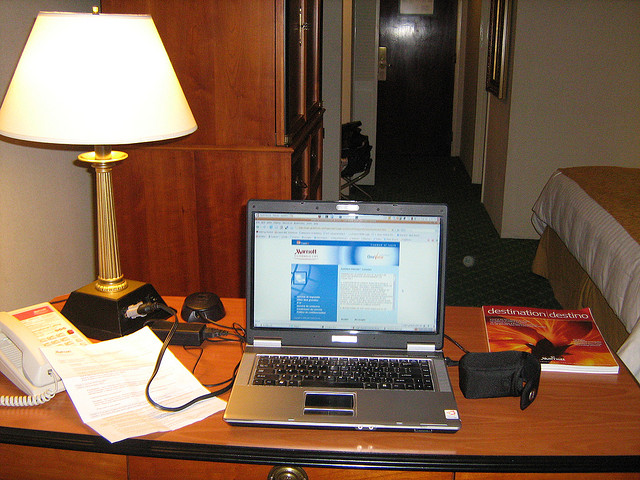

In [8]:
print(train_captions[0])
Image.open(img_name_vector[0])

## Preprocess the images using InceptionV3
Next, you will use InceptionV3 (which is pretrained on Imagenet) to classify each image. You will extract features from the last convolutional layer.

First, you will convert the images into InceptionV3's expected format by:
* Resizing the image to 299px by 299px
* [Preprocess the images](https://cloud.google.com/tpu/docs/inception-v3-advanced#preprocessing_stage) using the [preprocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/inception_v3/preprocess_input) method to normalize the image so that it contains pixels in the range of -1 to 1, which matches the format of the images used to train InceptionV3.

In [9]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

## Initialize InceptionV3 and load the pretrained Imagenet weights

Now you'll create a tf.keras model where the output layer is the last convolutional layer in the InceptionV3 architecture. The shape of the output of this layer is ```8x8x2048```. You use the last convolutional layer because you are using attention in this example. You don't perform this initialization during training because it could become a bottleneck.

* You forward each image through the network and store the resulting vector in a dictionary (image_name --> feature_vector).
* After all the images are passed through the network, you save the dictionary to disk.


In [10]:
image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

    8192/87910968 [..............................] - ETA: 40s

 4202496/87910968 [>.............................] - ETA: 5s 

 8396800/87910968 [=>............................] - ETA: 7s

22093824/87910968 [======>.......................] - ETA: 2s

33562624/87910968 [==========>...................] - ETA: 2s

41951232/87910968 [=============>................] - ETA: 2s

53993472/87910968 [=================>............] - ETA: 1s

67117056/87910968 [=====================>........] - ETA: 0s

79323136/87910968 [==========================>...] - ETA: 0s

87916544/87910968 [==============================] - 3s 0us/step


## Caching the features extracted from InceptionV3

You will pre-process each image with InceptionV3 and cache the output to disk. Caching the output in RAM would be faster but also memory intensive, requiring 8 \* 8 \* 2048 floats per image. At the time of writing, this exceeds the memory limitations of Colab (currently 12GB of memory).

Performance could be improved with a more sophisticated caching strategy (for example, by sharding the images to reduce random access disk I/O), but that would require more code.

The caching will take about 10 minutes to run in Colab with a GPU. If you'd like to see a progress bar, you can: 

1. install [tqdm](https://github.com/tqdm/tqdm):

    `!pip install -q tqdm`

2. Import tqdm:

    `from tqdm import tqdm`

3. Change the following line:

    `for img, path in image_dataset:`

    to:

    `for img, path in tqdm(image_dataset):`


In [11]:
# Get unique images
encode_train = sorted(set(img_name_vector))

# Feel free to change batch_size according to your system configuration
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(
  load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(16)

for img, path in image_dataset:
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,
                              (batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    path_of_feature = p.numpy().decode("utf-8")
    np.save(path_of_feature, bf.numpy())

## Preprocess and tokenize the captions

* First, you'll tokenize the captions (for example, by splitting on spaces). This gives us a  vocabulary of all of the unique words in the data (for example, "surfing", "football", and so on).
* Next, you'll limit the vocabulary size to the top 5,000 words (to save memory). You'll replace all other words with the token "UNK" (unknown).
* You then create word-to-index and index-to-word mappings.
* Finally, you pad all sequences to be the same length as the longest one.

In [12]:
# Find the maximum length of any caption in our dataset
def calc_max_length(tensor):
    return max(len(t) for t in tensor)

In [13]:
# Choose the top 5000 words from the vocabulary
top_k = 5000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
tokenizer.fit_on_texts(train_captions)

In [14]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [15]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_captions)

In [16]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')

In [17]:
# Calculates the max_length, which is used to store the attention weights
max_length = calc_max_length(train_seqs)

## Split the data into training and testing

In [18]:
img_to_cap_vector = collections.defaultdict(list)
for img, cap in zip(img_name_vector, cap_vector):
  img_to_cap_vector[img].append(cap)

# Create training and validation sets using an 80-20 split randomly.
img_keys = list(img_to_cap_vector.keys())
random.shuffle(img_keys)

slice_index = int(len(img_keys)*0.8)
img_name_train_keys, img_name_val_keys = img_keys[:slice_index], img_keys[slice_index:]

img_name_train = []
cap_train = []
for imgt in img_name_train_keys:
  capt_len = len(img_to_cap_vector[imgt])
  img_name_train.extend([imgt] * capt_len)
  cap_train.extend(img_to_cap_vector[imgt])

img_name_val = []
cap_val = []
for imgv in img_name_val_keys:
  capv_len = len(img_to_cap_vector[imgv])
  img_name_val.extend([imgv] * capv_len)
  cap_val.extend(img_to_cap_vector[imgv])

In [19]:
len(img_name_train), len(cap_train), len(img_name_val), len(cap_val)

(24011, 24011, 6003, 6003)

## Create a tf.data dataset for training


 Our images and captions are ready! Next, let's create a tf.data dataset to use for training our model.

In [20]:
# Feel free to change these parameters according to your system's configuration

BATCH_SIZE = 64
BUFFER_SIZE = 1000
embedding_dim = 256
units = 512
vocab_size = top_k + 1
num_steps = len(img_name_train) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

In [21]:
# Load the numpy files
def map_func(img_name, cap):
  img_tensor = np.load(img_name.decode('utf-8')+'.npy')
  return img_tensor, cap

In [22]:
dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))

# Use map to load the numpy files in parallel
dataset = dataset.map(lambda item1, item2: tf.numpy_function(
          map_func, [item1, item2], [tf.float32, tf.int32]),
          num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle and batch
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

## Model

Fun fact: the decoder below is identical to the one in the example for [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb).

The model architecture is inspired by the [Show, Attend and Tell](https://arxiv.org/pdf/1502.03044.pdf) paper.

* In this example, you extract the features from the lower convolutional layer of InceptionV3 giving us a vector of shape (8, 8, 2048).
* You squash that to a shape of (64, 2048).
* This vector is then passed through the CNN Encoder (which consists of a single Fully connected layer).
* The RNN (here GRU) attends over the image to predict the next word.

In [23]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [24]:
class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

In [25]:
class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [26]:
encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

In [27]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Checkpoint

In [28]:
checkpoint_path = "./checkpoints/train"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [29]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
  start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
  # restoring the latest checkpoint in checkpoint_path
  ckpt.restore(ckpt_manager.latest_checkpoint)

## Training

* You extract the features stored in the respective `.npy` files and then pass those features through the encoder.
* The encoder output, hidden state(initialized to 0) and the decoder input (which is the start token) is passed to the decoder.
* The decoder returns the predictions and the decoder hidden state.
* The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
* Use teacher forcing to decide the next input to the decoder.
* Teacher forcing is the technique where the target word is passed as the next input to the decoder.
* The final step is to calculate the gradients and apply it to the optimizer and backpropagate.


In [30]:
# adding this in a separate cell because if you run the training cell
# many times, the loss_plot array will be reset
loss_plot = []

In [31]:
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

In [32]:
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    if epoch % 5 == 0:
      ckpt_manager.save()

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.0436


Epoch 1 Batch 100 Loss 1.2139


Epoch 1 Batch 200 Loss 1.0171


Epoch 1 Batch 300 Loss 0.9492


Epoch 1 Loss 1.094750
Time taken for 1 epoch 115.99 sec



Epoch 2 Batch 0 Loss 0.9204


Epoch 2 Batch 100 Loss 0.7476


Epoch 2 Batch 200 Loss 0.8300


Epoch 2 Batch 300 Loss 0.8252


Epoch 2 Loss 0.834296
Time taken for 1 epoch 45.89 sec



Epoch 3 Batch 0 Loss 0.7721


Epoch 3 Batch 100 Loss 0.7509


Epoch 3 Batch 200 Loss 0.8069


Epoch 3 Batch 300 Loss 0.7527


Epoch 3 Loss 0.752264
Time taken for 1 epoch 45.67 sec



Epoch 4 Batch 0 Loss 0.7364


Epoch 4 Batch 100 Loss 0.6961


Epoch 4 Batch 200 Loss 0.7111


Epoch 4 Batch 300 Loss 0.7302


Epoch 4 Loss 0.697394
Time taken for 1 epoch 47.18 sec



Epoch 5 Batch 0 Loss 0.6719


Epoch 5 Batch 100 Loss 0.6485


Epoch 5 Batch 200 Loss 0.6410


Epoch 5 Batch 300 Loss 0.5863


Epoch 5 Loss 0.656725
Time taken for 1 epoch 46.51 sec



Epoch 6 Batch 0 Loss 0.6303


Epoch 6 Batch 100 Loss 0.6145


Epoch 6 Batch 200 Loss 0.6173


Epoch 6 Batch 300 Loss 0.5613


Epoch 6 Loss 0.617368
Time taken for 1 epoch 45.54 sec



Epoch 7 Batch 0 Loss 0.5689


Epoch 7 Batch 100 Loss 0.5396


Epoch 7 Batch 200 Loss 0.6018


Epoch 7 Batch 300 Loss 0.6358


Epoch 7 Loss 0.584526
Time taken for 1 epoch 45.98 sec



Epoch 8 Batch 0 Loss 0.5883


Epoch 8 Batch 100 Loss 0.5473


Epoch 8 Batch 200 Loss 0.5676


Epoch 8 Batch 300 Loss 0.5417


Epoch 8 Loss 0.554602
Time taken for 1 epoch 45.03 sec



Epoch 9 Batch 0 Loss 0.5423


Epoch 9 Batch 100 Loss 0.5331


Epoch 9 Batch 200 Loss 0.5054


Epoch 9 Batch 300 Loss 0.4515


Epoch 9 Loss 0.525291
Time taken for 1 epoch 44.87 sec



Epoch 10 Batch 0 Loss 0.5095


Epoch 10 Batch 100 Loss 0.5017


Epoch 10 Batch 200 Loss 0.4781


Epoch 10 Batch 300 Loss 0.4704


Epoch 10 Loss 0.497998
Time taken for 1 epoch 45.22 sec



Epoch 11 Batch 0 Loss 0.4385


Epoch 11 Batch 100 Loss 0.4621


Epoch 11 Batch 200 Loss 0.5013


Epoch 11 Batch 300 Loss 0.5085


Epoch 11 Loss 0.473056
Time taken for 1 epoch 47.45 sec



Epoch 12 Batch 0 Loss 0.4842


Epoch 12 Batch 100 Loss 0.4583


Epoch 12 Batch 200 Loss 0.4253


Epoch 12 Batch 300 Loss 0.4387


Epoch 12 Loss 0.448735
Time taken for 1 epoch 47.58 sec



Epoch 13 Batch 0 Loss 0.4350


Epoch 13 Batch 100 Loss 0.4013


Epoch 13 Batch 200 Loss 0.4413


Epoch 13 Batch 300 Loss 0.4178


Epoch 13 Loss 0.425068
Time taken for 1 epoch 46.99 sec



Epoch 14 Batch 0 Loss 0.4234


Epoch 14 Batch 100 Loss 0.4112


Epoch 14 Batch 200 Loss 0.4164


Epoch 14 Batch 300 Loss 0.3829


Epoch 14 Loss 0.404426
Time taken for 1 epoch 46.81 sec



Epoch 15 Batch 0 Loss 0.3797


Epoch 15 Batch 100 Loss 0.3471


Epoch 15 Batch 200 Loss 0.3635


Epoch 15 Batch 300 Loss 0.3502


Epoch 15 Loss 0.384106
Time taken for 1 epoch 46.46 sec



Epoch 16 Batch 0 Loss 0.3790


Epoch 16 Batch 100 Loss 0.3795


Epoch 16 Batch 200 Loss 0.3778


Epoch 16 Batch 300 Loss 0.3371


Epoch 16 Loss 0.365713
Time taken for 1 epoch 44.86 sec



Epoch 17 Batch 0 Loss 0.3997


Epoch 17 Batch 100 Loss 0.3389


Epoch 17 Batch 200 Loss 0.3373


Epoch 17 Batch 300 Loss 0.3326


Epoch 17 Loss 0.349113
Time taken for 1 epoch 43.83 sec



Epoch 18 Batch 0 Loss 0.3439


Epoch 18 Batch 100 Loss 0.3746


Epoch 18 Batch 200 Loss 0.3828


Epoch 18 Batch 300 Loss 0.3210


Epoch 18 Loss 0.331469
Time taken for 1 epoch 45.52 sec



Epoch 19 Batch 0 Loss 0.3199


Epoch 19 Batch 100 Loss 0.3233


Epoch 19 Batch 200 Loss 0.2991


Epoch 19 Batch 300 Loss 0.3366


Epoch 19 Loss 0.315025
Time taken for 1 epoch 45.93 sec



Epoch 20 Batch 0 Loss 0.3088


Epoch 20 Batch 100 Loss 0.2845


Epoch 20 Batch 200 Loss 0.3127


Epoch 20 Batch 300 Loss 0.3254


Epoch 20 Loss 0.301194
Time taken for 1 epoch 45.48 sec



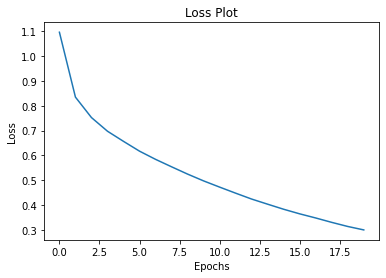

In [33]:
plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Caption!

* The evaluate function is similar to the training loop, except you don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the end token.
* And store the attention weights for every time step.

In [34]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [35]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for i in range(len_result):
        temp_att = np.resize(attention_plot[i], (8, 8))
        grid_size = max(np.ceil(len_result/2), 2)
        ax = fig.add_subplot(grid_size, grid_size, i+1)
        ax.set_title(result[i])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

Real Caption: <start> an image of a man with other men on skiis <end>
Prediction Caption: a small skiers standing on a snow around a woman in the snow <end>


/home/kbuilder/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


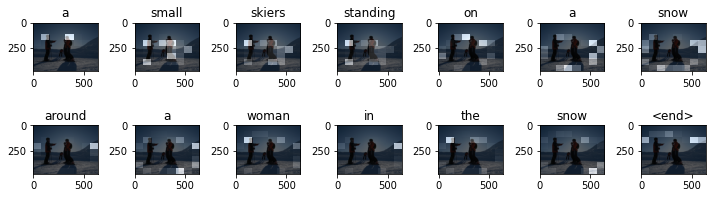

In [36]:
# captions on the validation set
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
real_caption = ' '.join([tokenizer.index_word[i]
                        for i in cap_val[rid] if i not in [0]])
result, attention_plot = evaluate(image)

print('Real Caption:', real_caption)
print('Prediction Caption:', ' '.join(result))
plot_attention(image, result, attention_plot)

## Try it on your own images
For fun, below we've provided a method you can use to caption your own images with the model we've just trained. Keep in mind, it was trained on a relatively small amount of data, and your images may be different from the training data (so be prepared for weird results!)


 8192/64400 [==>...........................] - ETA: 0s

16384/64400 [======>.......................] - ETA: 0s

32768/64400 [==============>...............] - ETA: 0s

49152/64400 [=====================>........] - ETA: 0s

65536/64400 [==============================] - 0s 4us/step


Prediction Caption: a man rides a wave on a sunny day <end>


/home/kbuilder/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  # Remove the CWD from sys.path while we load stuff.


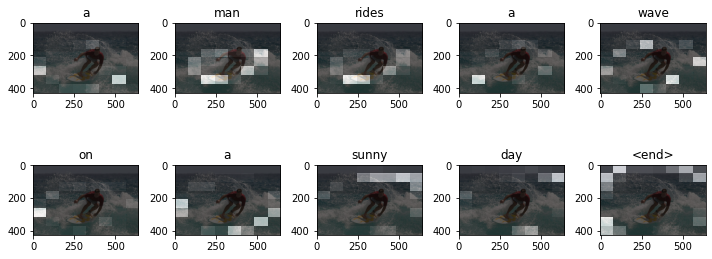

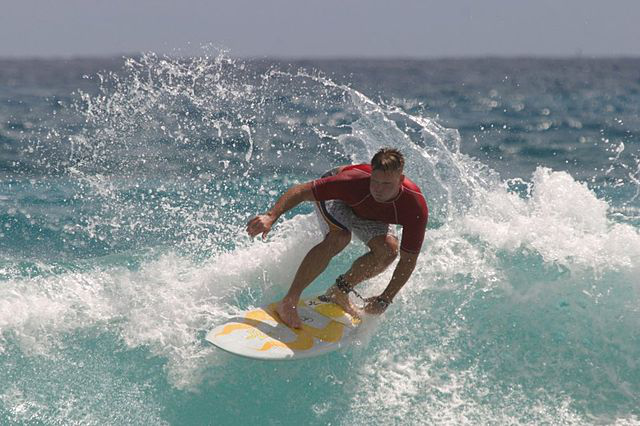

In [37]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension, origin=image_url)

result, attention_plot = evaluate(image_path)
print('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)

# Next steps

Congrats! You've just trained an image captioning model with attention. Next, take a look at this example [Neural Machine Translation with Attention](../sequences/nmt_with_attention.ipynb). It uses a similar architecture to translate between Spanish and English sentences. You can also experiment with training the code in this notebook on a different dataset.